In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 800

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.9 * abs_residual + 0.1 * chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|          | 9/1500 [00:00<00:16, 88.74it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 426.95it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 552.41it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 627.58it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 653.47it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 654.30it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 612.93it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 652.00it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 676.75it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 691.07it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 703.45it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:00, 709.74it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 717.47it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 722.75it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 725.79it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 730.50it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 737.19it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 739.91it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 745.73it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 746.86it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 745.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 746.04it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 726.99it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 729.54it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 694.56it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 704.72it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 719.63it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 698.77it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 673.04it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 644.07it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 662.99it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 684.23it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 705.82it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 720.92it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 699.52it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 710.45it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 716.74it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 711.21it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 704.91it/s]

Adam:  93%|█████████▎| 1393/1500 [00:01<00:00, 713.61it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 718.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 729.05it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 700.69it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 716.70it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 721.78it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 727.81it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 727.56it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 733.21it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 692.54it/s]

Adam:  44%|████▍     | 660/1500 [00:00<00:01, 693.62it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 689.01it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:00, 703.12it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 716.93it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 720.73it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 724.01it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 728.99it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 728.93it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 730.90it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 725.92it/s]

Adam:  93%|█████████▎| 1397/1500 [00:01<00:00, 727.46it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 716.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 715.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.64it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 731.53it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 738.82it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 742.53it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 742.83it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 739.68it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 739.30it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 743.61it/s]

Adam:  45%|████▍     | 671/1500 [00:00<00:01, 743.19it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 740.01it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:00, 721.25it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 725.89it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 728.75it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 689.71it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 682.98it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 694.35it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 697.07it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 699.80it/s]

Adam:  93%|█████████▎| 1398/1500 [00:01<00:00, 692.41it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 681.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.48it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 599.21it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:01, 666.33it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 654.56it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 686.41it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 684.51it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 644.27it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 650.44it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 546.25it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 593.03it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 630.53it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 648.63it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 642.28it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 668.15it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 664.77it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 646.34it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 666.65it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 681.17it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 695.14it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 703.15it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 716.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 650.36it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 633.49it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 663.12it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 679.17it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 664.73it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 679.59it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 695.72it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 689.86it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 692.14it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 692.28it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 696.15it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 701.26it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 699.08it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 691.16it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 682.44it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 682.12it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 696.90it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 706.38it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 707.25it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 713.98it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 705.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.19it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 727.76it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 706.14it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 654.64it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 654.95it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 671.95it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 682.61it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 695.15it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 695.02it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 672.27it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 648.47it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 665.92it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 688.82it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 680.65it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 655.79it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 633.25it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 647.48it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 599.26it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 631.34it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 652.25it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 654.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.27it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 662.88it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 683.74it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 663.00it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 670.60it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 672.60it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 686.85it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 622.25it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 646.20it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 655.98it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 682.86it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 695.47it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 708.63it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 698.75it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 689.00it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 702.80it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 698.04it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 705.53it/s]

Adam:  90%|████████▉ | 1344/1500 [00:01<00:00, 692.25it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 692.93it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 702.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 736.36it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 709.84it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 715.44it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 721.53it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 722.57it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 711.01it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 701.64it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 707.83it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 691.44it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 696.81it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 703.23it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 704.56it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 653.71it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 598.59it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 618.63it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 651.95it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 675.41it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 688.09it/s]

Adam:  92%|█████████▏| 1373/1500 [00:01<00:00, 703.92it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 695.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.06it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 681.92it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 671.30it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 663.55it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 646.13it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 648.40it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 670.38it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 687.01it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 688.61it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 696.78it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 704.49it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:00, 710.28it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 717.71it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 712.82it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 682.16it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 694.59it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 705.48it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 715.88it/s]

Adam:  90%|█████████ | 1356/1500 [00:01<00:00, 719.50it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 725.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 710.05it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 665.03it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 691.56it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 588.36it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 488.67it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 553.65it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 605.47it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 624.78it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 645.96it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 666.60it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 683.80it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 698.41it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 685.85it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 651.74it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 653.51it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 671.56it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 685.40it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 695.95it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 703.51it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 707.05it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 699.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 571.87it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 597.95it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 631.79it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 663.51it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 684.36it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 677.36it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 674.58it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 679.07it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 676.45it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 672.95it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 685.72it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:00, 694.29it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 700.34it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 690.13it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 701.88it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 706.49it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 693.76it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 696.20it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 681.90it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 693.97it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 700.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.91it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 669.83it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 682.87it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 676.94it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 661.86it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 680.40it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 692.44it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 703.05it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 692.49it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 683.41it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 694.24it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 700.25it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 706.71it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 688.64it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 674.50it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 676.69it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 693.74it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 628.84it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 595.47it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 614.51it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 642.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 726.50it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 688.00it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 701.74it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 677.50it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 697.81it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 659.72it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 676.95it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 651.33it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 676.22it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 606.38it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 633.08it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 650.02it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 669.34it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 682.76it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 693.05it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 653.07it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 670.82it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 694.09it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 682.74it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 690.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 738.71it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 725.24it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 708.64it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 568.46it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 589.36it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 605.26it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 603.64it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 641.85it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 655.43it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 679.28it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 628.92it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 650.79it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 627.74it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 632.91it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 661.52it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 679.12it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 676.14it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 691.01it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 701.77it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 693.54it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 684.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.11it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 637.36it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 667.57it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 691.78it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 702.94it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 656.99it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 654.66it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 676.31it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 665.02it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 685.68it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 593.51it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 577.27it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 607.24it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 605.36it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 641.94it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 668.46it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 687.17it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 656.85it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 648.56it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 668.42it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 669.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.97it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 630.49it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 667.71it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 689.41it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 696.79it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 705.67it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 708.91it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 713.96it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 692.88it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 707.97it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:00, 714.35it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 719.37it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 700.49it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 696.46it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 679.84it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 686.41it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 695.50it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 708.56it/s]

Adam:  92%|█████████▏| 1375/1500 [00:01<00:00, 667.49it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 656.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.39it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.05it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 653.51it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 674.74it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 682.03it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 690.48it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 699.08it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 705.48it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 695.05it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 706.32it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 715.79it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 718.47it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 723.08it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 680.17it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 682.62it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 694.76it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 698.78it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 670.17it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 671.37it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 687.34it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 696.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.56it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 721.18it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 616.68it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 650.88it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 680.44it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 676.88it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 691.98it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 705.91it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 707.51it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 717.10it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 686.81it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 685.68it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 699.77it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 708.07it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 713.56it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 698.89it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 710.80it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 704.35it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 667.14it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 672.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 710.45it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 659.70it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 639.31it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 659.01it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 675.57it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 646.33it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 673.64it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 672.00it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 668.39it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 664.74it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 677.36it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 684.52it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 695.34it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 693.11it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 695.04it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 704.70it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 707.61it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 705.61it/s]

Adam:  89%|████████▉ | 1340/1500 [00:01<00:00, 707.55it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 703.59it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 713.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.56it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 699.69it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 710.46it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 713.78it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 718.71it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 720.96it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 718.72it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 720.40it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 718.62it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 720.18it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:00, 718.39it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 640.74it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 663.14it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 667.17it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 666.78it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 664.86it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 683.55it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 695.64it/s]

Adam:  91%|█████████ | 1367/1500 [00:01<00:00, 703.73it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 700.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.63it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 685.34it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 690.96it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 707.46it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 692.05it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 701.63it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 708.85it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 693.37it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 690.38it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 701.75it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 705.23it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 712.45it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 716.43it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 721.67it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 729.52it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 734.40it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 735.28it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 737.78it/s]

Adam:  92%|█████████▏| 1377/1500 [00:01<00:00, 733.96it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 730.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 714.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 728.20it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 729.50it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 730.08it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 730.17it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 730.61it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 731.35it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 736.62it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 734.23it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 733.12it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 731.48it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:00, 729.10it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 726.66it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 728.57it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 728.79it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 728.60it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 728.18it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 726.75it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 726.00it/s]

Adam:  93%|█████████▎| 1400/1500 [00:01<00:00, 728.13it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 731.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 730.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.07it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 674.68it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 692.80it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 710.36it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 714.35it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 720.68it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 716.36it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 720.91it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 690.20it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 698.99it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 704.59it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 686.24it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 666.16it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 655.39it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 671.81it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 685.37it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 696.61it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 705.81it/s]

Adam:  91%|█████████ | 1361/1500 [00:01<00:00, 708.39it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 711.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.39it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 719.32it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 724.64it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 732.11it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 729.14it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 733.85it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 726.27it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 707.34it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 716.63it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 718.80it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:00, 714.54it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 718.26it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 686.45it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 689.08it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 685.85it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 693.11it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 702.14it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 713.60it/s]

Adam:  92%|█████████▏| 1387/1500 [00:01<00:00, 720.35it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 724.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 714.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 724.90it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 734.12it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 674.71it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 636.91it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 621.39it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 633.33it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 644.16it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 669.42it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 682.97it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 692.78it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 700.41it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 710.96it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 721.79it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 721.43it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 726.73it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 721.14it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 728.58it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 735.56it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 739.53it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 743.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 756.00it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 753.66it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:01, 749.20it/s]

Adam:  20%|██        | 304/1500 [00:00<00:01, 749.85it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 749.89it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 746.49it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 741.51it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 741.65it/s]

Adam:  45%|████▌     | 679/1500 [00:00<00:01, 743.31it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 742.91it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 743.62it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 744.52it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 743.54it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 743.72it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 743.88it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 745.05it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 741.73it/s]

Adam:  90%|█████████ | 1354/1500 [00:01<00:00, 739.12it/s]

Adam:  95%|█████████▌| 1429/1500 [00:01<00:00, 740.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 743.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 744.17it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 742.95it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 671.40it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 684.26it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 697.11it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 706.76it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 683.00it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 703.22it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 711.81it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 718.65it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:00, 723.93it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 730.57it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 714.26it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 706.48it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 717.84it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 726.34it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 731.34it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 736.86it/s]

Adam:  94%|█████████▎| 1405/1500 [00:01<00:00, 720.16it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 728.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 716.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 751.63it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 744.13it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:01, 744.58it/s]

Adam:  20%|██        | 303/1500 [00:00<00:01, 746.66it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:01, 744.44it/s]

Adam:  30%|███       | 453/1500 [00:00<00:01, 743.00it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 742.02it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 741.87it/s]

Adam:  45%|████▌     | 678/1500 [00:00<00:01, 741.13it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 741.29it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 741.41it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 741.29it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 727.57it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 726.76it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 731.21it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 735.76it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 738.61it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 734.19it/s]

Adam:  95%|█████████▍| 1424/1500 [00:01<00:00, 730.37it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 725.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 735.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 741.33it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 740.56it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 742.57it/s]

Adam:  20%|██        | 300/1500 [00:00<00:01, 734.84it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:01, 734.66it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 733.52it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 720.13it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 714.43it/s]

Adam:  45%|████▍     | 668/1500 [00:00<00:01, 718.30it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 725.94it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 729.72it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 732.92it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 723.68it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 704.48it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 701.38it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 710.45it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 715.94it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 720.73it/s]

Adam:  94%|█████████▎| 1406/1500 [00:01<00:00, 728.59it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 731.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 721.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.43it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 663.83it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 662.81it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 655.64it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 632.44it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 658.93it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 673.26it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 660.62it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 654.85it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 642.34it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 492.65it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 534.81it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 523.27it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 531.26it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 583.79it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 624.98it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 657.25it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 673.06it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 683.36it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 695.53it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 707.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.39it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.62it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 705.95it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 715.48it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 726.52it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 729.36it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 723.58it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 712.38it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 709.55it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 707.07it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 711.57it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 697.05it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 701.47it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 712.51it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 720.57it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 725.91it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 721.70it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 722.42it/s]

Adam:  92%|█████████▏| 1383/1500 [00:01<00:00, 725.81it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 682.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 708.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.99it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 710.06it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 721.21it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 702.16it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 700.21it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 683.05it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 695.70it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 678.98it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 678.46it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 684.07it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 677.17it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 692.63it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 696.14it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 700.88it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 705.75it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 716.86it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 719.41it/s]

Adam:  91%|█████████ | 1361/1500 [00:01<00:00, 719.57it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 720.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.30it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 716.66it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 671.84it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 597.76it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 521.54it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 565.78it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 597.16it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 635.11it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 660.02it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 683.68it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 678.89it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 699.40it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 690.35it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 701.27it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 702.71it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 708.40it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 712.35it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 712.01it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 709.53it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 715.79it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 681.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.58it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 691.74it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 688.03it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 685.18it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 629.46it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 657.54it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 681.77it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 691.04it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 697.28it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 701.62it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 683.84it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 700.10it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 700.15it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 709.24it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 714.29it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 708.93it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 686.33it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 700.04it/s]

Adam:  91%|█████████ | 1359/1500 [00:01<00:00, 691.06it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 704.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 741.70it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 702.61it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 709.10it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 695.21it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 701.48it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 684.63it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 690.03it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 698.57it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 706.40it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 712.68it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 675.07it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 682.46it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 696.88it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 708.15it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 711.97it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 710.87it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 714.40it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 713.07it/s]

Adam:  92%|█████████▏| 1380/1500 [00:01<00:00, 716.70it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 717.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.03it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 685.66it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 701.80it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 663.70it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 658.86it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 659.71it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 680.31it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 694.86it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 672.66it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 687.22it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 685.98it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 698.76it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 709.58it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 711.71it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 694.76it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 694.41it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 707.72it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 706.29it/s]

Adam:  90%|█████████ | 1353/1500 [00:01<00:00, 710.87it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 709.98it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 662.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 645.83it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 677.49it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 682.99it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 696.93it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 692.54it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 694.06it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 686.67it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 668.70it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 656.67it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 631.42it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 601.99it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 634.52it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 628.32it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 621.08it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 647.52it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 621.27it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 608.37it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 630.30it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 653.76it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 669.73it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 669.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.49it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 624.01it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 651.26it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 638.04it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 669.07it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 688.80it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 666.01it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 681.01it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 648.37it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 640.42it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 653.70it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 658.88it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 633.29it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 639.52it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 661.57it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 671.11it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 672.90it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 683.69it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 693.93it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 681.09it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 680.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 634.22it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 671.76it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 693.04it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 699.43it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 702.10it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 708.37it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 691.40it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 677.68it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 670.69it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 642.85it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 629.83it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 657.25it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 630.41it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 631.16it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 654.42it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 666.75it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 672.65it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 675.03it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 690.36it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 697.69it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 660.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.77it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.37it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 689.02it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 663.28it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 679.19it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 602.78it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 592.78it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 623.62it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 632.46it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 646.13it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 645.42it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 621.95it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 581.54it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 614.31it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 639.87it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 620.62it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 650.64it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 664.57it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 686.28it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 695.70it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 704.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.97it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.76it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 710.70it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 713.07it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 683.04it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 683.58it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 692.29it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 689.25it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 694.84it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 694.58it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 706.25it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 715.96it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 704.43it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 706.99it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 711.81it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 702.32it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 705.51it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 656.82it/s]

Adam:  91%|█████████ | 1360/1500 [00:01<00:00, 669.43it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 677.76it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 663.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.97it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 685.19it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 705.69it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 628.40it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 663.72it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 674.62it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 686.86it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 692.67it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 679.07it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 692.61it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 672.50it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 692.75it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 697.38it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 689.10it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 667.93it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 674.86it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 689.60it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 698.94it/s]

Adam:  91%|█████████ | 1362/1500 [00:01<00:00, 682.00it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 679.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 742.27it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 690.23it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 673.18it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 688.48it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 695.73it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 704.77it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 705.83it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 685.03it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 682.57it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 692.24it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 704.96it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 687.55it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 700.92it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 700.04it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 704.94it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 686.68it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 689.32it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 681.89it/s]

Adam:  91%|█████████ | 1361/1500 [00:01<00:00, 681.75it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 665.36it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 651.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.78it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 720.67it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 708.44it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 710.57it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 695.34it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 701.25it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 679.75it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 691.50it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 703.13it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 707.96it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:00, 715.46it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 712.06it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 710.59it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 708.86it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 713.04it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 709.15it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 692.72it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 700.52it/s]

Adam:  92%|█████████▏| 1373/1500 [00:01<00:00, 708.60it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 706.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.73it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 711.40it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 713.13it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 690.01it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 666.97it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 650.42it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 651.10it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 670.38it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 657.08it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 679.62it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 681.44it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:00, 683.25it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 695.81it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 630.36it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 655.20it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 648.43it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 670.54it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 666.61it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 647.71it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 478.28it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 517.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 697.95it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 712.75it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 696.86it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 674.23it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 691.41it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 705.87it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 666.03it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 663.47it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 615.52it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 612.08it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 619.74it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 627.14it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 655.82it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 654.37it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 675.27it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 689.20it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 694.64it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 689.20it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 702.18it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 709.97it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 706.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.12it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 644.45it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 646.34it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 678.07it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 668.92it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 680.17it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 682.00it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 691.43it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 696.37it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 693.84it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 691.32it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:00, 696.51it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 677.68it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 673.38it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 664.59it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 649.76it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 646.37it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 666.92it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 680.82it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 688.33it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 687.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 567.91it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 658.16it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 692.79it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 684.04it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 701.02it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 703.43it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 693.73it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 701.07it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 709.26it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 705.55it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 688.15it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 697.97it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 678.66it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 687.47it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 698.47it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 686.90it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 694.86it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 685.82it/s]

Adam:  90%|████████▉ | 1349/1500 [00:01<00:00, 696.64it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 703.29it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 700.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.05it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 720.34it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 728.08it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 718.45it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 723.12it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 718.26it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 709.99it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 710.84it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 711.48it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 709.21it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 684.86it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 696.39it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 705.64it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 710.37it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 719.83it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 729.37it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 727.91it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 729.20it/s]

Adam:  93%|█████████▎| 1389/1500 [00:01<00:00, 731.29it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 730.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 718.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.97it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 710.77it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 721.11it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 722.13it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 725.91it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 724.97it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 733.45it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 731.26it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 727.50it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 732.49it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:00, 716.53it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 707.76it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 694.64it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 703.98it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 709.83it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 698.53it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 712.89it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 717.14it/s]

Adam:  93%|█████████▎| 1395/1500 [00:01<00:00, 727.84it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 733.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 719.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.10it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 696.52it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 718.45it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 720.66it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 719.62it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 728.54it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 683.26it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 699.13it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 708.11it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 715.60it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:00, 717.69it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 724.83it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 733.14it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 722.40it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 727.20it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 735.00it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 720.64it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 700.29it/s]

Adam:  93%|█████████▎| 1395/1500 [00:01<00:00, 694.50it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 707.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 728.84it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 737.19it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 733.45it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 737.34it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 740.26it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 735.41it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 729.35it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 730.07it/s]

Adam:  45%|████▍     | 669/1500 [00:00<00:01, 724.95it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 717.50it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 725.05it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 727.30it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 693.95it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 705.19it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 694.40it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 678.81it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 694.69it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 707.40it/s]

Adam:  93%|█████████▎| 1401/1500 [00:01<00:00, 714.53it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 721.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 717.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 744.00it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 691.15it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 712.07it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 722.17it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 723.96it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 720.39it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 730.29it/s]

Adam:  40%|███▉      | 594/1500 [00:00<00:01, 723.10it/s]

Adam:  44%|████▍     | 667/1500 [00:00<00:01, 714.29it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 712.68it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:00, 718.53it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 719.24it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 693.27it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 700.49it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 706.20it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 713.85it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 719.18it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 693.78it/s]

Adam:  93%|█████████▎| 1394/1500 [00:01<00:00, 700.54it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 704.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.79it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 709.04it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 712.40it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 717.00it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 704.06it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 701.89it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 691.02it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 696.59it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 701.69it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 708.21it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:00, 711.72it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 716.79it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 721.61it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 717.83it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 722.81it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 724.03it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 718.18it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 717.39it/s]

Adam:  92%|█████████▏| 1375/1500 [00:01<00:00, 708.69it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 712.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.51it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 719.37it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 686.86it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 700.57it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 706.66it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 708.33it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 711.38it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 710.04it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 651.65it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 603.52it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 608.57it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 638.15it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 661.29it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 681.90it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 660.34it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 674.80it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 685.81it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 643.53it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 646.64it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 659.68it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 654.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.22it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 662.98it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 681.14it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 689.41it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 642.24it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 665.01it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 675.00it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 694.83it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 702.21it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 685.73it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 689.61it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 701.52it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 707.69it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 711.37it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 713.29it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 720.74it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 723.24it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 727.71it/s]

Adam:  91%|█████████ | 1359/1500 [00:01<00:00, 724.54it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 720.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.61it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 678.04it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 685.08it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 696.07it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 699.36it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 705.54it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 669.37it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 667.02it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 678.68it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 693.31it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 708.37it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 716.69it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 719.00it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 721.64it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 721.61it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 716.59it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 718.03it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 716.52it/s]

Adam:  91%|█████████ | 1362/1500 [00:01<00:00, 710.85it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 708.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.85it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 702.80it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 686.39it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 698.84it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 690.37it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 707.66it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 717.94it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 715.11it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 721.80it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 720.28it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:00, 719.66it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 720.44it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 720.72it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 722.43it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 699.01it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 656.84it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 671.54it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 679.64it/s]

Adam:  92%|█████████▏| 1373/1500 [00:01<00:00, 692.62it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 690.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 605.73it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 646.81it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 676.20it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 665.25it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 684.11it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 680.59it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 638.22it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 661.01it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 657.15it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 657.49it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 673.72it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 685.68it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 699.68it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 688.93it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 697.29it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 697.58it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 683.76it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 670.73it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 665.15it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 681.92it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 661.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.39it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 706.66it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 712.52it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 703.93it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 679.77it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 697.81it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 701.69it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 686.19it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 682.69it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 695.39it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 698.53it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 696.27it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 679.15it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 693.36it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 675.37it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 667.88it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 632.39it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 603.53it/s]

Adam:  89%|████████▉ | 1333/1500 [00:01<00:00, 611.37it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 635.42it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 613.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 575.67it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 566.54it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 635.10it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 668.17it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 644.01it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 653.29it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 636.97it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 663.15it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 654.56it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 674.69it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 689.26it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:00, 699.48it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 670.12it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 680.28it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 695.47it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 706.44it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 684.14it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 692.59it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 698.89it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 705.02it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 709.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.56it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 700.25it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 685.85it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 700.42it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 702.12it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 687.21it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 641.46it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 644.53it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 656.02it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 670.50it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 681.59it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 675.11it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 673.45it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 682.74it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 671.56it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 680.91it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 693.05it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 678.07it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 673.57it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 685.99it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 681.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.94it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 681.64it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 696.85it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 707.24it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 709.92it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 710.76it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 708.22it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 681.67it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 690.96it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 693.73it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 695.61it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 686.18it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 696.76it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 703.54it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 709.26it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 714.39it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 717.38it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 721.71it/s]

Adam:  91%|█████████ | 1363/1500 [00:01<00:00, 691.82it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 696.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.69it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 699.55it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 721.17it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 730.50it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 699.84it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 703.69it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 709.88it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 719.70it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 704.94it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 675.53it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 689.68it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 700.97it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 708.35it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 716.89it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 710.11it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 718.82it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 727.03it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 727.85it/s]

Adam:  93%|█████████▎| 1389/1500 [00:01<00:00, 720.62it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 693.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 706.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.72it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 729.55it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 729.63it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 724.40it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 725.62it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 698.33it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 699.06it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 705.29it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 715.26it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 722.97it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:00, 729.66it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 734.69it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 731.83it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 721.20it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 721.60it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 725.53it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 731.53it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 713.72it/s]

Adam:  93%|█████████▎| 1400/1500 [00:01<00:00, 723.31it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 707.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 719.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 743.18it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 735.40it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 736.68it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 727.32it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 712.04it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 700.37it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 695.45it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 706.90it/s]

Adam:  44%|████▍     | 664/1500 [00:00<00:01, 718.97it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 726.79it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:00, 727.99it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 691.00it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 692.46it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 707.69it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 718.48it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 723.94it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 710.09it/s]

Adam:  89%|████████▊ | 1328/1500 [00:01<00:00, 719.59it/s]

Adam:  94%|█████████▎| 1403/1500 [00:01<00:00, 726.12it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 733.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 718.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 743.92it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 735.69it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 737.14it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 728.39it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 727.48it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 719.41it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 720.81it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 726.76it/s]

Adam:  44%|████▍     | 665/1500 [00:00<00:01, 730.58it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 730.82it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:00, 733.75it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 730.25it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 733.42it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 732.99it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 735.70it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 738.92it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 737.05it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 738.73it/s]

Adam:  94%|█████████▍| 1411/1500 [00:01<00:00, 740.87it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 741.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 733.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 730.73it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 739.03it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 740.88it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 734.00it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 722.19it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 723.11it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 727.46it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 733.53it/s]

Adam:  45%|████▍     | 670/1500 [00:00<00:01, 735.80it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 738.16it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:00, 737.21it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 735.00it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 728.77it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 677.49it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 685.87it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 697.70it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 706.37it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 711.93it/s]

Adam:  93%|█████████▎| 1402/1500 [00:01<00:00, 700.47it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 710.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 717.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.90it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 720.71it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 718.60it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 723.90it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 699.02it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 703.69it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 714.90it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 687.51it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 695.34it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 708.22it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 684.48it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 693.91it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 682.85it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 695.52it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 674.73it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 686.90it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 688.72it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 695.90it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 702.25it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 702.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.03it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 709.63it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 704.22it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 638.29it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 654.78it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 558.01it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 610.52it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 638.36it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 662.52it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 685.06it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 649.57it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 668.66it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 684.38it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 702.27it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 710.99it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 717.33it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 709.11it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 631.80it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 654.57it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 658.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 735.55it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 723.64it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 731.09it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 685.68it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 705.37it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 687.22it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 628.20it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 647.80it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 673.26it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 690.26it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 688.11it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 694.11it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 701.27it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 697.73it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 691.44it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 703.34it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 710.80it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 719.60it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 718.86it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 721.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 729.52it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 730.97it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 725.91it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 728.26it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 702.50it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 690.10it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 700.20it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 690.13it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 699.58it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 693.18it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 694.04it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 702.54it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 709.11it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 692.15it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 683.07it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 689.29it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 699.23it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 700.43it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 696.47it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 686.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.61it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 727.31it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 721.40it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 718.18it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 722.64it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 728.12it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 698.00it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 709.81it/s]

Adam:  44%|████▍     | 659/1500 [00:00<00:01, 712.10it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 717.46it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 695.35it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 711.11it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 694.79it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 706.89it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 717.42it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 700.08it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 703.98it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 707.81it/s]

Adam:  92%|█████████▏| 1387/1500 [00:01<00:00, 707.94it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 714.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 710.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 741.17it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 696.47it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 699.92it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 696.88it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 711.70it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 718.93it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 707.91it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 684.76it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 694.11it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 697.33it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 700.92it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 677.13it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 655.09it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 678.18it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 690.63it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 693.24it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 703.73it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 714.38it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 706.70it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 714.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 710.07it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 707.79it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 719.54it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 719.14it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 719.08it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 640.36it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 659.85it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 640.54it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 667.51it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 673.73it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 677.10it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 662.47it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 680.96it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 688.27it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 649.77it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 651.75it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 658.12it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 665.89it/s]

Adam:  90%|████████▉ | 1346/1500 [00:01<00:00, 682.75it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 691.92it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 679.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.66it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 680.25it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 704.62it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 649.23it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 673.23it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 662.47it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 676.49it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 687.04it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 701.77it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 705.65it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 710.14it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 705.30it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 705.75it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 708.97it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 717.39it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 718.14it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 720.19it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 698.47it/s]

Adam:  91%|█████████ | 1363/1500 [00:01<00:00, 710.14it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 710.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.07it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 719.16it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 700.75it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 704.31it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 707.94it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 716.84it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 710.64it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 716.16it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 723.34it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 726.61it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 717.57it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 685.81it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 694.19it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 697.50it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 688.61it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 701.73it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 702.33it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 709.43it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 719.74it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 679.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.65it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 541.00it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 553.63it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 536.39it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 596.60it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 598.47it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 589.61it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 632.40it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 659.91it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 678.70it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 678.67it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 688.89it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:00, 699.20it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 710.62it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 714.54it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 716.76it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 713.07it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 719.47it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 643.67it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 650.64it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 664.25it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 686.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.62it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 704.54it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 711.88it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 722.46it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 693.35it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 693.16it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 686.83it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 681.68it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 691.80it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 700.48it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 690.08it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 676.16it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 679.71it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 680.10it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 690.69it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 702.33it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 708.65it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 709.71it/s]

Adam:  91%|█████████ | 1358/1500 [00:01<00:00, 717.70it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 720.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.86it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 725.45it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 726.33it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 723.84it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 704.52it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 685.10it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 676.43it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 687.05it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 655.94it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 630.59it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 652.66it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 678.64it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 686.81it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 672.50it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 683.69it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 684.33it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 698.04it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 713.17it/s]

Adam:  91%|█████████ | 1360/1500 [00:01<00:00, 691.17it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 703.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.55it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 672.81it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 688.86it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 691.16it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 666.68it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 685.72it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 697.72it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 710.25it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 698.41it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 686.93it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 694.18it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 697.95it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 690.61it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 696.81it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 696.41it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 690.77it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 695.32it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 684.06it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 689.58it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 699.68it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 694.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.64it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 709.15it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 681.65it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 665.77it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 661.88it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 674.16it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 613.17it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 639.75it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 656.87it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 660.61it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 648.93it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 657.85it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 669.20it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 681.54it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 680.63it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 675.72it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 685.78it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 692.88it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 697.22it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 699.18it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 648.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.92it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 624.31it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 655.76it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 681.38it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 686.07it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 697.10it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 698.78it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 706.35it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 704.95it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 687.44it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 699.47it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 702.12it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 707.02it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 715.25it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 710.92it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 718.00it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 712.62it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 705.52it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 698.62it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 691.56it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 635.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 550.96it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 588.19it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 567.96it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 613.63it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 645.34it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 675.29it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 681.83it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 683.82it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 683.20it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 695.32it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 701.37it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:00, 705.55it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 705.77it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 712.66it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 713.14it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 711.34it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 709.84it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 709.81it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 714.97it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 720.54it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 721.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.83it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 695.25it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 650.26it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 671.66it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 673.47it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 639.56it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 663.09it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 682.05it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 692.94it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 702.50it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 708.37it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 704.83it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 695.37it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 698.91it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 702.99it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 679.39it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 644.02it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 525.88it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 572.20it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 591.62it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 628.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 724.71it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 728.03it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 719.13it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 720.57it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 714.48it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 678.52it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 669.38it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 681.30it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 693.42it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 664.33it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 677.85it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 693.40it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 690.84it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 697.70it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 670.20it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 638.88it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 663.48it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 637.06it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 646.91it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 663.13it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 648.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.65it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 579.01it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 612.41it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 655.18it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 679.39it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 661.47it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 676.32it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 654.15it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 656.75it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 660.91it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 675.49it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 684.69it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 699.92it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 680.90it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 674.71it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 636.04it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 659.59it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 677.70it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 692.50it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 648.88it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 660.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 600.25it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 607.74it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 654.88it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 654.48it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 683.73it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 698.19it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 704.26it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 698.43it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 698.02it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 685.73it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 696.80it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 705.15it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 712.77it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 716.13it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 708.10it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 705.15it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 710.82it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 701.71it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 697.77it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 705.42it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 675.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 735.70it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 728.29it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 728.55it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 723.51it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 694.56it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 662.45it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 678.45it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 670.20it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 678.73it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 668.10it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 633.18it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 659.68it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 665.15it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 659.60it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 667.53it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 639.53it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 661.98it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 675.55it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 689.72it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 697.96it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 706.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 738.36it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 658.03it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 666.94it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 675.52it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 678.32it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 689.62it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 702.41it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 709.20it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 709.60it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 713.14it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:00, 720.60it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 700.82it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 704.19it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 707.03it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 710.44it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 695.18it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 709.39it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 702.34it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 687.89it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 698.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.39it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 701.34it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 704.84it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 712.59it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 711.12it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 719.25it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 656.94it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 666.08it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 659.13it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 682.55it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 691.70it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 705.89it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 688.54it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 700.19it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 702.38it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 664.25it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 676.36it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 582.40it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 609.73it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 622.79it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 649.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.14it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 673.81it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 686.86it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 687.90it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 675.03it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 664.44it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 669.11it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 681.77it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 694.03it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 702.22it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 691.40it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 679.33it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 675.01it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 664.73it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 637.38it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 660.61it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 685.86it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 700.59it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 702.94it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 703.55it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 708.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.41it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 685.99it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 704.28it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 709.95it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 712.35it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 696.84it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 703.60it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 710.79it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 709.28it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 710.76it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 682.19it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 692.93it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 701.36it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 704.45it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 693.05it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 564.77it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 570.75it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 574.75it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 615.62it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 618.45it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 654.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.25it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 726.27it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 736.34it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 733.73it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 736.98it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 706.05it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 705.75it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 696.93it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 695.37it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 685.71it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 692.14it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 699.20it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 707.78it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 712.42it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 706.63it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 700.52it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 686.18it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 696.78it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 702.34it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 696.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.45it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 736.51it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 732.18it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 728.61it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 714.54it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 715.19it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 697.29it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 647.86it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 669.49it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 679.07it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 688.60it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 694.05it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 705.07it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 703.75it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 701.44it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 697.39it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 656.62it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 630.19it/s]

Adam:  91%|█████████ | 1366/1500 [00:01<00:00, 654.09it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 652.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.17it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 712.24it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 675.88it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 692.41it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 694.42it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 704.67it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 706.95it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 709.23it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 718.83it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 715.32it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:00, 714.14it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 715.49it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 713.71it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 696.12it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 706.56it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 706.31it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 713.03it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 717.98it/s]

Adam:  92%|█████████▏| 1373/1500 [00:01<00:00, 720.88it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 704.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 707.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.63it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 663.36it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 688.64it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 679.95it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 696.02it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 686.41it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 695.62it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 704.93it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 708.14it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 704.22it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 704.24it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 679.00it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 689.04it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 693.52it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 682.27it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 693.26it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 701.88it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 703.06it/s]

Adam:  90%|████████▉ | 1348/1500 [00:01<00:00, 672.41it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 688.09it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 699.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 726.78it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 742.06it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 743.12it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 738.98it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 735.50it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 731.40it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 727.34it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 728.66it/s]

Adam:  45%|████▍     | 669/1500 [00:00<00:01, 731.90it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 724.48it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 727.79it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 731.10it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 709.25it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 713.94it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 718.45it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 724.04it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 723.95it/s]

Adam:  89%|████████▉ | 1333/1500 [00:01<00:00, 729.79it/s]

Adam:  94%|█████████▍| 1409/1500 [00:01<00:00, 735.85it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 738.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 729.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 750.78it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 738.33it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:01, 730.69it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 736.14it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:01, 739.26it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 739.99it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 743.43it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 743.41it/s]

Adam:  45%|████▌     | 677/1500 [00:00<00:01, 729.83it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 727.74it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:00, 727.97it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 705.96it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 712.10it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 715.63it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 722.98it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 664.18it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 656.35it/s]

Adam:  89%|████████▊ | 1328/1500 [00:01<00:00, 663.49it/s]

Adam:  93%|█████████▎| 1401/1500 [00:01<00:00, 680.19it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 680.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 706.18it/s]

Training time: 218.0435
当前为第1次循环，种子为0
Error y : 4.421566e-04
MAE: 1.354898e-04
MSE: 4.101754e-08
Chaos: 9.173743e-04
Residual: 4.545284e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|          | 14/1500 [00:00<00:10, 139.15it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:02, 497.30it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 607.03it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:01, 645.74it/s]

Adam:  21%|██        | 308/1500 [00:00<00:01, 678.75it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:01, 691.96it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 711.75it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 698.12it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 707.49it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 700.51it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 714.89it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:00, 715.31it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 708.81it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 720.71it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 723.78it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 724.53it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 722.91it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 705.32it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 680.83it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 699.64it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 686.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 733.81it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 714.67it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 719.99it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 671.78it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 676.72it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 672.45it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 688.68it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 691.91it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 704.95it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 716.64it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 694.94it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 703.82it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 711.57it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 718.82it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 725.61it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 723.59it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 728.83it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 724.42it/s]

Adam:  92%|█████████▏| 1387/1500 [00:01<00:00, 728.42it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 727.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.73it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 737.68it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 728.65it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 738.28it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 736.14it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 717.68it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 695.89it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 691.97it/s]

Adam:  44%|████▍     | 659/1500 [00:00<00:01, 698.56it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 695.23it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:00, 708.19it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 675.93it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 688.45it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 701.11it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 691.04it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 700.16it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 714.19it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 705.05it/s]

Adam:  92%|█████████▏| 1386/1500 [00:01<00:00, 713.92it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 674.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.83it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 718.82it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 717.25it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 719.60it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 695.61it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 716.33it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 723.16it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 731.15it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 736.16it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 735.10it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:00, 732.16it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 709.85it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 702.77it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 715.16it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 693.76it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 711.30it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 687.21it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 700.77it/s]

Adam:  93%|█████████▎| 1395/1500 [00:01<00:00, 688.84it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 685.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 705.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.92it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 714.60it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 718.03it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 722.51it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 724.82it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 726.18it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 692.51it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 698.75it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 697.32it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 702.90it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:00, 715.42it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 701.69it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 717.57it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 729.54it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 739.37it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 731.95it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 738.72it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 693.08it/s]

Adam:  93%|█████████▎| 1400/1500 [00:01<00:00, 706.88it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 717.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 715.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.19it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 706.10it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 714.69it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 730.85it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 741.97it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 747.44it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 742.60it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 741.17it/s]

Adam:  45%|████▍     | 668/1500 [00:00<00:01, 734.42it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 712.45it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:00, 689.39it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 706.91it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 698.97it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 692.62it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 692.29it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 706.72it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 713.11it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 721.29it/s]

Adam:  93%|█████████▎| 1398/1500 [00:01<00:00, 719.47it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 678.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.07it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 646.29it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 680.45it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 687.52it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 704.39it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 676.31it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 697.85it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 701.12it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 716.91it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 719.58it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 702.06it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 709.32it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 712.21it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 715.96it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 719.60it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 722.42it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 730.10it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 709.58it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 715.18it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 717.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 707.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.75it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 727.45it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 732.17it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 743.68it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 743.06it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 747.24it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 695.41it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 654.02it/s]

Adam:  44%|████▍     | 665/1500 [00:00<00:01, 670.77it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 674.20it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 668.34it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 648.02it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 677.08it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 677.02it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 681.55it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 658.90it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 681.06it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 698.90it/s]

Adam:  92%|█████████▏| 1376/1500 [00:01<00:00, 708.71it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 718.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 695.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.73it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 580.34it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 648.93it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 678.32it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 687.58it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 702.99it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 710.05it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 713.15it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 702.30it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 713.58it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 714.71it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 724.47it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 701.21it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 694.28it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 684.12it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 696.92it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 657.70it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 652.94it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 650.13it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 678.56it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 691.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.12it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 717.59it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 723.81it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 732.64it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 698.88it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 710.92it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 717.26it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 723.97it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 691.82it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 669.92it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 586.86it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 597.31it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 610.72it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 642.00it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 664.82it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 679.32it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 683.69it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 700.79it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 709.78it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 703.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 729.14it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 624.40it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 565.43it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 610.88it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 628.94it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 650.81it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 648.48it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 668.24it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 675.29it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 662.46it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 650.47it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 647.18it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 609.53it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 599.12it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 596.21it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 591.90it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 631.70it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 665.08it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 650.48it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 660.47it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 672.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.09it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 699.47it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 670.10it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 697.33it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 709.40it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 718.99it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 724.93it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 686.70it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 678.99it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 694.78it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 709.62it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 708.45it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 710.17it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 719.36it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 721.56it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 729.75it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 701.56it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 668.05it/s]

Adam:  92%|█████████▏| 1382/1500 [00:01<00:00, 674.15it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 675.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 651.68it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 624.74it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 676.22it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 698.66it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 710.21it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 723.52it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 724.72it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 712.03it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 699.24it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 689.77it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 703.01it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 717.32it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 695.25it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 708.07it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 681.96it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 695.01it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 710.92it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 716.76it/s]

Adam:  92%|█████████▏| 1383/1500 [00:01<00:00, 725.28it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 728.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 706.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.86it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 700.84it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 716.11it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 719.27it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 698.54it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 702.13it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 691.32it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 706.89it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 715.08it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 712.80it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:00, 722.51it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 689.05it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 682.87it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 704.58it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 688.52it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 699.90it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 701.07it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 701.60it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 703.12it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 705.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 736.91it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 734.37it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 728.54it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 721.82it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 725.35it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 688.15it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 704.63it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 708.52it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 596.91it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 595.23it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 568.31it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 584.17it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 618.15it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 648.62it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 661.77it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 683.46it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 695.94it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 691.53it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 684.97it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 697.26it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 712.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.94it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 698.46it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 686.42it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 673.73it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 688.35it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 682.87it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 618.51it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 632.08it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 639.28it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 669.51it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 682.74it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 663.62it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 653.96it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 678.09it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 686.93it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 701.17it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 697.31it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 706.22it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 710.46it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 721.62it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 726.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.93it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 728.43it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 723.79it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 712.47it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 696.96it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 655.02it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 657.61it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 669.06it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 684.15it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 664.28it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 683.92it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 694.45it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 704.84it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 715.43it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 714.86it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 714.65it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 722.85it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 711.68it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 713.04it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 720.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 695.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.68it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 642.96it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 676.44it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 623.53it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 618.91it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 650.46it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 677.79it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 691.00it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 702.09it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 678.78it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 687.25it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 658.52it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 656.93it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 633.73it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 660.94it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 674.13it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 676.43it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 635.00it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 634.88it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 631.31it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 652.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.14it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 608.60it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 649.88it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 667.92it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 686.14it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 695.05it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 694.52it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 679.74it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 632.28it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 661.24it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 672.31it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 677.31it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 696.22it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 708.89it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 710.19it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 674.00it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 658.50it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 686.64it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 694.69it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 578.43it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 587.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.33it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 686.83it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 701.73it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 681.97it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 671.64it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 688.18it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 696.91it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 702.54it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 714.00it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 692.07it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 702.06it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 706.97it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 713.88it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 670.42it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 675.33it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 689.24it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 697.88it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 710.84it/s]

Adam:  91%|█████████ | 1366/1500 [00:01<00:00, 718.68it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 706.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 677.95it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 682.62it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 694.51it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 713.35it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 713.95it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 703.71it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 716.39it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 721.01it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 721.86it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 699.39it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 698.80it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 714.35it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 708.49it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 691.21it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 701.08it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 710.38it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 719.31it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 722.85it/s]

Adam:  92%|█████████▏| 1382/1500 [00:01<00:00, 722.39it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 727.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.59it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 653.38it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 673.28it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 693.00it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 712.87it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 719.85it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 731.53it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 737.30it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 745.68it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 717.79it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 727.37it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 729.56it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 737.16it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 743.11it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 741.11it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 716.27it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 679.38it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 699.59it/s]

Adam:  94%|█████████▍| 1415/1500 [00:01<00:00, 709.61it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 719.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 717.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 728.32it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 740.66it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 738.38it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 735.77it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 732.31it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 711.62it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 709.86it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 719.85it/s]

Adam:  44%|████▍     | 666/1500 [00:00<00:01, 688.28it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 703.15it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:00, 710.74it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 712.73it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 658.43it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 662.31it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 684.43it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 696.02it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 704.19it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 717.46it/s]

Adam:  93%|█████████▎| 1394/1500 [00:01<00:00, 722.14it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 715.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 707.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 734.36it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 732.55it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 737.16it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:01, 728.92it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 726.46it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 723.85it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 726.68it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 723.77it/s]

Adam:  44%|████▍     | 665/1500 [00:00<00:01, 729.19it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 722.37it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:00, 731.37it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 691.55it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 682.29it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 700.37it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 714.73it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 671.68it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 688.06it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 672.15it/s]

Adam:  93%|█████████▎| 1394/1500 [00:01<00:00, 681.68it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 688.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 705.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.22it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 713.27it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 692.35it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 703.57it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 713.90it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 726.36it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 729.88it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 718.13it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 711.72it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 671.64it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 643.26it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 661.36it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 681.67it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 678.99it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 694.24it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 680.72it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 691.51it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 697.43it/s]

Adam:  92%|█████████▏| 1373/1500 [00:01<00:00, 709.49it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 665.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.31it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 688.78it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 644.92it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 675.44it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 683.72it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 678.62it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 625.91it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 649.52it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 674.38it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 669.53it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 672.02it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 625.23it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 654.49it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 670.84it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 687.64it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 672.04it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 685.42it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 694.75it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 688.32it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 691.47it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 695.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.83it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 694.84it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 713.54it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 721.11it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 728.59it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 670.24it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 668.88it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 683.38it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 701.09it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 636.31it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 665.86it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 671.80it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 661.32it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 676.13it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 691.10it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 704.68it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 713.46it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 715.81it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 715.19it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 715.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<10:08,  2.46it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:15, 95.38it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:09, 152.47it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:06, 223.12it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 291.96it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 416.45it/s]

Adam:  20%|██        | 300/1500 [00:01<00:02, 500.52it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:02, 555.14it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:01, 603.50it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 630.26it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 658.64it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 668.33it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 658.76it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 674.23it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 670.59it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 587.64it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:00, 607.34it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 631.18it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 600.24it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 620.15it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 641.23it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 658.04it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 665.87it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 679.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 529.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.45it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 637.98it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 660.71it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 655.79it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 635.14it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 652.72it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 670.13it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 631.75it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 653.55it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 667.27it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 681.84it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:00, 685.46it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 693.44it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 683.24it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 657.99it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 672.23it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 686.00it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 692.14it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 688.07it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 679.86it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 678.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.00it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 638.32it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 523.15it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 559.13it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 608.70it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 637.42it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 661.56it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 667.87it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 679.62it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 681.80it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 693.95it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 662.99it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 672.83it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 687.55it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 694.98it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 703.23it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 705.52it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 691.90it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 697.10it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 691.70it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 673.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.76it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 701.40it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 704.65it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 705.01it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 706.68it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 703.19it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 701.03it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 684.75it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 692.21it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 701.49it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 706.21it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 710.49it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 708.82it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 697.01it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 696.35it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 693.25it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 682.48it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 666.86it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 673.37it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 675.67it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 680.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.06it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 693.23it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 683.15it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 657.38it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 674.39it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 678.00it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 685.57it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 690.45it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 671.35it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 677.83it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 664.93it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 658.29it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 661.40it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 673.97it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 689.05it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 688.08it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 692.81it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 700.27it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 700.22it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 681.14it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 681.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.48it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 688.62it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 705.00it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 700.57it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 661.22it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 671.38it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 688.76it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 698.18it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 705.87it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 700.69it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 700.80it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 707.99it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 706.94it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 670.43it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 657.56it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 615.22it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 609.07it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 622.05it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 643.21it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 646.23it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 657.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 676.66it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 657.67it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 675.06it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 673.25it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 646.42it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 648.79it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 666.30it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 675.89it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 638.24it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 659.09it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 672.45it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 645.51it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 637.62it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 565.90it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 587.46it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 601.44it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 608.02it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 633.18it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 639.56it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 582.81it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 612.19it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 641.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.37it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 704.49it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 690.58it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 701.93it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 702.77it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 702.03it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 693.08it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 672.40it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 663.55it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 667.82it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 679.12it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 638.83it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 659.05it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 653.11it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 670.20it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 662.61it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 667.65it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 648.76it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 662.23it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 662.85it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 677.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.39it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 577.53it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 633.09it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:01, 660.16it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 679.15it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 651.58it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 666.40it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 680.20it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 694.84it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 698.35it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 706.27it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:00, 708.68it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 708.81it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 695.32it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 695.42it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 702.36it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 705.63it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 706.76it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 696.43it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 702.01it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 709.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.78it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 705.37it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 708.16it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 694.12it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 647.64it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 665.54it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 673.54it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 687.71it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 675.62it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 683.44it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 691.20it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 701.98it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 707.15it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 689.77it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 697.85it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 701.89it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 709.67it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 698.51it/s]

Adam:  90%|█████████ | 1355/1500 [00:01<00:00, 699.97it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 698.69it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 699.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 728.27it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 720.08it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 708.57it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 709.84it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 700.53it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 705.09it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 664.05it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 679.31it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 676.86it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 669.27it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 684.14it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 689.20it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 688.06it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 675.29it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 676.05it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 627.50it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 629.60it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 649.60it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 661.76it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 660.66it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 664.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.88it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 659.75it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 671.62it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 683.71it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 689.99it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 693.78it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 682.90it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 690.19it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 695.43it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 663.97it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 675.24it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 673.84it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 682.71it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 681.46it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 692.03it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 685.68it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 685.42it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 693.24it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 699.20it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 705.68it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 690.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.69it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 665.35it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 671.10it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 649.46it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 643.43it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 642.41it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 608.92it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 608.09it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 631.33it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 647.38it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 596.42it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 623.47it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 645.24it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 663.09it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 660.27it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 671.65it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 642.23it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 658.43it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 655.61it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 666.68it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 677.92it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 680.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 281.58it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 313.53it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 467.98it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 553.35it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 598.44it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 604.65it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 614.10it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 619.87it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 636.15it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 657.06it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 656.36it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 642.58it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 652.57it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 646.14it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 664.41it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 652.57it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 636.86it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 632.21it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 635.80it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 656.50it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 658.11it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 644.60it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 654.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.47it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 689.89it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 693.43it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 686.82it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 678.90it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 661.42it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 646.68it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 649.29it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 665.19it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 682.03it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 672.72it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 520.56it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 543.17it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 576.79it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 602.98it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 630.87it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 648.79it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 647.89it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 650.25it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 663.66it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 673.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.81it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.98it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 694.26it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 695.63it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 704.98it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 707.34it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 629.18it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 643.78it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 667.15it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 674.79it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 669.05it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 664.80it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 658.99it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 654.86it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 670.09it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 690.18it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 690.83it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 701.87it/s]

Adam:  89%|████████▉ | 1337/1500 [00:01<00:00, 688.76it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 702.39it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 689.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.88it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 678.58it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 673.82it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 695.47it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 708.78it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 711.63it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 662.83it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 671.27it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 678.65it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 661.80it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 671.29it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 656.56it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 660.99it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 639.63it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 628.17it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 658.51it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 674.26it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 689.97it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 684.96it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 685.30it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 673.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 583.64it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 635.75it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 675.48it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 673.50it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 665.12it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 653.07it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 661.59it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 668.02it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 677.47it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 669.48it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 674.75it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 616.78it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 640.68it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 665.83it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 653.68it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 660.17it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 649.50it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 665.84it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 647.21it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 658.44it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 657.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.53it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 666.44it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 654.07it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 666.16it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 670.40it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 681.67it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 685.88it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 675.45it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 684.62it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 678.84it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 689.50it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 691.82it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 694.87it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 701.60it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 706.54it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 689.20it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 676.77it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 683.65it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 677.72it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 683.63it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 671.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.93it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 624.04it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 654.41it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 682.62it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 694.71it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 706.97it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 718.55it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 725.57it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 730.35it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 731.96it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 734.73it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 735.49it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 736.49it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 737.46it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 729.24it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 732.04it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 702.17it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 689.57it/s]

Adam:  92%|█████████▏| 1384/1500 [00:01<00:00, 696.52it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 702.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 710.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.85it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.28it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 714.44it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 709.10it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 711.70it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 711.67it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 715.80it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 715.67it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 714.91it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 702.63it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 707.11it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 708.54it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 710.91it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 712.54it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 710.59it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 715.37it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 691.01it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 698.71it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 700.47it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 704.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.61it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 717.87it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 720.88it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 721.26it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 723.11it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 721.38it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 714.60it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 714.30it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 716.88it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 717.16it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:00, 716.39it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 711.88it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 707.87it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 712.66it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 715.34it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 717.97it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 715.31it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 705.03it/s]

Adam:  92%|█████████▏| 1376/1500 [00:01<00:00, 702.20it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 695.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.20it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 687.06it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 690.72it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 705.38it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 702.49it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 701.13it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 677.74it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 631.49it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 544.33it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 568.87it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 606.95it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 639.58it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 667.84it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 684.99it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 697.81it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 653.45it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 671.91it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 685.97it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 701.49it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 711.47it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 696.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.89it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 679.02it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 695.36it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 697.67it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 710.38it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 713.16it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 720.01it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 723.09it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 686.13it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 697.90it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:00, 709.76it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 718.55it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 721.34it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 712.98it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 706.76it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 708.81it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 716.00it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 719.58it/s]

Adam:  92%|█████████▏| 1385/1500 [00:01<00:00, 704.51it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 704.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 708.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.28it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 671.91it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 650.77it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 671.95it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 685.06it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 678.16it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 689.70it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 674.25it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 681.74it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 693.65it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 684.53it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 671.06it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 678.10it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 658.75it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 669.22it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 684.57it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 675.22it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 688.08it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 680.30it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 668.98it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 673.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.51it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 705.61it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 706.18it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 687.23it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 672.42it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 693.14it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 698.01it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 699.08it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 677.48it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 676.18it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 623.34it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 646.05it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 668.60it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 684.19it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 689.63it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 700.20it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 704.40it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 710.47it/s]

Adam:  90%|█████████ | 1355/1500 [00:01<00:00, 716.87it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 715.42it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 697.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.59it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 622.23it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 624.47it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 628.12it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 662.91it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 686.82it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 703.65it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 713.32it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 698.09it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 701.59it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 704.63it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 714.57it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 718.36it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 719.86it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 723.36it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 729.06it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 730.22it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 731.54it/s]

Adam:  91%|█████████ | 1359/1500 [00:01<00:00, 732.95it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 732.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 706.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 739.63it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 640.07it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 679.59it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 671.38it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 692.71it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 707.30it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 712.10it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 669.94it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 658.95it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 680.12it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 691.78it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 702.60it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 708.46it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 718.90it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 723.82it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 726.61it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 694.24it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 687.80it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 667.68it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 663.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.21it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 695.10it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 700.58it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 690.54it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 694.53it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 661.33it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 671.10it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 628.12it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 631.38it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 652.66it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 655.78it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 656.29it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 673.12it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 660.78it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 628.61it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 639.12it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 656.66it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 642.74it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 640.29it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 605.25it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 629.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.36it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 699.04it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 663.21it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 657.90it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 643.87it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 645.28it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 649.75it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 650.57it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 671.92it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 688.86it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 685.11it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 675.07it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 681.10it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 645.20it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 663.00it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 673.72it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 693.09it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 705.20it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 714.11it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 717.70it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 652.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 657.87it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 687.70it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 690.97it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 700.35it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 682.38it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 688.48it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 646.16it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 662.73it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 673.00it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 683.51it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 693.10it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 699.60it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 670.37it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 682.96it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 692.06it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 706.54it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 715.97it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 711.58it/s]

Adam:  90%|█████████ | 1356/1500 [00:01<00:00, 718.17it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 702.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 705.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.34it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 672.56it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 633.28it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 665.58it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 688.84it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 698.46it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 705.79it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 708.13it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 708.44it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 718.12it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:00, 722.09it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 727.43it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 728.59it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 723.28it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 726.28it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 729.60it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 731.31it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 729.64it/s]

Adam:  92%|█████████▏| 1381/1500 [00:01<00:00, 723.29it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 721.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 737.26it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 735.23it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 693.54it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 675.90it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 667.83it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 688.75it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 704.42it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 693.58it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 673.84it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 691.10it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 705.34it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 712.34it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 718.28it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 712.44it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 704.43it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 673.77it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 682.52it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 686.51it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 695.05it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 702.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.35it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 702.94it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 720.42it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 727.65it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 726.47it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 708.38it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 712.47it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 715.86it/s]

Adam:  44%|████▍     | 659/1500 [00:00<00:01, 720.92it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 725.32it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:00, 723.75it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 723.47it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 726.71it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 719.84it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 718.99it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 711.50it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 714.87it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 703.26it/s]

Adam:  93%|█████████▎| 1390/1500 [00:01<00:00, 711.56it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 707.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 715.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.18it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 720.34it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 682.70it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 701.05it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 704.50it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 711.77it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 709.61it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 714.86it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 652.18it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 670.69it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 682.54it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 699.10it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 701.86it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 713.27it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 687.60it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 698.98it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 700.55it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 708.28it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 641.50it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 635.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 587.86it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 637.84it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 648.62it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 662.52it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 631.38it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 653.10it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 639.20it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 617.36it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 649.19it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 658.14it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 662.87it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 657.41it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 670.35it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 682.63it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 655.12it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 675.62it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 653.84it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 671.81it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 682.03it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 681.73it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 658.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.33it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.94it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 708.18it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 709.49it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 709.22it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 715.05it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 717.88it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 721.50it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 717.40it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 720.83it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:00, 706.74it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 702.59it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 699.23it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 693.87it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 692.95it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 683.03it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 623.06it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 646.56it/s]

Adam:  91%|█████████ | 1361/1500 [00:01<00:00, 663.71it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 677.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.26it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.92it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 711.75it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 709.15it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 714.03it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 665.19it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 682.93it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 697.08it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 674.49it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 644.68it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 642.11it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 665.28it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 687.61it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 704.58it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 716.05it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 722.12it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 730.07it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 732.68it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 735.66it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 734.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 736.82it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 733.82it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 710.45it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 699.75it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 705.82it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 717.69it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 724.51it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 722.05it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 722.25it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 717.81it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:00, 719.84it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 718.75it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 720.08it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 715.41it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 686.60it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 696.98it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 701.93it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 708.61it/s]

Adam:  93%|█████████▎| 1389/1500 [00:01<00:00, 717.27it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 719.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 714.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.39it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 667.88it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 672.65it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 675.18it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 676.48it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 663.13it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 638.58it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 618.48it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 635.13it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 639.88it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 667.54it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:00, 688.55it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 700.71it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 687.86it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 702.67it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 715.65it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 721.60it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 729.26it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 726.24it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 733.26it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 733.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.29it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 641.90it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 634.19it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 676.05it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 680.02it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 686.45it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 697.09it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 710.50it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 707.63it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 702.55it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 713.40it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 723.50it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 726.83it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 726.97it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 704.73it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 717.04it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 724.22it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 731.77it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 703.35it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 710.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 705.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 731.89it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 709.48it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 706.80it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 701.62it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 717.82it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 717.04it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 721.51it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 724.44it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 694.65it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 709.66it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:00, 720.08it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 723.70it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 722.81it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 715.87it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 714.72it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 712.37it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 717.23it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 717.48it/s]

Adam:  93%|█████████▎| 1390/1500 [00:01<00:00, 720.47it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 718.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 714.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 658.42it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.26it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 692.43it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 711.40it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 713.22it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 723.19it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 727.01it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 726.24it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 728.39it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 733.20it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 730.41it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 729.00it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 717.07it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 708.65it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 717.39it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 725.87it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 731.00it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 651.31it/s]

Adam:  92%|█████████▏| 1384/1500 [00:01<00:00, 646.18it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 672.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.53it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 558.31it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 624.60it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 653.08it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 684.28it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 693.14it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 705.98it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 677.57it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 651.47it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 666.08it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 679.59it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 691.75it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 702.69it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 715.74it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 724.06it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 726.10it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 732.60it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 736.68it/s]

Adam:  92%|█████████▏| 1377/1500 [00:01<00:00, 739.80it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 733.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 743.07it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 729.92it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 736.09it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 735.24it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:01, 739.19it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 675.43it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 668.25it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 664.47it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 659.66it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 644.22it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 671.07it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 675.93it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 697.14it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 702.14it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 705.13it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 710.64it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 716.03it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 718.26it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 722.74it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 707.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.48it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 717.13it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 713.54it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 723.27it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 720.51it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 691.10it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 680.32it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 696.71it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 672.24it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 647.12it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 655.64it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 674.79it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 692.72it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 662.74it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 669.13it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 686.60it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 675.73it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 675.09it/s]

Adam:  90%|█████████ | 1355/1500 [00:01<00:00, 684.79it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 688.79it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 697.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 707.28it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 658.58it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 650.05it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 677.20it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 616.36it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 613.26it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 643.96it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 657.50it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 667.54it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 683.01it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 687.32it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 696.61it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 621.57it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 645.54it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 663.76it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 621.49it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 638.22it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 645.87it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 652.05it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 654.62it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 670.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.67it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 688.69it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 706.98it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 680.76it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 681.40it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 681.99it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 681.42it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 675.51it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 691.84it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 704.06it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 706.35it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 714.60it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 715.06it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 651.77it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 668.46it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 658.62it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 665.15it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 651.39it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 666.44it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 645.74it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 602.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 721.25it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 472.94it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 530.54it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 579.88it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 630.16it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 665.65it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 665.55it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 679.82it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 665.41it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 678.82it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 693.69it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 704.23it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 696.29it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 704.85it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 454.98it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 455.39it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 500.44it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 477.32it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 541.95it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 567.84it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 594.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 593.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.78it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.41it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 709.00it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 710.75it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 690.07it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 652.06it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 591.33it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 562.07it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 543.69it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 595.73it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 599.26it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 562.34it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 563.91it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 564.51it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 576.51it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 605.43it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 624.22it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 623.04it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 652.42it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 651.88it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 674.34it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 670.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 581.29it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 565.32it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 632.71it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:01, 636.08it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 665.11it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 663.58it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 655.48it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 665.91it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 687.26it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 700.81it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 686.97it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:00, 686.28it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 696.10it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 541.22it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 552.89it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 582.83it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 609.08it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 621.03it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 627.96it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 652.61it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 667.61it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 671.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.75it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 680.83it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 645.09it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 642.58it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 654.01it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 674.80it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 675.94it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 691.66it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 702.79it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 710.10it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 715.03it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 696.45it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 700.04it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 699.99it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 673.05it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 676.04it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 689.17it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 688.19it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 696.96it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 689.60it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 689.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.59it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 596.36it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 619.96it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 604.26it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 645.81it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 625.02it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 599.27it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 631.00it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 661.29it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 680.41it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 684.93it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 699.82it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 706.32it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 716.74it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 680.40it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 695.11it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 699.86it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 705.79it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 710.82it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 714.28it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 715.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.00it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 716.26it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 677.74it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 657.75it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 684.95it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 697.75it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 701.85it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 710.60it/s]

Adam:  43%|████▎     | 651/1500 [00:00<00:01, 715.03it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 714.02it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:00, 717.61it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 721.79it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 677.13it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 694.63it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 686.23it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 676.26it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 682.05it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 680.17it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 610.25it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 644.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 652.76it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 633.96it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 615.10it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 628.22it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 619.74it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 610.95it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 638.85it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 662.22it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 552.07it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 551.69it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 434.89it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 477.70it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 515.46it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 558.05it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 572.69it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 606.44it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 642.55it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 639.69it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 658.29it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 673.72it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 664.90it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 682.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 605.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.43it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 700.12it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 665.22it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 648.81it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 673.76it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 663.24it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 667.91it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 660.88it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 679.76it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 693.66it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 703.47it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 707.17it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 694.07it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 692.51it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 702.54it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 712.00it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 697.28it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 690.97it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 678.66it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 694.76it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 700.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.18it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 697.65it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 695.92it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 686.75it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 674.13it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 697.02it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 688.60it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 696.02it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 701.05it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 681.91it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 683.57it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 672.75it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 693.75it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 707.79it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 709.39it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 714.02it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 723.73it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 721.45it/s]

Adam:  91%|█████████ | 1365/1500 [00:01<00:00, 701.34it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 707.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.27it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 718.83it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 722.10it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 729.65it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 678.15it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 698.93it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 681.67it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 683.48it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 696.41it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 707.69it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:00, 716.36it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 719.32it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 723.74it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 704.49it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 702.72it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 707.58it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 701.35it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 691.61it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 698.17it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 707.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.60it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 698.28it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 689.76it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 695.09it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 685.48it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 666.75it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 674.75it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 687.17it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 652.41it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 658.03it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 649.41it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 663.65it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 669.67it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 664.29it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 683.08it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 691.57it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 686.32it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 683.92it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 693.83it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 701.79it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 711.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.79it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 700.47it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 705.81it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 698.99it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 687.36it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 668.48it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 660.68it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 648.98it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 639.90it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 660.59it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 674.19it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 669.70it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 665.38it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 658.27it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 648.25it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 652.57it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 669.34it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 668.02it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 677.45it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 684.53it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 697.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 716.08it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 711.23it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 701.24it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 670.00it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 690.28it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 706.48it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 692.59it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 699.52it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 706.21it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 712.31it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 718.76it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 702.35it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 707.30it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 707.96it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 690.23it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 702.15it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 696.26it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 694.43it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 690.98it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 656.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 629.52it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 673.80it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 700.07it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 675.55it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 679.76it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 689.20it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 665.59it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 681.28it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 692.48it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 695.80it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 702.97it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 708.71it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 711.71it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 677.53it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 691.82it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 697.95it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 687.16it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 677.15it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 677.64it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 684.51it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 629.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 612.32it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 656.04it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 693.18it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 708.06it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 718.16it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 719.97it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 718.17it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 697.06it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 708.97it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 702.84it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 691.25it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 685.50it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 656.98it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 678.23it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 677.36it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 687.27it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 685.47it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 683.99it/s]

Adam:  90%|████████▉ | 1349/1500 [00:01<00:00, 670.24it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 685.49it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 676.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.31it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 650.27it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 669.85it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 660.66it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 656.67it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 650.80it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 680.60it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 694.54it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 705.85it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 715.26it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 713.31it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 698.41it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 707.20it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 684.75it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 688.38it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 698.18it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 709.29it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 689.34it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 675.02it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 693.16it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 694.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 657.75it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 705.39it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 686.95it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 691.48it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 690.04it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 696.96it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 700.09it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 710.70it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 720.06it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 694.54it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 681.45it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 686.87it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 679.23it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 689.61it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 684.38it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 651.56it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 651.23it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 673.68it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 691.79it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 692.74it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 682.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.34it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 378.94it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 453.51it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 499.32it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 581.41it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 621.06it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 639.53it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 661.14it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 654.47it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 646.81it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 657.36it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 678.01it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 697.55it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 692.72it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 699.18it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 689.44it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 705.56it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 706.20it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 695.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 703.93it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 680.30it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 699.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 739.08it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 740.03it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 735.14it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 718.18it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 722.30it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 692.77it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 678.53it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 657.48it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 679.23it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 699.73it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 691.32it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 697.46it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 676.58it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 690.31it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 676.23it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 689.17it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 650.81it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 670.92it/s]

Adam:  92%|█████████▏| 1373/1500 [00:01<00:00, 676.22it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 693.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 721.11it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 688.76it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 698.35it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 688.37it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 698.12it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 683.90it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 679.79it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 684.51it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 690.07it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 682.19it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 650.16it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 654.07it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 679.59it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 655.26it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 630.80it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 654.87it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 659.61it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 676.22it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 669.89it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 593.99it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 609.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 598.68it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 674.62it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 671.91it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 699.31it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 601.14it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 619.59it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 604.34it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 632.52it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 665.42it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 576.69it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 578.13it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 613.83it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 644.84it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 664.70it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 680.34it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 687.59it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 694.67it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 705.91it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 709.68it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 655.81it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 627.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.33it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 669.43it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 680.35it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 670.58it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 680.85it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 673.66it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 684.59it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 678.72it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 689.70it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 698.43it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 699.29it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 699.96it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 702.17it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 698.41it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 697.19it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 696.33it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 565.73it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 566.19it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 598.56it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 590.13it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 583.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 648.50it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 678.25it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 651.24it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 659.70it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 632.03it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 578.29it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 604.33it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 616.46it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 605.38it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 563.96it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 588.02it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 615.93it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 615.99it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 639.40it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 661.37it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 661.25it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 662.68it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 672.21it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 671.65it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 655.74it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 586.83it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 582.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 622.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.17it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 614.94it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 652.18it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 659.97it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 667.79it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 671.46it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 679.07it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 647.05it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 656.13it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 652.04it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 641.36it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 637.86it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 650.84it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 609.74it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 622.92it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 614.15it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 601.02it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 611.15it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 615.45it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 589.72it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 597.19it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 626.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 648.29it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 667.58it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 667.27it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 664.24it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 672.28it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 669.68it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 641.28it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 621.06it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 626.22it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 644.56it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 651.89it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 643.79it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 644.18it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 654.24it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 641.20it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 605.68it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 616.69it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 602.73it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 615.26it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 615.66it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 622.34it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 592.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.80it/s]

Training time: 221.9600
当前为第2次循环，种子为1
Error y : 4.479263e-04
MAE: 1.370788e-04
MSE: 4.283416e-08
Chaos: 3.329332e-03
Residual: 4.900289e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:27, 54.09it/s]

Adam:   1%|          | 12/1500 [00:00<00:26, 55.29it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:16, 87.86it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 336.40it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:02, 478.06it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 559.46it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 557.38it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 520.81it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 493.75it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:01, 561.72it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 609.73it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 640.34it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 669.31it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 682.24it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 685.64it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 704.35it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 702.40it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 710.11it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 719.35it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 723.42it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 710.49it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 711.82it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 703.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 601.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.21it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 539.91it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 578.41it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 577.86it/s]

Adam:  21%|██        | 311/1500 [00:00<00:01, 615.50it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 582.71it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 601.14it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 594.06it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 627.88it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 651.99it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 665.44it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 663.55it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 647.85it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 631.30it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 618.55it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 654.16it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 657.70it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 671.41it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 680.17it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 674.82it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 643.80it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 651.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.46it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 643.36it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 672.92it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 674.95it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 656.78it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 663.25it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 674.45it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 670.16it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 683.23it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 684.80it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 695.14it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 705.47it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 716.58it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 722.54it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 726.97it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 700.71it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 686.95it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 687.47it/s]

Adam:  89%|████████▉ | 1337/1500 [00:01<00:00, 654.84it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 649.26it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 662.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.37it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 692.29it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 701.05it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 654.12it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 651.69it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 669.36it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 688.19it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 697.38it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 708.40it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 715.60it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 712.22it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 701.97it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 701.61it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 706.93it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 712.42it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 696.71it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 653.20it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 649.62it/s]

Adam:  90%|█████████ | 1353/1500 [00:01<00:00, 669.55it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 681.19it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 696.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.78it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.94it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 703.33it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 715.75it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 722.72it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 711.47it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 712.43it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 718.49it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 723.42it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 725.36it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 728.64it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 723.89it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 716.41it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 720.32it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 713.16it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 706.51it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 711.82it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 707.50it/s]

Adam:  92%|█████████▏| 1382/1500 [00:01<00:00, 712.63it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 709.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.26it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 710.37it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 717.31it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 724.05it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 679.76it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 691.02it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 695.73it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 715.69it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 722.91it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 731.69it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:00, 727.23it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 724.04it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 717.88it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 723.80it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 723.62it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 731.78it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 722.07it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 731.92it/s]

Adam:  93%|█████████▎| 1399/1500 [00:01<00:00, 733.38it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 730.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 719.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 658.04it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 633.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 680.98it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 686.77it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 696.39it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 710.76it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 719.13it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 699.15it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 709.98it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 715.69it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:00, 723.48it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 728.98it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 727.80it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 716.47it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 711.24it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 705.86it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 700.00it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 685.56it/s]

Adam:  91%|█████████ | 1367/1500 [00:01<00:00, 687.35it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 682.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.82it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 696.50it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 687.76it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 708.58it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 717.36it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 720.64it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 723.31it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 724.59it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 720.35it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 725.07it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 680.70it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 670.67it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 691.41it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 650.88it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 666.98it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 672.50it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 690.53it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 690.72it/s]

Adam:  91%|█████████▏| 1371/1500 [00:01<00:00, 700.04it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 700.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.16it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 704.58it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 653.11it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 603.23it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 638.07it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 645.48it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 649.46it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 678.88it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 671.87it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 679.37it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 686.70it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 685.00it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 672.50it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 672.76it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 687.58it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 697.73it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 692.97it/s]

Adam:  84%|████████▍ | 1264/1500 [00:01<00:00, 706.30it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 704.47it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 691.37it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 659.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.36it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 547.89it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 533.21it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 580.68it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 614.97it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 659.05it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 677.71it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 670.66it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 628.42it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 661.17it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 678.24it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:00, 698.34it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 703.63it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 684.08it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 676.51it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 685.61it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 681.25it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 694.13it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 708.21it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 688.82it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 702.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 752.41it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 691.97it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 681.67it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 708.45it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 690.75it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 683.44it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 680.24it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 693.32it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 699.29it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 672.03it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 644.73it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 669.65it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 685.26it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 645.22it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 644.65it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 589.31it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 615.48it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 649.92it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 660.47it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 645.23it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 669.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 745.90it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 698.09it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 686.76it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 688.45it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 690.08it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 651.38it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 676.67it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 670.68it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 683.59it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 666.11it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 683.98it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 679.60it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 694.81it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 690.61it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 691.99it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 685.76it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 691.17it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 691.61it/s]

Adam:  90%|█████████ | 1354/1500 [00:01<00:00, 699.00it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 711.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.44it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 610.75it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 617.24it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 615.10it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 637.42it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 665.21it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 686.77it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 683.95it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 659.38it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 681.44it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 697.38it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 709.26it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 715.79it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 716.34it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 720.41it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 726.69it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 724.70it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 715.76it/s]

Adam:  91%|█████████ | 1359/1500 [00:01<00:00, 722.33it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 711.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 740.84it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 741.22it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 739.67it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 738.13it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 685.90it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 693.55it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 690.28it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 688.71it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 658.79it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 652.30it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 649.77it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 672.81it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 674.26it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 691.31it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 704.86it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 676.78it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 630.36it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 654.82it/s]

Adam:  90%|█████████ | 1357/1500 [00:01<00:00, 666.05it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 674.29it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 672.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.23it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 687.88it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 690.27it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 646.81it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 663.70it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 659.60it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 546.27it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 585.91it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 626.75it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 653.45it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 659.01it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 678.48it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 674.42it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 590.16it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 626.30it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 627.35it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 647.90it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 650.67it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 664.79it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 682.06it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 676.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.55it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 687.93it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 704.88it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 717.60it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 728.84it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 728.50it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 736.83it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 719.93it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 707.45it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 691.95it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:00, 700.04it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 708.63it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 715.75it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 706.79it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 703.60it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 710.13it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 711.00it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 701.53it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 612.34it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 613.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 734.21it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 726.46it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 718.78it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 713.36it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 712.63it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 691.46it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 705.31it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 710.45it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 698.70it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 661.99it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 672.19it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 667.48it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 654.51it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 637.94it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 661.98it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 619.34it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 654.52it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 678.46it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 601.67it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 622.17it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 648.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.16it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 651.54it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 682.26it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 697.73it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 709.01it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 720.92it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 724.59it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 705.16it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 712.31it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 716.92it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 686.66it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 696.20it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 674.58it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 681.40it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 670.12it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 689.26it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 650.40it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 614.75it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 644.47it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 650.11it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 676.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.79it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.38it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 718.65it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 717.22it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 705.60it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 708.01it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 705.77it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 704.90it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 716.33it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 714.87it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:00, 724.57it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 681.78it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 700.61it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 682.92it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 698.79it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 714.42it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 700.73it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 709.56it/s]

Adam:  92%|█████████▏| 1383/1500 [00:01<00:00, 687.91it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 707.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 705.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 750.19it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 705.54it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 713.75it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 728.34it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:01, 735.03it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 710.91it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 715.30it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 721.71it/s]

Adam:  45%|████▍     | 671/1500 [00:00<00:01, 725.96it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 725.35it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 711.72it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 709.62it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 720.16it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 658.18it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 659.42it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 676.99it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 693.65it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 710.53it/s]

Adam:  94%|█████████▎| 1403/1500 [00:01<00:00, 722.78it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 731.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 757.51it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 756.93it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:01, 755.37it/s]

Adam:  20%|██        | 304/1500 [00:00<00:01, 719.87it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 721.90it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 727.62it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 734.24it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 738.69it/s]

Adam:  45%|████▌     | 677/1500 [00:00<00:01, 743.13it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 744.61it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 747.18it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 746.53it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 725.29it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 725.84it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 674.06it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 688.57it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 670.94it/s]

Adam:  89%|████████▉ | 1339/1500 [00:01<00:00, 684.21it/s]

Adam:  94%|█████████▍| 1409/1500 [00:01<00:00, 686.12it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 698.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 715.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 726.54it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 724.29it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 728.74it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 725.17it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 729.85it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 662.89it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 684.61it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 664.49it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 684.54it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 701.58it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:00, 705.75it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 676.02it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 689.73it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 698.16it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 709.28it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 720.42it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 720.25it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 720.58it/s]

Adam:  93%|█████████▎| 1389/1500 [00:01<00:00, 708.01it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 706.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.41it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 677.04it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 698.25it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 714.09it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 714.54it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 723.74it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 720.28it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 718.52it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 682.09it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 683.47it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 671.42it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 673.50it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 673.77it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 690.36it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 708.46it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 715.82it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 724.93it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 704.97it/s]

Adam:  91%|█████████ | 1364/1500 [00:01<00:00, 669.74it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 682.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 695.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.08it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 702.19it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 645.50it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 659.98it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 681.31it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 702.79it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 697.52it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 697.91it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 707.30it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 719.98it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:00, 724.39it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 730.62it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 736.04it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 739.11it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 720.96it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 729.30it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 731.60it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 736.55it/s]

Adam:  93%|█████████▎| 1389/1500 [00:01<00:00, 700.70it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 708.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.32it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 665.55it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 689.17it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 700.54it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 704.35it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 715.61it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 721.66it/s]

Adam:  39%|███▉      | 584/1500 [00:00<00:01, 729.59it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 730.06it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 704.19it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:00, 710.70it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 686.49it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 698.07it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 708.13it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 682.39it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 691.78it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 690.92it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 660.44it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 672.09it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 681.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.38it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 710.59it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 716.80it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 702.83it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 700.74it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 707.97it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 695.25it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 672.79it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 680.20it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 674.51it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 692.68it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 706.32it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 713.93it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 698.13it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 701.08it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 712.50it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 721.78it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 724.97it/s]

Adam:  92%|█████████▏| 1380/1500 [00:01<00:00, 733.86it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 733.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 732.48it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 733.83it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 741.79it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 737.76it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:01, 741.59it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 744.61it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 743.10it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 736.12it/s]

Adam:  45%|████▍     | 674/1500 [00:00<00:01, 723.16it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 731.64it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:00, 737.46it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 740.78it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 745.02it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 745.11it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 747.28it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 747.66it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 735.61it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 732.88it/s]

Adam:  95%|█████████▌| 1426/1500 [00:01<00:00, 709.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 734.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<16:37,  1.50it/s]

Adam:   1%|          | 9/1500 [00:00<01:38, 15.17it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:28, 51.92it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:12, 113.01it/s]

Adam:   7%|▋         | 99/1500 [00:01<00:08, 172.83it/s]

Adam:  10%|▉         | 149/1500 [00:01<00:05, 254.90it/s]

Adam:  14%|█▍        | 213/1500 [00:01<00:03, 355.59it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:02, 432.42it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:02, 511.57it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:01, 567.32it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:01, 581.21it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 623.07it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 645.60it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 655.20it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 663.23it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 665.62it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:00, 672.26it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:00, 678.80it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 684.07it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 665.12it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 653.62it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 670.67it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 680.05it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 693.21it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 694.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.37it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 723.65it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 722.16it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 716.79it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 706.70it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 704.05it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 693.94it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 690.81it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 665.51it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 672.05it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 687.07it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 687.03it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 692.36it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 693.36it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 699.46it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 701.44it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 701.13it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 704.31it/s]

Adam:  90%|█████████ | 1355/1500 [00:01<00:00, 698.04it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 686.44it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 690.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.37it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 639.71it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:01, 661.20it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 672.33it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 672.68it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 675.64it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 666.52it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 677.96it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 686.00it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 666.36it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 677.05it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 669.74it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 654.50it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 635.85it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 621.47it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 647.49it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 664.63it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 674.52it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 621.54it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 638.54it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 649.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.11it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 696.26it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 700.68it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 706.89it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 700.69it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 704.83it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 703.22it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 671.03it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 681.59it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 676.50it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 680.28it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 663.52it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 677.65it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 692.23it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 683.30it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 695.04it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 699.72it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 698.47it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 705.71it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 684.02it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 691.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.18it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.22it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 714.68it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 712.54it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 715.89it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 706.78it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 712.30it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 714.47it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 712.05it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 713.52it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 672.34it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 685.43it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 689.12it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 691.16it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 700.24it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 704.23it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 704.93it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 712.35it/s]

Adam:  91%|█████████ | 1367/1500 [00:01<00:00, 714.41it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 713.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.26it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 705.27it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 703.45it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 701.64it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 701.19it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 698.88it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 701.62it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 703.46it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 686.42it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 661.55it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 674.01it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 681.24it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 690.49it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 671.05it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 674.07it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 682.52it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 674.97it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 675.66it/s]

Adam:  89%|████████▉ | 1339/1500 [00:01<00:00, 682.99it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 678.26it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 660.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.73it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 716.18it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 687.32it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 688.68it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 694.38it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 653.90it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 652.29it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 673.64it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 684.24it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 686.60it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 684.44it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 665.81it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 661.33it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 673.23it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 666.56it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 682.08it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 674.20it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 674.14it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 683.91it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 666.62it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 676.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.18it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 694.53it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 685.60it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 698.45it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 704.30it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 710.14it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 714.30it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 714.66it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 717.16it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 714.18it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 703.33it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 665.33it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 661.71it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 680.89it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 658.54it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 650.27it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 669.93it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 670.76it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 665.79it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 663.48it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 673.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 721.18it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 722.80it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 681.40it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 686.99it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 633.41it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 657.49it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 666.71it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 674.04it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 678.16it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 687.06it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 681.96it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 692.98it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 695.86it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 703.29it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 707.10it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 704.52it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 703.13it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 699.43it/s]

Adam:  90%|████████▉ | 1348/1500 [00:01<00:00, 693.47it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 696.16it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 702.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.07it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 690.76it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 693.94it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 706.42it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 706.07it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 703.03it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 704.61it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 713.77it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 651.95it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 667.13it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 677.49it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 686.16it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 697.60it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 703.71it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 707.79it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 712.03it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 709.58it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 710.32it/s]

Adam:  91%|█████████ | 1363/1500 [00:01<00:00, 708.48it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 713.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 639.60it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 688.60it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 701.65it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 710.27it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 709.40it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 709.30it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 707.61it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 709.23it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 709.02it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 675.51it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 682.28it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 692.35it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 698.47it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 698.67it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 678.20it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 680.72it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 688.43it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 680.64it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 659.34it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 659.06it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 673.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.60it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 708.01it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 708.34it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 685.77it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 662.79it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 671.09it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 651.66it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 656.38it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 648.94it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 665.24it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 654.26it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 662.57it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 665.00it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 672.77it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 674.25it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 680.92it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 660.62it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 666.46it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 673.21it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 662.42it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 650.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 667.56it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 601.32it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 612.85it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 624.49it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 645.70it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 659.08it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 653.79it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 663.64it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 658.26it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 669.30it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 640.00it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 643.04it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 635.58it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 656.93it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 665.69it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 664.08it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 658.71it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 664.46it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 631.14it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 642.63it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 661.36it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 667.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.24it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 675.50it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 687.54it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 690.31it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 700.48it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 696.54it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 694.02it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 677.71it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 668.51it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 657.80it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 672.56it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 679.15it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 683.40it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 690.62it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 698.94it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 684.19it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 673.74it/s]

Adam:  84%|████████▍ | 1264/1500 [00:01<00:00, 668.40it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 671.53it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 669.09it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 674.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.40it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 698.65it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 693.60it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 665.26it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 676.15it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 654.92it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 668.00it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 651.36it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 653.29it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 639.29it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 657.98it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 659.12it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 655.24it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 660.34it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 649.27it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 645.93it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 653.66it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 663.22it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 644.83it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 658.55it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 669.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 636.93it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 656.14it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 650.74it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 629.35it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 590.29it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 591.58it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 587.66it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 604.05it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 535.37it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 580.52it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 616.78it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 636.48it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 651.12it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 653.19it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 664.62it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 657.57it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 640.20it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 655.47it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 634.12it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 651.36it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 665.39it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 644.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 630.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 658.27it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 624.16it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 635.43it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 656.03it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 625.90it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 637.54it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 654.69it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 650.14it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 648.08it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 668.32it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 665.01it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 677.39it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 677.29it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 678.47it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 682.28it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 692.64it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 670.46it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 679.47it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 656.55it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 671.10it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 681.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.90it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 712.76it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 709.17it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 713.27it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 714.30it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 718.74it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 713.55it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 714.66it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 717.98it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 697.70it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 704.23it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 681.66it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 686.59it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 691.65it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 691.76it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 681.20it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 665.97it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 679.74it/s]

Adam:  91%|█████████ | 1359/1500 [00:01<00:00, 690.26it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 692.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 721.40it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 724.01it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 726.16it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 728.04it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 729.99it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 709.52it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 714.85it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 716.79it/s]

Adam:  44%|████▍     | 659/1500 [00:00<00:01, 717.97it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 720.82it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:00, 703.57it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 709.23it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 713.31it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 717.99it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 718.26it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 706.50it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 688.33it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 680.89it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 678.71it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 633.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 731.91it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 732.76it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 729.20it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 726.01it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 722.65it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 723.55it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 713.68it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 712.07it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 695.46it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 697.64it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:00, 705.97it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 704.84it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 702.58it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 704.01it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 697.76it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 706.93it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 709.14it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 707.60it/s]

Adam:  92%|█████████▏| 1375/1500 [00:01<00:00, 714.05it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 719.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 730.33it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 733.44it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 687.66it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 700.54it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 708.05it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 706.79it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 711.02it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 713.03it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 710.03it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 709.68it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:00, 713.67it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 719.84it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 702.25it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 708.24it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 716.27it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 710.40it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 717.03it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 720.30it/s]

Adam:  92%|█████████▏| 1387/1500 [00:01<00:00, 722.32it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 725.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 714.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 735.75it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 732.94it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 730.32it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 729.58it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 719.04it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 721.70it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 721.67it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 725.15it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 725.35it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 693.33it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 691.34it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 699.75it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 708.09it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 712.69it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 710.63it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 694.43it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 703.77it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 711.87it/s]

Adam:  92%|█████████▏| 1386/1500 [00:01<00:00, 709.49it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 716.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.65it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 723.92it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 728.06it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 726.26it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 730.06it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 728.97it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 728.86it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 731.41it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 730.73it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 730.49it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:00, 728.80it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 727.33it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 726.93it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 721.09it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 721.43it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 722.05it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 677.36it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 691.53it/s]

Adam:  93%|█████████▎| 1394/1500 [00:01<00:00, 701.46it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 706.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 717.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.50it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 673.40it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 652.20it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 678.98it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 695.60it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 706.12it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 712.15it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 714.23it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 718.62it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 719.67it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:00, 716.83it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 713.59it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 708.75it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 712.86it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 712.99it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 668.96it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 678.04it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 674.83it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 689.47it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 694.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.86it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 708.52it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 713.74it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 713.56it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 713.11it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 713.48it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 713.38it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 714.57it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 712.20it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 711.91it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 708.95it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 710.74it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 710.67it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 712.32it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 713.10it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 713.83it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 716.57it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 721.76it/s]

Adam:  91%|█████████▏| 1371/1500 [00:01<00:00, 723.44it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 724.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 715.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.89it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 593.32it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:01, 656.43it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 675.60it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 693.61it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 688.33it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 698.40it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 706.29it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 713.38it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 691.31it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 703.07it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 703.04it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 709.87it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 714.28it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 704.50it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 703.64it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 705.18it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 696.50it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 697.64it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 695.76it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 706.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 617.78it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 649.68it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 638.34it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 665.27it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 684.64it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 695.10it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 692.51it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 693.23it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 683.19it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 675.85it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 632.53it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 652.86it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 639.97it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 620.54it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 652.49it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 597.72it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 626.21it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 653.27it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 671.31it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 672.12it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 683.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.99it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.51it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 701.51it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 603.44it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 575.21it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 618.72it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 633.88it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 656.06it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 676.17it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 693.80it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 690.07it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 701.94it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 701.65it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 708.14it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 696.10it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 673.66it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 683.73it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 699.51it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 704.81it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 699.96it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 700.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.61it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 661.78it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 566.70it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 622.00it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 633.56it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 648.15it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 663.68it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 679.31it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 688.32it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 682.76it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 662.68it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 656.20it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 651.40it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 645.00it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 647.99it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 671.57it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 661.11it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 681.45it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 656.63it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 672.58it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 661.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.69it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 721.42it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 719.57it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 718.90it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 709.84it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 714.30it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 710.42it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 718.41it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 711.19it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 716.39it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 696.02it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 705.84it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 697.47it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 705.28it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 704.54it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 676.02it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 650.69it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 669.08it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 680.49it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 689.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.64it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 717.31it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 716.68it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 698.06it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 693.89it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 698.73it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 698.79it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 702.30it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 685.70it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 635.09it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 542.13it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 587.18it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 623.55it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 625.24it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 632.01it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 627.61it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 593.05it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 602.98it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 628.87it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 647.51it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 654.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.91it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 647.65it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 661.45it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 660.43it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 675.79it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 682.57it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 693.65it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 679.28it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 688.99it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 671.17it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 672.00it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 681.78it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 687.48it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 691.00it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 701.37it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 676.09it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 693.35it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 694.43it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 702.01it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 708.09it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 715.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.21it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 659.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 652.90it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 673.28it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 683.86it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 674.16it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 661.02it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 679.65it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 687.29it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 696.84it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 697.41it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 687.97it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 686.12it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 692.69it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 689.72it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 654.48it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 652.13it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 646.70it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 547.25it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 587.86it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 620.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.50it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 708.54it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 717.38it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 715.34it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 708.11it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 686.82it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 684.18it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 684.34it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 688.18it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 682.35it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 675.16it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 668.62it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 674.20it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 685.79it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 665.99it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 672.50it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 682.47it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 689.36it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 670.39it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 680.14it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 677.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.21it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 699.05it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 708.05it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 684.79it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 695.42it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 699.77it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 704.51it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 702.52it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 701.86it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 690.26it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 695.55it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 702.31it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 699.87it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 700.05it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 693.96it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 686.70it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 682.75it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 670.38it/s]

Adam:  90%|████████▉ | 1346/1500 [00:01<00:00, 674.71it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 658.22it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 668.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.20it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 685.97it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 653.47it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 608.81it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 622.43it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 644.31it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 643.23it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 626.94it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 643.24it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 655.04it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 667.36it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 656.04it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 634.63it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 656.28it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 631.55it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 600.30it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 604.87it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 595.84it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 619.01it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 635.06it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 656.74it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 673.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.37it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 638.56it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 645.08it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 672.53it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 685.27it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 694.85it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 683.27it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 674.39it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 683.44it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 693.52it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 680.67it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 682.01it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 684.88it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 670.40it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 649.95it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 667.91it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 675.49it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 686.33it/s]

Adam:  89%|████████▉ | 1333/1500 [00:01<00:00, 692.74it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 690.47it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 702.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.30it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 646.17it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 647.81it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 648.55it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 616.03it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 648.31it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 670.59it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 687.13it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 661.76it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 676.48it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 635.98it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 639.17it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 654.21it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 655.33it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 668.33it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 677.39it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 683.05it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 672.60it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 682.41it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 643.77it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 649.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.59it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 718.29it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 720.92it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 714.81it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 509.99it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 556.03it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 574.24it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 613.66it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 618.59it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 647.16it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 647.22it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 661.76it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 672.72it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 688.90it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 696.71it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 676.81it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 681.14it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 692.48it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 686.30it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 697.66it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 703.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.83it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 687.06it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 674.13it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 632.09it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 659.36it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 675.22it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 670.99it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 662.81it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 669.88it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 658.74it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 645.50it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 666.62it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 670.44it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 680.42it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 683.17it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 693.56it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 672.07it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 685.19it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 656.06it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 668.12it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 681.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 730.35it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 722.27it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 694.20it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 697.69it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 676.22it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 693.19it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 667.55it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 681.74it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 672.87it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 660.43it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 668.65it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 612.62it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 644.66it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 659.95it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 679.84it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 669.72it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 685.63it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 684.50it/s]

Adam:  90%|████████▉ | 1348/1500 [00:01<00:00, 690.02it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 653.83it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 674.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.75it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 705.28it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 680.10it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 694.05it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 696.27it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 668.98it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 668.45it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 656.14it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 636.28it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 624.26it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 625.69it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 628.28it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 652.88it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 648.38it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 662.83it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 651.26it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 628.95it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 638.72it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 656.40it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 666.72it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 678.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 690.49it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 646.98it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 671.22it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 646.26it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 625.91it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 647.20it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 664.56it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 671.91it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 678.24it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 682.75it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 677.87it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:00, 671.92it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 683.46it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 692.04it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 698.64it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 671.01it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 668.54it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 651.37it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 644.27it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 645.42it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 609.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 605.78it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 659.14it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 666.13it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 661.82it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 647.68it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 666.98it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 682.53it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 696.59it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 700.09it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 707.27it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 685.90it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 684.86it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 673.18it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 672.90it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 673.24it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 684.67it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 689.29it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 683.09it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 565.92it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 602.47it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 630.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.56it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 668.00it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 670.25it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 632.33it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 652.51it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 620.68it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 614.95it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 631.35it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 610.68it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 616.86it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 630.52it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 652.65it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 673.69it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 669.29it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 684.54it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 692.07it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 701.04it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 679.25it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 687.25it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 683.91it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 695.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.17it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 693.00it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 706.10it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 697.21it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 705.53it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 702.44it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 709.11it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 698.48it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 679.19it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 683.93it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 692.21it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 694.46it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 700.24it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 659.87it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 672.27it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 681.38it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 657.76it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 665.60it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 676.10it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 665.80it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 632.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.52it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 700.01it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 664.54it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 683.72it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 685.72it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 590.74it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 540.21it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 580.27it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 614.34it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 638.10it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 627.52it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 647.77it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 654.20it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 665.88it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 666.74it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 675.31it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 671.21it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 679.68it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 690.52it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 689.05it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 681.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.37it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 698.72it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 703.32it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 668.25it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 671.67it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 680.65it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 682.73it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 666.86it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 675.66it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 686.35it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 691.90it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 665.26it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 672.12it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 682.84it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 690.44it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 691.12it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 695.72it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 690.78it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 694.99it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 682.30it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 686.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.77it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 660.59it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 675.23it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 676.53it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 688.24it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 683.98it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 688.71it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 699.41it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 692.89it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 699.25it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 701.24it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 656.85it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 669.16it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 682.57it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 687.24it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 680.88it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 677.99it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 642.58it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 651.50it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 665.80it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 661.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.63it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 497.33it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 502.81it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 559.74it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 603.58it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 602.09it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 634.84it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 634.56it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 661.75it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 669.56it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 681.35it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 657.68it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 649.25it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 659.99it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 644.20it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 651.01it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 669.83it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 655.21it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 645.32it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 604.43it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 603.73it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 626.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.42it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 703.07it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 706.53it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 706.19it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 694.89it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 692.92it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 674.31it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 677.06it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 689.42it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 631.04it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 645.27it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 663.43it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 646.84it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 663.52it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 677.63it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 657.35it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 668.25it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 680.19it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 686.80it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 675.79it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 670.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 639.99it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 630.72it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 637.68it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 651.76it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 664.89it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 647.71it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 662.92it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 666.07it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 658.11it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 649.33it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 668.66it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 678.30it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 680.23it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 667.25it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 676.67it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 655.24it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 667.55it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 621.66it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 637.95it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 658.25it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 667.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.98it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 648.68it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 671.09it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 688.25it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 611.58it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 621.38it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 631.81it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 651.16it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 630.73it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 652.30it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 662.49it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 659.59it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 623.60it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 600.73it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 602.84it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 611.86it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 636.79it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 631.90it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 640.08it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 661.76it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 674.02it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 686.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.22it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 594.77it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 646.63it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 657.40it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 654.63it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 637.58it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 650.19it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 655.49it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 668.64it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 679.99it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 690.98it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 695.74it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 675.29it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 667.77it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 680.98it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 661.89it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 606.42it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 631.39it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 643.93it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 658.96it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 655.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.57it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 689.90it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 693.57it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 628.02it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 633.11it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 627.89it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 645.92it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 667.77it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 652.18it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 670.23it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 632.25it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 649.43it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 614.23it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 605.06it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 619.71it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 640.91it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 650.98it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 640.87it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 615.97it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 641.40it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 649.02it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 660.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.75it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 665.48it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 627.53it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 636.78it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 655.88it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 671.07it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 654.95it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 633.99it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 654.64it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 658.34it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 661.51it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 647.99it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 662.06it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 653.90it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 653.64it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 648.38it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 667.08it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 665.80it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 677.12it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 662.20it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 670.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 571.80it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 638.33it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 668.23it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 676.15it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 571.46it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 611.41it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 619.13it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 648.13it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 667.71it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 673.06it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 682.49it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:00, 690.04it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 681.98it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 685.83it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 688.57it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 675.84it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 673.05it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 679.22it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 691.95it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 690.85it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 665.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.80it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 593.56it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 618.80it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 614.56it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 647.18it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 665.70it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 683.20it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 687.34it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 648.09it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 614.43it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 631.45it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 657.73it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 679.45it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 681.17it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 692.20it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 696.62it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 695.97it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 693.51it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 700.14it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 700.72it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 687.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.18it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 661.09it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 672.79it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 682.53it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 632.76it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 619.83it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 619.49it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 623.99it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 649.66it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 650.90it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 629.95it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 626.55it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 611.02it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 618.43it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 626.78it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 635.63it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 657.51it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 657.11it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 651.96it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 674.86it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 683.15it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 690.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.70it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 559.30it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 617.77it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 657.28it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 677.69it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 666.58it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 678.62it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 686.26it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 666.05it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 667.11it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 666.03it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 643.82it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 660.97it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 674.17it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 691.13it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 695.46it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 703.63it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 705.70it/s]

Adam:  89%|████████▉ | 1336/1500 [00:01<00:00, 694.59it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 662.26it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 639.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.63it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 669.52it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 686.54it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 695.85it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 699.36it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 703.78it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 707.69it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 708.22it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 712.05it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 689.75it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 692.51it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 673.43it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 685.94it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 695.95it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 659.09it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 660.37it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 665.01it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 658.33it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 660.57it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 638.38it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 646.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 690.86it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 697.62it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 701.94it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 711.95it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 707.45it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 714.77it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 716.92it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 711.89it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 688.55it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 653.58it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 669.55it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 662.61it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 678.46it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 666.95it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 676.95it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 681.66it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 682.78it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 691.58it/s]

Adam:  90%|████████▉ | 1349/1500 [00:01<00:00, 650.68it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 656.77it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 650.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.76it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 597.93it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 576.05it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:01, 633.11it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 663.77it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 665.09it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 667.15it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 636.13it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 663.30it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 637.99it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 607.20it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 590.39it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 625.42it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 651.63it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 672.34it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 681.33it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 689.46it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 697.33it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 685.61it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 657.72it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 677.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 724.00it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 663.77it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 692.58it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 679.97it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 675.37it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 688.46it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 681.52it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 678.85it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 667.90it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 678.19it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 689.05it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 689.69it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 702.75it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 680.38it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 687.04it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 696.48it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 675.28it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 642.73it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 608.49it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 607.44it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 629.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.58it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 680.84it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 703.04it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 718.26it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 726.77it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 727.71it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 723.13it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 711.64it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 717.81it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 716.03it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 720.09it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 713.43it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 711.80it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 721.17it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 729.33it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 735.74it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 733.06it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 732.99it/s]

Adam:  93%|█████████▎| 1391/1500 [00:01<00:00, 735.85it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 716.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 719.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 729.79it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 725.25it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 725.15it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 726.35it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 730.78it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 707.91it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 695.14it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 677.66it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 687.96it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 691.84it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 691.69it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 697.91it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 697.70it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 662.55it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 684.14it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 680.83it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 688.96it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 698.24it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 708.96it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 693.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.09it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 731.72it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 725.30it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 715.64it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 705.63it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 693.48it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 689.45it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 702.69it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 654.04it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 652.75it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 679.99it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 692.09it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 702.34it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 695.85it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 700.66it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 706.42it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 717.80it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 723.78it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 728.36it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 705.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.33it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 726.85it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 720.51it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 707.52it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 705.77it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 709.13it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 713.29it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 712.16it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 691.40it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 701.32it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:00, 711.32it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 722.01it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 722.86it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 727.33it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 730.41it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 735.11it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 734.18it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 719.19it/s]

Adam:  93%|█████████▎| 1390/1500 [00:01<00:00, 719.40it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 723.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 717.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.64it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 678.77it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 692.22it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 696.59it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 696.02it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 709.19it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 717.31it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 711.73it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 693.92it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 706.84it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:00, 712.22it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 717.95it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 721.72it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 725.22it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 731.82it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 735.86it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 735.69it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 730.95it/s]

Adam:  93%|█████████▎| 1388/1500 [00:01<00:00, 735.84it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 738.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 716.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 628.66it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 649.54it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 674.84it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 686.14it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 706.19it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 695.41it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 682.41it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 697.04it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 706.28it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 718.78it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 699.62it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 696.61it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 705.70it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 691.54it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 685.71it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 662.57it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 681.85it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 696.54it/s]

Adam:  90%|█████████ | 1356/1500 [00:01<00:00, 706.68it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 707.47it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 688.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.22it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 680.45it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 668.72it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 633.20it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 537.04it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 591.46it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 624.28it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 651.65it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 646.79it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 658.58it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 675.61it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 694.48it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 705.51it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 708.53it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 714.04it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 719.00it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 721.98it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 711.52it/s]

Adam:  90%|████████▉ | 1346/1500 [00:01<00:00, 707.16it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 700.83it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 697.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.96it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 702.21it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 682.01it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 683.33it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 691.10it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 705.15it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 686.61it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 688.10it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 692.49it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 687.39it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 689.86it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 677.55it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 671.34it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 686.21it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 695.50it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 703.70it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 693.91it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 697.36it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 698.25it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 699.96it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 705.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 690.90it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 584.85it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 624.04it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 621.50it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 615.00it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 622.91it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 626.20it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 657.55it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 666.51it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 642.27it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 658.89it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 670.81it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 676.20it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 681.03it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 656.78it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 645.92it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 632.91it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 629.67it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 638.36it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 616.69it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 616.23it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 611.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 634.97it/s]

Training time: 222.7524
当前为第3次循环，种子为12
Error y : 4.652851e-04
MAE: 1.407131e-04
MSE: 4.506602e-08
Chaos: 8.174986e-05
Residual: 4.960322e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:26, 56.40it/s]

Adam:   1%|          | 12/1500 [00:00<00:28, 51.75it/s]

Adam:   1%|          | 18/1500 [00:00<00:29, 50.00it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 263.87it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 406.00it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 497.58it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 535.74it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 597.54it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 623.75it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:01, 616.23it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 640.23it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 667.86it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 684.91it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 677.16it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 644.47it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 667.95it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 689.30it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 681.37it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 696.34it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 706.09it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 710.99it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 721.53it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 723.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 601.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.58it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 705.95it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 685.42it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 704.44it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 673.75it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 678.81it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 670.77it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 691.32it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 704.29it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 710.13it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 706.33it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 708.94it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 719.77it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 713.72it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 716.44it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 719.53it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 724.39it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 731.31it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 722.12it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 714.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 707.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.09it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 651.59it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 567.48it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 612.08it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 646.16it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 667.56it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 682.53it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 698.35it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 667.07it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 618.52it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 622.76it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 625.28it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 649.92it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 663.64it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 677.04it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 687.73it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 696.30it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 702.75it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 710.73it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 661.40it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 618.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 626.20it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 650.62it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 656.52it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 679.55it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 685.10it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 672.55it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 690.67it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 700.60it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 702.25it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 686.09it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 667.39it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 675.73it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 683.98it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 695.92it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 708.13it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 709.63it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 702.54it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 684.80it/s]

Adam:  90%|████████▉ | 1344/1500 [00:01<00:00, 704.34it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 682.62it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 657.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 734.08it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 723.91it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 683.16it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 684.16it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 690.54it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 707.96it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 716.49it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 716.46it/s]

Adam:  44%|████▎     | 654/1500 [00:00<00:01, 714.45it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 693.34it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:00, 707.58it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 708.69it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 717.50it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 702.10it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 702.58it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 712.45it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 716.57it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 693.18it/s]

Adam:  92%|█████████▏| 1383/1500 [00:01<00:00, 705.23it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 656.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.45it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 704.87it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 682.29it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 694.44it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 702.82it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 707.52it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 712.76it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 692.00it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 643.12it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 626.95it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 625.20it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 654.42it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 673.44it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 687.55it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 692.50it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 704.59it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 689.59it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 699.42it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 693.94it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 710.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.12it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.20it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 643.20it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 602.67it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 610.51it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 617.74it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 630.54it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 644.10it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 647.76it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 675.95it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 667.88it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 680.22it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 637.59it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 631.85it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 659.83it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 669.09it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 606.76it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 614.97it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 637.54it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 649.64it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 675.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 755.84it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 739.99it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:01, 736.99it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 733.15it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 711.24it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 674.52it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 647.24it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 669.40it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 690.89it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 693.09it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:00, 709.99it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 672.27it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 665.56it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 671.14it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 691.75it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 695.88it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 701.69it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 714.64it/s]

Adam:  92%|█████████▏| 1385/1500 [00:01<00:00, 723.90it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 719.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.23it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 729.87it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 738.68it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 744.70it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 743.15it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:01, 712.93it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 699.93it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 691.99it/s]

Adam:  44%|████▍     | 665/1500 [00:00<00:01, 704.38it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 713.13it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:00, 701.58it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 696.72it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 698.56it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 707.47it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 673.51it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 630.94it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 655.64it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 673.53it/s]

Adam:  92%|█████████▏| 1385/1500 [00:01<00:00, 693.50it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 699.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.05it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 730.26it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 684.01it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 703.64it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 713.36it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 714.33it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 722.49it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 698.99it/s]

Adam:  44%|████▍     | 659/1500 [00:00<00:01, 656.62it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 612.88it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 628.45it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 652.58it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 676.07it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 662.74it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 685.94it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 697.31it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 708.13it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 717.13it/s]

Adam:  92%|█████████▏| 1377/1500 [00:01<00:00, 720.56it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 709.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 754.91it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 726.40it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 724.48it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 701.95it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 712.30it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 708.66it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 714.55it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 721.90it/s]

Adam:  44%|████▍     | 664/1500 [00:00<00:01, 704.48it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 716.54it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:00, 699.69it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 683.26it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 695.52it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 685.98it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 701.30it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 687.20it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 668.56it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 653.17it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 655.88it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 667.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.66it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 727.38it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 698.37it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 706.06it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 710.00it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 705.19it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 713.64it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 711.44it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 701.76it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 681.97it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 696.82it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 712.75it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 717.39it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 721.87it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 718.54it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 706.05it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 715.42it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 717.67it/s]

Adam:  92%|█████████▏| 1387/1500 [00:01<00:00, 722.38it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 726.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.74it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 718.82it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 706.07it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 718.58it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 714.35it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 711.41it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 697.78it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 695.11it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 702.44it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 676.34it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 689.75it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 701.61it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 622.77it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 567.32it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 599.03it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 615.02it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 648.36it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 667.17it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 689.92it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 685.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.27it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 694.29it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 708.39it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 713.79it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 700.09it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 679.86it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 698.09it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 710.52it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 718.08it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 708.00it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:00, 717.54it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 717.44it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 713.44it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 676.82it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 658.41it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 668.10it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 686.44it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 687.00it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 703.46it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 711.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.83it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 671.94it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 702.19it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 673.25it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 631.08it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 628.64it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 658.70it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 684.19it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 689.98it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 703.42it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 691.73it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 699.93it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 704.22it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 710.72it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 667.77it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 681.93it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 676.27it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 685.03it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 667.43it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 662.12it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 631.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.87it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 707.77it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 711.25it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 708.10it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 643.25it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 584.33it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 606.96it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 616.89it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 631.29it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 636.23it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 633.71it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 649.48it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 672.32it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 674.92it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 684.61it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 665.24it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 650.74it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 669.90it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 657.31it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 674.67it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 686.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 628.21it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 667.17it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 688.49it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 690.67it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 696.48it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 695.84it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 686.63it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 692.93it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 701.61it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 689.56it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 701.57it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 699.01it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 710.87it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 689.99it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 706.07it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 702.78it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 685.11it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 694.68it/s]

Adam:  90%|█████████ | 1353/1500 [00:01<00:00, 702.64it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 676.11it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 673.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 661.08it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 646.81it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 672.71it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 684.42it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 652.34it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 673.85it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 651.77it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 637.68it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 620.24it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 609.70it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 634.19it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 660.01it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 663.56it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 653.50it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 647.63it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 665.08it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 665.83it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 682.45it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 674.17it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 683.36it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 691.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.44it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 638.38it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 677.73it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 585.47it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 584.64it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 608.60it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 641.30it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 657.91it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 676.64it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 690.33it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 690.49it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:00, 692.37it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 623.30it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 645.05it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 618.01it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 610.10it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 630.05it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 637.47it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 653.30it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 670.30it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 670.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 579.29it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 642.39it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 637.03it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 648.06it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 662.54it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 680.08it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 687.77it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 683.56it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 687.42it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 692.28it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 697.95it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:00, 705.73it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 704.59it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 706.20it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 711.68it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 708.27it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 704.86it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 709.16it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 707.15it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 710.10it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 706.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 731.72it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 697.37it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 681.04it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 694.31it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 708.05it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 714.95it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 712.06it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 712.19it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 695.86it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 687.10it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 663.79it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 683.63it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 687.85it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 696.51it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 686.02it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 694.07it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 689.58it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 698.84it/s]

Adam:  91%|█████████ | 1363/1500 [00:01<00:00, 691.98it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 687.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.66it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 698.24it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 714.35it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 718.74it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 655.55it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 662.71it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 661.56it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 658.88it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 665.98it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 672.48it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 660.14it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 630.10it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 635.69it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 641.58it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 634.56it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 646.50it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 649.90it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 671.02it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 684.33it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 694.49it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 702.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 665.16it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 689.70it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 698.65it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 690.19it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 704.15it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 713.88it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 689.37it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 701.30it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 703.54it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 710.67it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 707.20it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 645.64it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 655.03it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 671.95it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 679.58it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 674.43it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 659.30it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 650.12it/s]

Adam:  90%|████████▉ | 1344/1500 [00:01<00:00, 667.04it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 681.02it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 692.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.73it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 712.15it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 717.36it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 713.26it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 686.39it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 695.58it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 693.97it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 702.43it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 711.75it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 713.19it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 706.42it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 712.18it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 717.27it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 720.47it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 712.10it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 677.65it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 685.24it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 697.76it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 706.36it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 715.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 706.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 750.96it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 742.92it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:01, 735.84it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 732.92it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 680.88it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 490.87it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 535.85it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 497.05it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 524.50it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 563.78it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 566.20it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 604.45it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 616.52it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 650.09it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 676.94it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 693.92it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 708.06it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 717.13it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 727.57it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 729.08it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 735.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.73it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 708.43it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 710.74it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 718.66it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 702.44it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 672.25it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 657.72it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 676.23it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 692.42it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 706.68it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 695.95it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 708.09it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 709.34it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 718.94it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 722.58it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 727.76it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 725.77it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 729.09it/s]

Adam:  92%|█████████▏| 1381/1500 [00:01<00:00, 721.96it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 713.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 707.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 731.69it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 717.87it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 724.41it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 727.61it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 727.77it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 717.50it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 719.94it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 722.84it/s]

Adam:  44%|████▍     | 661/1500 [00:00<00:01, 722.01it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 708.34it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:00, 715.60it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 701.92it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 679.58it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 688.06it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 700.57it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 685.31it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 689.48it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 694.21it/s]

Adam:  92%|█████████▏| 1378/1500 [00:01<00:00, 647.95it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 670.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<17:30,  1.43it/s]

Adam:   1%|          | 16/1500 [00:00<00:55, 26.52it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:17, 83.50it/s]

Adam:   7%|▋         | 99/1500 [00:01<00:07, 175.85it/s]

Adam:   9%|▉         | 138/1500 [00:01<00:06, 224.11it/s]

Adam:  12%|█▏        | 183/1500 [00:01<00:04, 280.29it/s]

Adam:  15%|█▍        | 224/1500 [00:01<00:04, 312.75it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:03, 357.21it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 386.71it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 479.55it/s]

Adam:  31%|███       | 459/1500 [00:01<00:01, 534.00it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 586.08it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 612.69it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:01, 641.11it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:01, 657.81it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 667.17it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:00, 671.54it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:00, 677.60it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 689.23it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 692.96it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 687.52it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 692.85it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 699.67it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 700.49it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 696.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 467.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.24it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 712.18it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 716.37it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 714.23it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 716.26it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 715.59it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 706.20it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 690.29it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 675.40it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 684.17it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 677.51it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 688.36it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 698.24it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 700.11it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 703.78it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 706.93it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 710.89it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 712.07it/s]

Adam:  91%|█████████ | 1362/1500 [00:01<00:00, 712.37it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 707.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.99it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 707.46it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 698.27it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 638.26it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 662.90it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 675.89it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 685.35it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 694.43it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 701.23it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 699.63it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 680.20it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 676.40it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 673.60it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 686.28it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 692.54it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 680.65it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 689.85it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 696.94it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 701.32it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 698.58it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 681.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 612.95it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 669.57it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 664.75it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 679.63it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 686.24it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 687.47it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 689.12it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 693.24it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 696.63it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 700.31it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 699.37it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 703.91it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 706.16it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 704.96it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 705.45it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 705.29it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 704.37it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 703.90it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 702.23it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 699.36it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 655.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.24it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 700.93it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 696.47it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 702.29it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 704.34it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 708.93it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 713.02it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 715.81it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 674.57it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 687.74it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 697.01it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 699.62it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 698.04it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 693.61it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 671.15it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 679.04it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 688.90it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 676.03it/s]

Adam:  90%|█████████ | 1354/1500 [00:01<00:00, 661.12it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 665.37it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 681.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.88it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 699.82it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 689.32it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 669.97it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 617.18it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 639.37it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 625.38it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 650.01it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 663.69it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 681.66it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 686.53it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 693.18it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 696.91it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 694.39it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 672.27it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 668.63it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 679.34it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 685.90it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 694.39it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 694.40it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 699.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.07it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 702.84it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 661.06it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 681.43it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 685.96it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 694.61it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 665.46it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 679.42it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 670.64it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 681.61it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 681.00it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 666.29it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 665.09it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 674.94it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 669.75it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 672.64it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 674.17it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 679.86it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 668.83it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 673.58it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 664.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.91it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 633.53it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 656.89it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 668.12it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 678.02it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 674.55it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 662.94it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 667.70it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 640.08it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 649.28it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 656.64it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 654.67it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 663.86it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 655.83it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 666.62it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 667.13it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 667.35it/s]

Adam:  82%|████████▏ | 1224/1500 [00:01<00:00, 652.80it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 647.55it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 648.71it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 651.03it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 647.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.02it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 657.39it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 645.58it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 649.25it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 642.31it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 645.50it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 638.43it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 656.53it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 663.33it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 663.94it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 673.12it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 681.21it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 684.38it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 686.55it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 685.71it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 580.93it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 580.06it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 611.62it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 634.58it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 650.26it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 661.02it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 671.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 591.86it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 621.54it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 650.59it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 665.97it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 675.91it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 658.85it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 673.37it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 679.88it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 669.06it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 666.41it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 675.00it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 680.28it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 673.15it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 665.39it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 664.26it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 673.83it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 683.01it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 681.71it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 688.00it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 687.67it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 675.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.66it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 684.27it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 685.22it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 664.43it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 671.81it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 659.16it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 647.67it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 653.26it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 662.56it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 665.18it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 644.91it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 648.82it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 626.48it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 639.60it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 643.68it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 585.03it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 583.66it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 607.16it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 622.99it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 623.47it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 590.08it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 617.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 632.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.95it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 607.96it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 553.63it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 581.65it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 590.28it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 590.25it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 623.10it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 627.37it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 647.64it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 660.00it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 668.83it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 664.52it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 681.00it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 644.13it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 657.26it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 646.35it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 642.46it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 659.68it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 667.04it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 658.29it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 664.24it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 657.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 606.99it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 595.29it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 631.86it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 654.58it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:01, 654.86it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 667.02it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 659.96it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 625.82it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 610.83it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 629.16it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 627.52it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 645.09it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 660.50it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 665.75it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 669.65it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 674.37it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 640.41it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 652.71it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 659.04it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 665.85it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 678.46it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 686.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.94it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 693.45it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 703.77it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 683.40it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 688.43it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 690.78it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 680.35it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 684.70it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 690.75it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 673.94it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 681.30it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 689.34it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 693.44it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 683.60it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 688.20it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 695.23it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 695.17it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 698.45it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 698.60it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 678.47it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 678.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 669.49it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 624.42it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 640.26it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 663.55it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 674.27it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 682.09it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 651.06it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 651.37it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 645.11it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 632.12it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 633.14it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 630.73it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 621.03it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 621.40it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 621.34it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 640.61it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 652.82it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 660.25it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 664.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 653.63it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 647.79it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 665.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 649.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.97it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 677.12it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 682.23it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 684.46it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 690.91it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 693.34it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 694.25it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 691.89it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 695.59it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 677.86it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 689.03it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 693.24it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 694.40it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 685.44it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 687.57it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 695.56it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 680.36it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 686.01it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 691.42it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 694.47it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 683.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.67it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 680.61it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 657.87it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 646.15it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 643.99it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 659.82it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 674.85it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 682.53it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 688.21it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 679.07it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 687.33it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 690.38it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 693.33it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 539.78it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 575.90it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 600.54it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 625.19it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 648.31it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 655.88it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 668.11it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 671.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.84it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 702.74it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 686.43it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 692.80it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 695.17it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 693.11it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 663.89it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 673.33it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 666.12it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 649.39it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 665.93it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 668.28it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 666.37it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 676.15it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 663.72it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 675.85it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 686.50it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 692.67it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 690.53it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 690.56it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 670.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.88it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 705.60it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 627.87it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 647.57it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 663.66it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 649.15it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 642.38it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 647.17it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 660.08it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 670.58it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 675.32it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 678.32it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 684.69it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 688.14it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 690.93it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 693.54it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 693.14it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 696.77it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 694.60it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 689.26it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 672.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.91it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 671.89it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 660.83it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 669.47it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 677.66it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 683.66it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 684.99it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 672.75it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 671.05it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 679.52it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 664.89it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 660.64it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 646.06it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 666.75it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 675.31it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 682.84it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 688.54it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 695.33it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 692.16it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 698.59it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 696.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.99it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 695.88it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 701.39it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 689.18it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 691.67it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 687.55it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 667.92it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 674.19it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 657.38it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 674.20it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 673.71it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 685.47it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 687.95it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 696.29it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 672.51it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 681.38it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 661.33it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 675.82it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 681.21it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 689.59it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 692.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.63it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 702.91it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 701.97it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 685.53it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 686.27it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 692.54it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 670.96it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 681.43it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 664.09it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 675.07it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 665.29it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 677.14it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 661.72it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 676.63it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 615.13it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 641.74it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 638.58it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 657.76it/s]

Adam:  89%|████████▊ | 1329/1500 [00:01<00:00, 662.26it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 657.15it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 670.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.93it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 652.16it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 631.08it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 615.95it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 646.63it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 657.14it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 670.70it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 679.43it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 687.18it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 685.90it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 691.95it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 670.69it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 666.87it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 660.25it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 674.25it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 679.98it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 684.37it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 669.36it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 662.14it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 648.30it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 646.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 721.84it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 695.73it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 695.22it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 699.28it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 695.03it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 643.57it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 620.50it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 626.05it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 651.72it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 660.63it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 653.23it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 669.52it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 648.87it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 631.06it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 653.16it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 666.61it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 656.47it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 663.80it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 666.48it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 634.76it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 652.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.78it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 677.59it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 648.53it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 672.58it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 666.82it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 662.80it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 680.28it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 664.76it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 681.88it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 695.36it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 666.01it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 669.09it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 644.87it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 666.79it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 685.70it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 673.89it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 681.67it/s]

Adam:  85%|████████▍ | 1269/1500 [00:01<00:00, 691.53it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 699.09it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 705.79it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 668.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.31it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 698.45it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 700.82it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 705.55it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 675.86it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 632.43it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 633.88it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 620.90it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 649.62it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 653.18it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 668.45it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 677.47it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 688.54it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 687.16it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 697.66it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 692.89it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 667.10it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 676.91it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 670.92it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 676.03it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 690.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 643.34it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 684.90it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 685.87it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 695.94it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 667.56it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 670.79it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 667.40it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 675.46it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 686.47it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 685.41it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 676.31it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 684.30it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 663.42it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 665.21it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 655.59it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 667.63it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 675.19it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 680.85it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 665.82it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 636.49it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 617.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 730.37it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 720.12it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 721.36it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 718.56it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 706.96it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 707.72it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 688.84it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 685.36it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 689.58it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 695.42it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 692.32it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 691.39it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 699.90it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 704.64it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 706.21it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 704.43it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 705.39it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 700.70it/s]

Adam:  90%|█████████ | 1357/1500 [00:01<00:00, 671.24it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 669.13it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 655.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.96it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 647.41it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 672.65it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 667.50it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 656.57it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 613.86it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 632.43it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 623.97it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 625.62it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 640.35it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 656.93it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 666.58it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 681.09it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 692.45it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 675.46it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 665.56it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 674.83it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 684.84it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 691.05it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 658.91it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 644.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.74it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 528.08it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 601.71it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 574.74it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 576.41it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 618.97it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 648.90it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 671.69it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 684.63it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 676.47it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 670.28it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 626.51it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 644.44it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 664.01it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 675.35it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 688.15it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 695.63it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 701.83it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 700.06it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 696.84it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 680.98it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 682.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.55it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 700.61it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 708.74it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 717.82it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 719.23it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 716.56it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 698.32it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 686.49it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 687.77it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 691.71it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 679.45it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 679.12it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 686.48it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 673.09it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 680.35it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 688.18it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 688.35it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 677.53it/s]

Adam:  90%|████████▉ | 1344/1500 [00:01<00:00, 685.35it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 682.04it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 682.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.24it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 679.91it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 685.46it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 633.16it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 651.11it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 650.24it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 654.06it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 666.70it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 675.89it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 679.89it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 691.55it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 695.05it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 698.56it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 691.30it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 693.97it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 684.69it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 688.29it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 687.55it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 689.73it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 688.46it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 688.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.72it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.74it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 671.74it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 677.18it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 667.97it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 676.21it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 660.79it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 673.10it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 662.97it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 671.06it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 667.76it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 655.70it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 671.54it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 619.30it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 556.66it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 592.57it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 620.13it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 612.18it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 607.36it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 573.14it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 607.55it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 632.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.39it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 690.40it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 692.93it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 698.61it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 668.28it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 679.11it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 674.58it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 672.48it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 681.77it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 678.95it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 650.77it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 654.59it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 664.75it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 653.26it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 645.52it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 648.46it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 599.00it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 606.17it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 604.03it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 632.23it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 638.77it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 646.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.94it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 663.27it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 669.28it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 669.17it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 677.41it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 684.04it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 684.02it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 674.49it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 684.24it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 598.95it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 547.69it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 531.82it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 463.80it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 518.89it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 559.41it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 593.07it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 622.58it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 583.33it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 586.21it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 608.37it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 629.28it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 648.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 611.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 658.88it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 683.41it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 687.79it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 693.02it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 676.67it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 686.57it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 689.72it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 687.42it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 690.40it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 672.72it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 664.27it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 648.44it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 660.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 670.37it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 677.15it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 674.70it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 682.74it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 671.13it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 655.00it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 663.82it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 653.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.83it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 685.85it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 650.45it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 664.64it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 661.02it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 672.91it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 683.03it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 687.28it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 653.43it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 655.60it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 667.83it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 671.10it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 654.73it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 653.41it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 654.82it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 667.87it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 679.04it/s]

Adam:  83%|████████▎ | 1242/1500 [00:01<00:00, 692.57it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 700.07it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 697.38it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 671.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.72it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 666.69it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 669.63it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 658.24it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 668.06it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 680.01it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 690.53it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 676.29it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 687.06it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 678.02it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 690.11it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 693.55it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 672.32it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 674.46it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 675.37it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 678.03it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 665.84it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 585.09it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 606.61it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 633.04it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 631.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 654.11it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 664.62it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 650.69it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 659.81it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 649.47it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 662.78it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 670.22it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 670.08it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 659.39it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 672.14it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 622.96it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 595.58it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 583.82it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 604.21it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 624.35it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 633.72it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 618.45it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 639.03it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 657.05it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 663.70it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 667.88it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 675.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.50it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 693.96it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 698.32it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 661.12it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 662.06it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 658.25it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 670.24it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 675.93it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 665.07it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 675.53it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 681.48it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 682.89it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 686.65it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 677.88it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 679.68it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 671.16it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 680.97it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 686.87it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 675.22it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 681.15it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 654.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 689.77it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 605.31it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 646.27it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 668.74it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 617.26it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 648.12it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 606.83it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 639.33it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 651.83it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 666.40it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 670.23it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 667.66it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 679.27it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 665.11it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 670.34it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 641.99it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 627.79it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 641.45it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 657.40it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 667.88it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 674.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 689.98it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 686.09it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 688.68it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 692.04it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 686.00it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 687.29it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 688.09it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 687.34it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 650.34it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 659.59it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 669.54it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 657.14it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 655.96it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 647.19it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 666.13it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 655.29it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 627.07it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 646.96it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 660.63it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 669.17it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 665.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 602.94it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 603.19it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 647.93it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 645.98it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 665.14it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 641.80it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 637.99it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 645.55it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 656.58it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 645.57it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 662.32it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 668.42it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 680.75it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 658.01it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 669.21it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 657.30it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 600.67it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 580.54it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 576.57it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 610.39it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 619.63it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 642.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.56it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 678.32it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 666.46it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 662.48it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 669.81it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 663.26it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 632.12it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 606.69it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 634.42it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 636.79it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 607.27it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 611.29it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 639.80it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 638.40it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 662.22it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 676.54it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 673.50it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 662.33it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 677.42it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 681.53it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 686.88it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 684.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.31it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.54it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 690.25it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 691.91it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 562.66it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 593.04it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 621.03it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 644.85it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 649.15it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 651.90it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 656.23it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 665.13it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 666.70it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 669.96it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 675.85it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 681.75it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 681.17it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 683.24it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 683.87it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 687.15it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 671.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 614.86it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 634.06it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 662.89it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 655.20it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 654.51it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 669.72it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 674.45it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 669.78it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 663.07it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 665.11it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 641.64it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 628.45it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 617.55it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 596.92it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 605.35it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 557.21it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 558.62it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 599.41it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 611.47it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 635.39it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 620.46it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 616.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.75it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 593.78it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 535.83it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 589.56it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:01, 601.50it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 578.88it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 562.79it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 596.69it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 623.78it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 612.44it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 613.32it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 632.91it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 636.40it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 654.81it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 666.25it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 671.25it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 674.30it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 610.72it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 633.38it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 628.52it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 631.28it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 583.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 616.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.96it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 696.28it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 648.86it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 605.56it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 636.21it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 645.13it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 628.40it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 640.57it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 659.16it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 665.94it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 675.07it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 659.19it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 623.66it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 644.25it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 658.36it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 672.13it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 663.95it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 646.58it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 623.89it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 613.78it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 635.10it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 634.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 716.07it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 705.93it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 656.49it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 601.81it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 633.02it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 650.55it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 663.55it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 656.81it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 666.47it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 674.41it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 679.49it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 670.84it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 644.54it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 660.89it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 653.80it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 662.10it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 663.99it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 669.09it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 676.42it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 677.84it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 663.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.64it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 659.49it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 669.18it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 669.20it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 619.84it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 644.38it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 640.98it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 613.01it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 639.20it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 655.90it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 653.24it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 662.02it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 640.86it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 647.27it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 636.10it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 641.80it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 652.52it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 654.15it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 666.67it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 657.37it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 662.98it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 660.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.67it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 589.04it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 621.88it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 581.63it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 621.44it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 626.07it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 639.55it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 640.52it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 651.97it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 645.81it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 657.12it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 668.14it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 679.41it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 686.61it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 684.83it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 664.59it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 675.91it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 685.88it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 676.23it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 674.20it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 654.31it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 668.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 654.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 625.68it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 669.06it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 685.75it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 692.38it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 694.78it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 701.84it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 703.12it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 705.29it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 704.22it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 706.24it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 697.48it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 703.29it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 683.59it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 694.70it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 666.08it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 680.08it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 669.29it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 677.05it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 558.82it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 585.43it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 503.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.46it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 655.03it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 664.89it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 663.63it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 681.35it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 689.03it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 670.39it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 650.27it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 662.57it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 679.44it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 684.75it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 688.92it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 680.45it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 693.28it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 699.07it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 696.54it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 700.15it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 705.15it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 655.67it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 676.09it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 683.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.04it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 690.31it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 693.64it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 661.63it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 671.36it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 643.44it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 654.54it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 667.29it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 677.01it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 682.53it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 673.83it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 671.03it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 679.24it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 681.64it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 678.56it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 682.32it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 682.17it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 691.46it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 693.27it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 692.67it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 697.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.06it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 655.15it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 664.02it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 584.71it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 610.02it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 646.03it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 664.19it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 677.82it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 683.01it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 692.50it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 691.58it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 660.03it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 659.88it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 673.24it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 680.24it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 684.71it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 682.32it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 691.35it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 679.90it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 688.06it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 671.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 635.89it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 669.41it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 664.28it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 680.83it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 683.93it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 681.02it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 669.39it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 674.59it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 590.06it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 576.61it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 605.02it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 630.63it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 647.17it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 647.38it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 663.32it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 671.69it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 670.59it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 678.58it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 683.00it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 681.25it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 684.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 710.16it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 699.32it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 698.19it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 699.39it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 703.66it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 695.19it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 683.32it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 671.51it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 679.66it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 666.96it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 675.68it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 674.38it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 679.94it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 665.54it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 655.69it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 644.90it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 645.37it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 642.15it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 658.76it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 665.24it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 681.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.10it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 681.48it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 685.41it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 695.82it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 683.63it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 677.79it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 692.28it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 678.03it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 687.40it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 693.73it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 703.14it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 699.28it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 696.32it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 694.27it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 703.98it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 698.04it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 706.42it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 675.15it/s]

Adam:  90%|████████▉ | 1348/1500 [00:01<00:00, 686.28it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 684.32it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 694.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 690.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.61it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 677.04it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 629.56it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 637.71it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 665.06it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 681.31it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 689.51it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 670.59it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 675.15it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 656.32it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 673.87it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 682.35it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 684.51it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 684.51it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 677.33it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 684.90it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 676.87it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 677.21it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 681.09it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 688.09it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 692.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.75it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 662.28it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 657.99it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 659.33it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 661.00it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 672.78it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 680.20it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 681.48it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 696.45it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 693.50it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 679.78it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 667.72it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 658.50it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 661.74it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 683.24it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 688.67it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 698.03it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 698.90it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 702.28it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 697.38it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 692.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 718.87it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 707.80it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 718.80it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 709.80it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 698.27it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 683.04it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 665.71it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 663.10it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 659.21it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 673.09it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 685.47it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 673.07it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 672.23it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 682.05it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 677.47it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 678.45it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 686.78it/s]

Adam:  84%|████████▍ | 1264/1500 [00:01<00:00, 688.24it/s]

Adam:  89%|████████▉ | 1333/1500 [00:01<00:00, 646.49it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 604.60it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 617.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.99it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.60it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 699.56it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 704.72it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 711.79it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 708.19it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 693.05it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 699.29it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 689.73it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 675.36it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 677.78it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 670.24it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 681.10it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 687.29it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 681.70it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 680.78it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 685.94it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 691.08it/s]

Adam:  89%|████████▉ | 1339/1500 [00:01<00:00, 698.21it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 684.28it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 692.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 724.37it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 719.06it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 717.15it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 714.18it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 695.98it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 700.47it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 673.93it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 674.27it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 676.67it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 679.58it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 687.14it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 696.37it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 677.36it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 684.93it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 678.18it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 662.06it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 666.04it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 680.24it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 683.76it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 689.92it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 696.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.45it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 575.88it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 617.44it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 641.88it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 654.13it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 658.91it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 637.98it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 656.12it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 678.28it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 692.67it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 698.92it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 698.58it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 668.51it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 681.73it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 687.44it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 681.96it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 687.54it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 678.67it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 686.50it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 671.60it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 652.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 719.79it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 710.66it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 713.05it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 714.39it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 710.81it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 629.70it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 609.52it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 643.09it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 663.46it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 678.31it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 686.11it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 694.22it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 672.45it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 674.46it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 649.80it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 658.08it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 590.59it/s]

Adam:  84%|████████▍ | 1263/1500 [00:01<00:00, 602.32it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 594.96it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 606.59it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 631.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 596.85it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 642.49it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 670.21it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 656.95it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:01, 623.68it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 643.77it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 637.86it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 653.48it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 660.84it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 678.50it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 690.66it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 675.83it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 662.25it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 670.66it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 689.02it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 691.55it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 700.24it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 696.10it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 652.21it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 649.02it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 669.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.89it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 702.83it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 703.59it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 688.30it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 675.90it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 675.28it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 619.03it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 618.23it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 645.64it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 624.30it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 631.69it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 659.51it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 660.78it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 677.83it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 693.98it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 696.56it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 703.01it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 709.75it/s]

Adam:  89%|████████▊ | 1329/1500 [00:01<00:00, 677.27it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 686.04it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 693.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.33it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 593.97it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 636.83it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 664.66it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 681.39it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:01, 694.34it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 703.30it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 709.54it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 714.36it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 718.89it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 701.48it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 682.49it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 671.52it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 685.89it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 689.98it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 659.57it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 639.52it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 620.91it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 641.10it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 664.44it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 663.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 550.44it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 633.50it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:01, 653.76it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:01, 646.17it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 665.69it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 681.46it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 665.06it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 679.81it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 687.81it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 699.63it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 687.73it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 671.61it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 672.45it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 685.19it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 601.63it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 600.65it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 590.70it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 621.85it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 607.52it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 634.10it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 646.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.46it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 669.80it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 660.14it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 676.96it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 690.18it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 640.74it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 626.43it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 654.15it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 664.36it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 671.03it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 675.18it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 577.47it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 611.87it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 640.25it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 660.77it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 670.81it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 667.80it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 674.97it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 678.49it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 677.06it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 635.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.87it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.35it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 710.84it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 689.74it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 657.11it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 682.32it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 670.57it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 634.81it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 612.61it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 627.06it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 646.55it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 663.00it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 660.68it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 673.08it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 683.13it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 690.91it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 676.07it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 682.82it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 691.03it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 671.98it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 678.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.61it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 696.98it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 698.32it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 704.48it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 705.03it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 695.74it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 627.27it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 649.99it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 669.20it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 670.93it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 674.26it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 680.57it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 687.85it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 673.12it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 590.52it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 608.11it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 633.37it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 646.44it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 664.23it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 675.05it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 676.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.52it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 653.88it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 645.91it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 586.71it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 561.38it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 605.38it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 636.55it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 652.44it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 663.26it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 660.29it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 668.74it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 664.99it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 670.51it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 670.77it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 674.02it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 643.55it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 646.14it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 639.69it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 611.96it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 638.17it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 655.34it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 663.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.35it/s]

Training time: 226.1707
当前为第4次循环，种子为33
Error y : 4.494933e-04
MAE: 1.369193e-04
MSE: 4.228711e-08
Chaos: 1.151544e-04
Residual: 4.977981e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 3/1500 [00:00<00:53, 27.83it/s]

Adam:   0%|          | 6/1500 [00:00<00:59, 25.09it/s]

Adam:   1%|          | 9/1500 [00:00<00:57, 25.93it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:06, 209.81it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 361.88it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 480.56it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 554.30it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 591.92it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 619.66it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:01, 647.61it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 649.41it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 646.77it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 666.34it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 675.66it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:00, 692.56it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 691.90it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 700.83it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 699.45it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 706.32it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 710.95it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 695.57it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 704.84it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 688.30it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 633.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 588.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.57it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 717.44it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 704.66it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 670.28it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 666.31it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 677.31it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 655.13it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 675.43it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 679.83it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 701.56it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 705.45it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 711.64it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 720.74it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 700.37it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 692.06it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 697.01it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 697.21it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 708.16it/s]

Adam:  91%|█████████ | 1366/1500 [00:01<00:00, 715.37it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 723.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.82it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 717.15it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 722.66it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 727.18it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 729.45it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 729.76it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 732.11it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 737.90it/s]

Adam:  44%|████▍     | 667/1500 [00:00<00:01, 738.78it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 734.40it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:00, 732.66it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 719.47it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 716.18it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 721.03it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 698.63it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 702.88it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 704.11it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 708.34it/s]

Adam:  93%|█████████▎| 1394/1500 [00:01<00:00, 684.71it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 696.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 715.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.49it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 719.15it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 700.79it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 701.25it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 706.96it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 707.95it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 672.67it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 690.58it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 692.20it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 696.46it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 700.24it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 707.28it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 700.73it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 687.59it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 693.07it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 692.30it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 704.91it/s]

Adam:  86%|████████▌ | 1292/1500 [00:01<00:00, 710.43it/s]

Adam:  91%|█████████ | 1365/1500 [00:01<00:00, 713.59it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 694.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.46it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 643.86it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 644.17it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 643.93it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:01, 641.58it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 660.74it/s]

Adam:  31%|███       | 464/1500 [00:00<00:01, 643.64it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 658.38it/s]

Adam:  40%|████      | 600/1500 [00:00<00:01, 635.32it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 650.69it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 673.14it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 681.60it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 687.55it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 693.25it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 699.28it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 706.96it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 709.29it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 713.45it/s]

Adam:  88%|████████▊ | 1317/1500 [00:01<00:00, 712.62it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 710.75it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 717.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 691.54it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 692.91it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 697.25it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 708.36it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 712.82it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 706.74it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 712.35it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 716.44it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 719.09it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 713.38it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 696.51it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 679.72it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 668.16it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 683.66it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 682.18it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 679.05it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 660.24it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 671.32it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 680.68it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 645.34it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 663.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.46it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 687.46it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 700.85it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 656.99it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 664.01it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 585.10it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 624.51it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 660.39it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 625.57it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 637.67it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 620.17it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 653.99it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 660.59it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 679.30it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 682.67it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 690.01it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 694.01it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 701.31it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 689.02it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 700.76it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 712.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 730.63it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 728.54it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 723.41it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 723.06it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 704.84it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 692.36it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 652.19it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 649.75it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 665.78it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 691.65it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 684.53it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 692.17it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 697.87it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 704.36it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 707.88it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 694.80it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 681.85it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 659.88it/s]

Adam:  91%|█████████ | 1358/1500 [00:01<00:00, 668.13it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 645.87it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 552.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.33it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 675.85it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 693.07it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 701.27it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 702.21it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 696.56it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 699.04it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 707.46it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 713.82it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 716.12it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:00, 717.74it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 697.54it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 701.13it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 702.15it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 690.42it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 688.14it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 700.96it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 675.93it/s]

Adam:  91%|█████████ | 1360/1500 [00:01<00:00, 677.08it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 659.84it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 637.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.87it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 720.50it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 694.97it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 676.36it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 666.96it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 688.30it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 688.56it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 693.55it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 704.56it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 706.46it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 674.91it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 681.37it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 691.56it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 703.64it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 712.61it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 698.34it/s]

Adam:  81%|████████  | 1218/1500 [00:01<00:00, 698.77it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 702.38it/s]

Adam:  91%|█████████ | 1363/1500 [00:01<00:00, 708.06it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 711.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.49it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 700.93it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 654.53it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 656.51it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 645.65it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 664.65it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 679.07it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 671.93it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 644.78it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 670.30it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 681.85it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 696.96it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 689.95it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 678.26it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 654.41it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 662.59it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 661.80it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 674.82it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 668.96it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 678.73it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 649.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 568.04it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 638.15it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 667.86it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 678.93it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 686.38it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 696.46it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 699.44it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 686.36it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 681.92it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 665.87it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 662.45it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 681.59it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 689.50it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 703.72it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 699.77it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 703.29it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 706.50it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 646.63it/s]

Adam:  89%|████████▊ | 1329/1500 [00:01<00:00, 659.77it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 675.15it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 686.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 668.06it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 640.84it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 648.12it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 675.85it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 670.43it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 686.91it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 663.01it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 670.00it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 668.24it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 677.72it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 608.10it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 644.38it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 630.49it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 657.50it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 665.37it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 671.40it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 665.86it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 674.35it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 661.03it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 676.65it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 675.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.09it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 513.83it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 584.09it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 600.29it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 649.24it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 670.68it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 687.71it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 685.14it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 697.80it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 668.42it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 680.21it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 678.48it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 694.82it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 675.53it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 694.79it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 700.99it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 711.75it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 703.71it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 715.40it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 709.80it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 711.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.79it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 682.30it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 666.88it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 662.27it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 655.33it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 677.58it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 688.32it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 699.12it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 710.95it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 713.81it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 709.36it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 711.46it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 668.78it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 665.24it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 684.54it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 690.09it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 700.25it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 675.38it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 673.67it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 674.67it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 677.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.58it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:01, 683.88it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 699.98it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 709.04it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 691.37it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 700.34it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 655.70it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 654.42it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 677.32it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 670.20it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 684.82it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 668.15it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 683.53it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 691.05it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 607.48it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 600.26it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 631.81it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 633.49it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 657.40it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 643.61it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 647.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 735.99it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 711.81it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 724.56it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 725.89it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 725.18it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 722.25it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 727.20it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 722.71it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 705.00it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 703.67it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:00, 705.32it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 696.20it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 699.67it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 704.18it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 582.15it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 607.58it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 626.53it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 655.26it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 658.55it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 671.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 642.66it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 673.03it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 691.27it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 649.98it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 668.18it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 684.83it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 681.69it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 692.46it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 702.19it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 703.04it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 710.65it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 702.50it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 707.75it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 693.84it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 647.31it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 652.77it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 646.26it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 669.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:01<00:00, 670.06it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 674.36it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 684.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 390.42it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 258.62it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 304.03it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 364.13it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 355.22it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 419.35it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 511.85it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 552.01it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:01, 598.59it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 631.85it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 659.57it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 626.37it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 642.93it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 646.90it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 671.63it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 686.69it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 697.18it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 666.75it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 663.13it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 679.30it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 692.43it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 670.78it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 686.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 594.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 730.88it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 728.91it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 729.27it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 706.45it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 711.73it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 659.13it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 661.34it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 675.64it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 638.32it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 666.36it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 670.98it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 676.40it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 683.28it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 692.41it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 703.51it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 703.31it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 695.95it/s]

Adam:  86%|████████▌ | 1286/1500 [00:01<00:00, 683.62it/s]

Adam:  90%|█████████ | 1355/1500 [00:01<00:00, 678.06it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 688.87it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 693.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.58it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 679.05it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 690.47it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 704.78it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 708.33it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 712.51it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 668.87it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 674.63it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 662.78it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 675.28it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 681.88it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 663.99it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 641.07it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 527.63it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 511.08it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 548.62it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 590.94it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 612.33it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 638.42it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 640.89it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 655.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 682.19it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 702.19it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 677.86it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 689.31it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 701.14it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 713.54it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 706.53it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 708.05it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 692.49it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 703.98it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 657.99it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 646.50it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 643.46it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 667.28it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 648.57it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 654.61it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 640.32it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 655.76it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 660.39it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 659.49it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 648.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 619.02it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 628.02it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 669.35it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 637.98it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 629.29it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 645.03it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 621.25it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 602.83it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 604.47it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 616.90it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 643.11it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 648.65it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 618.47it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 638.80it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 639.01it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 600.17it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 579.11it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 608.37it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 646.90it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 633.07it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 630.01it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 635.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.19it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 672.84it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 676.85it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 671.60it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 694.87it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 695.72it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 700.04it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 695.78it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 708.26it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 718.90it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 698.20it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 703.03it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 684.03it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 689.94it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 689.29it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 703.92it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 703.13it/s]

Adam:  85%|████████▌ | 1278/1500 [00:01<00:00, 702.93it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 708.14it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 719.29it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 705.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.98it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 699.36it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 708.55it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 716.29it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 720.07it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 699.68it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 709.23it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 708.26it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 710.06it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 702.53it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:00, 707.92it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 710.90it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 706.85it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 717.48it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 693.45it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 703.92it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 694.65it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 695.61it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 673.82it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 684.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.74it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 679.56it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 684.66it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 701.66it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 709.79it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 716.99it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 725.07it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 725.74it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 726.97it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 730.00it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 701.31it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 694.54it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 702.30it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 685.32it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 699.26it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 698.07it/s]

Adam:  82%|████████▏ | 1228/1500 [00:01<00:00, 704.69it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 705.94it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 718.48it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 682.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.01it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 712.74it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 689.40it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 670.58it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 648.47it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 670.45it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 680.97it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 688.45it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 682.42it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 695.78it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 679.61it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 692.54it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 675.84it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 654.82it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 643.21it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 662.30it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 653.44it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 639.84it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 634.79it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 659.80it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 681.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<18:03,  1.38it/s]

Adam:   1%|          | 15/1500 [00:00<01:01, 24.27it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:21, 69.09it/s]

Adam:   6%|▌         | 90/1500 [00:01<00:08, 159.07it/s]

Adam:   8%|▊         | 120/1500 [00:01<00:07, 189.01it/s]

Adam:  10%|█         | 156/1500 [00:01<00:05, 230.36it/s]

Adam:  13%|█▎        | 197/1500 [00:01<00:04, 276.51it/s]

Adam:  16%|█▋        | 246/1500 [00:01<00:03, 334.21it/s]

Adam:  20%|██        | 306/1500 [00:01<00:02, 407.32it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:02, 472.37it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:01, 531.72it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 580.65it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 612.69it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:01, 636.83it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:01, 650.92it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 659.93it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:00, 674.51it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:00, 658.05it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:00, 668.80it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 668.00it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 672.83it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 679.67it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 689.55it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 693.83it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 677.25it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 683.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 456.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.47it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 692.51it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 699.50it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 687.96it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 675.01it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 690.23it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 647.75it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 662.40it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 664.28it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 662.54it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 672.88it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 673.78it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 683.10it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 676.89it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 684.84it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 688.17it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 690.90it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 684.78it/s]

Adam:  89%|████████▊ | 1328/1500 [00:01<00:00, 686.03it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 690.88it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 694.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 595.88it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 635.90it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 657.21it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 669.54it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 676.46it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 677.44it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 681.90it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 686.68it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 692.68it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 684.50it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 675.45it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 677.42it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 674.51it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 655.11it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 635.67it/s]

Adam:  73%|███████▎  | 1093/1500 [00:01<00:00, 653.52it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 634.20it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 630.64it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 627.09it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 644.70it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 638.78it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 631.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 598.04it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 497.17it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 571.19it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 603.09it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 631.73it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 628.45it/s]

Adam:  30%|███       | 456/1500 [00:00<00:01, 647.85it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 621.12it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 623.28it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 639.16it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 647.08it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 649.16it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 627.52it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 627.45it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 612.49it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 628.10it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 648.45it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 645.21it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 656.47it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 641.66it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 656.22it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 664.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.66it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 669.16it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 630.69it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 634.93it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 650.54it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 655.87it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 664.77it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 678.18it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 679.64it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 669.02it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 674.09it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 684.19it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 682.05it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 529.69it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 550.45it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 558.40it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 594.58it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 621.49it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 616.34it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 599.53it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 628.68it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 626.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 629.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 678.69it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 634.90it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 642.38it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 643.26it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 642.23it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 565.82it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 602.25it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 628.65it/s]

Adam:  40%|████      | 605/1500 [00:00<00:01, 646.01it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 665.52it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 679.58it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:00, 690.23it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 691.35it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 681.23it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 683.55it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 686.19it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 688.36it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 690.36it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 684.41it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 685.63it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 668.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 594.29it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 657.99it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 660.14it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 673.42it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 674.22it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 680.60it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 684.39it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 682.06it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 653.87it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 668.00it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 681.28it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 667.36it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 674.30it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 679.41it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 686.61it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 686.44it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 674.20it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 674.22it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 648.49it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 666.47it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 662.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 707.79it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 697.12it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 694.83it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 692.79it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 692.96it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 695.53it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 690.60it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 684.68it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 665.06it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 667.62it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 671.20it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 652.83it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 661.14it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 664.69it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 666.14it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 614.17it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 617.96it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 620.30it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 612.72it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 622.88it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 647.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.24it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.54it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 636.05it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 636.82it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:01, 635.38it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 614.18it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 569.11it/s]

Adam:  35%|███▌      | 529/1500 [00:00<00:01, 609.44it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 604.09it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 624.30it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 627.36it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 641.35it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 646.77it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 657.09it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 663.81it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 673.88it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 646.07it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 637.63it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 654.98it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 670.46it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 684.76it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 696.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.61it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 679.33it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 676.15it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 666.47it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 672.52it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 675.50it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 678.36it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 674.05it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 655.09it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 638.46it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 653.31it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 652.62it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 644.09it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 642.76it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 653.48it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 661.70it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 669.96it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 630.87it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 628.07it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 640.50it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 657.30it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 659.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.14it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 650.47it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:01, 666.44it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 676.30it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 678.73it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 678.54it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 663.07it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 659.84it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 669.83it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 658.90it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 652.03it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 662.84it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 669.40it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 675.46it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 678.50it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 680.31it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 654.29it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 647.02it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 647.42it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 648.12it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 660.27it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 668.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.33it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 629.21it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 654.62it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 659.68it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 649.05it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 630.46it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 637.34it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 650.59it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 659.06it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 665.19it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 676.39it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 663.39it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 674.83it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 666.02it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 648.05it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 656.54it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 660.71it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 669.71it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 669.77it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 656.11it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 663.79it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 669.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.19it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.63it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 689.20it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 685.94it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 615.61it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 631.00it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 650.51it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 659.86it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 674.12it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 646.08it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 655.57it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 657.18it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 671.29it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 660.16it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 656.61it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 663.63it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 670.23it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 643.99it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 645.54it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 652.58it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 660.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.27it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 625.28it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:01, 657.02it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 667.93it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 669.96it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 640.61it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 648.66it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 639.79it/s]

Adam:  40%|███▉      | 596/1500 [00:00<00:01, 622.59it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 629.76it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 624.88it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 550.79it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 544.89it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 562.40it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 583.57it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 613.89it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 595.48it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 565.89it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 585.26it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 596.41it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 615.22it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 613.92it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 611.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 605.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.90it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 685.72it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 690.43it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 676.17it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 653.03it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 620.67it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 619.30it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 639.79it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 657.40it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 635.60it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 649.16it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 658.83it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 667.03it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 671.73it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 673.15it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 670.61it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 668.13it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 661.89it/s]

Adam:  86%|████████▌ | 1293/1500 [00:01<00:00, 637.96it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 635.54it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 644.93it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 650.66it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 668.11it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 497.65it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 546.73it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 576.27it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 590.27it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:01, 604.01it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 638.71it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 659.44it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 676.04it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 680.62it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 694.95it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:00, 689.20it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 684.42it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:00, 675.83it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 686.60it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 687.02it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 696.99it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 696.22it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 705.64it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 710.14it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 715.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.69it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 718.28it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 711.95it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 700.80it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 700.58it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 699.51it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 699.26it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 697.04it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 703.24it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 681.63it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 676.58it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 667.52it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 676.70it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 668.02it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 681.38it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 693.08it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 691.52it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 674.61it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 631.55it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 648.40it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 658.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.98it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 703.84it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 714.80it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 706.53it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 710.17it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 597.74it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 621.96it/s]

Adam:  38%|███▊      | 570/1500 [00:00<00:01, 643.76it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 666.01it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 684.11it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 692.01it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 654.83it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 675.09it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 689.00it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 698.33it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 705.62it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 706.51it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 679.70it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 689.35it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 694.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 608.02it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 675.48it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 675.58it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 676.58it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 688.00it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 676.94it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 486.32it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 543.54it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 582.94it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 605.61it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 632.71it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 655.07it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 660.13it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 669.35it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 680.29it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 687.38it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 674.46it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 680.91it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 685.31it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 680.91it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 690.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.73it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.10it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 691.71it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 696.17it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 695.43it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 701.63it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 705.05it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 680.49it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 691.83it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 699.01it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 706.85it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 710.97it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 711.67it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 678.70it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 685.22it/s]

Adam:  76%|███████▌  | 1143/1500 [00:01<00:00, 687.20it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 672.04it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 679.21it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 664.27it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 668.47it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 672.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.94it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 657.33it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 673.26it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 689.64it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 699.25it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 701.35it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 705.03it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 709.35it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 712.88it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 714.31it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 697.59it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 650.50it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 671.26it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 677.19it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 690.31it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 695.54it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 699.78it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 703.78it/s]

Adam:  90%|█████████ | 1354/1500 [00:01<00:00, 689.94it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 701.46it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 699.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.56it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 709.88it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 719.70it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 722.54it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 705.31it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 708.41it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 713.68it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 719.20it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 722.31it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 720.09it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:00, 722.05it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 723.81it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 724.73it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 726.58it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 728.64it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 728.56it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 719.65it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 714.23it/s]

Adam:  92%|█████████▏| 1386/1500 [00:01<00:00, 716.81it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 694.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.53it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 659.79it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 645.46it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 669.29it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 682.17it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 671.96it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 680.70it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 694.04it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 698.79it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 705.60it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 684.98it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 684.58it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 672.55it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 677.41it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 672.37it/s]

Adam:  75%|███████▌  | 1126/1500 [00:01<00:00, 651.40it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 667.19it/s]

Adam:  84%|████████▍ | 1264/1500 [00:01<00:00, 666.28it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 677.12it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 691.79it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 704.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 728.58it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 722.16it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 711.31it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 715.58it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 720.05it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 721.51it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 715.77it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 718.22it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 716.46it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 705.48it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 677.84it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 686.48it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 670.44it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 674.06it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 686.94it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 699.96it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 701.85it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 710.19it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 717.03it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 722.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.16it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 685.59it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 661.89it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 687.51it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 697.62it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 695.76it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 703.51it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 703.33it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 701.23it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 697.00it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 704.69it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 685.08it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 691.98it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 694.62it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 698.07it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 699.80it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 705.39it/s]

Adam:  86%|████████▌ | 1284/1500 [00:01<00:00, 693.87it/s]

Adam:  90%|█████████ | 1355/1500 [00:01<00:00, 697.15it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 703.10it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 706.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.85it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 704.40it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 680.25it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 686.50it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 670.14it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 658.71it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 672.47it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 685.28it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 670.05it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 669.02it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 623.50it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 641.91it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 640.53it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 647.07it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 646.94it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 656.29it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 670.48it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 682.65it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 690.14it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 693.61it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 697.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.15it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 681.96it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 686.56it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 696.71it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 695.79it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 694.12it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 683.70it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 656.11it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 664.32it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 675.99it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 690.05it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 665.06it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 662.65it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 624.41it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 649.93it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 658.97it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 674.62it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 679.44it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 673.26it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 676.81it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 641.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.18it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 616.63it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 654.29it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 648.58it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 669.60it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 679.32it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 690.93it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 696.96it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 670.71it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 675.32it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 685.96it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 671.71it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 676.23it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 660.90it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 672.76it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 674.33it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 659.03it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 666.69it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 673.86it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 664.17it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 680.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 667.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.13it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 698.38it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 686.94it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 644.81it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 632.88it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 655.86it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 670.98it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 687.40it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 680.71it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 692.87it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 699.08it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 706.77it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 677.36it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 690.27it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 684.89it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 682.89it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 682.14it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 688.56it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 691.08it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 687.99it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 662.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.85it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 645.25it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 668.72it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 680.42it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 600.02it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 505.01it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 539.81it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 585.78it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 620.37it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 641.80it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 660.58it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 672.25it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 673.40it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 672.10it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 676.37it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 663.96it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 658.67it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 662.13it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 652.04it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 590.82it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 613.99it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 606.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 487.77it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 413.13it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 537.38it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 515.40it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 543.98it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 569.43it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 609.62it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 621.31it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 649.37it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 663.66it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 655.00it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 663.14it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 671.68it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 681.67it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 674.96it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 667.92it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 659.50it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 637.00it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 651.20it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 661.84it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 642.29it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 637.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.57it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 538.94it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 588.90it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 617.65it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 634.85it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 616.88it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 638.59it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 647.10it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 660.50it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 641.32it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 655.16it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 665.51it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:00, 665.89it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 648.40it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 660.29it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 666.60it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 668.61it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 653.15it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 628.63it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 653.04it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 662.82it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 673.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 648.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.15it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 606.33it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 627.38it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 593.55it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 518.78it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:01, 570.25it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 548.73it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 576.47it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 607.44it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 617.33it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 645.96it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 663.32it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:00, 670.58it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 670.14it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 645.19it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 662.83it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 679.36it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 690.26it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 660.86it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 660.76it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 676.11it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 676.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.07it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 693.64it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 616.59it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 655.35it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 671.42it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 682.50it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 680.93it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 668.66it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 666.15it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 669.25it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 650.21it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 669.01it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 677.83it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 665.84it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 676.78it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 682.23it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 673.32it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 684.70it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 695.59it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 694.79it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 692.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 645.35it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:01, 682.04it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 681.29it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 684.46it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 683.55it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 688.06it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 672.85it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 680.24it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 673.37it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 659.60it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 666.92it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 679.32it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 686.18it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 663.71it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 663.48it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 647.74it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 639.61it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 657.67it/s]

Adam:  87%|████████▋ | 1308/1500 [00:01<00:00, 666.17it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 685.69it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 676.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.22it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 693.67it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 672.91it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 666.38it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 677.29it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 658.91it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 656.99it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 668.18it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 660.09it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 667.18it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 679.77it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 662.07it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 676.96it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 679.77it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 662.64it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 665.37it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 677.39it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 680.92it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 685.85it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 684.20it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 681.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 703.77it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 699.73it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 605.80it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 610.06it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 571.82it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 582.21it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 623.68it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 651.95it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 664.24it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 647.82it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 666.08it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 655.31it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 666.79it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 638.57it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 661.31it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 671.47it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 681.98it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 652.93it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 659.80it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 666.76it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 674.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.40it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 689.66it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 692.66it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 669.36it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 627.94it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 634.24it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 654.62it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 671.98it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 673.77it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 672.34it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 679.92it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 671.12it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 675.61it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 682.04it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 685.32it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 695.75it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 696.48it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 700.39it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 701.43it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 700.91it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 683.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.75it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 669.41it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 681.53it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 691.81it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 624.69it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 642.56it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 654.34it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 665.94it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 674.61it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 686.22it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 686.94it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 668.41it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 678.36it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 654.51it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 613.91it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 626.57it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 638.37it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 652.18it/s]

Adam:  88%|████████▊ | 1314/1500 [00:01<00:00, 667.26it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 653.88it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 673.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 634.06it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 665.30it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:01, 657.18it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 673.43it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 683.46it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 692.11it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 683.83it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 692.97it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 687.38it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 659.25it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 668.69it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 665.06it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:00, 639.99it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 629.21it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 628.86it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 650.87it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 650.35it/s]

Adam:  82%|████████▏ | 1235/1500 [00:01<00:00, 664.59it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 666.74it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 621.90it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 635.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.64it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 679.97it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 670.68it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 609.84it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 641.73it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 657.70it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 673.55it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 681.33it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 691.87it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 701.52it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 694.82it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:00, 699.97it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 701.95it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 706.07it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 709.74it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 707.61it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 705.16it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 697.55it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 698.33it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 702.50it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 696.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 567.72it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 630.98it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 630.11it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 562.30it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 610.50it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 635.17it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 644.90it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 650.08it/s]

Adam:  40%|███▉      | 593/1500 [00:00<00:01, 648.64it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 663.85it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 670.86it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 659.97it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 655.00it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 667.38it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 674.50it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 664.24it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 661.04it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 659.99it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 663.87it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 643.01it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 649.57it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 663.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 650.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.30it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 594.59it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 620.18it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 561.74it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 519.84it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 572.91it/s]

Adam:  30%|███       | 452/1500 [00:00<00:01, 582.24it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 614.44it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 606.77it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 627.05it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 643.62it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 661.00it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 639.44it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 653.47it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 670.43it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 680.57it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 685.66it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 688.55it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 654.71it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 652.91it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 668.49it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 673.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 638.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.16it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 690.44it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 690.97it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 697.32it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 694.96it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 678.45it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 682.88it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 687.40it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 695.75it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 698.14it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 698.42it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 673.37it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 663.62it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 672.33it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 672.04it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 678.72it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 685.46it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 688.64it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 688.23it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 673.88it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 672.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.83it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 669.90it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 666.86it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:01, 656.29it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:01, 668.34it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 678.56it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 684.93it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 669.77it/s]

Adam:  42%|████▏     | 623/1500 [00:00<00:01, 678.12it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 641.93it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 647.49it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 636.03it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 640.95it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 651.68it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 662.43it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 672.88it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 683.22it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 677.88it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 679.50it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 682.76it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 687.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 669.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.54it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 652.42it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:01, 659.28it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 657.28it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 657.67it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 633.32it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 631.36it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 610.03it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 618.83it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 638.12it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 653.11it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 654.68it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 649.26it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 622.71it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 639.06it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 648.99it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 660.88it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 671.09it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 680.26it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 670.62it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 657.74it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 667.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.70it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 695.15it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 694.41it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 667.22it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 639.48it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 658.50it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 656.58it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 655.08it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 658.91it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 615.81it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 605.92it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 566.99it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 554.82it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 590.28it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 612.33it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 636.46it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 649.08it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 651.65it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 665.04it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 656.08it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 666.59it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 660.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 639.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.93it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 559.30it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 620.28it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:01, 637.06it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 636.03it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 656.13it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 646.04it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 662.16it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 658.93it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 647.98it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 654.23it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 668.62it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 667.19it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 656.83it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 627.07it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 628.26it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 649.77it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 644.77it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 658.63it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 638.85it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 652.95it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 647.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.64it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.97it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 669.49it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 660.63it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 665.44it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 678.33it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 683.95it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 658.64it/s]

Adam:  41%|████      | 616/1500 [00:00<00:01, 640.30it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 656.99it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 664.89it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 536.33it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 579.25it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 604.96it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 624.82it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 647.01it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 642.03it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 654.68it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 647.41it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 658.93it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 670.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 647.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 723.99it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 680.00it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 669.30it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 682.13it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 692.39it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 693.35it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 682.23it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 673.80it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 682.03it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 675.65it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 687.79it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 689.02it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 696.49it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 696.22it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 670.04it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 662.99it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 669.42it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 668.62it/s]

Adam:  89%|████████▉ | 1333/1500 [00:01<00:00, 657.92it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 669.57it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 667.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.06it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.47it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 674.21it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 685.28it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 693.32it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 691.48it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 694.83it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 693.53it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 699.34it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 703.10it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 703.68it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 701.57it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 672.26it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 672.38it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 661.93it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 654.75it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 666.13it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 672.58it/s]

Adam:  89%|████████▊ | 1329/1500 [00:01<00:00, 670.10it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 676.58it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 682.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.02it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 690.10it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 677.79it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 680.75it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 685.56it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 686.09it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 688.51it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 692.30it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 680.94it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 669.52it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 666.14it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 670.28it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 674.59it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 677.34it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 678.88it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 680.32it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 647.02it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 637.33it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 633.48it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 646.72it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 647.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.16it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.88it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 690.04it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 682.82it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 679.43it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 668.15it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:02, 452.44it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 506.12it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 553.21it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 583.01it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 615.85it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 634.18it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 655.28it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 661.39it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 657.06it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 664.40it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 670.83it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 677.29it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 673.87it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 680.43it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 675.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 635.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.26it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 422.05it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 518.00it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 590.84it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 622.37it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 643.75it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 655.22it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 663.87it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 664.69it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 674.74it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 671.56it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 617.25it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 629.77it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 623.70it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 644.21it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 639.48it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 635.91it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 609.79it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 634.87it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 654.83it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 657.38it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 661.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 628.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.39it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 686.48it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 698.44it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 668.41it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 674.70it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 670.60it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 660.89it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 669.30it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 675.54it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 680.35it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 685.34it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 685.57it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 682.55it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 687.93it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 693.43it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 691.12it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 673.06it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 682.53it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 642.93it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 634.80it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 651.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.15it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 682.35it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 681.26it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 648.10it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 671.37it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 656.51it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 523.55it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 567.17it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 602.82it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 625.39it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 636.12it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 637.21it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:00, 648.67it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 653.78it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 656.04it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 606.69it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 606.33it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 611.28it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 600.42it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 549.40it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 588.58it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 597.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 614.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 635.60it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 665.86it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 521.60it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 577.85it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 602.30it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 631.43it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 651.24it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 652.93it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 659.54it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 668.04it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 657.47it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 603.82it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 632.86it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 660.10it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 677.21it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 683.74it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 688.36it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 659.62it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 660.52it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 670.07it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 648.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 645.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.98it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 691.31it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 672.15it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 646.90it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 597.65it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 576.22it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 617.79it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 649.23it/s]

Adam:  41%|████      | 618/1500 [00:00<00:01, 664.91it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 676.56it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 687.22it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 685.00it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:00, 691.46it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 654.58it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 660.59it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 643.42it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 629.66it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 654.03it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 670.15it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 688.16it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 692.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.36it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 707.54it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 704.34it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 699.82it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 697.31it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 694.29it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 694.90it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 692.00it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 655.43it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 667.85it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 669.68it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 667.01it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 650.35it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 624.73it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 636.32it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 631.48it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 616.70it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 619.59it/s]

Adam:  87%|████████▋ | 1302/1500 [00:01<00:00, 642.23it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 661.87it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 673.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 663.79it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.41it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 685.45it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 571.14it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 522.25it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 572.29it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 570.47it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 553.51it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 573.99it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 609.87it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 635.67it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 653.61it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:00, 673.71it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 680.95it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 689.13it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 691.93it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 686.71it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 691.84it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 668.29it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 627.45it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 635.30it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 630.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 631.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.82it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 673.05it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 675.80it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 673.86it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 681.84it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 682.93it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 665.64it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 667.49it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 653.90it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 633.42it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 656.45it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 648.15it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 666.55it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 680.01it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 687.27it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 673.40it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 681.06it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 686.56it/s]

Adam:  87%|████████▋ | 1312/1500 [00:01<00:00, 692.40it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 694.00it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 673.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.46it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 585.80it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 630.22it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:01, 643.30it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:01, 666.13it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 678.92it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 694.77it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 702.66it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 705.46it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 702.26it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 688.88it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:00, 683.73it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 678.01it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 690.79it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 664.38it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 675.67it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 683.57it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 683.52it/s]

Adam:  88%|████████▊ | 1315/1500 [00:01<00:00, 686.73it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 680.56it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 650.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.54it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 693.86it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 696.49it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 703.79it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 710.05it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 712.41it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 716.93it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 710.67it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 711.27it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 706.91it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 668.26it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 649.56it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 662.18it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 675.07it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 686.06it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 690.04it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 699.73it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 688.77it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 665.49it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 668.99it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 677.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 731.08it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 631.27it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 660.82it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 674.63it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 649.67it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 656.24it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 674.49it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 677.84it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 680.32it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 690.15it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 691.41it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 661.92it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 663.24it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 660.65it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 614.80it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 637.91it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 657.93it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 658.37it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 657.61it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 611.93it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 631.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.90it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 709.55it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 708.27it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:01, 622.25it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 649.84it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 639.10it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 660.42it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 678.89it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 672.03it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 682.77it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 617.62it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 630.89it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 655.94it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 675.88it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 677.98it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 661.39it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 658.54it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 658.84it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 655.89it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 667.78it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 678.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.67it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 582.28it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 581.41it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:01, 629.01it/s]

Adam:  20%|██        | 305/1500 [00:00<00:01, 610.68it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 579.54it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 621.79it/s]

Adam:  34%|███▍      | 510/1500 [00:00<00:01, 648.55it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 671.78it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 680.34it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 684.16it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 695.76it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 702.43it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 706.14it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 710.35it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 706.29it/s]

Adam:  77%|███████▋  | 1157/1500 [00:01<00:00, 683.74it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 697.40it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 703.18it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 707.30it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 709.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 673.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 655.66it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 685.49it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 698.80it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 704.13it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 708.55it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 709.02it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 688.69it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 694.49it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 703.33it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 692.22it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 665.17it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 672.68it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 675.10it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 677.30it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 679.37it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 687.76it/s]

Adam:  80%|███████▉  | 1197/1500 [00:01<00:00, 683.09it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 681.77it/s]

Adam:  89%|████████▉ | 1339/1500 [00:01<00:00, 695.99it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 701.06it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 708.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.77it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 675.16it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 687.77it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 669.53it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 662.48it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 677.63it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 661.30it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 659.95it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 672.08it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 687.18it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 685.25it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 683.76it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 668.74it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 676.11it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 689.60it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 697.92it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 701.84it/s]

Adam:  85%|████████▍ | 1268/1500 [00:01<00:00, 708.28it/s]

Adam:  89%|████████▉ | 1339/1500 [00:01<00:00, 705.51it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 708.79it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 682.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.41it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 550.25it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 587.75it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 591.78it/s]

Adam:  20%|██        | 300/1500 [00:00<00:01, 628.22it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 648.48it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 652.74it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 640.01it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 620.45it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 647.61it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 666.11it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 676.64it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 665.61it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 676.23it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 686.92it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 695.07it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 693.49it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 699.39it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 703.87it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 708.90it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 712.05it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 664.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 659.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.80it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 680.42it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 644.83it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 637.13it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 647.04it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 653.17it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 661.62it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 612.43it/s]

Adam:  40%|████      | 603/1500 [00:00<00:01, 570.01it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 610.48it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 643.11it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 648.70it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 668.79it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 681.71it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 671.41it/s]

Adam:  73%|███████▎  | 1096/1500 [00:01<00:00, 616.68it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 641.11it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 663.75it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 667.64it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 669.62it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 684.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 704.12it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 711.67it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 718.35it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 574.43it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 614.35it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 647.77it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 667.89it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 687.76it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 693.72it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 700.79it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 704.45it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 708.82it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 715.80it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 714.40it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 715.85it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 716.02it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 709.97it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 706.57it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 705.04it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 705.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 687.18it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 708.92it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 700.71it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 650.47it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 620.25it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 656.20it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 674.10it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 670.10it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 663.34it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 664.54it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 675.08it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 656.43it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 634.42it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 618.25it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 586.58it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 606.52it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 640.50it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 667.58it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 668.91it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 666.48it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 684.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 646.45it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 623.86it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 648.49it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:01, 652.77it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 584.42it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 628.03it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 651.32it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 669.82it/s]

Adam:  41%|████      | 615/1500 [00:00<00:01, 673.84it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 688.51it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 699.76it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 704.67it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:00, 697.65it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 703.12it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 705.79it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 701.38it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 626.01it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 635.73it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 631.61it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 650.19it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 663.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 662.68it/s]

Training time: 227.3703
当前为第5次循环，种子为123
Error y : 4.541680e-04
MAE: 1.372771e-04
MSE: 4.299493e-08
Chaos: 1.314136e-02
Residual: 4.758044e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:27, 53.94it/s]

Adam:   1%|          | 12/1500 [00:00<00:29, 50.33it/s]

Adam:   1%|          | 18/1500 [00:00<00:30, 48.58it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:07, 203.78it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 380.38it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 490.31it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 569.25it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 613.77it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 650.47it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:01, 652.36it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 671.28it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 662.89it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 658.71it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 657.15it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 673.46it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:00, 631.61it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 602.26it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 630.65it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 651.45it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 674.92it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 666.93it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 686.33it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 695.95it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 697.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 583.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 701.95it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 712.72it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 718.62it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 720.56it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 717.61it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 716.38it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 691.79it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 675.34it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 660.44it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 618.38it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 629.20it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 634.00it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 655.00it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 669.49it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 679.03it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 691.07it/s]

Adam:  80%|████████  | 1202/1500 [00:01<00:00, 703.79it/s]

Adam:  85%|████████▍ | 1274/1500 [00:01<00:00, 706.46it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 702.99it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 700.13it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 695.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.28it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 640.60it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 673.41it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 688.84it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 702.73it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 669.63it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 689.01it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 693.03it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 708.92it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 720.10it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:00, 728.09it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 705.34it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 692.60it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 698.12it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 695.36it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 710.51it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 712.68it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 722.86it/s]

Adam:  91%|█████████▏| 1369/1500 [00:01<00:00, 716.74it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 721.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 747.25it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 738.17it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:01, 743.82it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 743.04it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:01, 743.06it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 744.22it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 744.56it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 739.93it/s]

Adam:  45%|████▌     | 676/1500 [00:00<00:01, 741.07it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 741.59it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:00, 734.15it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 726.62it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 729.35it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 701.84it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 684.15it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 681.16it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 695.85it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 703.84it/s]

Adam:  94%|█████████▍| 1407/1500 [00:01<00:00, 710.92it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 684.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 708.93it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 721.61it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 731.06it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 725.65it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:01, 693.55it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 696.40it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 710.62it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 714.41it/s]

Adam:  44%|████▍     | 659/1500 [00:00<00:01, 718.09it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 711.54it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:00, 721.20it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 719.88it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 724.99it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 730.67it/s]

Adam:  73%|███████▎  | 1102/1500 [00:01<00:00, 731.36it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 735.16it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 733.33it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 732.39it/s]

Adam:  93%|█████████▎| 1399/1500 [00:01<00:00, 730.26it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 729.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 722.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.43it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 678.30it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 704.68it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 701.97it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 691.59it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 703.31it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 703.46it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 702.75it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 701.94it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 711.09it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:00, 720.58it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 719.63it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 722.50it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 723.38it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 722.23it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 715.75it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 722.81it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 719.79it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 718.01it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 724.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 711.62it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 664.69it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 688.01it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 696.59it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 708.11it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 671.88it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 679.89it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 686.95it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 698.84it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 693.76it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 700.75it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 701.90it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 692.65it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 704.13it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 691.12it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 680.28it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 697.03it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 674.09it/s]

Adam:  91%|█████████ | 1364/1500 [00:01<00:00, 691.73it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 668.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 728.50it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 661.82it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 678.87it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 696.28it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 702.26it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 704.76it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 691.41it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 675.87it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 671.18it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 686.42it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 690.72it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 700.55it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 696.89it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 685.52it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 660.89it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 656.97it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 674.65it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 688.47it/s]

Adam:  90%|█████████ | 1354/1500 [00:01<00:00, 699.72it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 664.84it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 678.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.39it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 661.11it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 686.98it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 682.82it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 691.07it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 664.81it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 640.43it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 651.13it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 667.64it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 680.77it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 648.76it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 669.69it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 653.88it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 670.99it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 681.04it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 683.06it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 674.89it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 685.44it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 674.84it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 670.48it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 670.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 645.51it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 593.22it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 632.98it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 656.69it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 658.16it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 658.28it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 674.74it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 686.37it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 672.31it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 684.36it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 692.98it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:00, 672.82it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 616.34it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 643.01it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 655.49it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 616.01it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 565.42it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 565.94it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 603.26it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 631.69it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 653.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 724.76it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 678.76it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 683.46it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 688.91it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 667.91it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 656.90it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 669.14it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 684.69it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 651.24it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 632.51it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 654.45it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:00, 670.88it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:00, 677.03it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 663.13it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 631.82it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 625.05it/s]

Adam:  79%|███████▊  | 1181/1500 [00:01<00:00, 646.88it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 666.20it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 679.38it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 677.62it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 684.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.77it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 661.05it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 630.97it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 657.57it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:01, 639.05it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 650.31it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 665.18it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 679.06it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 658.87it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 683.57it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 473.38it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 479.65it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 536.80it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 578.98it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 596.62it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 620.46it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 639.81it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 670.58it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 681.74it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 684.72it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 659.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 692.87it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 625.33it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 658.99it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 678.82it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 679.61it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 692.57it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 649.37it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 555.20it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 589.52it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 604.86it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 631.48it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 592.98it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 600.21it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 630.94it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 654.80it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 653.94it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 657.87it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 636.01it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 658.40it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 648.06it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 662.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 641.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.71it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 567.80it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 604.55it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 602.60it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 639.93it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:01, 638.48it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 657.88it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 625.99it/s]

Adam:  40%|███▉      | 599/1500 [00:00<00:01, 651.74it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 662.55it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 667.38it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 643.51it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 664.31it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 648.20it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 624.04it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 652.10it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 614.09it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 634.27it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 602.46it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 631.42it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 634.80it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 645.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 637.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 630.41it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 650.68it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 652.52it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:01, 642.30it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 669.98it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 668.23it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 681.18it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 674.03it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 689.40it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 692.55it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 690.90it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:00, 699.03it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 705.94it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 699.59it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 708.44it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 700.03it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 700.11it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 657.32it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 656.78it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 668.54it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 678.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 449.14it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 574.69it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 639.30it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 655.67it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 657.18it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:01, 641.69it/s]

Adam:  30%|███       | 453/1500 [00:00<00:01, 649.58it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 676.39it/s]

Adam:  40%|███▉      | 597/1500 [00:00<00:01, 683.02it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 673.74it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 692.38it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:00, 698.86it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 703.78it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 706.07it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 698.36it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 705.22it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 709.99it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 712.04it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 715.99it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 687.28it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 699.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 559.13it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 644.55it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:01, 668.08it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 681.70it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 654.56it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 604.34it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 641.82it/s]

Adam:  36%|███▋      | 547/1500 [00:00<00:01, 662.01it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 673.31it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 661.92it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 641.61it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 650.73it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 633.51it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 656.22it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 642.17it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 660.40it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 645.67it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 640.44it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 658.47it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 662.55it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 681.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.15it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 718.47it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 649.61it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 625.01it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 638.19it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 458.06it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 520.51it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 529.98it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 558.24it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 560.18it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 604.83it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 609.55it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 613.79it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 647.33it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 650.97it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 649.51it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 612.81it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 644.87it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 580.75it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 569.69it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 588.26it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 600.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 598.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 685.66it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 714.14it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 720.54it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:01, 721.51it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 686.96it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 691.38it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 695.58it/s]

Adam:  38%|███▊      | 576/1500 [00:00<00:01, 700.73it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 684.61it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 688.89it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 673.37it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:00, 690.91it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 705.36it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 687.21it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 702.01it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 663.34it/s]

Adam:  81%|████████▏ | 1221/1500 [00:01<00:00, 672.05it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 686.40it/s]

Adam:  91%|█████████ | 1368/1500 [00:01<00:00, 699.77it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 699.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.15it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 674.60it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 698.19it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 705.76it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 703.40it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 672.55it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 686.21it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 697.70it/s]

Adam:  43%|████▎     | 640/1500 [00:00<00:01, 703.56it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 709.37it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:00, 714.56it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 710.08it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:00, 712.35it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 656.98it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 665.14it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 656.61it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 672.40it/s]

Adam:  85%|████████▌ | 1279/1500 [00:01<00:00, 674.13it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 644.63it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 641.51it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 666.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.39it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 699.15it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 658.55it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 684.78it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 694.71it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 655.72it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 656.91it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 667.95it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 687.93it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 700.27it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 708.19it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 720.79it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 724.18it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 714.90it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 703.73it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 708.68it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 706.02it/s]

Adam:  86%|████████▋ | 1295/1500 [00:01<00:00, 710.45it/s]

Adam:  91%|█████████▏| 1371/1500 [00:01<00:00, 722.53it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 720.46it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 644.52it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 684.96it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 702.79it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 693.04it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 687.12it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 697.81it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 685.28it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 694.50it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 703.10it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 694.91it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 672.87it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 686.60it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 665.17it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 681.01it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 693.12it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 703.90it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 703.97it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 713.61it/s]

Adam:  90%|█████████ | 1357/1500 [00:01<00:00, 720.71it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 721.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 739.98it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 732.76it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 735.15it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 737.27it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 737.91it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 729.59it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 735.14it/s]

Adam:  40%|███▉      | 595/1500 [00:00<00:01, 716.92it/s]

Adam:  45%|████▍     | 668/1500 [00:00<00:01, 720.74it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 720.67it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:00, 718.99it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 719.66it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 718.03it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 722.71it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 717.88it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 696.74it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 705.73it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 708.04it/s]

Adam:  93%|█████████▎| 1398/1500 [00:01<00:00, 719.26it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 670.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 712.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 737.80it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 717.22it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:01, 728.94it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 734.43it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 718.36it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 711.08it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 714.82it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 718.62it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 701.38it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 704.20it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:00, 710.61it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 691.53it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 682.84it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 699.44it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 709.29it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 719.75it/s]

Adam:  83%|████████▎ | 1245/1500 [00:01<00:00, 700.30it/s]

Adam:  88%|████████▊ | 1319/1500 [00:01<00:00, 710.72it/s]

Adam:  93%|█████████▎| 1393/1500 [00:01<00:00, 716.98it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 721.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 705.84it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 713.88it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 723.72it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 693.61it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 708.80it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 715.84it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 717.64it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 676.73it/s]

Adam:  44%|████▎     | 656/1500 [00:00<00:01, 690.40it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 695.00it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:00, 706.73it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:00, 674.99it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 679.39it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 688.82it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 699.84it/s]

Adam:  77%|███████▋  | 1158/1500 [00:01<00:00, 700.64it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 702.50it/s]

Adam:  87%|████████▋ | 1300/1500 [00:01<00:00, 700.73it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 705.61it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 702.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.56it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 687.78it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 694.24it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 711.99it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 708.96it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 668.83it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 688.72it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 704.18it/s]

Adam:  43%|████▎     | 646/1500 [00:00<00:01, 706.74it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 712.75it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:00, 720.95it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 705.17it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 696.17it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 698.48it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 707.28it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 710.16it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 710.23it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 706.94it/s]

Adam:  91%|█████████▏| 1371/1500 [00:01<00:00, 711.39it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 713.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 675.41it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 683.34it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 671.97it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 683.49it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 695.53it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 696.34it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 698.90it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 686.99it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 676.02it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 685.60it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 674.32it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 675.94it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 663.25it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 658.06it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 658.59it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 673.12it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 664.53it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 675.19it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 684.75it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 692.49it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 695.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<17:59,  1.39it/s]

Adam:   1%|          | 14/1500 [00:00<01:05, 22.64it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:22, 65.96it/s]

Adam:   5%|▌         | 76/1500 [00:01<00:11, 128.49it/s]

Adam:   7%|▋         | 108/1500 [00:01<00:08, 172.12it/s]

Adam:  10%|▉         | 146/1500 [00:01<00:06, 222.11it/s]

Adam:  13%|█▎        | 195/1500 [00:01<00:04, 290.53it/s]

Adam:  17%|█▋        | 250/1500 [00:01<00:03, 359.94it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:03, 390.34it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:02, 477.91it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:01, 538.92it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 589.85it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 624.35it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:01, 646.34it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:01, 650.94it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 652.50it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 593.45it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:00, 599.60it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:00, 602.26it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 624.52it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 632.47it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 650.76it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 644.98it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 660.73it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 670.82it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 684.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 447.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.29it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 640.79it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 594.13it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:01, 616.85it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 632.77it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 652.07it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 658.41it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 663.62it/s]

Adam:  41%|████      | 611/1500 [00:00<00:01, 676.62it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 658.67it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 669.82it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 676.71it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 685.31it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 686.42it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 674.95it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 681.04it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 689.33it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 691.16it/s]

Adam:  87%|████████▋ | 1311/1500 [00:01<00:00, 699.27it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 696.83it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 679.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 679.29it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 625.13it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 655.24it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 672.30it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 681.81it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 685.75it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 679.02it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 685.52it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 685.92it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 676.10it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 673.55it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:00, 680.70it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 688.77it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 696.25it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 701.72it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 699.68it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 701.61it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 700.10it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 689.16it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 696.96it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 691.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 629.82it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 616.62it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 647.38it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 666.13it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 677.90it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 674.76it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 672.90it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 677.19it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 663.90it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 576.71it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 562.02it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 598.13it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 569.84it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 573.04it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 555.97it/s]

Adam:  70%|███████   | 1053/1500 [00:01<00:00, 590.40it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 587.12it/s]

Adam:  78%|███████▊  | 1176/1500 [00:01<00:00, 599.22it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 538.93it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 573.69it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 580.70it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 587.36it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 606.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 604.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.07it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 568.60it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 603.72it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 599.65it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 610.33it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 622.63it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 645.25it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 639.00it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 599.85it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 622.14it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 635.31it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 603.44it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 589.87it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 581.78it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 612.88it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 638.54it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 638.33it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 654.42it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 647.87it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 655.97it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 665.55it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 645.95it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 648.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 625.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.87it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 459.71it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 544.81it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 571.97it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 601.05it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 619.93it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 633.06it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 609.93it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 629.64it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 633.76it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 646.96it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 656.88it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 666.92it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 671.65it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 645.89it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 636.46it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 634.41it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 633.60it/s]

Adam:  81%|████████  | 1216/1500 [00:01<00:00, 624.37it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 617.19it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 609.68it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 601.87it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 626.35it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 620.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 680.43it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 679.87it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 655.99it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 600.50it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 629.77it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 651.05it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 665.38it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 662.48it/s]

Adam:  41%|████      | 617/1500 [00:00<00:01, 668.63it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 663.32it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 663.45it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 657.02it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 665.54it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 645.02it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 634.59it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 635.30it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 645.52it/s]

Adam:  81%|████████  | 1217/1500 [00:01<00:00, 626.87it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 603.99it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 610.01it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 622.86it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 638.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 643.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 666.84it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 679.53it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 645.38it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 639.70it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:01, 638.14it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 653.79it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 663.09it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 660.47it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 661.49it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 654.96it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 638.70it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 635.86it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 643.73it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 657.18it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 655.89it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 662.33it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 653.17it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 653.65it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 647.53it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 650.86it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 631.19it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 647.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 651.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 690.60it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 689.70it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 671.92it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 675.51it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 675.90it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 646.81it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 657.98it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 665.78it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 673.79it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 648.43it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 660.81it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 651.98it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 662.69it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 669.08it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 663.25it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 661.71it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 669.81it/s]

Adam:  82%|████████▏ | 1237/1500 [00:01<00:00, 663.49it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 646.89it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 600.91it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 621.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 653.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.62it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 668.78it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 600.18it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 613.51it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 636.71it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 617.13it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 604.91it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 631.23it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 649.12it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 640.45it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 653.96it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 668.76it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 675.32it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 682.11it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 684.27it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 688.94it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 658.08it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 665.86it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 666.61it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 669.14it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 669.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.58it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 595.73it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 598.74it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:01, 629.23it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 575.23it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 606.58it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 523.17it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 506.61it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 558.03it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 592.97it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 581.53it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 580.82it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 608.18it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 632.62it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 648.70it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 657.68it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 641.03it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 573.51it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 527.16it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 571.22it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 605.56it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 626.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 598.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.07it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 699.92it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 673.32it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 679.63it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 687.86it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 691.28it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 696.92it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 694.76it/s]

Adam:  42%|████▏     | 633/1500 [00:00<00:01, 692.00it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 695.32it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 696.05it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:00, 689.32it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 656.26it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 669.43it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 663.60it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 674.60it/s]

Adam:  80%|███████▉  | 1193/1500 [00:01<00:00, 681.77it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 682.72it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 647.81it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 621.81it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 636.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.94it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 692.73it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 687.73it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 699.08it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 692.96it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 699.04it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 696.44it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 696.12it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 660.73it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 646.72it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 647.82it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 642.72it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 629.22it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 650.96it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 646.91it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 653.59it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 665.70it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 673.99it/s]

Adam:  87%|████████▋ | 1310/1500 [00:01<00:00, 678.48it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 682.36it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 679.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.61it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 603.05it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 610.43it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:01, 646.35it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:01, 666.26it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 678.20it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 686.77it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 683.50it/s]

Adam:  40%|████      | 602/1500 [00:00<00:01, 688.13it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 691.65it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 674.64it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 658.47it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 650.88it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 654.67it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 652.64it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 654.75it/s]

Adam:  76%|███████▋  | 1145/1500 [00:01<00:00, 666.73it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 668.96it/s]

Adam:  85%|████████▌ | 1282/1500 [00:01<00:00, 672.97it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 658.73it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 645.79it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 637.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 656.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 612.42it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 652.73it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 678.52it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 657.34it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 640.08it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 656.35it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 668.57it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 658.91it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 648.79it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 637.65it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 651.34it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 666.90it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 674.65it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 671.22it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 657.44it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 635.65it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 650.84it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 669.56it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 677.05it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 688.53it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 692.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 579.70it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 643.77it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:01, 659.10it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:01, 684.45it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 694.33it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 693.67it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 694.91it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 694.22it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 676.94it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 680.49it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 653.32it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 650.87it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 664.97it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 670.12it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 664.16it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 679.19it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 688.88it/s]

Adam:  83%|████████▎ | 1247/1500 [00:01<00:00, 691.52it/s]

Adam:  88%|████████▊ | 1318/1500 [00:01<00:00, 696.12it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 694.91it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 684.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 693.62it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 695.26it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 698.90it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 709.70it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 711.30it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 709.28it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 696.15it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 688.21it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 623.35it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 645.98it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 653.80it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 670.12it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 676.92it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 686.50it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 680.60it/s]

Adam:  75%|███████▌  | 1129/1500 [00:01<00:00, 681.43it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 686.64it/s]

Adam:  85%|████████▍ | 1270/1500 [00:01<00:00, 691.58it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 695.23it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 647.67it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 648.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 674.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 686.42it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.08it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 667.73it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 674.90it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 682.33it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 679.08it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 673.61it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 672.53it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 668.54it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 684.58it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 692.17it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 698.61it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 676.73it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 683.78it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 640.28it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 650.93it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 664.07it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 667.56it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 658.21it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 658.05it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 576.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 655.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 617.15it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 401.60it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 498.22it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 546.94it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:01, 598.17it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:01, 620.11it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 642.21it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 663.67it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 660.83it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 673.21it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 680.86it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:00, 688.89it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 665.95it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 673.44it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 676.23it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 686.05it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 688.08it/s]

Adam:  82%|████████▏ | 1236/1500 [00:01<00:00, 687.98it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 671.05it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 669.06it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 671.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 642.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.65it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:02, 603.26it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 577.87it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:01, 631.94it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 586.42it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:01, 619.64it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 605.56it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 630.60it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 635.49it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 639.52it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 658.91it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 663.19it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 663.63it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 675.04it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 684.89it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 669.60it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 662.81it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 662.30it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 655.34it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 669.87it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 681.24it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 676.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 644.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 679.18it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 693.35it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 688.60it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 690.18it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 677.35it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 690.01it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 683.92it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 684.83it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 670.07it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 678.88it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 682.44it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 663.68it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 665.93it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 676.18it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 669.18it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 682.90it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 678.71it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 680.63it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 686.89it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 692.71it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 695.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.38it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 692.59it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 696.37it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 666.22it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 677.93it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 662.27it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 668.71it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 670.35it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 680.18it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 686.48it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 676.01it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 668.26it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 655.09it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 652.25it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 666.79it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 683.79it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 691.13it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 698.51it/s]

Adam:  89%|████████▊ | 1328/1500 [00:01<00:00, 706.51it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 707.28it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 707.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 720.43it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 714.86it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 685.48it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 649.06it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 640.89it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 647.62it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 663.85it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 663.93it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 674.69it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 681.33it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 668.11it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 681.05it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 685.97it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 693.71it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 698.58it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 702.76it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 704.59it/s]

Adam:  84%|████████▍ | 1266/1500 [00:01<00:00, 680.82it/s]

Adam:  89%|████████▉ | 1337/1500 [00:01<00:00, 688.85it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 694.49it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 698.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 698.62it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.41it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 699.07it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 680.93it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 681.61it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 651.70it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 675.03it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 676.37it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 683.98it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 661.97it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 669.62it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 672.69it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 680.03it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 678.59it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 685.76it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 691.56it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 694.22it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 648.03it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 663.79it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 673.50it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 681.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.33it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 630.97it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 633.87it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 659.14it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 669.40it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:01, 676.94it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 684.89it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 668.25it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 648.28it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 662.06it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 674.04it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 646.40it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:00, 668.64it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 672.22it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 683.37it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 666.95it/s]

Adam:  78%|███████▊  | 1166/1500 [00:01<00:00, 622.87it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 648.82it/s]

Adam:  87%|████████▋ | 1304/1500 [00:01<00:00, 649.45it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 664.92it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 681.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 718.77it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 706.86it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 707.12it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 712.62it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 710.10it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 711.65it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 604.66it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 615.52it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 638.89it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 660.93it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 672.33it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 685.14it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 673.96it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 680.71it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 670.33it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 657.10it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 665.29it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 676.34it/s]

Adam:  90%|████████▉ | 1343/1500 [00:01<00:00, 687.48it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 688.97it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 689.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.29it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 708.59it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 676.50it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 687.66it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 676.38it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 686.21it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 692.95it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 703.22it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 647.51it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 666.28it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 683.19it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:00, 692.49it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 701.68it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 690.87it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 630.78it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 649.85it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 631.22it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 653.21it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 660.40it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 653.54it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 638.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 596.26it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 574.50it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 575.66it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 617.30it/s]

Adam:  21%|██        | 310/1500 [00:00<00:01, 611.75it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:01, 643.86it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 660.65it/s]

Adam:  35%|███▍      | 520/1500 [00:00<00:01, 669.73it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 680.05it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 685.50it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 668.87it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 668.96it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 674.55it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 656.39it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 643.19it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 657.42it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 658.50it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 670.50it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 645.19it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 612.90it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 626.97it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 560.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 633.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 676.38it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 705.77it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 700.06it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 674.31it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 667.95it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 677.11it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 676.88it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 663.30it/s]

Adam:  42%|████▏     | 627/1500 [00:00<00:01, 672.86it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 679.33it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 650.59it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 660.76it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 675.66it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 673.27it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 683.41it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 690.65it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 697.25it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 684.98it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 679.45it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 673.08it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 683.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.10it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 703.71it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 707.03it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 712.01it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 707.64it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 689.80it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 655.52it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 653.86it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 628.96it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 637.70it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 651.22it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 661.38it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:00, 680.74it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 662.21it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 674.19it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 678.59it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 686.06it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 694.85it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 703.92it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 706.04it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 710.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 667.37it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 692.18it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 695.70it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 688.56it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 582.36it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 621.64it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 644.63it/s]

Adam:  37%|███▋      | 560/1500 [00:00<00:01, 663.89it/s]

Adam:  42%|████▏     | 628/1500 [00:00<00:01, 665.56it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 677.76it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 682.05it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:00, 687.74it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 691.29it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 684.70it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 686.51it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 525.96it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 565.75it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 588.70it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 616.74it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 640.30it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 661.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 646.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 597.49it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 611.47it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 640.35it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:01, 654.25it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 671.11it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 677.43it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 688.18it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 684.79it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 685.30it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 677.77it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 658.55it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 658.14it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 649.35it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 655.71it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 662.54it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 664.56it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 682.89it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 687.67it/s]

Adam:  86%|████████▋ | 1294/1500 [00:01<00:00, 688.05it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 667.17it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 652.68it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 632.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.64it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:01, 682.37it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 687.02it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 695.20it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 675.27it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 674.68it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 665.03it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 650.49it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 661.69it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 670.63it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 673.13it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:00, 679.83it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 687.86it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 691.48it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 698.01it/s]

Adam:  74%|███████▍  | 1111/1500 [00:01<00:00, 700.27it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 696.82it/s]

Adam:  83%|████████▎ | 1252/1500 [00:01<00:00, 695.15it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 692.67it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 691.36it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 697.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 656.73it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 676.48it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 684.55it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 690.03it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 686.13it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:01, 693.21it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 626.06it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 648.75it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 644.48it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 656.81it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 671.77it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:00, 685.61it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 689.36it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 688.41it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 692.17it/s]

Adam:  74%|███████▍  | 1117/1500 [00:01<00:00, 689.87it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 691.62it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 687.11it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 689.46it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 690.03it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 685.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.03it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 697.50it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 679.06it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 673.60it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:01, 682.76it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 686.54it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 693.98it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 697.73it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 681.64it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 682.79it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 685.56it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:00, 694.07it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 699.85it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 692.12it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 680.34it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 680.36it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 688.85it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 692.81it/s]

Adam:  89%|████████▉ | 1337/1500 [00:01<00:00, 673.01it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 682.83it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 691.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.57it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 696.88it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 686.54it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:01, 675.83it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 677.54it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 647.04it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 638.93it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 547.67it/s]

Adam:  41%|████      | 614/1500 [00:00<00:01, 583.33it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 617.04it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 646.19it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 665.23it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 671.25it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 663.25it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 662.12it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 666.19it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 658.86it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 671.46it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 684.80it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 677.60it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 685.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 658.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 622.44it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 659.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 674.30it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 664.98it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 670.16it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 677.40it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 681.77it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 688.42it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 691.84it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 682.83it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 687.51it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 686.75it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:00, 691.80it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 691.54it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 667.09it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 675.75it/s]

Adam:  79%|███████▊  | 1180/1500 [00:01<00:00, 680.99it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 689.36it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 683.73it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 685.84it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 677.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 679.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 697.18it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 569.37it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 591.36it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 622.27it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:01, 647.91it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 668.69it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 680.27it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 683.52it/s]

Adam:  42%|████▏     | 624/1500 [00:00<00:01, 686.96it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 691.56it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 694.93it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:00, 701.75it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 704.73it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 691.03it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 694.81it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 695.27it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 690.09it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 688.60it/s]

Adam:  89%|████████▉ | 1335/1500 [00:01<00:00, 700.65it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 699.40it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 707.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 648.81it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 657.37it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 674.85it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 671.80it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:01, 672.88it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:01, 675.18it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 654.07it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 667.64it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 660.04it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 654.02it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 629.98it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 653.64it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 673.67it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 673.39it/s]

Adam:  69%|██████▊   | 1030/1500 [00:01<00:00, 685.48it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 681.00it/s]

Adam:  78%|███████▊  | 1171/1500 [00:01<00:00, 692.05it/s]

Adam:  83%|████████▎ | 1243/1500 [00:01<00:00, 697.68it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 706.13it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 701.03it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 700.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 688.20it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 659.59it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 690.40it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 664.59it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 674.31it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 651.32it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 673.54it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 685.12it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 691.66it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 694.29it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 701.89it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 693.89it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:00, 699.30it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 683.99it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 686.32it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 676.24it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 680.01it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 694.05it/s]

Adam:  89%|████████▉ | 1342/1500 [00:01<00:00, 695.73it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 696.17it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 695.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 683.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.74it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 542.64it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 614.91it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 597.73it/s]

Adam:  20%|██        | 303/1500 [00:00<00:01, 605.55it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:01, 638.98it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 661.00it/s]

Adam:  34%|███▍      | 512/1500 [00:00<00:01, 638.03it/s]

Adam:  39%|███▊      | 579/1500 [00:00<00:01, 647.54it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 659.49it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 645.04it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 661.14it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 668.93it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 621.60it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 643.22it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 662.33it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 674.50it/s]

Adam:  80%|████████  | 1203/1500 [00:01<00:00, 675.73it/s]

Adam:  85%|████████▍ | 1273/1500 [00:01<00:00, 681.36it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 681.93it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 686.39it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 679.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 652.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 580.99it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 554.89it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 599.77it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:01, 632.85it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 634.56it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:01, 649.76it/s]

Adam:  30%|███       | 453/1500 [00:00<00:01, 658.31it/s]

Adam:  35%|███▍      | 524/1500 [00:00<00:01, 674.48it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 660.20it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 671.82it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 671.88it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 683.92it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 692.30it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 690.17it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 692.35it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 692.71it/s]

Adam:  77%|███████▋  | 1155/1500 [00:01<00:00, 691.17it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 691.24it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 695.99it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 685.24it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 690.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 696.19it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 702.57it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 702.03it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 703.85it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 629.56it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 651.28it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 665.21it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 669.66it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 629.44it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 642.43it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 663.93it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:00, 669.41it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 675.99it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 678.41it/s]

Adam:  70%|██████▉   | 1049/1500 [00:01<00:00, 687.39it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 690.35it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 693.25it/s]

Adam:  84%|████████▍ | 1260/1500 [00:01<00:00, 694.48it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 697.73it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 664.50it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 669.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 670.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.70it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 661.74it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 677.16it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 663.24it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 673.53it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 642.11it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 636.33it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 657.28it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 660.74it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 667.78it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 660.70it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 658.81it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 661.03it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 669.44it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 676.32it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 676.17it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 682.35it/s]

Adam:  82%|████████▏ | 1229/1500 [00:01<00:00, 658.96it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 660.49it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 670.28it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 683.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.56it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 696.19it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 702.65it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 701.46it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 705.37it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 704.83it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 699.93it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 703.85it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 707.57it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 709.96it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 686.96it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 690.66it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:00, 693.21it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 691.46it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 693.93it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 694.87it/s]

Adam:  81%|████████  | 1209/1500 [00:01<00:00, 675.85it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 673.59it/s]

Adam:  90%|████████▉ | 1348/1500 [00:01<00:00, 681.69it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 690.15it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 678.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 691.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.58it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.55it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 703.44it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 696.71it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 699.71it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 677.50it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 689.86it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 693.00it/s]

Adam:  43%|████▎     | 639/1500 [00:00<00:01, 701.41it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 681.22it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 689.84it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 687.31it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 688.58it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 696.42it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 702.31it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 695.46it/s]

Adam:  81%|████████  | 1210/1500 [00:01<00:00, 702.95it/s]

Adam:  85%|████████▌ | 1281/1500 [00:01<00:00, 702.95it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 693.80it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 698.50it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 668.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 637.94it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 667.56it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 686.25it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 693.68it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 703.96it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 705.07it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 706.06it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 695.58it/s]

Adam:  42%|████▏     | 634/1500 [00:00<00:01, 704.02it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 703.25it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 695.89it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 686.71it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 690.02it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 676.84it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 662.16it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 656.22it/s]

Adam:  79%|███████▉  | 1188/1500 [00:01<00:00, 659.48it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 649.06it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 663.17it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 673.50it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 677.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 662.92it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 639.03it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 595.16it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 639.05it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 658.76it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 637.36it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 633.63it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 648.37it/s]

Adam:  41%|████      | 609/1500 [00:00<00:01, 657.38it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 660.64it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 645.31it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 644.78it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 654.95it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 668.48it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 679.32it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 683.55it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 696.48it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 695.65it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 696.62it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 698.29it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 702.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 714.69it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 658.87it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 663.68it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:01, 678.93it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 681.39it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 665.73it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 636.20it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 644.96it/s]

Adam:  41%|████▏     | 622/1500 [00:00<00:01, 655.06it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 667.07it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 648.83it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 641.77it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:00, 659.66it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 670.22it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 676.41it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 674.31it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 672.80it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 665.45it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 672.59it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 685.27it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 680.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.77it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 635.51it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:01, 667.80it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:01, 676.73it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 659.83it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:01, 673.79it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 673.29it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 689.48it/s]

Adam:  41%|████▏     | 621/1500 [00:00<00:01, 700.69it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 703.28it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 685.34it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 678.98it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 690.22it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 691.70it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 700.85it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 682.07it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 689.97it/s]

Adam:  84%|████████▍ | 1262/1500 [00:01<00:00, 698.95it/s]

Adam:  89%|████████▉ | 1333/1500 [00:01<00:00, 699.68it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 699.73it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 692.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 686.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 712.18it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 682.43it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 668.48it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:01, 683.80it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 690.62it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 702.95it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 713.28it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 698.26it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 701.03it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 696.04it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 660.91it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:00, 672.79it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 667.21it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 660.27it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 669.96it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 683.41it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 695.95it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 703.51it/s]

Adam:  90%|█████████ | 1351/1500 [00:01<00:00, 703.93it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 712.71it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 717.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 735.77it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 726.34it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:01, 726.80it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 729.00it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 729.32it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 724.97it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 711.54it/s]

Adam:  39%|███▉      | 586/1500 [00:00<00:01, 710.84it/s]

Adam:  44%|████▍     | 660/1500 [00:00<00:01, 717.71it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 710.63it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:00, 696.24it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 677.70it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 690.61it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 701.73it/s]

Adam:  73%|███████▎  | 1094/1500 [00:01<00:00, 710.67it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 716.20it/s]

Adam:  83%|████████▎ | 1239/1500 [00:01<00:00, 715.90it/s]

Adam:  88%|████████▊ | 1313/1500 [00:01<00:00, 721.23it/s]

Adam:  92%|█████████▏| 1386/1500 [00:01<00:00, 723.81it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 724.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 714.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 721.21it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 724.78it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 720.50it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 719.09it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 715.05it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 710.78it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 707.06it/s]

Adam:  39%|███▊      | 581/1500 [00:00<00:01, 714.04it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 714.03it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 703.63it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:00, 705.99it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:00, 711.86it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 716.34it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 706.07it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 700.12it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 707.22it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 713.83it/s]

Adam:  87%|████████▋ | 1306/1500 [00:01<00:00, 719.60it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 720.10it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 721.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.14it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 713.75it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 717.65it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 691.83it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 684.01it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 694.58it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 698.85it/s]

Adam:  38%|███▊      | 571/1500 [00:00<00:01, 672.50it/s]

Adam:  43%|████▎     | 641/1500 [00:00<00:01, 678.65it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 671.86it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 684.62it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 669.46it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 679.70it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 664.98it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 675.63it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 669.08it/s]

Adam:  80%|████████  | 1200/1500 [00:01<00:00, 677.18it/s]

Adam:  85%|████████▍ | 1271/1500 [00:01<00:00, 686.77it/s]

Adam:  89%|████████▉ | 1341/1500 [00:01<00:00, 690.26it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 700.55it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 709.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 734.02it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 714.13it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 672.41it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 685.80it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 678.09it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 678.68it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 672.09it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 677.00it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 685.98it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 695.43it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 699.68it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:00, 693.76it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 691.85it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 700.02it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 690.10it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 696.43it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 681.53it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 690.16it/s]

Adam:  90%|████████▉ | 1349/1500 [00:01<00:00, 698.50it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 702.86it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 685.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 689.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 669.54it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 662.81it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 675.72it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 683.28it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:01, 690.08it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 676.55it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 685.49it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 695.59it/s]

Adam:  42%|████▏     | 631/1500 [00:00<00:01, 705.28it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 675.94it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 676.61it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 643.27it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 584.30it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 613.94it/s]

Adam:  69%|██████▉   | 1041/1500 [00:01<00:00, 630.75it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 651.46it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 643.53it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 652.16it/s]

Adam:  88%|████████▊ | 1316/1500 [00:01<00:00, 665.44it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 672.93it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 678.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 663.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 710.47it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 679.90it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 688.73it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 679.73it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 698.61it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:01, 700.51it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 709.64it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 664.63it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 534.97it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 570.74it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 590.64it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 627.17it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 654.13it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 616.61it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 592.67it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 549.23it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 560.61it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 594.99it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 599.90it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 632.06it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 645.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 628.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.06it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 684.39it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 688.51it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 703.08it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 702.94it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 704.45it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 705.73it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 706.11it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 678.67it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 678.30it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 673.81it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 643.68it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:00, 639.66it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 648.29it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 665.21it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 673.29it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 685.04it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 687.94it/s]

Adam:  88%|████████▊ | 1325/1500 [00:01<00:00, 685.34it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 689.05it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 668.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.73it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 511.26it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 599.72it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:01, 641.66it/s]

Adam:  21%|██        | 316/1500 [00:00<00:01, 662.45it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 662.34it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 645.90it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 656.40it/s]

Adam:  39%|███▉      | 591/1500 [00:00<00:01, 677.53it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 687.35it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 700.93it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:00, 709.21it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:00, 699.09it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 690.84it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 703.18it/s]

Adam:  73%|███████▎  | 1097/1500 [00:01<00:00, 709.27it/s]

Adam:  78%|███████▊  | 1168/1500 [00:01<00:00, 695.69it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 692.97it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 697.57it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 709.64it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 682.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 676.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 649.24it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:01, 683.56it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:01, 698.10it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 698.74it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 702.16it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 706.51it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 711.82it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 659.89it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 673.10it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 677.82it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 686.46it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:00, 691.18it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 699.03it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 687.60it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 681.43it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 691.42it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 699.70it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 702.23it/s]

Adam:  90%|████████▉ | 1346/1500 [00:01<00:00, 675.89it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 679.40it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 691.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 688.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 571.51it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 602.82it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 629.88it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 621.67it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 624.75it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 628.52it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 640.68it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 665.12it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 681.29it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 686.61it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 669.53it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 671.18it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 676.12it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 663.78it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 676.84it/s]

Adam:  72%|███████▏  | 1078/1500 [00:01<00:00, 692.21it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 694.44it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 696.88it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 695.76it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 678.08it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 681.47it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 688.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 668.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 603.50it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 632.96it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 637.68it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:01, 643.28it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:01, 664.23it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:01, 657.67it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 647.34it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 663.49it/s]

Adam:  40%|████      | 601/1500 [00:00<00:01, 669.66it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 668.62it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 675.39it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 665.14it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 677.10it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 685.45it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 691.90it/s]

Adam:  73%|███████▎  | 1091/1500 [00:01<00:00, 696.58it/s]

Adam:  77%|███████▋  | 1161/1500 [00:01<00:00, 676.15it/s]

Adam:  82%|████████▏ | 1232/1500 [00:01<00:00, 684.39it/s]

Adam:  87%|████████▋ | 1301/1500 [00:01<00:00, 681.88it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 688.94it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 683.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 672.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 672.53it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:01, 682.35it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 697.98it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 699.79it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 702.86it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 700.68it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 678.91it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 690.23it/s]

Adam:  42%|████▏     | 635/1500 [00:00<00:01, 689.31it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 695.18it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 708.61it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:00, 717.33it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 722.81it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 697.01it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 701.95it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 711.49it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 708.66it/s]

Adam:  86%|████████▌ | 1291/1500 [00:01<00:00, 709.85it/s]

Adam:  91%|█████████ | 1363/1500 [00:01<00:00, 703.61it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 688.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 693.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 706.72it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 694.27it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 681.65it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 649.32it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:01, 658.33it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 620.48it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 610.03it/s]

Adam:  37%|███▋      | 549/1500 [00:00<00:01, 634.48it/s]

Adam:  41%|████      | 613/1500 [00:00<00:01, 603.60it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 619.04it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 645.42it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 666.68it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 680.69it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 684.66it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 689.33it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 688.94it/s]

Adam:  78%|███████▊  | 1174/1500 [00:01<00:00, 647.62it/s]

Adam:  83%|████████▎ | 1248/1500 [00:01<00:00, 673.55it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 691.87it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 705.46it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 700.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 666.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 689.48it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:01, 691.33it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 696.68it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 698.26it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 697.80it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 690.62it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 699.04it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 680.12it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 692.50it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 703.09it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 713.49it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 695.50it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:00, 694.92it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 698.08it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 705.97it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 706.87it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 706.57it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 713.50it/s]

Adam:  91%|█████████ | 1359/1500 [00:01<00:00, 719.02it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 716.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 704.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 728.09it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 724.62it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 680.47it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 668.14it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 676.42it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 693.16it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 701.90it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 710.21it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 713.58it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 712.32it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 691.78it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:00, 685.24it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 694.67it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 697.38it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 706.30it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 690.33it/s]

Adam:  82%|████████▏ | 1225/1500 [00:01<00:00, 702.51it/s]

Adam:  86%|████████▋ | 1296/1500 [00:01<00:00, 698.78it/s]

Adam:  91%|█████████ | 1366/1500 [00:01<00:00, 688.59it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 696.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 697.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 718.09it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:01, 721.35it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 709.36it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 718.82it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 719.17it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 723.14it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 718.59it/s]

Adam:  39%|███▉      | 583/1500 [00:00<00:01, 711.33it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 693.09it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 676.11it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 681.75it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 692.63it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 705.17it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 714.87it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 676.82it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 686.57it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 694.11it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 700.12it/s]

Adam:  92%|█████████▏| 1374/1500 [00:01<00:00, 696.07it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 697.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 700.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.42it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 687.86it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:01, 691.48it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:01, 679.08it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 669.73it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 668.95it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 683.85it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 691.08it/s]

Adam:  42%|████▏     | 630/1500 [00:00<00:01, 696.64it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 700.25it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 705.74it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:00, 711.21it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 718.73it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 721.39it/s]

Adam:  71%|███████   | 1066/1500 [00:01<00:00, 717.37it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 701.73it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 709.87it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 717.91it/s]

Adam:  90%|█████████ | 1357/1500 [00:01<00:00, 715.33it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 719.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 701.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 732.99it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 730.73it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:01, 727.23it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 725.38it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 720.38it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 719.67it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 712.96it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 697.69it/s]

Adam:  44%|████▎     | 655/1500 [00:00<00:01, 696.67it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 696.87it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 697.17it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:00, 707.74it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 707.68it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 704.28it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 713.30it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 718.05it/s]

Adam:  82%|████████▏ | 1231/1500 [00:01<00:00, 680.44it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 697.33it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 708.14it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 715.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 709.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 735.46it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:01, 691.88it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 683.81it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 695.42it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 703.65it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 700.11it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 701.53it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 672.55it/s]

Adam:  43%|████▎     | 647/1500 [00:00<00:01, 686.04it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 664.25it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 650.18it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:00, 652.21it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 661.83it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 655.90it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 678.05it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 670.26it/s]

Adam:  80%|███████▉  | 1199/1500 [00:01<00:00, 683.45it/s]

Adam:  85%|████████▍ | 1272/1500 [00:01<00:00, 695.50it/s]

Adam:  90%|████████▉ | 1345/1500 [00:01<00:00, 705.54it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 711.52it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 715.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 687.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 664.72it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 660.40it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:01, 682.42it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:01, 696.67it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:01, 684.63it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 699.83it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 670.71it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 678.13it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 679.32it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 686.76it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 692.76it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 702.68it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 701.16it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 707.30it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 711.45it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 712.49it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 711.44it/s]

Adam:  85%|████████▌ | 1280/1500 [00:01<00:00, 711.40it/s]

Adam:  90%|█████████ | 1352/1500 [00:01<00:00, 681.23it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 678.73it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 691.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 692.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 684.60it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 709.86it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:01, 712.05it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 718.01it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 709.71it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 713.62it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 718.85it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 716.13it/s]

Adam:  43%|████▎     | 649/1500 [00:00<00:01, 716.05it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 710.46it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:00, 716.15it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:00, 705.61it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 673.23it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 682.43it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 691.30it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 698.25it/s]

Adam:  81%|████████▏ | 1222/1500 [00:01<00:00, 667.71it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 662.39it/s]

Adam:  91%|█████████ | 1362/1500 [00:01<00:00, 676.38it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 691.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 698.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 700.65it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 674.82it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 695.09it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 706.89it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 683.27it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 697.55it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 706.51it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 711.32it/s]

Adam:  43%|████▎     | 650/1500 [00:00<00:01, 711.93it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 715.74it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:00, 716.48it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:00, 715.82it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 717.77it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 719.08it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 720.43it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 709.42it/s]

Adam:  82%|████████▏ | 1230/1500 [00:01<00:00, 703.76it/s]

Adam:  87%|████████▋ | 1303/1500 [00:01<00:00, 708.65it/s]

Adam:  92%|█████████▏| 1376/1500 [00:01<00:00, 713.15it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 711.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 707.45it/s]

Training time: 224.7358
当前为第6次循环，种子为321
Error y : 4.510251e-04
MAE: 1.378824e-04
MSE: 4.263690e-08
Chaos: 1.325212e-04
Residual: 4.207018e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:27, 54.04it/s]

Adam:   1%|          | 12/1500 [00:00<00:29, 50.19it/s]

Adam:   1%|          | 18/1500 [00:00<00:30, 48.14it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:07, 196.03it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 373.38it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 457.65it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 543.73it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 603.98it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 641.68it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:01, 666.71it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 686.01it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 698.20it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 709.74it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 687.12it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:00, 699.77it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 708.28it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 717.59it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 724.14it/s]

Adam:  77%|███████▋  | 1160/1500 [00:01<00:00, 727.62it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 732.61it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 727.71it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 696.99it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 698.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 605.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 622.33it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 650.10it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:01, 679.39it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:01, 693.57it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:01, 702.36it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 708.16it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 711.96it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 714.87it/s]

Adam:  42%|████▏     | 636/1500 [00:00<00:01, 678.30it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 697.85it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 712.00it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:00, 714.60it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 719.71it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 724.95it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 725.70it/s]

Adam:  77%|███████▋  | 1153/1500 [00:01<00:00, 721.87it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 723.24it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 720.27it/s]

Adam:  91%|█████████▏| 1372/1500 [00:01<00:00, 696.59it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 711.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 708.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:01, 748.97it/s]

Adam:  10%|█         | 150/1500 [00:00<00:01, 746.55it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:01, 702.83it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:01, 695.44it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 712.59it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 717.92it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 715.05it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 721.01it/s]

Adam:  44%|████▍     | 665/1500 [00:00<00:01, 727.33it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 732.57it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:00, 738.39it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:00, 717.95it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 702.04it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 713.99it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 723.81it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 730.90it/s]

Adam:  84%|████████▍ | 1261/1500 [00:01<00:00, 681.98it/s]

Adam:  89%|████████▉ | 1334/1500 [00:01<00:00, 693.90it/s]

Adam:  94%|█████████▎| 1404/1500 [00:01<00:00, 692.48it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 708.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 713.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.27it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:01, 689.43it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 708.34it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 697.66it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 685.47it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 701.51it/s]

Adam:  33%|███▎      | 502/1500 [00:00<00:01, 715.24it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 726.59it/s]

Adam:  44%|████▎     | 653/1500 [00:00<00:01, 733.38it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 696.19it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:00, 711.13it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:00, 721.76it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 730.74it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 736.22it/s]

Adam:  74%|███████▎  | 1104/1500 [00:01<00:00, 741.19it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 736.04it/s]

Adam:  84%|████████▎ | 1253/1500 [00:01<00:00, 736.15it/s]

Adam:  88%|████████▊ | 1327/1500 [00:01<00:00, 735.92it/s]

Adam:  93%|█████████▎| 1402/1500 [00:01<00:00, 739.27it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 705.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 717.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 727.53it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:01, 728.89it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 722.24it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:01, 722.50it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 683.71it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 701.65it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 710.52it/s]

Adam:  39%|███▉      | 585/1500 [00:00<00:01, 712.28it/s]

Adam:  44%|████▍     | 657/1500 [00:00<00:01, 702.07it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 710.96it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:00, 717.66it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 720.14it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 728.77it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 710.36it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 706.21it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 694.95it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 710.72it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 722.64it/s]

Adam:  93%|█████████▎| 1393/1500 [00:01<00:00, 696.77it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 710.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 727.52it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 699.79it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 705.24it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 716.28it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 714.37it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 723.31it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 726.33it/s]

Adam:  39%|███▉      | 587/1500 [00:00<00:01, 730.04it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 734.06it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 723.75it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:00, 724.75it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 721.17it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 721.76it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 718.19it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 712.98it/s]

Adam:  78%|███████▊  | 1173/1500 [00:01<00:00, 717.40it/s]

Adam:  83%|████████▎ | 1246/1500 [00:01<00:00, 720.13it/s]

Adam:  88%|████████▊ | 1320/1500 [00:01<00:00, 723.04it/s]

Adam:  93%|█████████▎| 1394/1500 [00:01<00:00, 728.07it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 730.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 722.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 699.29it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 722.05it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:01, 718.60it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 721.14it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 727.84it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 730.71it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 735.30it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 737.89it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 739.85it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 741.24it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:00, 734.12it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 723.99it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:00, 712.81it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 638.58it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 663.82it/s]

Adam:  79%|███████▊  | 1179/1500 [00:01<00:00, 680.75it/s]

Adam:  83%|████████▎ | 1249/1500 [00:01<00:00, 674.37it/s]

Adam:  88%|████████▊ | 1323/1500 [00:01<00:00, 692.12it/s]

Adam:  93%|█████████▎| 1397/1500 [00:01<00:00, 704.17it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 708.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 708.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.81it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 716.29it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 686.05it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:01, 683.21it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 672.02it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 688.85it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 695.19it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 698.86it/s]

Adam:  43%|████▎     | 643/1500 [00:00<00:01, 709.10it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 713.83it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:00, 713.99it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 666.75it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 678.60it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 687.92it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 699.84it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 661.19it/s]

Adam:  81%|████████▏ | 1220/1500 [00:01<00:00, 678.96it/s]

Adam:  86%|████████▌ | 1289/1500 [00:01<00:00, 625.28it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 644.64it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 661.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.62it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:01, 711.28it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 714.79it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 675.61it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:01, 668.86it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 657.07it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 658.46it/s]

Adam:  37%|███▋      | 556/1500 [00:00<00:01, 658.17it/s]

Adam:  42%|████▏     | 629/1500 [00:00<00:01, 678.04it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 665.77it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 674.94it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:00, 675.25it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:00, 688.88it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 681.75it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 685.53it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 684.80it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 685.86it/s]

Adam:  84%|████████▎ | 1256/1500 [00:01<00:00, 688.25it/s]

Adam:  89%|████████▊ | 1328/1500 [00:01<00:00, 695.31it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 688.08it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 694.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 681.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.93it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 639.44it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 616.81it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 647.58it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 669.91it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 651.31it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 677.57it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 659.80it/s]

Adam:  42%|████▏     | 626/1500 [00:00<00:01, 663.64it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 664.92it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 682.30it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:00, 689.79it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 696.85it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 653.78it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 669.27it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 680.99it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 694.29it/s]

Adam:  84%|████████▍ | 1267/1500 [00:01<00:00, 702.94it/s]

Adam:  89%|████████▉ | 1340/1500 [00:01<00:00, 709.89it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 716.77it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 721.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 682.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 725.48it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 714.33it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 710.66it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:01, 710.70it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 657.60it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 672.35it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 681.79it/s]

Adam:  38%|███▊      | 573/1500 [00:00<00:01, 676.70it/s]

Adam:  43%|████▎     | 644/1500 [00:00<00:01, 686.79it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 693.12it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 701.81it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:00, 711.75it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 716.71it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 720.47it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 698.94it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 695.60it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 708.37it/s]

Adam:  86%|████████▋ | 1297/1500 [00:01<00:00, 694.34it/s]

Adam:  91%|█████████ | 1367/1500 [00:01<00:00, 673.91it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 680.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 694.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 695.33it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 701.13it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 681.67it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:01, 666.94it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 680.84it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 687.65it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 697.22it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 687.84it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 697.37it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 707.73it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 687.40it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:00, 687.03it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 701.52it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 668.87it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 639.64it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 647.89it/s]

Adam:  80%|████████  | 1204/1500 [00:01<00:00, 664.42it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 680.29it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 687.01it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 703.52it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 695.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 659.56it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 667.57it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:01, 686.31it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:01, 662.20it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 640.21it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 664.82it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 683.60it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 692.65it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 703.73it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 707.53it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 707.85it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:00, 709.24it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 686.93it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 695.76it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 700.57it/s]

Adam:  76%|███████▌  | 1134/1500 [00:01<00:00, 706.17it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 693.44it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 696.90it/s]

Adam:  90%|█████████ | 1350/1500 [00:01<00:00, 709.48it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 709.96it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 717.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 695.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.17it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 577.12it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 612.98it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:01, 648.81it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:01, 671.96it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:01, 669.84it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 689.30it/s]

Adam:  36%|███▌      | 535/1500 [00:00<00:01, 700.69it/s]

Adam:  40%|████      | 606/1500 [00:00<00:01, 703.56it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 692.44it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 701.23it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:00, 690.34it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 698.77it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 704.98it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 709.58it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 718.60it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 721.89it/s]

Adam:  84%|████████▍ | 1259/1500 [00:01<00:00, 726.81it/s]

Adam:  89%|████████▉ | 1332/1500 [00:01<00:00, 724.51it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 729.95it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 727.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 673.90it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 564.33it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 626.65it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 612.27it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 617.54it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 634.39it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 644.62it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 653.70it/s]

Adam:  41%|████      | 610/1500 [00:00<00:01, 676.06it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 657.59it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 672.83it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 672.92it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:00, 690.81it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 698.66it/s]

Adam:  69%|██████▉   | 1038/1500 [00:01<00:00, 713.15it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 714.26it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 716.66it/s]

Adam:  84%|████████▎ | 1255/1500 [00:01<00:00, 701.00it/s]

Adam:  88%|████████▊ | 1326/1500 [00:01<00:00, 664.97it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 675.23it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 686.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 671.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 722.44it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 721.07it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 724.67it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 663.31it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 680.46it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 651.44it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 672.11it/s]

Adam:  39%|███▊      | 578/1500 [00:00<00:01, 688.41it/s]

Adam:  43%|████▎     | 648/1500 [00:00<00:01, 679.54it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 686.65it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 687.56it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 678.58it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 691.06it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 699.95it/s]

Adam:  72%|███████▏  | 1079/1500 [00:01<00:00, 713.25it/s]

Adam:  77%|███████▋  | 1154/1500 [00:01<00:00, 722.78it/s]

Adam:  82%|████████▏ | 1227/1500 [00:01<00:00, 716.25it/s]

Adam:  87%|████████▋ | 1299/1500 [00:01<00:00, 704.77it/s]

Adam:  91%|█████████▏| 1370/1500 [00:01<00:00, 703.67it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 709.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 696.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 694.79it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:01, 697.26it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:01, 701.83it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 705.36it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 699.26it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:01, 672.83it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 680.63it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 691.54it/s]

Adam:  43%|████▎     | 638/1500 [00:00<00:01, 699.82it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 701.52it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 706.10it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:00, 707.79it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:00, 698.55it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 678.58it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 681.56it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 676.07it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 689.90it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 693.86it/s]

Adam:  90%|████████▉ | 1349/1500 [00:01<00:00, 703.77it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 685.92it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 650.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 685.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:01, 729.51it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 725.93it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:01, 711.85it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:01, 708.20it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 712.61it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 713.91it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 712.44it/s]

Adam:  39%|███▊      | 580/1500 [00:00<00:01, 713.41it/s]

Adam:  43%|████▎     | 652/1500 [00:00<00:01, 713.13it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 717.81it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:00, 720.59it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:00, 719.02it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 715.45it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 707.58it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 704.78it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 711.82it/s]

Adam:  82%|████████▏ | 1233/1500 [00:01<00:00, 717.21it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 699.34it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 535.87it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 584.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 678.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 647.73it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 625.71it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 633.05it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:01, 662.77it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:01, 685.76it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 702.49it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 658.93it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 659.11it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 683.33it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 701.06it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 709.70it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:00, 707.06it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:00, 714.93it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 718.44it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 721.82it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 726.68it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 723.50it/s]

Adam:  86%|████████▌ | 1285/1500 [00:01<00:00, 722.61it/s]

Adam:  91%|█████████ | 1360/1500 [00:01<00:00, 728.07it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 733.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 702.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 657.63it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:01, 706.48it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:01, 644.63it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:01, 680.35it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 679.93it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 697.74it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 701.37it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 665.04it/s]

Adam:  43%|████▎     | 645/1500 [00:00<00:01, 683.01it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 688.37it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 699.59it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:00, 709.50it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:00, 696.34it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 617.50it/s]

Adam:  72%|███████▏  | 1077/1500 [00:01<00:00, 644.18it/s]

Adam:  77%|███████▋  | 1152/1500 [00:01<00:00, 671.38it/s]

Adam:  82%|████████▏ | 1226/1500 [00:01<00:00, 689.48it/s]

Adam:  87%|████████▋ | 1298/1500 [00:01<00:00, 697.24it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 703.34it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 700.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 684.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:02, 697.28it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 719.95it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 734.24it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:01, 684.60it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 703.97it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 717.79it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 726.03it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 713.99it/s]

Adam:  44%|████▍     | 664/1500 [00:00<00:01, 694.29it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 699.69it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 685.25it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:00, 665.02it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 648.11it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 618.26it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 572.86it/s]

Adam:  76%|███████▋  | 1146/1500 [00:01<00:00, 618.53it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 647.78it/s]

Adam:  86%|████████▌ | 1288/1500 [00:01<00:00, 658.06it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 679.30it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 689.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 677.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 717.74it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:01, 728.15it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:01, 729.93it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:01, 734.27it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 731.75it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 733.28it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 708.02it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 713.93it/s]

Adam:  44%|████▍     | 663/1500 [00:00<00:01, 718.51it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 682.73it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 685.64it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 696.02it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 700.68it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 701.62it/s]

Adam:  73%|███████▎  | 1092/1500 [00:01<00:00, 701.43it/s]

Adam:  78%|███████▊  | 1163/1500 [00:01<00:00, 701.95it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 702.49it/s]

Adam:  87%|████████▋ | 1307/1500 [00:01<00:00, 710.03it/s]

Adam:  92%|█████████▏| 1379/1500 [00:01<00:00, 709.86it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 694.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 703.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.90it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 705.53it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:01, 709.81it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:01, 710.04it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 703.52it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 671.77it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 686.59it/s]

Adam:  38%|███▊      | 572/1500 [00:00<00:01, 670.64it/s]

Adam:  43%|████▎     | 642/1500 [00:00<00:01, 679.31it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 686.17it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 699.48it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 674.48it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:00, 678.17it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 680.91it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 654.48it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 659.89it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 674.85it/s]

Adam:  85%|████████▌ | 1276/1500 [00:01<00:00, 683.21it/s]

Adam:  90%|████████▉ | 1347/1500 [00:01<00:00, 689.25it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 664.65it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 671.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 702.93it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 594.59it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 622.73it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:01, 637.53it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:01, 643.92it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 665.93it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 674.17it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 664.28it/s]

Adam:  41%|████▏     | 619/1500 [00:00<00:01, 656.51it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 672.02it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 655.14it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 669.06it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:00, 655.64it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:00, 646.75it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 664.98it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 638.11it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 648.07it/s]

Adam:  83%|████████▎ | 1238/1500 [00:01<00:00, 657.92it/s]

Adam:  87%|████████▋ | 1305/1500 [00:01<00:00, 658.93it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 675.89it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 675.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 657.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.84it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:02, 478.89it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 538.31it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 564.04it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 575.22it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 557.66it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 571.07it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 615.37it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 621.00it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 622.00it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 650.09it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 649.02it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 645.65it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:00, 653.52it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 622.25it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 642.29it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 641.70it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 645.98it/s]

Adam:  79%|███████▉  | 1192/1500 [00:01<00:00, 632.60it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 583.55it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 574.02it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 525.88it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 551.42it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 569.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 592.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:02, 713.94it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 702.27it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:01, 678.99it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 674.15it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 669.62it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 681.28it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 650.67it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 649.29it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 655.81it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 667.81it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 668.64it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:00, 674.81it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 682.85it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:00, 689.75it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 605.08it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 627.25it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 644.12it/s]

Adam:  83%|████████▎ | 1250/1500 [00:01<00:00, 649.14it/s]

Adam:  88%|████████▊ | 1321/1500 [00:01<00:00, 664.60it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 672.62it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 680.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 665.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.08it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 486.86it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 582.71it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 624.42it/s]

Adam:  20%|██        | 305/1500 [00:00<00:01, 645.63it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:01, 667.24it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:01, 673.96it/s]

Adam:  34%|███▍      | 514/1500 [00:00<00:01, 678.39it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 650.69it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 664.17it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 671.69it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 672.30it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:00, 668.72it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:00, 675.74it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 681.69it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 687.68it/s]

Adam:  76%|███████▌  | 1138/1500 [00:01<00:00, 666.84it/s]

Adam:  80%|████████  | 1207/1500 [00:01<00:00, 671.76it/s]

Adam:  85%|████████▌ | 1277/1500 [00:01<00:00, 678.38it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 682.54it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 687.79it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 679.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 661.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<18:12,  1.37it/s]

Adam:   1%|          | 13/1500 [00:00<01:11, 20.80it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:21, 66.97it/s]

Adam:   5%|▍         | 73/1500 [00:01<00:11, 120.60it/s]

Adam:   7%|▋         | 104/1500 [00:01<00:08, 163.60it/s]

Adam:   9%|▉         | 138/1500 [00:01<00:06, 206.72it/s]

Adam:  12%|█▏        | 186/1500 [00:01<00:04, 277.38it/s]

Adam:  16%|█▌        | 243/1500 [00:01<00:03, 354.85it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:02, 404.94it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:02, 477.02it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 510.53it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:01, 559.21it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 566.74it/s]

Adam:  41%|████      | 617/1500 [00:02<00:01, 596.19it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:01, 619.66it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 637.11it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 644.61it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:00, 652.83it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:00, 651.73it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 656.33it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 652.36it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 655.13it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 659.22it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 660.20it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 659.02it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 663.16it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 663.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 443.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 683.72it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 618.61it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 636.05it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 642.47it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 644.87it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:01, 653.88it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 660.32it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 664.87it/s]

Adam:  40%|████      | 607/1500 [00:00<00:01, 657.37it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 661.64it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 665.40it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 668.63it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 670.43it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 671.16it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 666.61it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 668.40it/s]

Adam:  77%|███████▋  | 1151/1500 [00:01<00:00, 670.90it/s]

Adam:  81%|████████▏ | 1219/1500 [00:01<00:00, 672.15it/s]

Adam:  86%|████████▌ | 1287/1500 [00:01<00:00, 674.20it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 677.17it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 676.91it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 675.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 664.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 677.99it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 675.57it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 670.08it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:01, 666.46it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 670.84it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 671.13it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 672.55it/s]

Adam:  36%|███▋      | 544/1500 [00:00<00:01, 673.96it/s]

Adam:  41%|████      | 612/1500 [00:00<00:01, 675.61it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 674.77it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 673.60it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 673.81it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 674.03it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:00, 630.25it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 642.87it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 652.80it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 658.31it/s]

Adam:  82%|████████▏ | 1223/1500 [00:01<00:00, 661.63it/s]

Adam:  86%|████████▌ | 1290/1500 [00:01<00:00, 650.54it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 656.83it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 646.74it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 644.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 660.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 671.07it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 664.83it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:01, 665.42it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:01, 642.87it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:01, 638.99it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:01, 653.14it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 659.68it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 663.47it/s]

Adam:  41%|████      | 608/1500 [00:00<00:01, 660.45it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 658.76it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 635.77it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 647.04it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:00, 634.81it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 646.09it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 652.96it/s]

Adam:  72%|███████▏  | 1075/1500 [00:01<00:00, 653.94it/s]

Adam:  76%|███████▌  | 1141/1500 [00:01<00:00, 638.58it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 615.72it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 503.85it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 541.20it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 578.58it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 604.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 627.98it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:02, 644.74it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 614.85it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 607.74it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:01, 631.72it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:01, 645.57it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 620.40it/s]

Adam:  35%|███▍      | 522/1500 [00:00<00:01, 627.38it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 641.39it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 646.96it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 651.45it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 656.56it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 584.87it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 602.01it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 611.87it/s]

Adam:  70%|███████   | 1051/1500 [00:01<00:00, 622.50it/s]

Adam:  74%|███████▍  | 1114/1500 [00:01<00:00, 553.23it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 568.24it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 572.95it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 597.60it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 619.33it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 632.87it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 629.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 616.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 587.80it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 559.75it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 565.13it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 554.03it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 562.51it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:01, 588.49it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 595.16it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 592.70it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 618.89it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 630.10it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 631.12it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 633.07it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 632.95it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 624.07it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:00, 605.54it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 607.97it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 625.81it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 607.66it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 573.62it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 598.79it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 620.93it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 631.51it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 640.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 611.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.38it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 615.54it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 637.27it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:01, 636.73it/s]

Adam:  21%|██        | 318/1500 [00:00<00:01, 630.02it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 619.51it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 607.12it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 630.26it/s]

Adam:  38%|███▊      | 577/1500 [00:00<00:01, 600.57it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 622.87it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 627.32it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 581.34it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 607.88it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:00, 629.86it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 639.49it/s]

Adam:  70%|██████▉   | 1044/1500 [00:01<00:00, 646.82it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 638.87it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 639.04it/s]

Adam:  83%|████████▎ | 1240/1500 [00:01<00:00, 620.85it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 604.97it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 610.95it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 630.44it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 616.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 620.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 674.05it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 649.39it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 564.94it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 583.77it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:01, 610.79it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:01, 606.44it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 628.10it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 621.73it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 627.01it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 623.34it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 616.23it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 627.02it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 637.21it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 645.41it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 636.26it/s]

Adam:  70%|██████▉   | 1047/1500 [00:01<00:00, 646.07it/s]

Adam:  74%|███████▍  | 1112/1500 [00:01<00:00, 624.34it/s]

Adam:  79%|███████▊  | 1178/1500 [00:01<00:00, 632.14it/s]

Adam:  83%|████████▎ | 1244/1500 [00:01<00:00, 639.17it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 647.08it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 652.57it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 607.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 622.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.21it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 536.55it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:02, 596.74it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 589.43it/s]

Adam:  20%|██        | 300/1500 [00:00<00:01, 612.71it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:01, 624.51it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 629.21it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 641.71it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 619.87it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 621.90it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 613.58it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 628.63it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 639.99it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:00, 615.37it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:00, 630.03it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 538.97it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 550.22it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 557.84it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 563.80it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 559.20it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 590.11it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 609.51it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 622.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 602.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:02, 660.95it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 630.33it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 626.57it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:01, 642.23it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 636.45it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 636.93it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 647.08it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 636.62it/s]

Adam:  39%|███▉      | 592/1500 [00:00<00:01, 641.51it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 648.00it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 639.60it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 627.37it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 625.13it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:00, 627.79it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 599.17it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 576.38it/s]

Adam:  73%|███████▎  | 1100/1500 [00:01<00:00, 583.69it/s]

Adam:  78%|███████▊  | 1165/1500 [00:01<00:00, 601.09it/s]

Adam:  82%|████████▏ | 1234/1500 [00:01<00:00, 625.54it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 623.96it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 623.90it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 636.64it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 644.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 627.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 582.69it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 560.95it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 549.63it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 552.09it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 570.88it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 585.33it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:01, 612.54it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 621.04it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 632.25it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 605.40it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 622.68it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 633.14it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 629.89it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 606.82it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 608.06it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 606.69it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 620.75it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 614.39it/s]

Adam:  79%|███████▉  | 1190/1500 [00:01<00:00, 610.70it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 629.10it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 640.66it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 647.47it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 623.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 612.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.35it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 601.61it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 582.06it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 599.63it/s]

Adam:  20%|██        | 305/1500 [00:00<00:01, 600.12it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 622.24it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 635.48it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 633.21it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 621.22it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 611.45it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 615.96it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 584.79it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 580.60it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 606.14it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 624.14it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 634.00it/s]

Adam:  72%|███████▏  | 1081/1500 [00:01<00:00, 642.47it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 647.95it/s]

Adam:  81%|████████  | 1215/1500 [00:01<00:00, 654.16it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 600.93it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 608.35it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 585.15it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 604.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:02, 670.40it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 673.42it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 631.71it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 604.47it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:01, 623.91it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 636.20it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 647.57it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 656.05it/s]

Adam:  40%|████      | 604/1500 [00:00<00:01, 648.87it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 655.00it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 638.43it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 627.28it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 595.34it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 564.68it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 589.80it/s]

Adam:  70%|███████   | 1056/1500 [00:01<00:00, 608.00it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 590.92it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 609.47it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 599.60it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 598.60it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 612.84it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 607.85it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 606.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 616.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:02, 653.34it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 460.18it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 506.21it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 515.81it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 562.52it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 576.95it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 588.48it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 576.19it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 557.42it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 560.90it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 572.13it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 571.75it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 520.89it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 521.48it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 537.55it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 540.66it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 539.40it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 515.34it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 532.71it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 559.88it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 588.51it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 564.68it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 520.97it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 555.88it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 586.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 552.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.65it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 566.88it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 540.34it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 544.61it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 533.69it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 533.43it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:01, 556.28it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 548.12it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 556.86it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 578.84it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 573.24it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 598.93it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 612.84it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 627.58it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 636.99it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 635.79it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 645.55it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 642.39it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 646.73it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 573.40it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 599.30it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 602.31it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 606.46it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 582.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 587.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 638.44it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 631.36it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 648.67it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 624.27it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:01, 630.80it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:01, 629.75it/s]

Adam:  30%|███       | 454/1500 [00:00<00:01, 599.47it/s]

Adam:  34%|███▍      | 515/1500 [00:00<00:01, 595.54it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 582.81it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 592.90it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 617.09it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 622.33it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 583.62it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 585.69it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 585.55it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 609.86it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 624.22it/s]

Adam:  76%|███████▋  | 1147/1500 [00:01<00:00, 598.79it/s]

Adam:  81%|████████  | 1208/1500 [00:01<00:00, 591.02it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 583.57it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 586.27it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 593.49it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 596.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 602.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 567.36it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:02, 571.12it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 581.88it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 564.10it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 566.86it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 517.47it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 526.72it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 566.53it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 575.92it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 567.18it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 578.40it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 542.95it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 552.75it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 551.00it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 578.73it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 607.29it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 627.76it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 632.97it/s]

Adam:  77%|███████▋  | 1156/1500 [00:01<00:00, 638.27it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 602.18it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 592.89it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 597.56it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 598.22it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 596.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 581.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 572.42it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 602.85it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 518.17it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 568.09it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 549.55it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 565.07it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 596.71it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 559.12it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 573.46it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 599.24it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 579.05it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 581.53it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 597.06it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 584.15it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 595.61it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 584.74it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 607.37it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 604.92it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 603.04it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 618.36it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 624.04it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 635.28it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 643.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 594.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 545.85it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 525.06it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 539.19it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 588.32it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 614.93it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 597.73it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 586.46it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 560.49it/s]

Adam:  36%|███▌      | 539/1500 [00:00<00:01, 553.87it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 551.98it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 567.49it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 519.65it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 535.03it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 516.57it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 504.11it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 503.15it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 497.37it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 499.98it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 510.85it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 519.34it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 531.91it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 454.94it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 396.65it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 455.73it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 492.40it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 501.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 520.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.40it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 637.65it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:01, 654.53it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:01, 652.59it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:01, 662.58it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:01, 643.82it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 545.07it/s]

Adam:  35%|███▍      | 519/1500 [00:00<00:01, 508.84it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 528.23it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 464.72it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 480.12it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 503.62it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 487.07it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 512.77it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 527.48it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 523.29it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 483.54it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 504.05it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 494.58it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 516.06it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 485.56it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 489.08it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 507.32it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 525.19it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 528.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 526.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.22it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 395.57it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 413.82it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 468.11it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 431.14it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 403.60it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 407.11it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 456.39it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 444.69it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 440.13it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 452.65it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 465.10it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 497.91it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 513.87it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 489.83it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 506.87it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 442.58it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 446.28it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 447.93it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 440.03it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 415.93it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 406.45it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 421.75it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 452.55it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 449.06it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 452.08it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 461.12it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 462.11it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 450.16it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 452.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 447.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 365.88it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 373.30it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:02, 457.66it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 484.10it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 421.71it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 441.92it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 457.73it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 487.86it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 491.89it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:01, 516.12it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 528.31it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 459.65it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 463.63it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 461.02it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 493.37it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 485.91it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 510.90it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 530.49it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:00, 523.70it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 533.49it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 531.27it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 479.98it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 453.71it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 483.26it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 495.92it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 465.63it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 438.95it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 440.40it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 434.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.25it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 460.56it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 427.67it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 468.02it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 433.80it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 425.55it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 404.62it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 408.89it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 428.14it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 420.97it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 426.81it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 447.57it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 463.64it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 491.47it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 461.73it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 430.39it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 389.57it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 390.81it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 383.73it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 382.41it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 365.91it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 373.77it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 388.55it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 398.98it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 404.23it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 397.44it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 376.60it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 391.45it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 402.47it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 377.88it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 374.22it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 420.87it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 402.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.33it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 391.57it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 455.71it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 493.43it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 493.88it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 473.10it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 426.57it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 408.76it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 419.67it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 439.64it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 449.44it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 426.86it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 403.43it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 394.43it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 402.34it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 416.30it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 389.30it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 378.09it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 340.39it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 317.78it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 334.32it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 367.75it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 383.51it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 363.07it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 384.27it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 368.62it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 345.88it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 352.87it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 359.23it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 378.39it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 388.62it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 420.75it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 441.82it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 387.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 460.75it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 446.07it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 398.11it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 395.20it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 438.93it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 471.58it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 479.82it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 431.25it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 384.33it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 400.46it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 397.30it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 388.02it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 403.41it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 393.78it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 381.58it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 387.36it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 382.97it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 416.46it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 393.13it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 364.93it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 383.14it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 372.60it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 329.69it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 354.69it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:01, 337.61it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:01, 334.55it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 375.86it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 389.58it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 377.78it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 382.39it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 361.01it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 351.22it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 353.45it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 374.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 348.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 368.40it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 325.29it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 320.18it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 369.75it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 399.06it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 419.61it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 386.86it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 389.44it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 360.04it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 353.71it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 320.95it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 314.13it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 322.41it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 316.83it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 327.31it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 335.69it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 364.95it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 367.50it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 353.12it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 356.60it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 360.24it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 358.58it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 350.73it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 371.10it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 353.15it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 323.97it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 345.39it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 357.24it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 328.40it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 324.42it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 327.81it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 363.73it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 366.60it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 369.68it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 358.88it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 363.80it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 365.30it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 361.58it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 360.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 325.64it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 356.84it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 345.76it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 320.39it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 350.29it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 385.37it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 408.49it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 374.30it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 360.63it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 322.70it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 316.73it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 336.18it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 332.05it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 352.87it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 330.63it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 331.75it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 336.15it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 332.24it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 360.28it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 333.21it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 363.57it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 357.02it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 352.23it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 333.02it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 361.38it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 363.43it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 390.36it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:00, 411.16it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 381.02it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 359.74it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 324.93it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 334.32it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 315.89it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 294.44it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 289.59it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 305.93it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 303.42it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 324.26it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 322.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.41it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 361.09it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 345.54it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 364.27it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 383.49it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 323.42it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 281.89it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:04, 293.14it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 315.33it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 298.62it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 306.77it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 287.00it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 281.97it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:04, 251.65it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:04, 244.39it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 258.29it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 247.34it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 243.06it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 255.42it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:03, 256.30it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 257.93it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:03, 240.52it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 261.46it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 279.54it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 312.80it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 302.78it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 307.24it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 278.30it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 279.54it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 258.12it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 268.38it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 291.20it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 271.40it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 277.89it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 265.30it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 287.68it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 290.58it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 259.47it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 250.83it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 257.96it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 263.57it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 250.31it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 254.03it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 294.43it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 293.01it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 279.66it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 273.01it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.90it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 301.21it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 278.90it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 318.13it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 317.63it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 319.33it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 296.09it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 275.24it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 264.29it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 271.73it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 279.45it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 300.65it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 311.65it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 278.46it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 283.94it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 257.23it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 249.37it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 241.04it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 248.67it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 264.93it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 252.99it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 235.87it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:03, 244.34it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:03, 250.80it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 265.96it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 300.86it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 306.35it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 288.58it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 273.60it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 285.63it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 281.86it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 285.22it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 279.12it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 273.64it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 305.96it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 313.95it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 329.51it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:00, 313.08it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 291.45it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 295.80it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 290.41it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 286.85it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 306.32it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 337.67it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 347.55it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 295.14it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 262.23it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.55it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 287.81it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 287.42it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 305.56it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 292.14it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 308.13it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 306.14it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 287.29it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 258.78it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 251.65it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 279.86it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 286.84it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 285.54it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 296.86it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 295.75it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 286.90it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 287.42it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 279.88it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 266.33it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 290.94it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:03, 276.53it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 283.20it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 270.73it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 267.97it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:03, 238.71it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 249.12it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 254.07it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 256.63it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 279.45it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 278.55it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 278.13it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 287.42it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 272.32it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 274.63it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 269.30it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 266.80it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 280.44it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 303.00it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 279.01it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 287.25it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 286.58it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 256.80it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 267.78it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 272.51it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 288.18it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 261.99it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 260.59it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 258.35it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 251.44it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.14it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 254.47it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:06, 229.70it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 246.44it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 257.09it/s]

Adam:  11%|█         | 166/1500 [00:00<00:05, 259.71it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:05, 260.90it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:05, 239.17it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 263.68it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 254.33it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 256.98it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 238.97it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 249.08it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 247.91it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 261.63it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 296.85it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 323.06it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 365.94it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:02, 368.14it/s]

Adam:  41%|████      | 618/1500 [00:02<00:02, 360.18it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 359.92it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 343.84it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 296.74it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 283.68it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 299.67it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 304.88it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 305.87it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 291.37it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 283.80it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 274.99it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 269.00it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 256.18it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 252.26it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 255.91it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 257.14it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 246.16it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 280.22it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 307.76it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 316.68it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 290.91it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 278.55it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 273.82it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 272.35it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 264.58it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 275.47it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 278.79it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 252.16it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 258.26it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.87it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 260.43it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 295.97it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 253.27it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 252.45it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:05, 238.19it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:05, 245.68it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:05, 239.76it/s]

Adam:  16%|█▋        | 247/1500 [00:01<00:05, 236.91it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:05, 243.39it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:05, 231.52it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 239.40it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 246.48it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 239.56it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 252.41it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 262.44it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 281.62it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 285.07it/s]

Adam:  35%|███▌      | 529/1500 [00:02<00:03, 293.40it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 287.59it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 260.23it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 236.32it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 222.75it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 232.35it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:03, 227.00it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:03, 223.89it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:03, 224.12it/s]

Adam:  51%|█████     | 768/1500 [00:03<00:03, 243.50it/s]

Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 263.51it/s]

Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 264.84it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 278.39it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 276.51it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 291.74it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 307.15it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 294.11it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 287.81it/s]

Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 264.64it/s]

Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 243.99it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 246.76it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 246.11it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 239.45it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 249.05it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 238.53it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 240.14it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 243.18it/s]

Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 249.88it/s]

Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 237.74it/s]

Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 240.37it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 240.45it/s]

Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 244.82it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 250.70it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 239.06it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 255.56it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 387.04it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 297.51it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 278.16it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 260.45it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 272.05it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:05, 257.58it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:05, 254.39it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:05, 249.15it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 247.35it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 243.91it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 252.59it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 255.95it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 244.82it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:04, 246.04it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:04, 244.34it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 263.05it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 310.21it/s]

Adam:  36%|███▌      | 538/1500 [00:02<00:03, 299.47it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 278.22it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:03, 275.09it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 280.81it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 274.81it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 273.58it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 272.45it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 281.54it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 285.28it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 265.76it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 281.64it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 256.71it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 283.81it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 278.56it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 290.00it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 304.55it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 325.86it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 331.09it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 331.88it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 305.82it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 288.58it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 283.22it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 283.12it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 263.56it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 249.16it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 250.70it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 265.84it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 265.88it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 261.44it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 292.67it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 292.36it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 279.95it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.29it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 311.62it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 306.67it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 312.59it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 325.00it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 294.98it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 288.44it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 264.85it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 263.31it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 260.86it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 242.68it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 234.12it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 231.70it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 241.71it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:04, 256.53it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 261.54it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 264.22it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 251.04it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 251.22it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 239.17it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 247.68it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 268.02it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 246.72it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:03, 239.85it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:03, 240.71it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 255.76it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 259.52it/s]

Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 271.08it/s]

Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 247.51it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 226.93it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 224.05it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:02, 242.74it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 265.66it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 287.01it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 289.62it/s]

Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 257.19it/s]

Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 281.11it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 283.38it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 277.95it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 255.91it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 261.92it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 250.63it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 263.41it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 273.80it/s]

Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 263.42it/s]

Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 261.89it/s]

Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 266.73it/s]

Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 270.37it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 280.96it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 269.31it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 287.33it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.09it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 289.44it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 322.18it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 330.73it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 333.12it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 371.41it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 340.45it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 356.12it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 327.95it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 287.09it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:04, 265.08it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 285.83it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 270.77it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 257.85it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 253.76it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 267.45it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 255.49it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 261.50it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 274.07it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 294.24it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 271.56it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 263.42it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 267.76it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 250.72it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 261.61it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 279.79it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 273.70it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 259.09it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 250.10it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 237.87it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 235.01it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:02, 243.60it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 252.02it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 281.12it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 273.55it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 287.72it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 302.23it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 306.45it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 273.85it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 265.08it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 271.31it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 262.89it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 279.01it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 281.18it/s]

Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 278.74it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 283.79it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 271.52it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 253.64it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.84it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 355.73it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 334.36it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 333.52it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 303.35it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 293.04it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 274.60it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 273.49it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 287.11it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:04, 280.83it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 277.33it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 258.25it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 275.84it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 287.17it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 301.97it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 302.41it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 289.88it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 287.13it/s]

Adam:  41%|████      | 608/1500 [00:02<00:02, 301.12it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 288.81it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 290.22it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 287.97it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 274.72it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 270.45it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 278.38it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 254.93it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 246.83it/s]

Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 248.86it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 248.88it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 265.01it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 278.74it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 264.45it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 282.20it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 289.98it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 297.73it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 282.76it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 288.09it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 287.80it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 264.32it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 265.34it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:01, 241.39it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 232.87it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 246.04it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 246.86it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 249.49it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 280.61it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 284.27it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 275.50it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 271.78it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.67it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 286.59it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 304.49it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 329.24it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 317.52it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 317.98it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 282.90it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 297.22it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:04, 288.99it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 273.76it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 241.23it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 238.37it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 249.65it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 277.17it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 256.05it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 255.26it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:04, 234.61it/s]

Adam:  36%|███▌      | 543/1500 [00:02<00:04, 232.32it/s]

Adam:  38%|███▊      | 567/1500 [00:02<00:04, 228.93it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 270.62it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 278.59it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 282.03it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 298.24it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 310.96it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 292.82it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 297.34it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 302.38it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:01, 330.49it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:01, 331.32it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 315.96it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 337.69it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 318.90it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 310.58it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 304.63it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 293.81it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 285.13it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 279.35it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 280.13it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 282.64it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 297.25it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 281.12it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 263.55it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 296.40it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 327.70it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 322.03it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 300.35it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 310.83it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.72it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 231.49it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 245.00it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 273.21it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 288.40it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 244.77it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:05, 230.74it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:05, 241.31it/s]

Adam:  16%|█▋        | 246/1500 [00:01<00:05, 234.08it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:05, 237.32it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:05, 239.59it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 243.89it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 271.10it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 280.58it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 264.17it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 265.01it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 260.58it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 276.34it/s]

Adam:  35%|███▌      | 531/1500 [00:02<00:03, 278.01it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 278.22it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 253.81it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 236.26it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 249.16it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 256.50it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 287.51it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 277.34it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 255.76it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 274.24it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 280.86it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 296.08it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 298.79it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 279.70it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 298.77it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 311.10it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 324.30it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 337.26it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 319.33it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 280.02it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 282.00it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 281.78it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 293.27it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 276.86it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 264.66it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 260.14it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 270.34it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 287.98it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 275.03it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 283.81it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 297.11it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 309.91it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:05, 278.97it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 299.71it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 322.60it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 297.67it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 286.19it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 274.34it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 252.74it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 267.89it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 260.49it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 255.14it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 271.65it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 268.44it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 284.00it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 271.10it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 256.99it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:04, 242.62it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 277.37it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 257.85it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 259.01it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 276.06it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:03, 266.16it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 264.01it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 269.17it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 249.17it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 266.26it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 252.22it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 261.94it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 259.33it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 265.37it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 272.11it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 282.54it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 267.52it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 273.17it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 252.58it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 256.92it/s]

Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 259.38it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 262.23it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 270.54it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 251.14it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 255.30it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 273.35it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 275.63it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 259.01it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 259.54it/s]

Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 266.12it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 289.23it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 302.32it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 303.79it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 280.19it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.01it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 273.35it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 246.66it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 254.63it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 264.27it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 271.71it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 270.47it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 276.62it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 267.23it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 291.15it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 307.96it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 299.66it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 276.42it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 263.56it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 275.97it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 287.63it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 263.36it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 256.28it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 256.70it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 249.98it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 246.81it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:03, 246.56it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 270.22it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:03, 253.06it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 258.67it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 252.76it/s]

Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 287.32it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 284.83it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 269.42it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 277.50it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 282.56it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 286.96it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 261.36it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 264.18it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 256.13it/s]

Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 256.76it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 253.47it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 245.25it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 262.64it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 249.40it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 244.42it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 241.81it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 246.99it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 255.57it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 251.39it/s]

Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 250.77it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 281.10it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 266.10it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 269.40it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 277.79it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.59it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 289.83it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 240.37it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:05, 248.73it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:05, 243.02it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:05, 257.13it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:05, 249.61it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 259.50it/s]

Adam:  17%|█▋        | 253/1500 [00:01<00:05, 241.10it/s]

Adam:  19%|█▊        | 278/1500 [00:01<00:05, 241.66it/s]

Adam:  20%|██        | 303/1500 [00:01<00:05, 239.23it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:05, 225.23it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:05, 214.84it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:05, 212.51it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 238.24it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:04, 245.90it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 245.52it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:04, 251.60it/s]

Adam:  34%|███▍      | 509/1500 [00:02<00:04, 246.27it/s]

Adam:  36%|███▌      | 534/1500 [00:02<00:03, 242.41it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 238.90it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 242.45it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 255.32it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 268.30it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 273.99it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:03, 261.06it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:03, 254.90it/s]

Adam:  51%|█████     | 767/1500 [00:03<00:02, 290.54it/s]

Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 302.51it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 290.66it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 283.05it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 287.35it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 284.47it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 310.92it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 305.61it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 280.66it/s]

Adam:  70%|███████   | 1051/1500 [00:04<00:01, 252.51it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 271.58it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 271.26it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 293.59it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 256.22it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:01, 238.87it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 261.72it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 281.96it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 284.43it/s]

Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 303.65it/s]

Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 298.16it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 286.35it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 275.08it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 293.56it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 297.78it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.46it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 257.25it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 314.96it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 342.81it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 285.46it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 262.56it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 271.12it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 269.14it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 255.33it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 264.21it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 261.20it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 268.59it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 287.40it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:04, 256.88it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 267.42it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 265.64it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 269.33it/s]

Adam:  36%|███▋      | 545/1500 [00:02<00:03, 258.54it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 272.71it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 267.08it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 270.71it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 267.46it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 260.65it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 265.93it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 278.29it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 280.77it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 309.72it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 314.70it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 308.72it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 283.68it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 259.60it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 274.88it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 275.68it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 246.79it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 240.94it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 247.92it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 245.33it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 236.72it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 235.53it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 228.17it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 228.66it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 226.47it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:01, 229.51it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 244.51it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 241.45it/s]

Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 233.91it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 239.80it/s]

Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 246.84it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 263.55it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 269.65it/s]

Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 257.65it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.38it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 320.03it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 285.68it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 322.79it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 311.70it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 309.39it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 280.84it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 290.68it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 301.07it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 287.90it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 295.51it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 312.34it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 321.75it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 319.19it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 295.06it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 258.12it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 248.32it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 241.77it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 245.62it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 226.23it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 249.97it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 253.69it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 258.17it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 302.36it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 329.01it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 313.59it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 284.84it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 252.31it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 242.48it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 264.88it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 237.14it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:02, 237.28it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 238.99it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 262.26it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 275.24it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 266.03it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 271.43it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 251.24it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 242.04it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 263.54it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 274.32it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 278.43it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 297.56it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 289.36it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 262.16it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 246.08it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 244.72it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 260.12it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.81it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 298.00it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 277.64it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 252.44it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 267.95it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:05, 259.04it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 276.80it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 260.96it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 254.69it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:05, 229.36it/s]

Adam:  21%|██        | 312/1500 [00:01<00:05, 223.30it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 241.04it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 269.41it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 257.09it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:04, 251.77it/s]

Adam:  30%|███       | 457/1500 [00:01<00:04, 253.98it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:04, 252.76it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 252.12it/s]

Adam:  36%|███▌      | 537/1500 [00:02<00:03, 258.31it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 249.42it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 249.01it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 260.21it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 266.72it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 261.26it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:03, 259.00it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 280.25it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 277.14it/s]

Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 281.95it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 274.52it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 255.62it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 249.49it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 270.56it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 283.69it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 281.28it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 270.21it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 302.01it/s]

Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 292.38it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 254.69it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 257.79it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 273.90it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 271.10it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 260.45it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 269.06it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 258.86it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 256.88it/s]

Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 278.89it/s]

Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 276.79it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 262.53it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 288.77it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 317.27it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.95it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.18it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 253.76it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 266.70it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 274.40it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 289.45it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 305.94it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 280.92it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 265.73it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:04, 249.85it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 249.99it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 252.21it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 275.50it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 261.36it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 243.36it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 249.09it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 273.59it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 260.85it/s]

Adam:  35%|███▌      | 528/1500 [00:02<00:03, 250.48it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 255.17it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 249.56it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 237.24it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 228.88it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 260.83it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:03, 259.55it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 270.08it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 280.33it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 289.88it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 334.21it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:01, 324.80it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 297.96it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 295.57it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 300.80it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 297.23it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 268.58it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 273.16it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 286.04it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 288.31it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 279.50it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 266.62it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 259.97it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 242.01it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 277.46it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 261.75it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 268.89it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 247.87it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 242.10it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 253.94it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 243.96it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 247.43it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 245.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.41it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 218.17it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:06, 234.56it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 246.19it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 229.37it/s]

Adam:  10%|█         | 150/1500 [00:00<00:06, 224.82it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:05, 247.42it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:05, 251.01it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 256.61it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:04, 253.62it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 263.82it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 286.18it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 259.93it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 272.41it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 268.76it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 277.50it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 283.70it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 290.08it/s]

Adam:  35%|███▌      | 532/1500 [00:02<00:03, 294.37it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:03, 278.32it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 279.89it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 283.34it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 296.68it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:03, 270.47it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 270.85it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 265.82it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 264.58it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 276.12it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 263.05it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 245.94it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 262.95it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 242.33it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 235.30it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 251.68it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 261.37it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 275.80it/s]

Adam:  70%|███████   | 1057/1500 [00:04<00:01, 260.27it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 250.37it/s]

Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 246.56it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 269.17it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 269.35it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 250.01it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 237.43it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:01, 240.87it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 250.96it/s]

Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 292.49it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 295.86it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 282.53it/s]

Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 249.23it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 245.86it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 254.94it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 255.71it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.60it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 360.51it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 263.07it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 277.29it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 238.94it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 265.61it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:05, 246.29it/s]

Adam:  17%|█▋        | 261/1500 [00:01<00:05, 232.01it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:05, 237.03it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 239.88it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:05, 232.31it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 236.72it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 276.19it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 262.67it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 255.83it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:04, 245.47it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 251.80it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 267.79it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 257.30it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 267.35it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 296.86it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 308.74it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 305.80it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 302.27it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 274.23it/s]

Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 253.65it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 251.92it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 263.47it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 256.45it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:02, 237.18it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 261.25it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 262.87it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 260.61it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 258.45it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 258.22it/s]

Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 238.39it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 260.35it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 271.36it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 249.98it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 280.59it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 282.92it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 309.34it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 310.00it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 298.33it/s]

Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 276.55it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 267.11it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 256.64it/s]

Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 274.57it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 272.11it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.50it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 326.89it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 300.64it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 271.56it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 281.50it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 286.08it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 284.64it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 260.97it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 276.75it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 324.83it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 334.61it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 346.99it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 303.50it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 282.32it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 258.67it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 259.21it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 261.97it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 272.36it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 271.62it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 275.90it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 258.91it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:03, 263.37it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 264.58it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 301.86it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 293.93it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 294.68it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 288.13it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 286.95it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 266.33it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 293.92it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 292.84it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 276.53it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 235.12it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 252.34it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 263.36it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 260.34it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 250.87it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 231.99it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 229.74it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 255.29it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 266.54it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 273.82it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 263.15it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 273.98it/s]

Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 251.20it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 253.95it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 252.80it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 264.24it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 259.53it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 266.30it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 264.95it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 288.69it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 252.67it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 250.81it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 245.29it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 254.31it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:05, 243.06it/s]

Adam:  16%|█▋        | 247/1500 [00:01<00:05, 222.54it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:05, 226.04it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:05, 234.37it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 238.11it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 271.43it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 255.62it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 257.88it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:04, 246.96it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 233.18it/s]

Adam:  33%|███▎      | 490/1500 [00:02<00:04, 229.71it/s]

Adam:  35%|███▍      | 520/1500 [00:02<00:03, 247.20it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 275.33it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 268.54it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 266.16it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 251.66it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 255.33it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:03, 242.51it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:03, 252.52it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 256.71it/s]

Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 230.78it/s]

Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 222.51it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 224.38it/s]

Adam:  56%|█████▌    | 842/1500 [00:03<00:03, 219.21it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 236.53it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 234.35it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 236.61it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 234.38it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 238.14it/s]

Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 241.93it/s]

Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 241.70it/s]

Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 240.46it/s]

Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 235.47it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 245.70it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 252.50it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 249.91it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 298.41it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 277.29it/s]

Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 244.77it/s]

Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 248.17it/s]

Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 280.08it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 270.84it/s]

Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 255.31it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 243.45it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 258.96it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 279.72it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 280.46it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.09it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 224.36it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:06, 217.81it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 254.94it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 253.70it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 251.34it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 259.81it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:05, 240.37it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:05, 250.91it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:05, 244.46it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 247.77it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 272.53it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 263.98it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 254.02it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 238.64it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 266.35it/s]

Adam:  31%|███       | 467/1500 [00:01<00:04, 254.57it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 263.31it/s]

Adam:  35%|███▍      | 524/1500 [00:02<00:03, 248.69it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 248.03it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 233.21it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 232.06it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 223.56it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 222.86it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 226.68it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:03, 232.08it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 267.93it/s]

Adam:  51%|█████     | 760/1500 [00:03<00:02, 270.01it/s]

Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 268.62it/s]

Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 254.70it/s]

Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 257.89it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 276.82it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:02, 257.95it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 235.56it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 259.13it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 272.11it/s]

Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 285.06it/s]

Adam:  70%|███████   | 1056/1500 [00:04<00:01, 270.74it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 248.21it/s]

Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 228.88it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 226.44it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 223.61it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 214.06it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 228.01it/s]

Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 218.06it/s]

Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 239.05it/s]

Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 238.34it/s]

Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 243.47it/s]

Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 269.87it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 282.53it/s]

Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 311.61it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 303.45it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 312.15it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.18it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:06, 240.66it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 251.63it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 239.45it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 238.76it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 242.48it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 237.83it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:05, 228.32it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 245.40it/s]

Adam:  18%|█▊        | 264/1500 [00:01<00:04, 258.61it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 256.64it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 237.51it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 241.39it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:04, 270.80it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 278.16it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 272.07it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 272.43it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 285.74it/s]

Adam:  35%|███▌      | 525/1500 [00:02<00:03, 276.21it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:03, 277.00it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 265.69it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 250.44it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 248.52it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 246.78it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 272.87it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 283.44it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 263.68it/s]

Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 258.49it/s]

Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 257.85it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 261.18it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 260.89it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 250.85it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 253.04it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 270.51it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 295.92it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 293.72it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 293.52it/s]

Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 299.25it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 302.20it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 287.40it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 257.66it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 243.07it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 247.47it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 246.68it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 232.19it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 236.33it/s]

Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 258.66it/s]

Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 285.61it/s]

Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 295.45it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 313.60it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 292.54it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 273.42it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.00it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 321.06it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 304.17it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 336.98it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 299.54it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 272.92it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 274.84it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:05, 245.93it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:05, 242.38it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 249.96it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 253.45it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 286.82it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:04, 261.15it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 253.49it/s]

Adam:  31%|███       | 460/1500 [00:01<00:04, 252.81it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 256.80it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 262.64it/s]

Adam:  36%|███▌      | 542/1500 [00:02<00:03, 251.12it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 284.63it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 289.55it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 262.26it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 268.00it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:03, 248.25it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:03, 245.75it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 265.62it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 280.49it/s]

Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 280.65it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 248.59it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 265.24it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 278.40it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 288.87it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 314.90it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 302.27it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 274.72it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 304.67it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 301.24it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 313.54it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 298.12it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 296.17it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 260.49it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 236.02it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 252.89it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 250.13it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 245.11it/s]

Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 272.62it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 298.76it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 301.59it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 312.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.13it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 281.95it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 287.90it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:05, 258.78it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 245.24it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 249.22it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 268.83it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 279.05it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:04, 277.25it/s]

Adam:  21%|██        | 311/1500 [00:01<00:03, 305.91it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 298.55it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 332.42it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 356.40it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 338.27it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 328.65it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 321.47it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 335.42it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 317.13it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:02, 293.05it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 276.07it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 284.41it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 308.99it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 328.75it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 330.40it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 333.13it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 318.93it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 291.56it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 272.48it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 272.24it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 284.99it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 282.90it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 237.31it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 258.02it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 265.28it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 250.88it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 242.57it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 283.07it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 283.31it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 276.84it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 251.69it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 234.72it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 234.98it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 239.02it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 233.27it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 269.33it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 259.31it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.92it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 210.21it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:07, 203.30it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 245.50it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 277.18it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 282.49it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 285.42it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 261.14it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 270.56it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 263.79it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 264.31it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 286.73it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 286.97it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 287.76it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 321.59it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 341.39it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 336.88it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 344.15it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:02, 331.89it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 323.52it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 319.91it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 301.77it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 259.75it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 285.49it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 285.76it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 258.80it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 267.86it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 277.52it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 284.98it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 282.32it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 294.85it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 305.92it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 304.35it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 315.26it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 277.00it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 256.34it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 252.00it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 266.41it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 270.80it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 271.85it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 260.22it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 255.63it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 261.22it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 275.57it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 285.73it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 278.04it/s]

Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 258.88it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 241.91it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.67it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 222.03it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 240.05it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 241.33it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:06, 224.82it/s]

Adam:  10%|█         | 154/1500 [00:00<00:06, 209.94it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 226.29it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 263.73it/s]

Adam:  16%|█▋        | 244/1500 [00:01<00:04, 259.84it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:05, 233.47it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:05, 228.70it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 245.84it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:05, 223.34it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 238.58it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 238.10it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:04, 246.33it/s]

Adam:  31%|███       | 459/1500 [00:01<00:04, 231.19it/s]

Adam:  32%|███▏      | 483/1500 [00:02<00:04, 230.86it/s]

Adam:  34%|███▍      | 516/1500 [00:02<00:03, 258.17it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 308.76it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:02, 306.37it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 310.99it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 310.89it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 294.96it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 287.59it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 268.39it/s]

Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 278.70it/s]

Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 258.23it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 251.54it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 258.92it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 260.93it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 252.69it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 271.91it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 265.47it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 259.23it/s]

Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 237.35it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 248.61it/s]

Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 263.19it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 262.08it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 264.20it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 262.90it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 254.81it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 264.43it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 245.36it/s]

Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 252.10it/s]

Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 244.95it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 275.27it/s]

Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 255.58it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 264.72it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 255.31it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 263.40it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 283.24it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.05it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 288.26it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 286.77it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 309.58it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 294.99it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 287.98it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 274.20it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 258.19it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:05, 240.31it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 243.95it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 249.90it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 268.30it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 255.23it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:04, 263.69it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 281.58it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 269.28it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 269.64it/s]

Adam:  36%|███▋      | 545/1500 [00:02<00:03, 244.53it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 235.72it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 239.33it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 265.87it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 271.43it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 280.93it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 269.18it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 309.99it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 291.23it/s]

Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 267.88it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 266.05it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 251.78it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 252.83it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 254.89it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 241.62it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 231.52it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 257.57it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 265.19it/s]

Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 291.50it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 313.29it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 328.79it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 307.73it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 308.83it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 325.66it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 299.86it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 309.44it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 275.01it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 280.69it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 280.38it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 268.04it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 241.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.15it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:06, 238.83it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 247.57it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 235.74it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 244.10it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 248.43it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:05, 252.64it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:05, 254.78it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 251.56it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 262.32it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 263.21it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 288.80it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 274.96it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 269.74it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 265.15it/s]

Adam:  30%|███       | 452/1500 [00:01<00:04, 255.39it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:04, 248.70it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 279.30it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 276.30it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 279.10it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 247.00it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 241.49it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 235.59it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:03, 237.98it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:03, 243.49it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:03, 239.04it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:03, 236.77it/s]

Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 225.31it/s]

Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 233.75it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 231.76it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 250.28it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 239.69it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 255.74it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 252.30it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 261.10it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 277.94it/s]

Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 296.73it/s]

Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 317.63it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 304.35it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 266.31it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 277.26it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:00, 301.64it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 293.99it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 267.94it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 251.41it/s]

Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 244.87it/s]

Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 260.36it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 248.42it/s]

Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 263.53it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 264.14it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 254.81it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 270.18it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 249.74it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:06, 223.71it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 271.59it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 278.40it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 269.48it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 259.40it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 261.73it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 257.40it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 275.45it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 299.92it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 296.61it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 262.84it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 256.28it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 255.89it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:04, 238.44it/s]

Adam:  31%|███       | 467/1500 [00:01<00:04, 257.33it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 260.27it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 252.90it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 259.89it/s]

Adam:  38%|███▊      | 577/1500 [00:02<00:03, 247.86it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 257.92it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 266.31it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 272.66it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 276.56it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 308.38it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 326.33it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 314.86it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 284.55it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 279.99it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 263.58it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 264.42it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 264.26it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 257.37it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 271.07it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 268.35it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 277.24it/s]

Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 268.10it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 244.74it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 234.12it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 235.36it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 261.08it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 254.79it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 262.56it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 258.04it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 260.21it/s]

Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 274.24it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 292.54it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 288.61it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 272.11it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 267.15it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 272.97it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.73it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 281.65it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 246.75it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 237.86it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 275.01it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 264.93it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:05, 254.98it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:05, 240.02it/s]

Adam:  18%|█▊        | 265/1500 [00:01<00:04, 273.28it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 282.06it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:04, 275.21it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 272.56it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 249.99it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:04, 236.23it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:04, 242.53it/s]

Adam:  31%|███       | 458/1500 [00:01<00:04, 239.66it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 276.99it/s]

Adam:  36%|███▌      | 533/1500 [00:02<00:03, 302.48it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 298.58it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 281.23it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 270.71it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 286.42it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 316.75it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 296.14it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 312.70it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 310.42it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 311.77it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 274.41it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 262.41it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 260.85it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 246.41it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 254.53it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 266.70it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 260.47it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 253.52it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 237.54it/s]

Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 254.61it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 259.37it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 264.26it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 258.85it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 277.80it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 323.71it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 313.61it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 310.11it/s]

Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 272.83it/s]

Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 295.75it/s]

Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 280.50it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 273.59it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 257.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.55it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 251.17it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 252.84it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 270.73it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 278.98it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 288.48it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 311.37it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 301.08it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 293.46it/s]

Adam:  20%|██        | 301/1500 [00:01<00:03, 305.82it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 300.97it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 290.56it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 272.50it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:04, 266.24it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:04, 258.10it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:04, 252.50it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 259.58it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 254.02it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 251.06it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 255.52it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 249.34it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 248.24it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 241.71it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:03, 252.62it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 265.29it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 281.82it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 289.79it/s]

Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 266.58it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 270.86it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 268.80it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:01, 298.16it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 282.20it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 282.89it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 276.79it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 285.68it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 276.67it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 289.92it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 294.15it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 275.50it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 307.18it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 322.53it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 302.71it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 290.97it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 278.89it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 305.91it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 311.12it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 282.97it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 253.60it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 250.87it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 196.83it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:06, 226.61it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 252.78it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 289.93it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 279.54it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 275.31it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 259.68it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 273.02it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 277.40it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 263.51it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 249.46it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 248.57it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 240.21it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 226.11it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 236.80it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:04, 248.49it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 261.41it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 260.56it/s]

Adam:  35%|███▌      | 528/1500 [00:02<00:03, 263.43it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 269.43it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 258.62it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 258.71it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 255.80it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 244.44it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:03, 245.62it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 277.50it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 272.78it/s]

Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 266.72it/s]

Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 269.74it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 300.82it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:01, 322.21it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 326.72it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 308.27it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 298.29it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 258.89it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 252.82it/s]

Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 243.36it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 252.26it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 258.04it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 256.45it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 236.24it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 237.95it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 235.52it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 249.04it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 262.05it/s]

Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 249.85it/s]

Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 276.88it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 258.89it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 239.06it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 256.43it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 263.16it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 234.67it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.63it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 266.26it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 293.08it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 294.58it/s]

Adam:  10%|█         | 152/1500 [00:00<00:05, 259.70it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 267.56it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:05, 255.47it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:05, 230.98it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:05, 225.70it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:05, 216.34it/s]

Adam:  20%|██        | 305/1500 [00:01<00:05, 219.52it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:05, 218.41it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:05, 219.67it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 225.05it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 235.63it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:04, 251.97it/s]

Adam:  31%|███       | 458/1500 [00:01<00:04, 239.78it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:04, 246.02it/s]

Adam:  34%|███▍      | 514/1500 [00:02<00:03, 256.60it/s]

Adam:  37%|███▋      | 552/1500 [00:02<00:03, 291.57it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 294.51it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 288.72it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 285.75it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 293.80it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 289.49it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 301.98it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 301.70it/s]

Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 290.51it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 283.15it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 249.74it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 254.08it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 273.69it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 258.65it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 254.76it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 270.63it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 257.40it/s]

Adam:  71%|███████   | 1062/1500 [00:04<00:01, 250.15it/s]

Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 258.33it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 238.64it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 230.84it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 247.85it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 232.88it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 235.98it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 239.84it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 263.84it/s]

Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 279.68it/s]

Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 271.22it/s]

Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 261.35it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 285.34it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 288.50it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 288.13it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 281.51it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.14it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 322.63it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 297.37it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 273.30it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 272.69it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 225.69it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:05, 220.79it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 234.03it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:05, 234.07it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:05, 218.20it/s]

Adam:  21%|██        | 309/1500 [00:01<00:05, 228.47it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:05, 225.83it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 250.93it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 257.84it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 266.12it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 266.69it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 258.51it/s]

Adam:  34%|███▍      | 508/1500 [00:02<00:03, 271.81it/s]

Adam:  36%|███▌      | 542/1500 [00:02<00:03, 290.53it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 276.76it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 287.59it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 287.78it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 291.55it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 270.24it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 267.29it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 262.20it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 259.78it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 259.25it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 238.22it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 250.24it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 236.52it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 236.10it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 234.20it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 238.35it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 248.41it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:02, 242.18it/s]

Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 234.98it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 233.39it/s]

Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 250.46it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 258.73it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 284.67it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 266.06it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 270.51it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 262.44it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 281.00it/s]

Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 286.30it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 269.99it/s]

Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 265.87it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 260.55it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 268.06it/s]

Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 279.50it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 255.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.74it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 323.15it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:05, 260.11it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 249.44it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 265.29it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 277.37it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 285.10it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 271.79it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 276.35it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 274.66it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 306.24it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 302.27it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 311.20it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 293.44it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 290.05it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 285.48it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 307.66it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 295.61it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 287.39it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 265.63it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 288.23it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 279.61it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 280.36it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 281.07it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 262.57it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 289.68it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 283.18it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 278.85it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 279.24it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 263.07it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 257.70it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 252.71it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 248.02it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 246.73it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 251.80it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 255.72it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 261.01it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 258.90it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 245.40it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 258.48it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 268.53it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 261.65it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 259.38it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 255.75it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 239.78it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 269.23it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 297.27it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 293.99it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 291.34it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.94it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 225.83it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 245.06it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 253.70it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 232.12it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 245.27it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 242.96it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:05, 239.94it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:05, 229.11it/s]

Adam:  17%|█▋        | 261/1500 [00:01<00:05, 240.96it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 267.62it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 269.98it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 244.33it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:04, 233.12it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 228.45it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:04, 235.48it/s]

Adam:  31%|███       | 459/1500 [00:01<00:04, 256.25it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 260.85it/s]

Adam:  34%|███▍      | 514/1500 [00:02<00:03, 256.12it/s]

Adam:  36%|███▌      | 542/1500 [00:02<00:03, 261.22it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 248.57it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 247.14it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 254.02it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 285.91it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 321.67it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 283.82it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 276.47it/s]

Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 275.28it/s]

Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 285.77it/s]

Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 274.14it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 265.17it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 263.41it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 270.31it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 261.46it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 263.39it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 277.54it/s]

Adam:  71%|███████   | 1062/1500 [00:04<00:01, 300.24it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 280.05it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 261.65it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 248.24it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 238.96it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 234.62it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 223.82it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 212.47it/s]

Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 206.34it/s]

Adam:  86%|████████▌ | 1291/1500 [00:05<00:01, 208.32it/s]

Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 242.72it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 259.47it/s]

Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 259.87it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 244.20it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 232.45it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 262.53it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.50it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 262.01it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 267.59it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 283.13it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 306.08it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 273.12it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 267.31it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 273.43it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 254.64it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 250.39it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 259.83it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 239.29it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 228.14it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 231.07it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 225.91it/s]

Adam:  30%|███       | 457/1500 [00:01<00:04, 216.44it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:04, 230.64it/s]

Adam:  34%|███▍      | 509/1500 [00:02<00:04, 230.48it/s]

Adam:  36%|███▌      | 534/1500 [00:02<00:04, 235.64it/s]

Adam:  37%|███▋      | 558/1500 [00:02<00:04, 223.60it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:04, 223.72it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 241.60it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 241.31it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 247.24it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 262.53it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 301.49it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 304.68it/s]

Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 271.44it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 263.01it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 262.30it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 272.59it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 277.16it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 266.18it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 276.49it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 279.35it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 252.92it/s]

Adam:  70%|███████   | 1052/1500 [00:04<00:01, 248.24it/s]

Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 250.40it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 261.19it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 272.02it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 259.87it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 271.11it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 244.95it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 250.47it/s]

Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 235.64it/s]

Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 231.35it/s]

Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 244.33it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 225.05it/s]

Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 233.46it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 222.62it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 222.10it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 223.43it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 248.75it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.68it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:06, 224.23it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:06, 219.60it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:05, 257.43it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 260.07it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:05, 262.69it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 267.08it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 297.49it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 314.60it/s]

Adam:  20%|██        | 307/1500 [00:01<00:03, 308.11it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 279.57it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 303.94it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 286.71it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 269.82it/s]

Adam:  31%|███       | 465/1500 [00:01<00:04, 256.62it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:04, 250.09it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:04, 244.33it/s]

Adam:  36%|███▌      | 543/1500 [00:02<00:04, 238.17it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 246.67it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 248.73it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 253.52it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 250.33it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 248.63it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:03, 239.16it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:03, 235.35it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:03, 244.69it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 250.77it/s]

Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 236.24it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 258.28it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 274.01it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 280.71it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 264.45it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 260.04it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 249.64it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 254.76it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 276.69it/s]

Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 283.83it/s]

Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 299.97it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 276.29it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 256.35it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 247.07it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 237.68it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 226.27it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 238.73it/s]

Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 230.81it/s]

Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 224.50it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 233.41it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 225.76it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 222.38it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 236.59it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 263.65it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 252.27it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.09it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 245.68it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 250.59it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 257.64it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 278.83it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 295.62it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 285.03it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 291.99it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 280.23it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 262.29it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 263.82it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 265.31it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 263.54it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 263.40it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 258.22it/s]

Adam:  30%|███       | 451/1500 [00:01<00:04, 262.09it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:04, 247.09it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:04, 231.37it/s]

Adam:  35%|███▌      | 531/1500 [00:02<00:03, 243.27it/s]

Adam:  37%|███▋      | 556/1500 [00:02<00:04, 232.91it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 243.81it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 228.96it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:04, 212.22it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:04, 210.52it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 218.80it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 233.99it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 254.94it/s]

Adam:  51%|█████     | 765/1500 [00:03<00:02, 255.36it/s]

Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 261.23it/s]

Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 257.17it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 286.62it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 297.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 278.62it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 281.33it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 287.61it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 267.56it/s]

Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 254.17it/s]

Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 276.63it/s]

Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 277.49it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 272.54it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 251.64it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 258.96it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 266.90it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 242.96it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 254.64it/s]

Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 266.02it/s]

Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 250.63it/s]

Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 263.95it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 260.60it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 272.75it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 273.85it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 289.11it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.30it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 298.72it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 279.01it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 280.35it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 288.69it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 289.49it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 289.29it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 278.97it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 254.36it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 257.05it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 262.92it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 269.91it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:04, 257.04it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 250.61it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 272.19it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 291.40it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 296.02it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 270.25it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 251.90it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 257.98it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 249.72it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 257.78it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 266.17it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:03, 264.62it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:03, 251.02it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 268.03it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 249.19it/s]

Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 253.78it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 266.78it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 254.86it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 239.29it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 241.21it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 256.14it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 259.44it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 276.38it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 266.78it/s]

Adam:  71%|███████   | 1067/1500 [00:04<00:01, 251.03it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 236.30it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 242.43it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 234.62it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 238.43it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 255.57it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 251.62it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 273.24it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 265.33it/s]

Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 249.46it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 273.42it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 283.14it/s]

Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 264.73it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 255.82it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 253.00it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 273.55it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.43it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 259.66it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 236.86it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 233.21it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 236.77it/s]

Adam:  11%|█         | 165/1500 [00:00<00:05, 236.47it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 268.01it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 291.72it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 284.60it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 260.52it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 259.78it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 253.71it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 237.93it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 221.91it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 225.28it/s]

Adam:  30%|███       | 457/1500 [00:01<00:04, 258.12it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 275.58it/s]

Adam:  35%|███▍      | 519/1500 [00:02<00:03, 258.83it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 284.26it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 253.32it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 254.76it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 260.61it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 262.78it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 277.37it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 300.71it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 308.17it/s]

Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 332.41it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 314.99it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:01, 324.03it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:01, 302.90it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 279.50it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 263.82it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 247.40it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 249.22it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 281.07it/s]

Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 282.61it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 281.07it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 293.41it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 304.58it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:00, 290.17it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 273.38it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 296.47it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 272.54it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 245.17it/s]

Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 245.76it/s]

Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 236.28it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 269.52it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 251.63it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 258.20it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.98it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 296.88it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 255.61it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 251.18it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:05, 239.89it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 226.05it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 240.79it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:05, 248.35it/s]

Adam:  17%|█▋        | 249/1500 [00:01<00:05, 243.11it/s]

Adam:  18%|█▊        | 274/1500 [00:01<00:05, 237.27it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 263.15it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 265.05it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 264.44it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 281.88it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 286.99it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 297.67it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 306.20it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 295.64it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:03, 295.18it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 264.34it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 263.47it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 264.30it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 280.81it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 281.28it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 290.35it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 271.63it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 265.43it/s]

Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 253.68it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 236.27it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 251.70it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 252.44it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 261.87it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 251.84it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 267.28it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 271.65it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 269.09it/s]

Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 277.59it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 279.67it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 322.11it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:00, 324.46it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:00, 295.74it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 302.16it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 280.49it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 289.41it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 264.39it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 261.52it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 256.99it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 257.76it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 259.82it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 247.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.49it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 274.85it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 266.40it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 246.57it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 260.50it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 250.82it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:05, 252.41it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 263.39it/s]

Adam:  17%|█▋        | 251/1500 [00:01<00:05, 235.30it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:05, 223.19it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 243.87it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 263.57it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 288.75it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 296.75it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 276.55it/s]

Adam:  31%|███       | 467/1500 [00:01<00:04, 257.86it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 265.47it/s]

Adam:  35%|███▍      | 524/1500 [00:02<00:03, 259.42it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:03, 260.65it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 259.50it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 258.44it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 268.70it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 254.98it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 275.23it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 284.72it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 258.00it/s]

Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 249.24it/s]

Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 259.48it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 313.49it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:01, 314.36it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 322.34it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 207.48it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 214.90it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:02, 235.00it/s]

Adam:  70%|███████   | 1051/1500 [00:04<00:01, 263.69it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 274.33it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 289.78it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 298.65it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 286.14it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 261.75it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 255.72it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 259.92it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 256.47it/s]

Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 272.01it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 273.87it/s]

Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 299.94it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 278.54it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 249.80it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 242.25it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.89it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 284.20it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 284.35it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:05, 258.63it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 271.79it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 246.93it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:05, 231.99it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:05, 243.07it/s]

Adam:  18%|█▊        | 275/1500 [00:01<00:04, 286.85it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 323.86it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 324.60it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 287.03it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 251.68it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 279.79it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 302.95it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 299.76it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 313.10it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 284.98it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 269.30it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:03, 274.39it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:03, 265.94it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:03, 257.57it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 259.19it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 259.56it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 258.63it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 261.28it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 282.04it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 292.89it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 275.78it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 254.69it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 243.86it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 259.82it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 271.46it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 304.32it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 314.03it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 306.47it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 285.06it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 257.09it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 250.64it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 283.61it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 308.91it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 310.51it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 294.57it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 303.20it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 317.85it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 329.31it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.82it/s]

Training time: 395.5025
当前为第7次循环，种子为1234
Error y : 4.643042e-04
MAE: 1.401792e-04
MSE: 4.529020e-08
Chaos: 8.913731e-05
Residual: 4.413498e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:27, 54.97it/s]

Adam:   1%|          | 12/1500 [00:00<00:31, 47.14it/s]

Adam:   1%|          | 17/1500 [00:00<00:36, 40.26it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:24, 59.19it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:12, 114.96it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:09, 143.62it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:07, 196.58it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 236.53it/s]

Adam:  11%|█         | 164/1500 [00:01<00:05, 245.72it/s]

Adam:  13%|█▎        | 190/1500 [00:01<00:05, 246.84it/s]

Adam:  15%|█▍        | 219/1500 [00:01<00:04, 259.10it/s]

Adam:  16%|█▋        | 246/1500 [00:01<00:05, 244.03it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 261.45it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 266.71it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 277.73it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 268.95it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 249.01it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 250.51it/s]

Adam:  30%|██▉       | 445/1500 [00:02<00:04, 250.98it/s]

Adam:  32%|███▏      | 476/1500 [00:02<00:03, 266.20it/s]

Adam:  34%|███▍      | 508/1500 [00:02<00:03, 280.01it/s]

Adam:  36%|███▌      | 540/1500 [00:02<00:03, 289.76it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 306.74it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 288.32it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 297.35it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 263.15it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 282.07it/s]

Adam:  49%|████▉     | 733/1500 [00:03<00:02, 284.39it/s]

Adam:  51%|█████     | 763/1500 [00:03<00:02, 287.96it/s]

Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 295.64it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 304.58it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 299.81it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 288.77it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:01, 293.81it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 295.23it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 293.33it/s]

Adam:  67%|██████▋   | 1011/1500 [00:04<00:01, 289.42it/s]

Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 259.85it/s]

Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 275.28it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 269.04it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 261.89it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 273.20it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 273.05it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 287.66it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 279.92it/s]

Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 277.49it/s]

Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 278.04it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 310.13it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 312.62it/s]

Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 287.86it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 264.02it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 260.05it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 309.35it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:05, 259.16it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 322.86it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 327.14it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 324.45it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 324.93it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 312.50it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 321.85it/s]

Adam:  21%|██        | 308/1500 [00:00<00:04, 297.20it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 281.87it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 278.24it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 277.72it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 271.09it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 275.50it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:04, 250.56it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:04, 245.75it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 251.46it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 242.73it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 233.44it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 223.90it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:03, 263.24it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 284.12it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:03, 248.23it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 263.80it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 264.37it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 264.08it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 273.09it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 259.01it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 262.81it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 252.89it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 270.67it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 290.97it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 299.05it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 283.35it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 297.75it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 328.64it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 315.40it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 283.16it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 270.70it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 303.10it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 308.12it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 323.53it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 314.86it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 334.90it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 325.76it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 305.98it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 278.35it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 191.35it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:07, 201.70it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:06, 206.84it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:06, 207.65it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:06, 214.77it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 239.19it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 274.28it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 297.62it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 305.68it/s]

Adam:  18%|█▊        | 270/1500 [00:01<00:04, 289.64it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 273.04it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 288.70it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 282.04it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 266.89it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 279.93it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 266.26it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 287.87it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 305.11it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 303.90it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 295.89it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 288.56it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 298.31it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 263.54it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 301.15it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 312.39it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 314.28it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 277.44it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 275.50it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 292.97it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:01, 296.45it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 305.60it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 324.74it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 304.46it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 295.96it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 306.53it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 290.10it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 267.28it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 275.10it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 283.84it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 268.85it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 258.80it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 255.23it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 282.30it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 306.41it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 305.05it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 286.51it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 264.73it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 265.55it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.51it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 259.39it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 299.80it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 269.73it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 278.74it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 312.31it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 292.12it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 296.10it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 283.92it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 277.91it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 260.20it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 274.91it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 283.48it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 302.62it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 268.22it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 264.20it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 263.45it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 273.50it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 292.74it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 270.56it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 258.79it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 258.40it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:03, 265.67it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 296.89it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 290.92it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 275.25it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 266.29it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 265.50it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 290.65it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 291.65it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 313.58it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 305.70it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 270.00it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 271.83it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 278.10it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 281.72it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 283.00it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 275.25it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 290.09it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 306.52it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 296.14it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 291.47it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 319.53it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 300.10it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 320.96it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 331.80it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 309.45it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.96it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 319.60it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 268.75it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:05, 267.74it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 265.55it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 279.18it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:05, 250.06it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 263.12it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 274.86it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 261.81it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 262.86it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 283.20it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:04, 272.74it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 252.57it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 254.37it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 264.17it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 296.84it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 323.22it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:02, 327.68it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 336.12it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 325.63it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 310.89it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 307.26it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 310.31it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 273.13it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 275.45it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 278.34it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 276.93it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:01, 297.54it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 289.00it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 303.10it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 314.39it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 288.89it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 263.82it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 242.26it/s]

Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 264.25it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 257.76it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 241.36it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 253.11it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 279.75it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 305.37it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 292.31it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 299.13it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 312.18it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 293.77it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 268.55it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 252.50it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.44it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 280.42it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 311.65it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 299.86it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 262.46it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 270.57it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 277.46it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 290.03it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 271.54it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 301.96it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 335.76it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 351.74it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 367.04it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 365.77it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 373.09it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 363.26it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 366.60it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 371.49it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 396.89it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 369.73it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 347.60it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 313.79it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 300.48it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 288.57it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 280.62it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:02, 269.21it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 278.11it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 269.17it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 275.84it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 287.37it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 290.90it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 295.18it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 275.22it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 284.78it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 281.74it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 293.35it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 294.66it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 286.10it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 277.25it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 294.81it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 303.68it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 268.38it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 268.49it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 259.32it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 262.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.68it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 234.69it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 257.55it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 276.79it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 261.87it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 285.84it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 281.55it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 279.34it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 285.76it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 289.59it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 280.94it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 274.95it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:04, 275.94it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 266.00it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 272.39it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 287.20it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 319.81it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 328.91it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 337.39it/s]

Adam:  41%|████      | 613/1500 [00:02<00:02, 337.41it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 297.14it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:03, 257.74it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:03, 260.00it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 257.12it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 257.33it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 267.56it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 281.54it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 285.66it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 274.86it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 249.49it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 246.80it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 256.50it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 259.05it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 265.98it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 262.74it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 282.99it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 307.74it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 317.25it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:00, 334.71it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 326.33it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 282.22it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 276.36it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 266.66it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 268.17it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 273.18it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 265.87it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 258.84it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 254.25it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 273.42it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.04it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 260.22it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 237.97it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 246.22it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 242.33it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 280.74it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 264.87it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:05, 250.87it/s]

Adam:  17%|█▋        | 261/1500 [00:01<00:04, 265.98it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 265.96it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 263.26it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 281.61it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 296.31it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 278.62it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 283.85it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 288.32it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 282.58it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 269.56it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 244.94it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 236.06it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 239.29it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 250.91it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 245.21it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 246.46it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 266.69it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 277.55it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 276.95it/s]

Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 282.44it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 292.13it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 271.62it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:02, 263.59it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 263.44it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 254.00it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 261.69it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 266.53it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 242.31it/s]

Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 255.64it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 267.04it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 269.14it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 246.22it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 246.35it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 267.95it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 270.56it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 256.41it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 248.35it/s]

Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 257.23it/s]

Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 275.04it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 278.76it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 289.20it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 300.21it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 343.68it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.40it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 252.70it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 322.82it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 348.96it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 332.90it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 338.62it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 323.43it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 287.28it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 270.45it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 290.83it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 297.16it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 283.68it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 276.14it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 275.64it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:04, 251.10it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 246.82it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 242.10it/s]

Adam:  38%|███▊      | 567/1500 [00:02<00:03, 237.28it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 258.83it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 253.05it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 239.33it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 249.18it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 265.04it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 285.71it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 279.66it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 294.85it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 283.95it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 259.46it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 267.61it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 277.98it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 272.38it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 276.47it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 298.90it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 282.36it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 270.47it/s]

Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 272.76it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 257.77it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 254.15it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 229.00it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 230.04it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 250.77it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 280.36it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 277.72it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 274.66it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 293.60it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 304.03it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 283.69it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 297.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.90it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:06, 233.51it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:06, 227.53it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 246.12it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 277.35it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 318.61it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 333.89it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 321.45it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 311.34it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 330.74it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 350.86it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 321.09it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 339.51it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 305.78it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 311.09it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 305.60it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 312.68it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 311.56it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 333.03it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 343.67it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 355.11it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 358.72it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 346.21it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 385.81it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 396.75it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 376.28it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 351.28it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 315.39it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 274.25it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 255.97it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 268.09it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 287.24it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 289.55it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 276.58it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 295.04it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 318.46it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 321.76it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 277.82it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 275.72it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 271.08it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 285.32it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 289.24it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 282.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.43it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 266.17it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 267.15it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 256.34it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 247.15it/s]

Adam:  11%|█         | 162/1500 [00:00<00:05, 256.70it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 258.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:05, 253.49it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:05, 248.97it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:04, 268.31it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 254.92it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 257.79it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 275.37it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 278.71it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 280.99it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 274.79it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:04, 256.11it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 258.81it/s]

Adam:  36%|███▌      | 535/1500 [00:02<00:03, 281.02it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 275.27it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 250.55it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 247.15it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 238.27it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 252.00it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 265.72it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 286.12it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 287.00it/s]

Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 280.16it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 288.15it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 276.63it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 274.05it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:02, 265.72it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 248.74it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 259.03it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:02, 243.12it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:02, 236.64it/s]

Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 244.76it/s]

Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 286.10it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 300.30it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 302.55it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 282.19it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 274.92it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 281.33it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 291.61it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 271.87it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 247.73it/s]

Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 247.05it/s]

Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 246.30it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 296.08it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 299.97it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 297.80it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.09it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 349.12it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 291.71it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 299.12it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 268.18it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 273.41it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 254.15it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 283.31it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 283.68it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 286.22it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 281.52it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 263.04it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 259.58it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 240.52it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:04, 235.68it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 271.92it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 305.12it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:02, 317.68it/s]

Adam:  41%|████      | 614/1500 [00:02<00:02, 319.82it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 317.34it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 302.65it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 313.15it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 306.42it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 264.55it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 274.81it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 296.52it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:01, 312.29it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:01, 306.38it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 289.38it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 280.21it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 256.08it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 273.04it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 287.50it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 303.00it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 270.55it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 274.13it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 288.21it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 284.46it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 276.07it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 296.16it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 300.92it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 297.98it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 282.74it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 287.45it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 251.22it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 243.46it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 252.21it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.86it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 256.03it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 267.90it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 309.55it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 308.52it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 296.35it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 269.27it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 282.77it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 264.49it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 249.36it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 252.07it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 256.15it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 251.32it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 271.67it/s]

Adam:  30%|███       | 454/1500 [00:01<00:04, 251.14it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 261.09it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 257.98it/s]

Adam:  36%|███▌      | 538/1500 [00:02<00:04, 238.73it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 249.60it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 245.58it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 270.40it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:03, 264.59it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:03, 265.69it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 272.92it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 287.10it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 282.62it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 299.24it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 273.88it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 261.14it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 272.21it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 283.40it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 281.62it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 307.42it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 273.93it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 265.99it/s]

Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 250.80it/s]

Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 264.79it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 292.76it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:00, 338.63it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 372.37it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 333.80it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 326.70it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 342.05it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 291.74it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 259.60it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 267.90it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 279.74it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.04it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 246.79it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 245.91it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:06, 217.53it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 249.45it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 285.44it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 287.78it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 282.30it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 265.67it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 282.64it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 292.17it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 280.21it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 277.76it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 253.28it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 249.40it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 231.99it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:04, 225.38it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:03, 247.12it/s]

Adam:  37%|███▋      | 552/1500 [00:02<00:03, 262.70it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 264.68it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 239.18it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 229.37it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:03, 231.11it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 264.97it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:03, 257.19it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 257.17it/s]

Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 302.01it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 277.45it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 266.54it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 296.23it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 267.27it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 250.67it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 243.58it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 246.81it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 242.45it/s]

Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 237.35it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 251.76it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 281.36it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 281.69it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 268.76it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 278.00it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 293.12it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 299.38it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 307.07it/s]

Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 327.75it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 342.41it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 318.95it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 271.95it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 252.53it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.30it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 305.05it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 318.98it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 315.06it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 318.78it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 301.29it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 282.19it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 288.62it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 280.02it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 279.03it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 273.25it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 285.11it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 270.47it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 300.95it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 302.84it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 332.06it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 318.96it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 288.99it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 294.00it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 285.72it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 305.04it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 284.29it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 268.30it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 275.14it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 278.34it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 298.45it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 278.08it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 277.43it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 286.26it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 307.92it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 318.82it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 285.65it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 275.80it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 300.39it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 322.92it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 319.28it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:00, 316.90it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 320.29it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 302.81it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 303.20it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 317.66it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 317.27it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 306.71it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 284.19it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 295.85it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 295.93it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.85it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 270.23it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 305.97it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 334.73it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 356.81it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 330.23it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 309.31it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 307.48it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 329.80it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 337.59it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 321.06it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 305.93it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 277.13it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 269.47it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 277.97it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 278.14it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 259.39it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 259.50it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 257.79it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 277.23it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 283.37it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 313.83it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 301.35it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 287.33it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 271.31it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 252.20it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 273.70it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 272.48it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 286.47it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 271.32it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 289.17it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 317.21it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 322.18it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 336.19it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 298.58it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 302.97it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:01, 288.65it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 306.01it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 271.33it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 256.93it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 267.54it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 267.43it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 268.99it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 286.58it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 286.77it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 285.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.82it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 289.60it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 315.15it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 299.44it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 316.36it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 280.61it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 256.05it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 289.51it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 309.23it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 288.63it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 296.26it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 297.28it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 308.50it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 291.25it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 271.19it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 262.54it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 269.46it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 273.79it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 266.14it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 263.59it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:03, 251.38it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 252.10it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 259.37it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 270.43it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 256.21it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 275.68it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 304.27it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 298.81it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 291.60it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 273.27it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 301.62it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 291.39it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 264.73it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 258.21it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 242.28it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 258.25it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 267.34it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 267.53it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 281.90it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 276.73it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 279.83it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 277.04it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 286.81it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 277.09it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 289.24it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 310.31it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 318.38it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 296.95it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.25it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 226.24it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 239.57it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:06, 232.64it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 234.48it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 263.68it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 263.57it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 263.51it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 264.49it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:03, 318.63it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 349.54it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 355.32it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 337.13it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 297.86it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 298.51it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 285.99it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 307.86it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 297.86it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:03, 278.94it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:03, 274.51it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 275.77it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 278.09it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 276.56it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 319.16it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 306.01it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 287.06it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 301.62it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 281.14it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 278.77it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 254.17it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 260.03it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 262.25it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 294.20it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 323.79it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 331.33it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 312.77it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 308.29it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:00, 295.94it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 298.88it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 289.66it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 291.86it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 266.45it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 260.25it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 272.19it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 252.45it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 251.33it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 275.47it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.46it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 344.07it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 337.16it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 284.24it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 292.09it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 312.25it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 310.97it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 275.63it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 264.37it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 273.46it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 271.72it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 296.20it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 277.29it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 259.53it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 270.12it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 280.63it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 284.13it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 288.28it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 281.48it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 303.74it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 302.95it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 287.06it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 276.99it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 311.87it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 308.78it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 317.58it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:01, 334.77it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 341.92it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 321.56it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 315.76it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 301.98it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 331.06it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 324.71it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 310.05it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 297.17it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 275.99it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 267.58it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 264.24it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 254.26it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 236.34it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 239.30it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 236.63it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 248.35it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 269.84it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 277.58it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 273.73it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.73it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 235.40it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:06, 234.58it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 262.20it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 277.04it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 279.88it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 298.07it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 302.72it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 336.50it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 351.32it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 344.87it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 352.76it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 374.83it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 377.42it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 352.83it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 299.64it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 273.55it/s]

Adam:  40%|████      | 604/1500 [00:01<00:03, 273.06it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 268.40it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 281.31it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 293.97it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 287.08it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 276.73it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 261.76it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 263.10it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 253.00it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 270.39it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 293.75it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 278.02it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 259.98it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 284.92it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 274.99it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 273.42it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 269.11it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 253.04it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 257.62it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 274.46it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 281.19it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 275.60it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 259.99it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 269.96it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 264.52it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 272.72it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 279.33it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 249.97it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 270.90it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 291.97it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.33it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 340.87it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 317.01it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 346.66it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 316.48it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 292.54it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 291.35it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 263.56it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 258.34it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 255.77it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 256.02it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 271.39it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 291.50it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 322.44it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 338.06it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 323.61it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 301.23it/s]

Adam:  40%|████      | 606/1500 [00:02<00:02, 326.39it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 296.53it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 255.15it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 273.21it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 276.68it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 259.28it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 278.90it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 276.47it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 273.04it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 267.43it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:02, 276.97it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 286.76it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 279.84it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 283.31it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 295.93it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 277.12it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 291.79it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 296.20it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 305.86it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:00, 330.52it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 341.67it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 330.64it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 319.65it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 327.99it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 301.42it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 303.75it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 310.29it/s]

Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 287.75it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.34it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 275.79it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 281.05it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 270.95it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 271.76it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 268.62it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 268.92it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 274.89it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 259.25it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 243.84it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 253.82it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 292.49it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 321.35it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 303.53it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 319.11it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 304.14it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 294.67it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 277.16it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 265.02it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 239.72it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 251.41it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 261.07it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:03, 252.48it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 270.66it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 285.56it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 284.92it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 290.70it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:01, 336.49it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:01, 349.10it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 317.82it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 306.55it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 292.25it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 282.72it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 265.59it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 287.20it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 283.02it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 276.13it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 265.75it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 261.96it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 273.68it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 308.36it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 325.87it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 331.99it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 336.87it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 310.90it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 283.17it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 279.79it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.36it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 378.04it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 301.77it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 286.98it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 299.50it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 294.17it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 305.58it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 298.54it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 283.64it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 286.03it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 278.36it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 280.31it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 259.44it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 264.44it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 273.77it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 259.97it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 259.47it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:03, 250.93it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 262.12it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 264.28it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 256.03it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 281.75it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 299.39it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 321.79it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 321.18it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 323.38it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 306.99it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 284.47it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 288.51it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 271.20it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 268.31it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:02, 240.92it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 244.21it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 248.06it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 261.62it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 255.22it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 237.57it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 232.81it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 272.77it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 290.51it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 276.06it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 293.37it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 260.59it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 248.65it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 263.96it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 281.80it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 275.04it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 287.04it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.42it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 309.34it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 298.11it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 327.31it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 339.03it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 312.66it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 302.18it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 286.14it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 278.22it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 296.67it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 286.30it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 275.62it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 288.16it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 272.40it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 269.77it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 277.24it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 317.48it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:03, 304.59it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 261.05it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 263.96it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 260.90it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 271.64it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 278.45it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 317.25it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 313.74it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 294.25it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 262.84it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 271.46it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 279.97it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 272.15it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 270.23it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 258.12it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 255.00it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 269.00it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 251.11it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 260.93it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 268.15it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 290.48it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 316.19it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 304.06it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 303.53it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 284.03it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 275.76it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 286.16it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 300.72it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 301.48it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 293.04it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.97it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 288.38it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 295.03it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 290.75it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 250.57it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:05, 249.64it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:05, 234.47it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:05, 246.79it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:04, 275.34it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 290.25it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 298.88it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 288.93it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 279.26it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 281.62it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 265.77it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 270.15it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 295.22it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 291.11it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:03, 288.01it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 293.01it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 270.19it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:03, 264.75it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:03, 260.39it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 269.61it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 259.19it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 266.25it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 273.06it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 277.56it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 292.13it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 267.24it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 274.39it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 270.86it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 271.02it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 272.53it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 246.21it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 239.02it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 235.80it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 246.53it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 255.56it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 298.97it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 298.78it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 281.04it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 268.36it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 292.98it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 297.48it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 296.36it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 302.78it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 298.02it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 299.00it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.44it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 300.66it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:05, 271.11it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 260.18it/s]

Adam:  10%|█         | 152/1500 [00:00<00:05, 244.23it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 277.98it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 284.06it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 306.53it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 319.72it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 311.91it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 308.28it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 317.14it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 297.97it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 316.17it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 331.09it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 340.02it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 333.49it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 324.13it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:02, 317.26it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 293.55it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 279.16it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 294.22it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 297.96it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 279.65it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 265.91it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 268.53it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 302.04it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 316.79it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 298.54it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 296.22it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 294.09it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 342.42it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 345.55it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 323.48it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 335.60it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 330.10it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 296.98it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 305.00it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 282.76it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 267.54it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 266.41it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 293.56it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 315.43it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 332.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.71it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 293.71it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 283.13it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 307.28it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 326.22it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 355.25it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 367.92it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 349.01it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 326.07it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 327.41it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 334.11it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 305.47it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 299.13it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 317.17it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 324.90it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:03, 302.56it/s]

Adam:  41%|████      | 617/1500 [00:01<00:03, 283.39it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 287.11it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:03, 274.23it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 278.06it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 269.60it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 274.93it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 279.61it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 275.65it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 274.94it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 268.30it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 253.27it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 251.41it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 230.90it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 230.74it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 253.18it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 266.00it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 285.15it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 268.51it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 293.51it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 294.76it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 265.38it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 266.78it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 266.64it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 255.47it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 237.98it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 257.93it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 268.60it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 269.55it/s]

Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 286.51it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 292.45it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 271.04it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<20:32,  1.22it/s]

Adam:   0%|          | 7/1500 [00:00<02:31,  9.87it/s]

Adam:   2%|▏         | 26/1500 [00:01<00:36, 40.86it/s]

Adam:   3%|▎         | 49/1500 [00:01<00:18, 78.20it/s]

Adam:   5%|▍         | 71/1500 [00:01<00:13, 107.90it/s]

Adam:   6%|▌         | 89/1500 [00:01<00:12, 116.48it/s]

Adam:   7%|▋         | 110/1500 [00:01<00:10, 137.08it/s]

Adam:   9%|▊         | 128/1500 [00:01<00:09, 147.21it/s]

Adam:  10%|█         | 151/1500 [00:01<00:07, 168.82it/s]

Adam:  11%|█▏        | 171/1500 [00:01<00:07, 170.29it/s]

Adam:  13%|█▎        | 196/1500 [00:01<00:06, 191.07it/s]

Adam:  15%|█▍        | 222/1500 [00:01<00:06, 209.19it/s]

Adam:  16%|█▋        | 244/1500 [00:02<00:05, 211.49it/s]

Adam:  18%|█▊        | 266/1500 [00:02<00:06, 203.62it/s]

Adam:  20%|█▉        | 294/1500 [00:02<00:05, 225.02it/s]

Adam:  21%|██        | 318/1500 [00:02<00:05, 220.52it/s]

Adam:  23%|██▎       | 349/1500 [00:02<00:04, 244.69it/s]

Adam:  25%|██▌       | 376/1500 [00:02<00:04, 250.76it/s]

Adam:  27%|██▋       | 402/1500 [00:02<00:04, 225.90it/s]

Adam:  28%|██▊       | 426/1500 [00:02<00:05, 212.59it/s]

Adam:  30%|███       | 452/1500 [00:03<00:04, 223.50it/s]

Adam:  32%|███▏      | 482/1500 [00:03<00:04, 241.99it/s]

Adam:  35%|███▍      | 519/1500 [00:03<00:03, 275.00it/s]

Adam:  37%|███▋      | 558/1500 [00:03<00:03, 306.29it/s]

Adam:  39%|███▉      | 590/1500 [00:03<00:03, 300.80it/s]

Adam:  41%|████▏     | 621/1500 [00:03<00:02, 293.68it/s]

Adam:  44%|████▍     | 659/1500 [00:03<00:02, 314.13it/s]

Adam:  46%|████▌     | 691/1500 [00:03<00:02, 304.85it/s]

Adam:  48%|████▊     | 722/1500 [00:03<00:02, 301.45it/s]

Adam:  50%|█████     | 757/1500 [00:03<00:02, 313.71it/s]

Adam:  53%|█████▎    | 790/1500 [00:04<00:02, 315.44it/s]

Adam:  55%|█████▍    | 822/1500 [00:04<00:02, 294.45it/s]

Adam:  57%|█████▋    | 852/1500 [00:04<00:02, 278.48it/s]

Adam:  59%|█████▊    | 881/1500 [00:04<00:02, 280.27it/s]

Adam:  61%|██████    | 910/1500 [00:04<00:02, 277.31it/s]

Adam:  63%|██████▎   | 948/1500 [00:04<00:01, 306.10it/s]

Adam:  65%|██████▌   | 979/1500 [00:04<00:01, 293.59it/s]

Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 306.40it/s]

Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 288.69it/s]

Adam:  72%|███████▏  | 1074/1500 [00:05<00:01, 290.72it/s]

Adam:  74%|███████▎  | 1106/1500 [00:05<00:01, 297.31it/s]

Adam:  76%|███████▌  | 1141/1500 [00:05<00:01, 310.00it/s]

Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 311.16it/s]

Adam:  80%|████████  | 1205/1500 [00:05<00:00, 303.74it/s]

Adam:  82%|████████▏ | 1236/1500 [00:05<00:00, 278.11it/s]

Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 268.22it/s]

Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 295.16it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 273.31it/s]

Adam:  91%|█████████ | 1361/1500 [00:06<00:00, 259.31it/s]

Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 252.88it/s]

Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 267.15it/s]

Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 280.24it/s]

Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 292.91it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.61it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 223.05it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:06, 217.26it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 240.82it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 250.57it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 292.00it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 293.70it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 293.26it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 269.33it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 274.17it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 259.74it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 273.49it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 280.90it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 285.55it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 267.05it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 269.41it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 283.36it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 270.79it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 262.99it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 277.18it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 281.98it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 295.05it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 269.78it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:03, 256.52it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 257.35it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:03, 233.98it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 242.76it/s]

Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 258.49it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 260.53it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 271.02it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 257.70it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 254.93it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 255.01it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 259.02it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 264.54it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 251.09it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 252.91it/s]

Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 247.96it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 265.50it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 257.42it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 271.81it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 270.84it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 288.33it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 282.01it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 270.89it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 259.77it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 275.98it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 300.57it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 324.67it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 317.26it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 294.57it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.57it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 341.96it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 317.47it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 271.68it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 270.55it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 271.60it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 267.24it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 268.88it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 270.21it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 275.29it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 249.11it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 233.83it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 253.43it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 250.90it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 248.60it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:04, 245.14it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 256.72it/s]

Adam:  35%|███▌      | 531/1500 [00:02<00:03, 250.83it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 237.93it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 239.93it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 234.17it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 244.50it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 225.96it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:03, 214.20it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:03, 241.55it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:03, 251.97it/s]

Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 236.82it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 252.86it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 273.49it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 263.52it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 270.46it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 281.40it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 264.80it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 285.79it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 263.97it/s]

Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 253.39it/s]

Adam:  71%|███████   | 1068/1500 [00:04<00:01, 234.83it/s]

Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 229.67it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 229.21it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 233.51it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 222.26it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 243.06it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 227.40it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 224.18it/s]

Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 246.81it/s]

Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 229.49it/s]

Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 232.02it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 247.77it/s]

Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 266.87it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 268.75it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 254.67it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 255.95it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 267.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.90it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 275.42it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 273.77it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 288.24it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 310.19it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 310.53it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 264.91it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 277.08it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 287.54it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 265.18it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 240.09it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 243.47it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 246.74it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 238.29it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:04, 257.00it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 293.86it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 323.75it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 340.67it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:02, 314.79it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 305.25it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 282.45it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 283.04it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 281.45it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 267.67it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 273.14it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 264.18it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 269.55it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 270.51it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 263.69it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 264.15it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 273.04it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 274.94it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 259.82it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 286.87it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 274.35it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 268.07it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 289.77it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 299.94it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 265.76it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 240.77it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 247.52it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 267.18it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 240.20it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 228.08it/s]

Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 232.72it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 232.67it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 236.96it/s]

Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 233.05it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 246.80it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 234.26it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.55it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 298.10it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 265.16it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 302.42it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 307.57it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 349.57it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 298.68it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 292.77it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 275.80it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 281.88it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 281.83it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 290.79it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 295.63it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 278.62it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 274.28it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 279.50it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 267.32it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 273.59it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 276.86it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:02, 303.19it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 321.91it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 344.65it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 307.93it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 291.75it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 294.42it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 276.36it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 279.85it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 266.44it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 264.12it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 263.09it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 282.89it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 282.65it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 301.67it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 302.95it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 309.47it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 285.94it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 284.74it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 282.30it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 276.71it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 243.34it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 252.08it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 266.51it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 295.20it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 305.98it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 285.97it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 272.47it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 247.84it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.03it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 267.09it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 291.79it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 262.52it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 296.30it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 288.14it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 283.77it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 292.32it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 288.60it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 296.44it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 293.71it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 295.22it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 268.69it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 267.48it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 279.41it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 309.56it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 355.30it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 344.89it/s]

Adam:  41%|████      | 614/1500 [00:02<00:02, 339.57it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 321.14it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 312.28it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 287.96it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 271.97it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 283.28it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 271.34it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 280.82it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 301.45it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:02, 269.31it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 247.44it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 254.42it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 253.34it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 262.52it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 269.14it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 255.26it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 266.34it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 237.02it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 232.08it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 256.95it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 242.47it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 240.16it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 257.90it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 246.10it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 265.64it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 276.23it/s]

Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 292.60it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 301.08it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 284.01it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 272.19it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.58it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 289.79it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 264.68it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 276.20it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 277.61it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:05, 255.39it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:05, 255.58it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:05, 248.85it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:05, 240.55it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 243.49it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 247.45it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 267.81it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 251.11it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 243.43it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:04, 252.94it/s]

Adam:  30%|███       | 455/1500 [00:01<00:04, 255.67it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:04, 250.61it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 264.17it/s]

Adam:  36%|███▌      | 538/1500 [00:02<00:03, 251.27it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 255.08it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 267.45it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 269.58it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 285.92it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 273.27it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 279.64it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 286.39it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 253.72it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 238.77it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 235.94it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 244.37it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 248.37it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 268.31it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 257.97it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 273.65it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 282.37it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 301.72it/s]

Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 284.26it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 278.01it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 242.38it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 233.45it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 239.00it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:01, 245.53it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 243.80it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 241.46it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 243.63it/s]

Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 220.01it/s]

Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 226.68it/s]

Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 232.44it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 224.03it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 209.90it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 205.26it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 216.63it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 232.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.42it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 236.01it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:06, 237.61it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 255.17it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:05, 249.29it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 228.81it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 246.53it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 268.65it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 284.03it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 268.23it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 268.69it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 281.68it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 271.80it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:04, 266.05it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 291.37it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 268.08it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 268.32it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 254.90it/s]

Adam:  36%|███▌      | 542/1500 [00:02<00:03, 250.11it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:04, 230.11it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 239.57it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:03, 255.77it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 246.11it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 277.32it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 261.22it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 269.45it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 265.40it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 268.38it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 246.38it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 251.64it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 283.20it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 294.10it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 302.80it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 306.80it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 288.59it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 266.88it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 256.97it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 273.38it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 280.25it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 281.15it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 288.78it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 306.47it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 321.51it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 312.06it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 321.45it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 323.90it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 305.79it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 281.14it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 277.41it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 249.16it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 394.95it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:04, 350.98it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 306.73it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 279.61it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:05, 246.77it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 277.88it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 268.87it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 267.97it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 269.67it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 265.12it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 256.74it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 263.21it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 261.33it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:04, 251.50it/s]

Adam:  31%|███       | 463/1500 [00:01<00:04, 235.99it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 271.42it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 287.41it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 287.07it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 270.29it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 276.93it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 305.27it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 308.76it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 279.96it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 277.15it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 275.24it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 259.67it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 243.91it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 233.43it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 222.73it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 224.52it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 239.42it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 227.29it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 226.44it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:02, 223.21it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 243.96it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 295.68it/s]

Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 298.24it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 295.97it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 289.48it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 299.47it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 304.07it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 319.47it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 327.81it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 280.61it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 263.65it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 251.49it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 251.46it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 251.32it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 227.12it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.44it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 270.22it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:06, 227.74it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:06, 210.73it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 243.81it/s]

Adam:  11%|█         | 165/1500 [00:00<00:05, 235.91it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:05, 250.72it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 274.73it/s]

Adam:  17%|█▋        | 256/1500 [00:01<00:04, 271.52it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 283.11it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 307.44it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 281.92it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 258.45it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:04, 253.26it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:04, 257.89it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 299.35it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 309.66it/s]

Adam:  37%|███▋      | 548/1500 [00:02<00:03, 304.88it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:03, 295.78it/s]

Adam:  41%|████      | 611/1500 [00:02<00:02, 301.81it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 300.37it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 312.30it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 282.90it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 284.48it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 280.14it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 288.19it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 295.31it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 273.60it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 280.25it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 276.86it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 245.21it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 258.91it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 249.45it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 266.67it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 296.33it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 281.19it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 287.88it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 269.62it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 249.74it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 261.38it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 290.42it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 322.31it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 354.29it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 354.00it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 303.60it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 281.44it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 287.68it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 217.25it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:06, 208.94it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:06, 230.55it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:06, 233.05it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 258.55it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 287.57it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 295.39it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:05, 254.65it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 257.07it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 257.47it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 251.80it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 249.81it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 247.43it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 257.60it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 286.99it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 285.43it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 291.88it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 282.61it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 266.23it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 242.69it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 233.39it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 225.98it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 220.38it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:04, 208.67it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:03, 205.91it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:03, 209.00it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:03, 222.37it/s]

Adam:  51%|█████     | 759/1500 [00:03<00:03, 232.07it/s]

Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 222.93it/s]

Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 227.25it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 243.92it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 238.86it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 246.21it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 259.94it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 240.36it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 250.79it/s]

Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 235.91it/s]

Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 236.29it/s]

Adam:  70%|███████   | 1052/1500 [00:04<00:01, 249.83it/s]

Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 249.23it/s]

Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 269.36it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 267.06it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 266.76it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 265.40it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 271.55it/s]

Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 245.14it/s]

Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 248.03it/s]

Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 231.04it/s]

Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 240.44it/s]

Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 255.97it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 253.67it/s]

Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 257.61it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 241.86it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 250.48it/s]

Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 254.19it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.79it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 264.23it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 283.41it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 260.31it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 292.35it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 281.74it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 313.26it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 292.98it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 273.61it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 277.84it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 263.22it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 268.71it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 280.01it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 293.03it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 277.93it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 275.81it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 249.17it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 255.70it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 277.07it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 296.76it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 303.61it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 273.71it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 275.71it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 293.29it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 296.02it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 316.33it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 282.43it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 285.53it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 282.29it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 293.65it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 311.01it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 299.09it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 292.26it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 282.71it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 274.78it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 279.63it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 266.82it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 273.04it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 273.60it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 299.17it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 272.13it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 250.62it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 250.62it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 250.47it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 236.22it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 261.10it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 267.93it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 282.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.77it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 230.65it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:06, 231.72it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:06, 212.80it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:06, 224.74it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 260.65it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 267.23it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 283.77it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 280.15it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 289.41it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 277.62it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 291.74it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 296.41it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 323.47it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 278.42it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:04, 251.69it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:04, 234.46it/s]

Adam:  36%|███▌      | 535/1500 [00:02<00:03, 243.09it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:04, 232.76it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 237.50it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 254.97it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 260.54it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 256.72it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:03, 264.29it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 287.79it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 277.84it/s]

Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 277.95it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 263.69it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 255.88it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 278.01it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:02, 271.06it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 274.18it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 275.56it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 284.65it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 293.71it/s]

Adam:  71%|███████   | 1063/1500 [00:04<00:01, 256.51it/s]

Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 234.21it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 245.89it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 258.61it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 247.26it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 234.65it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 235.08it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 262.49it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 270.16it/s]

Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 284.43it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 296.66it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 307.20it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 310.72it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 311.65it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 298.32it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.44it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 333.57it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 259.00it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 247.90it/s]

Adam:  10%|█         | 157/1500 [00:00<00:05, 255.91it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:05, 255.18it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 281.40it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 294.05it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 294.21it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 322.42it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 330.44it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 342.84it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 340.99it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 325.79it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 312.99it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 278.46it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 256.37it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 272.07it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 278.85it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 262.47it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:03, 266.96it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:03, 237.15it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:03, 222.55it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:03, 230.33it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 245.52it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 243.75it/s]

Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 259.02it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 272.21it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 266.19it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 261.38it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 269.22it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 283.87it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 301.56it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 288.80it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 303.96it/s]

Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 302.61it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 283.46it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 282.44it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 274.47it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 298.19it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 286.14it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 294.83it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 293.72it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 287.62it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 280.91it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 271.57it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 283.25it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 258.66it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.79it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 256.80it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 259.03it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 233.17it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:06, 223.19it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 231.76it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:05, 222.07it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:05, 244.76it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 277.33it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 294.76it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 282.64it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 268.43it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 278.86it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 272.90it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 291.51it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 299.61it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 310.17it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 294.27it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:03, 267.85it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 249.26it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 250.98it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 277.34it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 300.38it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 293.05it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 303.35it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 276.81it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 275.56it/s]

Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 260.10it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 267.23it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 273.01it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 278.90it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 258.57it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 265.99it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 254.30it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 250.53it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 240.78it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 242.35it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 267.67it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 270.00it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 288.80it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 271.13it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 278.17it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 277.02it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 261.45it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 257.10it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 261.75it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 247.72it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 257.91it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 279.81it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 265.68it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.20it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 275.25it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 260.81it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 259.28it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 285.19it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 289.35it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 303.07it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 278.37it/s]

Adam:  18%|█▊        | 269/1500 [00:01<00:04, 249.28it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:05, 232.51it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:05, 224.31it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:05, 227.18it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:05, 222.49it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:04, 229.92it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 226.05it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 239.93it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 244.96it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 256.34it/s]

Adam:  35%|███▌      | 525/1500 [00:02<00:03, 246.10it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:04, 229.97it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:04, 220.62it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 232.22it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 235.23it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:03, 252.54it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 272.62it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 255.63it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 261.69it/s]

Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 263.24it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 262.51it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 292.23it/s]

Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 294.19it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 268.13it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 284.99it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 266.82it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 291.91it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 316.37it/s]

Adam:  71%|███████   | 1066/1500 [00:04<00:01, 314.36it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 304.19it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 302.00it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 324.83it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 347.13it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 292.20it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 276.03it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 273.30it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 266.61it/s]

Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 254.51it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 238.56it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 256.99it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 245.26it/s]

Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 237.06it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 230.78it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.98it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 248.55it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:05, 276.68it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 263.97it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:05, 232.20it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:05, 243.04it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 267.01it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 266.72it/s]

Adam:  18%|█▊        | 265/1500 [00:01<00:04, 273.32it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 282.96it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 299.96it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 315.16it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 300.10it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 295.43it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 287.51it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 278.53it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 298.26it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 285.29it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 274.10it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 286.43it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 263.40it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:03, 271.44it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 274.05it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 274.69it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 309.85it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 328.41it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 315.92it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 285.67it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 286.13it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 290.75it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 294.75it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 285.54it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 267.86it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 283.08it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 273.07it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 258.37it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 266.19it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 248.20it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 240.92it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 251.15it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 274.93it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 271.38it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 278.23it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 308.66it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 288.21it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 283.54it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 279.21it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 278.53it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 286.51it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 261.85it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 239.60it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:06, 225.93it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 249.54it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 250.11it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:05, 241.69it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 269.21it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 291.73it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:03, 311.65it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 318.80it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 295.27it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 334.14it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 335.02it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 330.29it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 328.12it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 299.16it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 297.29it/s]

Adam:  41%|████      | 610/1500 [00:02<00:02, 305.32it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 278.59it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 264.34it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 293.00it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 321.53it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 301.59it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 306.38it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 298.31it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 295.07it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:01, 315.05it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 311.63it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 338.52it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 350.94it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 344.28it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 293.13it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 283.72it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 274.58it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 277.77it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 266.13it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 253.51it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 265.77it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 262.59it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 254.56it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 260.53it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 278.26it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 276.05it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 272.95it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 298.03it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.89it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 274.53it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 318.39it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 320.21it/s]

Adam:  11%|█         | 159/1500 [00:00<00:05, 267.78it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 278.45it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 284.59it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 260.54it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 262.19it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 246.70it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 270.59it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 302.65it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 302.04it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 280.02it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 279.05it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 271.23it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 275.66it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 266.27it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 271.43it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 289.18it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 275.19it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:03, 264.84it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 281.57it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 311.91it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 333.21it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 321.28it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 286.38it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 268.29it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 248.03it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 258.25it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 259.15it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 254.25it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:02, 237.39it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 247.72it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 249.81it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 254.05it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 263.22it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 240.00it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 240.38it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 272.80it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 282.42it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 290.29it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 306.40it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 277.77it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 290.25it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 305.79it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 305.88it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 269.83it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.66it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 280.91it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 248.61it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 269.50it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 274.15it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 273.47it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 290.45it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 326.05it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 306.12it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 284.35it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 274.08it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 255.30it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 249.19it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 256.75it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 267.49it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 264.79it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 259.86it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 247.39it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 239.76it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 241.99it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 248.18it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 279.28it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 324.73it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 286.23it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 278.21it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 266.47it/s]

Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 265.48it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 286.73it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 281.71it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 283.34it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 281.35it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 260.63it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 271.25it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 273.16it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 277.33it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 268.76it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 260.85it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 255.04it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 253.35it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 240.30it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 238.08it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 251.63it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 286.47it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 291.18it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 306.53it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 290.58it/s]

Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 300.75it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 307.11it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 323.58it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.70it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 246.62it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:06, 237.31it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 253.47it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 267.29it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 250.83it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 245.76it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:05, 233.12it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:05, 240.45it/s]

Adam:  18%|█▊        | 270/1500 [00:01<00:04, 264.93it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 254.60it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 263.61it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 251.41it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 268.98it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 301.76it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 297.85it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 298.10it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 299.30it/s]

Adam:  37%|███▋      | 548/1500 [00:02<00:03, 274.36it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 275.45it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 263.34it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 258.71it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 286.63it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:03, 258.98it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 260.17it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 285.99it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 270.39it/s]

Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 266.20it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 264.16it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 272.06it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:02, 263.80it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 286.01it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 299.57it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 294.98it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 279.65it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 264.02it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 289.52it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 289.17it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 278.55it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 271.05it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 265.53it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 293.15it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 299.49it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 296.53it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 298.88it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 289.50it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 265.08it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 280.69it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 307.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 342.65it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 325.32it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 279.42it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 275.39it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 270.06it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 286.91it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 280.54it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 276.53it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 266.25it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 262.16it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 265.13it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 255.55it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:04, 258.60it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 247.50it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:04, 260.98it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 267.96it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 275.49it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 298.09it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:02, 309.46it/s]

Adam:  40%|████      | 607/1500 [00:02<00:02, 315.03it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 336.91it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 332.96it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 284.25it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 258.01it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 255.73it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:03, 231.94it/s]

Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 230.49it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:03, 215.08it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 219.36it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 223.54it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 238.26it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 244.02it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 226.10it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 216.52it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:02, 233.26it/s]

Adam:  70%|███████   | 1056/1500 [00:04<00:01, 247.87it/s]

Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 260.78it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 252.89it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 254.20it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 249.98it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 278.49it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 261.88it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 250.78it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 253.64it/s]

Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 243.44it/s]

Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 261.56it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 252.43it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 263.85it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 263.67it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 276.76it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 274.63it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 227.13it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 225.53it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:06, 229.49it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 282.99it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 277.41it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 313.36it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 293.12it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 308.24it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 322.71it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 287.88it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 265.46it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 252.00it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 277.31it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 245.91it/s]

Adam:  31%|███       | 461/1500 [00:01<00:04, 250.03it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 259.86it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:04, 243.38it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:03, 267.02it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:03, 256.17it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 279.10it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 274.95it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 269.27it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 264.20it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:03, 253.35it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:03, 240.77it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 241.56it/s]

Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 239.89it/s]

Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 230.63it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 246.00it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 248.61it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 248.55it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 284.12it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 267.45it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 253.99it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 256.81it/s]

Adam:  70%|███████   | 1056/1500 [00:04<00:01, 239.49it/s]

Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 260.46it/s]

Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 278.55it/s]

Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 280.10it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 272.83it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 254.68it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 247.79it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 242.94it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 256.82it/s]

Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 273.35it/s]

Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 278.21it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 269.45it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 280.44it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 306.09it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 322.08it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.72it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 350.06it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 310.45it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 290.48it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 281.93it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 271.28it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 290.79it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 285.06it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:04, 292.13it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 271.40it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 263.98it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 301.17it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 290.70it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 288.90it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 321.36it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 314.78it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 272.72it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 252.15it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 232.89it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 251.81it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 241.74it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 230.28it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:03, 234.11it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:03, 242.15it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 273.61it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 285.30it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 272.49it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 275.08it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 273.53it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 278.96it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 286.37it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 262.21it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 267.49it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 286.71it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 288.24it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 263.14it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 262.41it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 269.59it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 238.59it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 261.77it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 275.94it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 273.04it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 269.16it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 281.59it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 313.69it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 331.02it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 305.57it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.85it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 247.04it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 237.29it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 269.73it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 262.41it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:05, 251.32it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:05, 250.53it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 257.07it/s]

Adam:  17%|█▋        | 254/1500 [00:01<00:05, 240.76it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 244.84it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 255.96it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 256.55it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 285.04it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 278.28it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 267.32it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 293.22it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 260.83it/s]

Adam:  35%|███▍      | 522/1500 [00:02<00:03, 259.59it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 261.02it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 294.89it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 302.83it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 301.80it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 285.05it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 287.96it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 293.76it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 287.54it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 260.68it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 240.85it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 248.18it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 261.38it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 271.29it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 269.63it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 277.27it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 275.53it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 298.25it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 307.30it/s]

Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 279.14it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 281.84it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:00, 324.64it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:00, 341.93it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 298.57it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 290.82it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 290.23it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 290.72it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 295.40it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 266.52it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 272.13it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 258.27it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 253.69it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.42it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:06, 218.51it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:06, 212.81it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:06, 233.27it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:06, 215.67it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 228.05it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 229.49it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 262.62it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 308.62it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 288.90it/s]

Adam:  21%|██        | 313/1500 [00:01<00:03, 311.08it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 283.21it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 284.38it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 271.84it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 292.40it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 306.96it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 309.46it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 317.51it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 302.41it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 267.43it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 278.23it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 255.50it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 251.37it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:03, 257.09it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 293.07it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 286.35it/s]

Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 261.08it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 269.66it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 278.43it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 267.84it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 251.91it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 267.35it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 276.57it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 262.81it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 269.25it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 272.95it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 274.89it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 248.97it/s]

Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 262.28it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 251.40it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 281.19it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 277.51it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 296.62it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 296.44it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 322.84it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 324.40it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 268.94it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 255.36it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 242.36it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.12it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 290.30it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 310.44it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 315.28it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 292.47it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 290.75it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 283.81it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 271.74it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 253.59it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 262.43it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 244.30it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 245.28it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 256.41it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 251.86it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 279.17it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 266.28it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 255.44it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 256.27it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 263.18it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 257.27it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 240.53it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 259.06it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 269.57it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 302.85it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 317.74it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 285.40it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 281.35it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 286.22it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 286.76it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 272.41it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 253.88it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 252.21it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 249.37it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 239.55it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 255.93it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 276.13it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 271.05it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 268.11it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 259.93it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 245.35it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 249.28it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 259.78it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 264.76it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 262.80it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 263.79it/s]

Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 278.37it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 293.09it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 268.16it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 270.33it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 262.57it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 257.72it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 318.41it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 301.47it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 259.98it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 291.80it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 269.97it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:05, 257.68it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 263.16it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 259.52it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:04, 253.37it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:05, 234.05it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 237.18it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 246.91it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 248.97it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 260.88it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 284.96it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 311.36it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 310.76it/s]

Adam:  36%|███▋      | 545/1500 [00:02<00:03, 283.10it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:03, 269.71it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 276.37it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 289.35it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 282.70it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:03, 262.68it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:03, 245.78it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 260.07it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 252.89it/s]

Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 266.67it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 312.69it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:01, 322.33it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 306.38it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 296.49it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 304.00it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 297.06it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 318.40it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 320.00it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 309.45it/s]

Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 267.37it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 242.22it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:01, 242.45it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 250.05it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 277.31it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 252.90it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 255.04it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 254.30it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 238.86it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 232.47it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 231.56it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 245.51it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 268.36it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.25it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 272.73it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:05, 252.06it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 272.20it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 263.96it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 281.96it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 289.99it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 264.05it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 274.08it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 271.31it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 289.94it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 266.92it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 283.70it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 282.06it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 272.22it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 285.72it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 286.91it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 274.00it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 264.67it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 290.06it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 256.53it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 268.24it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:03, 247.02it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:03, 250.48it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 271.55it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 260.39it/s]

Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 280.75it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 247.86it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 247.93it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 268.92it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 284.51it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 310.65it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 285.78it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 282.08it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 262.48it/s]

Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 268.23it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 246.82it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 254.07it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 249.87it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 239.11it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 230.07it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:01, 230.14it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 230.57it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 255.02it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 262.16it/s]

Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 239.31it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 224.40it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 238.27it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 246.79it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 234.89it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.01it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 324.81it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 286.66it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 282.57it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 278.43it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 346.25it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 382.94it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 374.76it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 342.11it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 332.27it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 330.11it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 340.27it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 304.16it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 298.40it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 309.51it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:03, 287.75it/s]

Adam:  41%|████      | 609/1500 [00:01<00:03, 281.13it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 278.58it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 261.08it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 293.64it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 290.05it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 303.57it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 289.57it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 328.90it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 372.87it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 400.33it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 422.55it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 414.53it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 374.56it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:00, 398.97it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 431.91it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 418.71it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 383.67it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 367.13it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 358.22it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 345.05it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 323.38it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 361.87it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 368.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.74it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 372.27it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 325.24it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 309.98it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 288.35it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 286.47it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 288.27it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:04, 273.26it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 298.03it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 329.10it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 308.17it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 276.48it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 292.17it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 297.92it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 277.37it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 286.75it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 280.50it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:02, 303.48it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 340.27it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 338.04it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 310.26it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 291.10it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 291.67it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 291.52it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 274.29it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:02, 280.49it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 282.74it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 290.86it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 270.09it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 262.81it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 261.95it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 268.38it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 263.62it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 267.06it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 278.17it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 268.04it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 258.27it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 273.09it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 260.95it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 249.93it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 252.45it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 239.33it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 252.03it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 273.23it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 287.76it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 320.08it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.98it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 378.93it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 319.91it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 301.62it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 277.76it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 269.37it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 266.89it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 271.83it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 268.62it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 262.00it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 265.87it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:04, 268.25it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 246.46it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:04, 256.24it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 272.25it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 275.71it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 263.59it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 248.27it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 240.92it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 241.04it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 245.49it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 240.17it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 232.23it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:03, 228.97it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:03, 231.54it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:03, 234.78it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:03, 233.76it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 240.73it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 255.06it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 268.04it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 260.96it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 258.54it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 246.76it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 258.84it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 247.79it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 280.97it/s]

Adam:  71%|███████   | 1068/1500 [00:04<00:01, 303.89it/s]

Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 276.66it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 259.87it/s]

Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 236.73it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 252.97it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 230.87it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 225.94it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:01, 217.03it/s]

Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 231.66it/s]

Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 211.85it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 210.76it/s]

Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 224.07it/s]

Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 235.72it/s]

Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 233.68it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 229.84it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 251.06it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.04it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 328.49it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 283.48it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 258.30it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 254.91it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:05, 230.36it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:05, 235.30it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 272.09it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 271.37it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 265.78it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 280.42it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 276.73it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 256.81it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 252.50it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 276.15it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 305.99it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 274.60it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 291.06it/s]

Adam:  40%|████      | 601/1500 [00:02<00:02, 299.98it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 301.48it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 302.51it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 300.78it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 284.55it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 293.42it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 283.98it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 258.26it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 255.12it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 238.10it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 235.24it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 247.22it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 236.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 239.07it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 253.55it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 264.52it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 243.51it/s]

Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 250.96it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 256.47it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 255.04it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 262.33it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 268.81it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 242.81it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 251.97it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 262.27it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 258.92it/s]

Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 251.37it/s]

Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 267.64it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 266.67it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 254.32it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 244.91it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 264.25it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.53it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 255.55it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 255.88it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 237.91it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 235.47it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 278.21it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 289.28it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 285.17it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 290.56it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 300.78it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 289.25it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 274.48it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 281.55it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 284.13it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 295.68it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 298.99it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 284.49it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 287.75it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 279.95it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 274.33it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:03, 265.02it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 261.59it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 249.96it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:03, 242.59it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:03, 246.97it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 253.83it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 269.37it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 310.22it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:01, 326.43it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:01, 318.87it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 325.68it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 311.63it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 280.58it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 278.52it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 261.64it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 252.44it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 253.94it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 248.33it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 243.92it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 233.97it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 252.38it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 246.26it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 255.01it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 256.28it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 250.30it/s]

Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 246.55it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 249.74it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 277.18it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 267.47it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 284.42it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.11it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 309.31it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 301.27it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 278.39it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 254.42it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 261.95it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:05, 257.00it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 258.12it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 260.82it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:04, 268.99it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 260.44it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 274.43it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 271.65it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 277.96it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:04, 263.64it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 248.50it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:04, 238.02it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:04, 238.90it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:03, 279.17it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 279.52it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 254.38it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 244.77it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 282.54it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 312.65it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 277.64it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 280.46it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 291.06it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 284.03it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 282.48it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 277.24it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 247.57it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 278.62it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 291.09it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 263.11it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 305.94it/s]

Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 288.34it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 281.33it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 300.66it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 287.14it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 296.47it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 292.90it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 284.46it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 287.56it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 315.87it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 283.72it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 280.80it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 263.64it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 255.90it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.58it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 270.82it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 285.40it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 290.34it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 298.12it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 308.19it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 280.79it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 308.07it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 329.71it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 302.11it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 295.59it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 302.11it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:04, 266.30it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 276.85it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 278.03it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 276.89it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 284.69it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 294.38it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 298.43it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 287.52it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 320.87it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 305.36it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 285.41it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 285.41it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 291.90it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 277.74it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 249.24it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 246.94it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 268.08it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 269.60it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 244.66it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:02, 247.07it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 271.00it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 305.29it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 320.30it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 316.20it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 318.41it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:00, 292.94it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 286.64it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 274.20it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 279.36it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 281.27it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 276.47it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 296.27it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 287.84it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 276.70it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 278.22it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.42it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 270.46it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 282.84it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 240.41it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 238.17it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 274.37it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 287.15it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 266.19it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 278.03it/s]

Adam:  20%|██        | 305/1500 [00:01<00:03, 299.87it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 291.14it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 307.02it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 321.21it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 292.01it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 286.98it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 298.02it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 288.46it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 307.49it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:02, 365.43it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 387.95it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 354.46it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 353.78it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 355.92it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 336.91it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 328.81it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 318.67it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 330.53it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 354.59it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 348.87it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 342.44it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 340.27it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 327.99it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 327.95it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 336.86it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 359.92it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 400.61it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 360.41it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 350.91it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 342.36it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 368.28it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 354.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 443.03it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 371.99it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 345.82it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 316.36it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 341.93it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 397.06it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 407.28it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 342.80it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 315.66it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 333.58it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 374.59it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 344.97it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 313.11it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 308.21it/s]

Adam:  41%|████      | 610/1500 [00:01<00:03, 295.16it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 288.48it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 287.57it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 289.96it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 270.99it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 261.44it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 271.19it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 277.82it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 288.18it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 278.60it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:02, 257.59it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 263.31it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 273.99it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 261.89it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 260.30it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 260.84it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 269.22it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 251.34it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 287.29it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 282.80it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:00, 290.41it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 279.43it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 306.32it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 319.67it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 280.62it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 269.07it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 271.22it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 272.11it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 267.79it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 247.69it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.30it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 295.24it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 325.12it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 318.82it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 283.11it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 262.05it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 271.69it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 271.67it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 251.85it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 267.72it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 276.52it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 270.59it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 254.11it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:04, 248.85it/s]

Adam:  30%|███       | 452/1500 [00:01<00:04, 232.77it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:04, 246.64it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 270.56it/s]

Adam:  36%|███▋      | 546/1500 [00:02<00:03, 280.09it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 250.57it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 250.31it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 230.36it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 248.42it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:03, 262.16it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:03, 248.35it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 278.26it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 279.47it/s]

Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 308.77it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 288.86it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 290.20it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 312.28it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 341.05it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 303.14it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 318.12it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 287.08it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 305.77it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 273.30it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 276.50it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 292.52it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 304.08it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 294.24it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 295.27it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 277.14it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 283.17it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 285.67it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 287.23it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 300.50it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 285.20it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.55it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 319.78it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 263.45it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 258.22it/s]

Adam:  10%|█         | 157/1500 [00:00<00:05, 264.87it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 295.62it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 289.04it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 280.95it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 259.30it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 245.20it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 250.62it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 245.61it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 267.93it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 290.16it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 285.34it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 297.27it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 303.60it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 298.48it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:02, 320.54it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 304.74it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 316.94it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 283.97it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 303.50it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 323.89it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 329.36it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 290.86it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 262.05it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 287.62it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 289.14it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 304.94it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 293.26it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 305.56it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 306.20it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 292.55it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 280.79it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 274.18it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 250.69it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 262.60it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 270.01it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 271.00it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 261.97it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 266.85it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 253.40it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 258.50it/s]

Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 248.46it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 253.76it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 254.51it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 255.95it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.87it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 310.04it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 340.04it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 351.67it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 308.95it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 310.30it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 286.23it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 261.00it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 247.46it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 286.73it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 305.22it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 282.94it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 318.82it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 330.26it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 339.48it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 364.40it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 402.91it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 378.29it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 349.97it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 328.06it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 318.62it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 322.81it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 328.76it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 340.31it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 352.93it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 343.58it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 345.91it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 360.98it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 340.11it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 327.44it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 297.26it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 333.22it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 337.74it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 354.42it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 352.52it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 315.91it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 353.22it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 335.93it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 316.48it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 311.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 420.12it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 422.19it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 400.11it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 412.99it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 413.10it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 378.23it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 362.65it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 368.11it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 340.93it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 306.35it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 293.34it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 263.70it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:04, 247.51it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 246.74it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 260.46it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:03, 264.42it/s]

Adam:  41%|████      | 611/1500 [00:01<00:03, 266.78it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 265.69it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 271.29it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 284.08it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 308.85it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 272.91it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 279.07it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 293.89it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 277.27it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:02, 249.43it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 248.99it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 245.79it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 230.62it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 236.40it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 240.86it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 276.31it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 306.22it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 307.58it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 303.24it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:00, 313.65it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 303.44it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 320.92it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 329.95it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 292.43it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 267.92it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 249.48it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 260.98it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 270.51it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 283.00it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.59it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 269.60it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 294.09it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 335.38it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 305.85it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 279.33it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 241.51it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:05, 224.74it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:05, 219.51it/s]

Adam:  21%|██        | 309/1500 [00:01<00:05, 225.86it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:05, 223.54it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 242.85it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 268.28it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 266.00it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 278.97it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 263.74it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 270.50it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 274.95it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 243.94it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 254.58it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 240.48it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 242.24it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:03, 230.48it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:03, 240.46it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 265.04it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 279.63it/s]

Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 273.94it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 264.64it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 260.68it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 270.84it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:02, 263.32it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 258.39it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 261.35it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 257.51it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 271.50it/s]

Adam:  70%|███████   | 1053/1500 [00:04<00:01, 259.12it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 273.02it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 277.88it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 261.39it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 274.23it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 247.18it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 235.86it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 257.94it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 255.24it/s]

Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 260.53it/s]

Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 237.71it/s]

Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 245.81it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 240.34it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 249.85it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 273.38it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 266.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.50it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 372.67it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 332.59it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 298.31it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 318.14it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 317.29it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 314.63it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 318.15it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 301.71it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 303.63it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:04, 276.27it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 271.09it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 283.49it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 288.71it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 271.20it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 259.93it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 288.84it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 264.64it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 277.85it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 278.95it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 288.69it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 288.10it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 271.85it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 269.48it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 264.35it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 271.11it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 287.15it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 264.84it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 252.27it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 254.22it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 280.02it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 288.33it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 267.20it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 257.76it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 263.51it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 269.35it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 238.15it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 224.48it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 231.57it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 236.48it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:01, 232.62it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 215.89it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 234.58it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 263.11it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 285.09it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 305.17it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 322.01it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 280.55it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.69it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 303.32it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 298.07it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 299.29it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 291.56it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 256.10it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:05, 244.03it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:05, 247.47it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 261.48it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 254.02it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 243.04it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 262.36it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 246.45it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:04, 242.31it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:04, 249.86it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 249.50it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:04, 240.68it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:04, 242.95it/s]

Adam:  36%|███▌      | 535/1500 [00:02<00:03, 250.37it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:03, 253.97it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 253.88it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 246.91it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 232.59it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 242.85it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 268.86it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 275.53it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 276.04it/s]

Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 276.93it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 274.37it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 240.20it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 254.74it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 257.02it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 264.35it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 256.85it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 247.28it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 263.82it/s]

Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 256.87it/s]

Adam:  71%|███████   | 1067/1500 [00:04<00:01, 238.94it/s]

Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 226.87it/s]

Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 226.26it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 233.57it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 232.26it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 223.57it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 249.98it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 243.48it/s]

Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 227.83it/s]

Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 232.82it/s]

Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 272.05it/s]

Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 274.89it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 273.97it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 265.53it/s]

Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 271.86it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 253.10it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.54it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 306.14it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 274.61it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 255.16it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 238.83it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 267.98it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 286.10it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 287.93it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 279.09it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 269.58it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 264.26it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 252.75it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 249.97it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 254.31it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 255.45it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 255.09it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 253.07it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 268.06it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 263.74it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 293.90it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 266.55it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 255.76it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 255.59it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 273.19it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 280.02it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 265.17it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 296.76it/s]

Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 289.89it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 303.60it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:02, 271.18it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 286.68it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 303.80it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 299.91it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 298.40it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 286.32it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 263.87it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 247.80it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 231.89it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 240.44it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 298.56it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 274.98it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 279.35it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 275.39it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 284.01it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 305.29it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 315.18it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 286.56it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 270.34it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.72it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:06, 236.32it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 242.17it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 290.51it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 296.69it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 290.13it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 265.62it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 262.95it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:04, 251.47it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 281.69it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 281.18it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 268.73it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 269.98it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 273.14it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 273.42it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 264.05it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:04, 246.51it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 245.91it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:04, 229.60it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 262.08it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 245.61it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 267.98it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 270.74it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:03, 265.63it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 268.85it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 262.18it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 261.30it/s]

Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 270.83it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 262.04it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 265.79it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 251.16it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 271.19it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 286.23it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 305.91it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 283.26it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 283.98it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 273.47it/s]

Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 256.94it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 270.33it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 256.51it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 283.72it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 284.77it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 280.78it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 279.25it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 259.14it/s]

Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 271.64it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 265.93it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 251.65it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 241.77it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 273.60it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.92it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:06, 235.67it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:06, 230.15it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:06, 225.62it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 233.65it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 242.16it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 230.19it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:05, 232.63it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:05, 245.72it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:05, 247.89it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 254.38it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 268.69it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:04, 266.83it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 248.34it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 244.89it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 265.96it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 279.41it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 265.77it/s]

Adam:  34%|███▍      | 517/1500 [00:02<00:04, 242.76it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 249.98it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 266.79it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 262.95it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 257.57it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 258.99it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 277.65it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 275.51it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 258.45it/s]

Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 251.42it/s]

Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 268.86it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 277.45it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 292.70it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 271.37it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 271.15it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 278.39it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 249.39it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 268.19it/s]

Adam:  70%|███████   | 1050/1500 [00:04<00:01, 274.08it/s]

Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 270.47it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 257.46it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 265.54it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 277.47it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 294.53it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 302.84it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 297.65it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 276.14it/s]

Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 288.59it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 252.83it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 250.56it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 248.74it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 249.36it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 254.35it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 275.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.76it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 252.91it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 298.58it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 310.48it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 304.19it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 295.18it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 279.07it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 252.61it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:05, 243.33it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 246.57it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 261.44it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 265.07it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 295.09it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 309.97it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 326.78it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 294.51it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 266.52it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:03, 263.05it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 276.64it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 307.02it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 294.00it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 298.19it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 293.05it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 289.68it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 294.68it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 297.96it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 308.55it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 311.39it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:01, 312.48it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 315.41it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 340.53it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 342.99it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 325.19it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 328.97it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 301.78it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 294.49it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 286.06it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:00, 304.41it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 299.04it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 288.99it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 286.14it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 280.90it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 275.24it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 295.43it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 297.58it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 259.88it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 248.56it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.94it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 314.30it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 314.71it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 303.17it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 283.02it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 261.89it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 274.40it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 265.78it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 269.87it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 269.47it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 256.27it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 257.29it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 266.10it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 291.70it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 288.42it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 295.66it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 272.66it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 265.14it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 263.69it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 275.92it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 261.58it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 270.74it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:03, 257.51it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:03, 252.37it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 254.22it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 263.18it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 253.97it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 269.41it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 263.42it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 240.91it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 256.42it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 278.83it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 299.93it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 269.48it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 274.51it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 289.10it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 305.05it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 294.08it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 264.24it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 239.84it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 230.08it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:01, 238.08it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 226.22it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 247.67it/s]

Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 268.65it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 282.36it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 265.79it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 263.75it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 251.16it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 258.09it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.03it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 280.07it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 273.47it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 254.66it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:05, 263.01it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 268.15it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 283.58it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 275.31it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 273.50it/s]

Adam:  19%|█▉        | 291/1500 [00:01<00:04, 261.18it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 265.31it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 274.75it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 284.26it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:04, 267.27it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:04, 256.90it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 262.48it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 272.69it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 278.80it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 262.60it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 255.46it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 264.86it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 287.73it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 314.89it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 291.04it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 288.66it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 276.60it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 288.37it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 296.10it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 290.02it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:01, 301.61it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 285.14it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 289.25it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 301.79it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 292.42it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 266.61it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 267.38it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 275.24it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 271.20it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 272.00it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 272.78it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 281.22it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 265.10it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 248.09it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 245.95it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 295.23it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 315.44it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 332.63it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 321.25it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.84it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 303.63it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 309.65it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 314.27it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 307.77it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 262.59it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:05, 251.06it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 250.10it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:05, 242.34it/s]

Adam:  20%|██        | 301/1500 [00:01<00:05, 231.50it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 248.37it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 247.67it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 235.87it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 252.02it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:04, 262.07it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 260.87it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 266.49it/s]

Adam:  35%|███▍      | 524/1500 [00:02<00:03, 248.48it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 247.86it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 243.85it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 259.42it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 300.95it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 302.75it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 290.16it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 295.20it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 285.48it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 260.31it/s]

Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 245.61it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 242.69it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 253.40it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 259.38it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 259.78it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 272.58it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 273.74it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 309.27it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 320.87it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 338.94it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 342.69it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 299.65it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 289.71it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 292.40it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 299.74it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 296.74it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 280.22it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 263.26it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 253.10it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 257.59it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 295.02it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 281.48it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.69it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 263.08it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 300.41it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 308.76it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 305.39it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 314.38it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 291.48it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 277.60it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 294.22it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 279.09it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 298.22it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 304.14it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 271.76it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 298.07it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 314.82it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 314.05it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 318.43it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 309.05it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 290.00it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 286.66it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 303.23it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 334.57it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 323.25it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 324.24it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 318.14it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 329.84it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 320.24it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 324.89it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 317.69it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 313.67it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 308.44it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 326.33it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 286.87it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 252.26it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 264.79it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 269.31it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 262.22it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 266.88it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 266.47it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 246.02it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 270.51it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 285.98it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 292.03it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 330.98it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 349.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.82it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 259.81it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 245.05it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 248.37it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:05, 261.20it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 271.96it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 292.41it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 272.34it/s]

Adam:  17%|█▋        | 257/1500 [00:01<00:05, 242.12it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 248.20it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 264.40it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 288.85it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 249.62it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 244.09it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:04, 258.28it/s]

Adam:  31%|███       | 465/1500 [00:01<00:04, 247.69it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 274.99it/s]

Adam:  35%|███▌      | 529/1500 [00:02<00:03, 263.41it/s]

Adam:  37%|███▋      | 556/1500 [00:02<00:03, 241.21it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 241.97it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 244.78it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 236.95it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 243.17it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 257.97it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:03, 253.05it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 255.32it/s]

Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 273.01it/s]

Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 285.64it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 259.67it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 252.28it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 261.80it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 256.62it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 259.63it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 285.49it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 269.50it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 279.21it/s]

Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 284.17it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 267.34it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 264.17it/s]

Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 259.96it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 269.50it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 262.44it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 243.63it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 255.76it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 248.60it/s]

Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 239.03it/s]

Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 240.02it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 265.88it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 263.74it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 261.99it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 241.55it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 250.91it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.09it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 244.09it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:06, 232.83it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 238.29it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 236.50it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 259.06it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 253.26it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:05, 246.48it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 278.53it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 291.23it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 276.86it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 289.36it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 270.08it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 274.30it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 282.57it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 259.41it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 268.04it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 272.62it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:03, 276.32it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:02, 305.73it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 283.59it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 282.03it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 282.37it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 286.02it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 281.85it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 257.54it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 271.48it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 283.92it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 285.39it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 286.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 287.06it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 302.72it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 313.50it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 321.73it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 324.08it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 316.26it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 308.02it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 285.35it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 289.29it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 303.06it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 284.47it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 304.21it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 298.89it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 303.28it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 270.38it/s]

Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 259.88it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 253.76it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 254.84it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 249.81it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 368.16it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 367.40it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 318.97it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 276.33it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:05, 255.24it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:05, 251.59it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 264.98it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 271.68it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 278.69it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 272.32it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 263.02it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 266.97it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 264.06it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:04, 266.32it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 274.13it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:05, 187.94it/s]

Adam:  34%|███▍      | 511/1500 [00:02<00:05, 197.22it/s]

Adam:  36%|███▌      | 534/1500 [00:02<00:04, 202.20it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:04, 221.06it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 244.40it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 259.24it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 259.56it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 256.01it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 289.45it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 268.61it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 270.48it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 254.10it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 262.43it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 257.00it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 241.72it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 253.49it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 241.49it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 264.08it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 259.96it/s]

Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 254.65it/s]

Adam:  71%|███████   | 1062/1500 [00:04<00:01, 279.76it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 285.99it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 263.04it/s]

Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 281.28it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:00, 311.77it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 301.97it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 280.93it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 293.62it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 310.53it/s]

Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 326.38it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 310.25it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 305.01it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 294.57it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 320.38it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.40it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 231.67it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 244.85it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 240.73it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 256.93it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 273.80it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 299.88it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 274.68it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 265.65it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 279.31it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 301.97it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 296.34it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 283.26it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 261.25it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:04, 243.74it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 268.97it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 291.31it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 280.84it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 263.32it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:03, 254.70it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 254.94it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:03, 272.87it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 277.61it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 282.06it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 288.60it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 276.20it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 271.85it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 263.39it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 275.93it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 276.66it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 281.05it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 274.55it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 278.58it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 278.66it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 258.27it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 262.99it/s]

Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 254.30it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 253.19it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 277.91it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 256.68it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 230.60it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 247.95it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 251.61it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 240.36it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 249.94it/s]

Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 258.60it/s]

Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 260.33it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 267.72it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 257.31it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 257.15it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 249.17it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.78it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 244.79it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 256.92it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 250.93it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:05, 260.60it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 278.11it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 308.45it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 289.43it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:04, 249.66it/s]

Adam:  19%|█▉        | 292/1500 [00:01<00:04, 251.81it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 263.11it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 273.28it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 272.69it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 295.81it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 289.87it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 284.53it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 251.03it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 250.77it/s]

Adam:  37%|███▋      | 558/1500 [00:02<00:03, 241.41it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 255.35it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 269.78it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 269.64it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:03, 268.77it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:03, 251.31it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:03, 239.42it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 262.61it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 261.30it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 261.56it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 264.83it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 261.19it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 262.72it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 265.01it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 269.80it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 255.68it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 250.60it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 252.80it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 246.84it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 254.21it/s]

Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 246.94it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 267.02it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 261.20it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 271.62it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 268.99it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 277.43it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 274.44it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 273.96it/s]

Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 294.67it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 323.46it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 324.44it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 314.46it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 310.84it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.52it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 265.98it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 293.20it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 272.75it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 255.27it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 280.68it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 270.72it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 260.34it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 258.73it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 256.55it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 256.94it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 250.69it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 243.75it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:04, 235.49it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 244.41it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 240.83it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:04, 246.88it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 251.86it/s]

Adam:  36%|███▌      | 533/1500 [00:02<00:03, 277.82it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 256.02it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 244.92it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 229.92it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 224.62it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 227.74it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 240.97it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 260.12it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:03, 245.23it/s]

Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 242.82it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 261.18it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 280.41it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 273.91it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 272.35it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 255.73it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 259.53it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 272.64it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 273.54it/s]

Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 260.87it/s]

Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 299.16it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 291.45it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 307.10it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 307.81it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:00, 297.05it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 287.10it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 297.56it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 296.37it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 310.34it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 295.82it/s]

Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 294.63it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 279.94it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 271.17it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 266.89it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 190.74it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:06, 211.16it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 254.62it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 253.58it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 244.80it/s]

Adam:  10%|█         | 154/1500 [00:00<00:05, 254.89it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 281.13it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 282.24it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 271.76it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 299.76it/s]

Adam:  21%|██        | 314/1500 [00:01<00:03, 298.23it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:04, 281.75it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 273.05it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 291.44it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:04, 263.60it/s]

Adam:  31%|███       | 464/1500 [00:01<00:04, 255.88it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 282.92it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 311.44it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 277.45it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 278.27it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 278.60it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 279.15it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 275.83it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 263.29it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 271.23it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 268.39it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 273.91it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 272.13it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 262.93it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 248.57it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 243.91it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 250.75it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 246.93it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 252.98it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 264.61it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 259.83it/s]

Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 246.00it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 233.28it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 242.84it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 234.64it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 236.13it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 236.67it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 276.76it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 264.20it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 283.22it/s]

Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 263.05it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 259.42it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 274.13it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 269.59it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 277.65it/s]

Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 276.60it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.57it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 307.26it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 298.81it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 289.42it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 294.30it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 274.91it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 272.45it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 275.29it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 262.05it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 277.20it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 272.79it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 262.70it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:04, 265.41it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 263.52it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 240.17it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:04, 225.88it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:04, 228.49it/s]

Adam:  35%|███▍      | 522/1500 [00:02<00:04, 219.36it/s]

Adam:  37%|███▋      | 548/1500 [00:02<00:04, 229.38it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:04, 220.47it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 237.18it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 255.82it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 238.61it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:03, 243.82it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:03, 258.20it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:03, 240.32it/s]

Adam:  51%|█████     | 767/1500 [00:03<00:02, 244.53it/s]

Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 245.69it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 271.34it/s]

Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 270.49it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 267.48it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 247.45it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 260.47it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 262.21it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 274.90it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 258.95it/s]

Adam:  70%|███████   | 1052/1500 [00:04<00:01, 238.18it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 236.84it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 227.99it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 215.85it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 243.91it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 258.18it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 260.66it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 262.40it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 278.41it/s]

Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 269.87it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 260.39it/s]

Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 277.63it/s]

Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 263.31it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 272.41it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 262.60it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 261.44it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.04it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:06, 234.11it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:06, 213.75it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:06, 205.33it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:06, 203.47it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:06, 215.93it/s]

Adam:  11%|█         | 166/1500 [00:00<00:06, 211.58it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:06, 207.23it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:05, 214.78it/s]

Adam:  16%|█▌        | 235/1500 [00:01<00:05, 218.32it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:05, 235.84it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 257.07it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 277.91it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 258.94it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 261.00it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 265.96it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:04, 260.72it/s]

Adam:  31%|███       | 464/1500 [00:01<00:04, 244.91it/s]

Adam:  33%|███▎      | 492/1500 [00:02<00:03, 253.40it/s]

Adam:  35%|███▍      | 523/1500 [00:02<00:03, 267.06it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:03, 270.65it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 271.67it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 253.91it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 253.15it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 263.00it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 289.64it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 274.75it/s]

Adam:  50%|█████     | 757/1500 [00:03<00:02, 269.58it/s]

Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 289.99it/s]

Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 271.00it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 256.14it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 235.21it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 238.16it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 257.87it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 292.26it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 295.87it/s]

Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 282.89it/s]

Adam:  71%|███████   | 1062/1500 [00:04<00:01, 275.13it/s]

Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 278.85it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 268.33it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 249.05it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 268.65it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 280.62it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 285.62it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 295.35it/s]

Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 275.58it/s]

Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 279.46it/s]

Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 268.23it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 268.00it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 263.53it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 256.61it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 260.93it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.47it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 321.38it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 267.34it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 250.83it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:05, 248.37it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 236.65it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:05, 245.42it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 250.11it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 250.75it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 246.15it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 264.19it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 259.21it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 277.99it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 278.33it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 289.95it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 273.83it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 267.95it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 280.64it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 280.45it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 294.55it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 298.30it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 320.46it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 308.89it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 283.01it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 298.57it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 272.01it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 265.73it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 279.30it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 287.77it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 286.73it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 311.04it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 318.97it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 302.87it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 286.08it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 253.91it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 268.13it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 293.27it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 291.14it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 274.21it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 291.50it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 284.27it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 270.58it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 267.20it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 257.45it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 246.49it/s]

Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 237.45it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 253.76it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 263.56it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.02it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 330.66it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 260.81it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:05, 268.57it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 281.70it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 254.36it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 260.97it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 269.90it/s]

Adam:  18%|█▊        | 274/1500 [00:01<00:04, 260.43it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 260.26it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 248.85it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 241.98it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 278.47it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 278.11it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 292.65it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 300.67it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 313.49it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 284.12it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 269.75it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 262.08it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 270.70it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 255.02it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:03, 245.88it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:03, 244.08it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:03, 247.02it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 246.88it/s]

Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 260.29it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 261.32it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 261.19it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 257.48it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 243.02it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 243.39it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 236.46it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 248.34it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 247.10it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 261.30it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 285.99it/s]

Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 292.73it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 273.23it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 275.20it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 278.25it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 290.83it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 267.29it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 269.85it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 299.58it/s]

Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 317.52it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 295.51it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 277.88it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 263.59it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 283.58it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.22it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 248.96it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 242.63it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 237.22it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 237.71it/s]

Adam:  10%|█         | 150/1500 [00:00<00:05, 233.02it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 254.74it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:05, 239.84it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:05, 233.33it/s]

Adam:  17%|█▋        | 256/1500 [00:01<00:05, 216.82it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:05, 228.09it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 275.76it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 300.64it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 291.93it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 287.75it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 268.15it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:04, 250.43it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 276.32it/s]

Adam:  36%|███▋      | 547/1500 [00:02<00:03, 289.75it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 298.42it/s]

Adam:  41%|████      | 611/1500 [00:02<00:02, 296.67it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 280.67it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 264.60it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:03, 254.67it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 265.86it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 268.64it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 255.95it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 258.48it/s]

Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 243.09it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 254.83it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 242.83it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 255.34it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 254.36it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 275.37it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 274.26it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 279.75it/s]

Adam:  71%|███████   | 1068/1500 [00:04<00:01, 279.30it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 279.61it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 289.22it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 279.87it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 274.21it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:00, 283.60it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 287.10it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 260.45it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 254.60it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 263.13it/s]

Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 264.77it/s]

Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 273.79it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 271.26it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 251.97it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 248.94it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 244.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.52it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 281.27it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 275.48it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 238.35it/s]

Adam:  10%|█         | 154/1500 [00:00<00:05, 259.19it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 284.72it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 284.67it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 286.13it/s]

Adam:  19%|█▊        | 278/1500 [00:01<00:04, 275.93it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 296.01it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 263.34it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 259.42it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 262.77it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 268.96it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 269.60it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 269.61it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 254.36it/s]

Adam:  36%|███▌      | 540/1500 [00:02<00:03, 259.22it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 277.74it/s]

Adam:  41%|████      | 612/1500 [00:02<00:02, 309.71it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 309.85it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 323.49it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 276.38it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 295.16it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 286.16it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 283.57it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 271.27it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 251.52it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 239.91it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 240.10it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 263.08it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 262.20it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:02, 241.35it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:02, 232.63it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 226.03it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 255.11it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 280.93it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 284.05it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 278.46it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 274.61it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 270.14it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 257.33it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 263.63it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 269.38it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 267.46it/s]

Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 253.88it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 236.15it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 253.57it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 248.05it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 272.23it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 350.83it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 271.00it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 264.45it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:05, 262.82it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 269.02it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 274.69it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 264.45it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:05, 235.72it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:05, 237.24it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 260.79it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 268.92it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 263.17it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 257.21it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:04, 242.98it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 241.91it/s]

Adam:  31%|███       | 459/1500 [00:01<00:04, 226.05it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:04, 214.86it/s]

Adam:  34%|███▎      | 504/1500 [00:02<00:04, 213.01it/s]

Adam:  35%|███▌      | 529/1500 [00:02<00:04, 220.91it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 247.68it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 265.19it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 251.14it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 238.54it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 287.92it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 279.19it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 289.23it/s]

Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 264.68it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 271.89it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 272.89it/s]

Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 273.90it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 266.81it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 270.17it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 292.46it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 295.34it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 289.44it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 308.66it/s]

Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 304.40it/s]

Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 315.45it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 310.47it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 292.45it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 281.40it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 288.11it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 267.17it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 270.40it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 269.74it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 285.55it/s]

Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 270.74it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 267.54it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 273.21it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 270.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.72it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 220.62it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 242.09it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:06, 229.56it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:06, 227.95it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:06, 222.73it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:05, 234.03it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:05, 242.57it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:05, 243.35it/s]

Adam:  17%|█▋        | 250/1500 [00:01<00:05, 242.70it/s]

Adam:  19%|█▊        | 278/1500 [00:01<00:04, 252.78it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 277.19it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 262.60it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 257.13it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 264.43it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 269.42it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 270.70it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 271.52it/s]

Adam:  34%|███▍      | 509/1500 [00:02<00:03, 262.82it/s]

Adam:  36%|███▋      | 547/1500 [00:02<00:03, 296.30it/s]

Adam:  38%|███▊      | 577/1500 [00:02<00:03, 273.89it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 271.19it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 251.37it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 255.98it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 234.85it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:03, 231.44it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 266.07it/s]

Adam:  52%|█████▏    | 778/1500 [00:03<00:02, 278.96it/s]

Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 265.85it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 242.15it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 246.14it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 250.18it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 245.42it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 266.16it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 275.78it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 262.24it/s]

Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 260.01it/s]

Adam:  71%|███████   | 1060/1500 [00:04<00:01, 239.13it/s]

Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 221.12it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 217.43it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 247.04it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 275.78it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 262.98it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 264.45it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 293.17it/s]

Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 267.34it/s]

Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 268.31it/s]

Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 275.90it/s]

Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 297.91it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 292.93it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 268.72it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 268.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.34it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 330.23it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 283.97it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 278.76it/s]

Adam:  11%|█         | 165/1500 [00:00<00:05, 264.48it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 283.44it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 293.98it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 334.13it/s]

Adam:  21%|██        | 308/1500 [00:01<00:03, 324.35it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 306.06it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 320.81it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 294.64it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 288.64it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 271.30it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 289.24it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 261.89it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 283.90it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 287.57it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 275.57it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 254.77it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 248.46it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:03, 247.18it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:03, 242.69it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:03, 243.57it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 242.16it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 255.62it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 261.45it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 259.45it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 264.20it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 265.86it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 244.18it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 232.25it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 253.29it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 266.83it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 252.71it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 242.16it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 247.05it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 234.21it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 231.28it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 230.20it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 273.30it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 275.86it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 265.37it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 255.23it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 242.75it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 257.32it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 266.11it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 246.60it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 243.33it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 245.72it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 269.69it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 292.88it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 260.40it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 251.24it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 273.71it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 268.60it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:05, 252.23it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 270.10it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 290.62it/s]

Adam:  20%|██        | 304/1500 [00:01<00:03, 299.17it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 259.57it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 240.75it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:04, 243.38it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 236.86it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 240.26it/s]

Adam:  31%|███       | 468/1500 [00:01<00:04, 250.37it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 253.03it/s]

Adam:  35%|███▍      | 520/1500 [00:02<00:03, 253.60it/s]

Adam:  36%|███▋      | 546/1500 [00:02<00:03, 243.36it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 236.17it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:03, 238.96it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 238.60it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 239.64it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 241.52it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:03, 245.41it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 278.53it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 259.03it/s]

Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 257.62it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 283.37it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 267.01it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 265.65it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 263.26it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 245.90it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 259.12it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 288.94it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 289.67it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 271.95it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 258.16it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 268.58it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 258.98it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 253.65it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 287.26it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 300.28it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 285.43it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 300.25it/s]

Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 291.04it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 301.00it/s]

Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 307.67it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 289.81it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 270.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.40it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 265.24it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 258.85it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 260.83it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 295.99it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 284.27it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 293.82it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 287.97it/s]

Adam:  18%|█▊        | 274/1500 [00:01<00:04, 256.61it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 273.07it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 279.30it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 263.39it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 266.78it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 298.09it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 276.20it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 296.21it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 302.40it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:03, 280.74it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 296.70it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 319.14it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 334.43it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 291.26it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 300.02it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 290.65it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 305.37it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 323.05it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 325.02it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:01, 297.45it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 286.95it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 257.54it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 256.44it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 274.38it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 268.87it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 289.68it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 286.81it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 298.60it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 275.27it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 282.80it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 292.00it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 282.53it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 278.73it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 291.99it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 280.68it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 251.12it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 248.91it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 235.68it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 243.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.32it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 240.81it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 238.44it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 246.01it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 251.20it/s]

Adam:  11%|█         | 165/1500 [00:00<00:05, 225.45it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:05, 233.00it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:05, 251.60it/s]

Adam:  16%|█▋        | 247/1500 [00:01<00:05, 245.03it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:04, 245.62it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 244.05it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 239.33it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 262.30it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 255.21it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:04, 260.37it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:04, 244.09it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 276.33it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 298.46it/s]

Adam:  36%|███▌      | 540/1500 [00:02<00:03, 279.36it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 253.88it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:03, 256.91it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 268.68it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:03, 265.55it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 272.14it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 275.34it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:03, 248.80it/s]

Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 272.26it/s]

Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 259.10it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 257.47it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 246.37it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 240.08it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 270.57it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 304.22it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 269.86it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 244.15it/s]

Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 248.30it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 268.77it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 322.72it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 337.36it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 287.86it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 282.68it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 276.54it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 276.95it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 285.21it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 279.36it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 284.49it/s]

Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 258.78it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 257.62it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 266.70it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 272.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.25it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 275.56it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 309.33it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 286.82it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 304.03it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 307.67it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 311.18it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 310.25it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 318.92it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 312.96it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 306.33it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 323.01it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 297.45it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 272.03it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 273.98it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 258.89it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 258.65it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 256.24it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 284.93it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 278.33it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 264.59it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 271.08it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 261.80it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:03, 234.39it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:03, 240.56it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 235.74it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 227.88it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 223.20it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 222.12it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 210.60it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 215.23it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 238.87it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 257.65it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 263.66it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 240.16it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 242.81it/s]

Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 238.17it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 227.65it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 268.71it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 291.76it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 280.34it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 253.00it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 251.98it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 249.63it/s]

Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 252.42it/s]

Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 251.25it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 254.45it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 261.56it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 265.72it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 269.68it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 280.74it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.73it/s]

Training time: 547.2712
当前为第8次循环，种子为4321
Error y : 3.550036e-04
MAE: 1.483364e-04
MSE: 4.402757e-08
Chaos: 3.163323e-03
Residual: 4.795374e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:26, 56.69it/s]

Adam:   1%|          | 12/1500 [00:00<00:29, 49.78it/s]

Adam:   1%|          | 18/1500 [00:00<00:34, 42.66it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:19, 76.20it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:11, 120.42it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:06, 211.46it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:06, 224.95it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 225.69it/s]

Adam:  12%|█▏        | 176/1500 [00:01<00:05, 244.39it/s]

Adam:  14%|█▎        | 203/1500 [00:01<00:05, 251.78it/s]

Adam:  16%|█▌        | 234/1500 [00:01<00:04, 267.51it/s]

Adam:  17%|█▋        | 262/1500 [00:01<00:04, 260.88it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 274.23it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 266.46it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 261.59it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 238.25it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 242.54it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 267.25it/s]

Adam:  31%|███       | 463/1500 [00:02<00:04, 254.44it/s]

Adam:  33%|███▎      | 491/1500 [00:02<00:03, 260.02it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:03, 270.75it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 289.82it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 294.61it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:02, 311.81it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 328.83it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 337.00it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 310.31it/s]

Adam:  51%|█████     | 761/1500 [00:03<00:02, 294.18it/s]

Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 291.42it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 273.53it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 270.71it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 266.61it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 256.43it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 273.51it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 291.88it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 297.54it/s]

Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 298.00it/s]

Adam:  71%|███████   | 1062/1500 [00:04<00:01, 296.14it/s]

Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 305.34it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 306.48it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 293.48it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 295.27it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 314.90it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 283.32it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 272.37it/s]

Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 261.88it/s]

Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 280.20it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 282.93it/s]

Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 287.73it/s]

Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 294.05it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 318.65it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.50it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 261.02it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 280.74it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 281.59it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 283.04it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 275.79it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 264.22it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 268.38it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 257.56it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 269.89it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 257.62it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 258.57it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 238.48it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 256.71it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 290.95it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 295.95it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 302.38it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 332.01it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:02, 326.15it/s]

Adam:  40%|████      | 607/1500 [00:02<00:02, 308.37it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 275.72it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 300.41it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 320.45it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 319.89it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 338.70it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 328.52it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 319.26it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 284.41it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 292.43it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 287.88it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 287.68it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 295.18it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 319.15it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 296.93it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 284.50it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 307.48it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:00, 320.16it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 318.17it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 303.46it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 303.41it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 282.57it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 271.48it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 290.37it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 255.74it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 257.19it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 251.36it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 253.20it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.74it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 279.00it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 297.05it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 304.57it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 273.18it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 273.88it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 274.30it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 284.31it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 288.53it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 321.23it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 315.72it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 289.15it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 299.68it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 295.24it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 301.31it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 322.36it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 312.52it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 284.63it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 270.65it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 258.88it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 263.35it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 261.96it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 272.22it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 284.53it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 283.13it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 257.81it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 254.93it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 259.43it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 267.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 244.74it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 250.17it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 247.89it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 252.59it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:02, 227.32it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 255.18it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 242.69it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 255.88it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 265.85it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 245.35it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 234.34it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 244.97it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 285.20it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 299.77it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 310.60it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 301.27it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 291.72it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 296.54it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 266.82it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 267.61it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.28it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 281.40it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 291.38it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 313.71it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 297.89it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 301.54it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 309.05it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 302.74it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 279.61it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 269.89it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 262.15it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 255.83it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 264.61it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 270.30it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 280.36it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 296.59it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 296.24it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 301.04it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 293.86it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 275.60it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 272.16it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 251.97it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 262.11it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 261.70it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 277.03it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 263.01it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 261.49it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 265.63it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 276.35it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 278.31it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 261.89it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:02, 240.58it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:02, 241.60it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 240.86it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 250.32it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 254.30it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 252.96it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 249.38it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 233.91it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 222.85it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 227.37it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 250.29it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 252.62it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 264.56it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 268.79it/s]

Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 274.44it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 258.31it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 276.96it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 278.46it/s]

Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 268.63it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 256.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.00it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 279.07it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 286.92it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 301.66it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 306.45it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 305.57it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 280.85it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 285.67it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 291.53it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 287.28it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 257.54it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 244.62it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:04, 254.95it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:04, 262.35it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:04, 247.08it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 261.07it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 298.48it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 308.54it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 296.20it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 281.90it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 276.60it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:03, 274.04it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 286.14it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 287.14it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 307.95it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 318.33it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 281.58it/s]

Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 279.48it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 267.28it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 254.74it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 255.45it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 252.26it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 262.41it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 258.07it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 257.39it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 283.02it/s]

Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 264.44it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 272.50it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 274.51it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 281.37it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 289.37it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 286.72it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 297.46it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 296.84it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 313.79it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 275.44it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 269.77it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 291.32it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 296.02it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.00it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 257.12it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 280.59it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:05, 270.93it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 301.23it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 299.06it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 297.78it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 289.86it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 293.96it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 289.52it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 288.40it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 256.21it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:04, 245.43it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:04, 265.33it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 264.12it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 261.38it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 257.14it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 257.22it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 241.13it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:04, 228.67it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 265.96it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 255.77it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 299.98it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 289.95it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 286.60it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 294.70it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 285.93it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 323.16it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:01, 323.90it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 302.07it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 285.10it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 268.53it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 261.61it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 266.63it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 280.01it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 295.73it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 294.98it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 262.63it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 278.22it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 283.67it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 290.12it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 278.48it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 310.61it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 312.46it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 325.07it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 321.11it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 302.65it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 284.07it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.54it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 288.60it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:06, 232.26it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:06, 226.65it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 227.91it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:05, 231.46it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:05, 235.20it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 277.78it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:03, 307.41it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 294.88it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 281.70it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 246.65it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 237.74it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:04, 234.26it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:04, 220.20it/s]

Adam:  31%|███       | 465/1500 [00:01<00:04, 218.15it/s]

Adam:  33%|███▎      | 488/1500 [00:02<00:04, 213.52it/s]

Adam:  34%|███▍      | 515/1500 [00:02<00:04, 226.36it/s]

Adam:  36%|███▌      | 538/1500 [00:02<00:04, 222.85it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 249.76it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:03, 242.59it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 228.06it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 232.99it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 264.07it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 280.79it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 278.32it/s]

Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 273.08it/s]

Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 250.32it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 260.97it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 258.89it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 266.09it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 255.61it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 237.82it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 225.59it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 222.77it/s]

Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 219.98it/s]

Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 243.41it/s]

Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 268.77it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 255.88it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 275.21it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 284.86it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 276.50it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 265.11it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 243.08it/s]

Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 240.49it/s]

Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 236.98it/s]

Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 223.67it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 248.91it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 256.06it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 253.50it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 293.27it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 303.86it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.78it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 236.93it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 268.90it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 273.93it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 275.04it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 274.54it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:05, 258.24it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 272.68it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 271.34it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 286.64it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 294.74it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 280.30it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 267.47it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 289.60it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 260.59it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 261.69it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 272.33it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 284.91it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 252.21it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 285.64it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:02, 291.28it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 274.40it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:03, 265.52it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 282.74it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 310.77it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 334.33it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 315.59it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:01, 322.24it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 289.03it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 307.66it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 314.92it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 316.58it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 310.21it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 269.42it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 258.14it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 267.93it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 283.72it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 284.74it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 295.48it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 290.53it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 292.89it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 280.71it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 262.93it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 254.75it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 266.35it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 281.59it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 251.65it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 246.74it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.81it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 262.57it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 311.71it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 289.43it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 324.63it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 339.07it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 300.42it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 318.79it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 324.77it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 277.74it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 272.60it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 255.39it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 271.65it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 280.65it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 287.11it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 269.57it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 254.64it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:03, 242.30it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 237.24it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 235.66it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 264.95it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 275.34it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:03, 242.50it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 264.34it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 242.55it/s]

Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 232.84it/s]

Adam:  56%|█████▌    | 833/1500 [00:03<00:03, 216.71it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 241.19it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 262.83it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 296.86it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 287.52it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 286.92it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 294.87it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 304.36it/s]

Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 266.23it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 263.94it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 255.39it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 246.01it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:01, 262.99it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 278.81it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 270.11it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 249.83it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 268.16it/s]

Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 278.67it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 299.64it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 307.52it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 301.62it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 267.24it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.04it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 370.77it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 333.12it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 309.26it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 299.70it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 303.35it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 268.11it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 263.94it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 272.13it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 324.08it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 293.88it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 287.42it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 274.76it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 260.52it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 281.23it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 257.67it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 274.15it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 255.30it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 263.80it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 264.55it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 287.14it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 293.68it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 283.38it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 291.05it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 294.74it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 264.34it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 270.89it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 276.99it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 264.15it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 265.36it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 258.62it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 251.54it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 278.59it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 257.18it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 271.89it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 272.92it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 290.16it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:00, 303.60it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 283.86it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 284.33it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 275.93it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 292.24it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 275.64it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 264.59it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 295.57it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 276.11it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 275.58it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.21it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 246.21it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 244.09it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 276.33it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 290.62it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 318.69it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 306.82it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 294.57it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 298.55it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 265.07it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 265.63it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 283.43it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 283.13it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 293.60it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 284.01it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 255.81it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 247.44it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 274.50it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 286.79it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 287.76it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 254.33it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 254.85it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 295.13it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 272.13it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 270.68it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 275.48it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 280.57it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 291.61it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 286.88it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 272.15it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 252.12it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:02, 256.82it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 263.99it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 267.87it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 285.81it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 313.47it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 291.03it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 261.22it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 237.85it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 229.72it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 226.74it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 258.48it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 250.12it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 247.93it/s]

Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 250.49it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 255.52it/s]

Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 257.38it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 255.57it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 240.46it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 256.12it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.03it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 305.44it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 303.39it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 270.95it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 269.23it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 274.74it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 272.26it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 282.71it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 297.15it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 268.41it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 264.29it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 300.46it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 327.20it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 336.23it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 352.96it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 323.64it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 314.05it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 287.40it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 264.41it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 259.20it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 275.36it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 267.17it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 271.12it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 317.30it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 313.85it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 317.90it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:01, 315.04it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 290.27it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 288.25it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 280.14it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 287.75it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 283.61it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 279.53it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 299.34it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 323.18it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:00, 316.03it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 300.85it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 289.77it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 280.20it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 280.69it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 294.55it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 290.96it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 291.43it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 304.09it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 308.34it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 295.22it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 230.91it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 235.20it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 294.48it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 286.69it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 279.81it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:05, 253.66it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 260.92it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 261.77it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 260.82it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 249.77it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 252.02it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 264.96it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 273.97it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 278.83it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 281.14it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 276.62it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 264.68it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:04, 245.05it/s]

Adam:  36%|███▌      | 538/1500 [00:02<00:03, 251.77it/s]

Adam:  38%|███▊      | 567/1500 [00:02<00:03, 261.29it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 280.63it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 260.95it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 258.67it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 265.51it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 270.71it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:03, 251.58it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 258.84it/s]

Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 268.94it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 258.13it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 245.69it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 275.63it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 308.22it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 294.87it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 331.25it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 375.39it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 387.07it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 326.21it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:00, 342.42it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:00, 334.89it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 332.55it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 326.69it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 337.32it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 344.53it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 362.57it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 367.00it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 384.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.04it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 342.13it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 374.65it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 426.19it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 404.91it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 411.95it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 408.76it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 376.91it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 377.91it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 347.89it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 353.81it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 330.51it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 323.91it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 332.68it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 319.58it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 303.04it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 303.32it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 320.16it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 306.63it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 287.80it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 265.40it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 285.95it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 273.00it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 276.56it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:02, 281.15it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:02, 282.46it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 274.36it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 270.34it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:02, 237.45it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 236.61it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 252.20it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 267.70it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 270.98it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 251.47it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 263.62it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 240.95it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 250.54it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 248.92it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 261.65it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 267.96it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 285.76it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 309.76it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 309.82it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 305.30it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 297.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.13it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 233.10it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 289.80it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 289.40it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:05, 270.28it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 282.32it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 290.58it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 308.21it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 290.70it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 258.49it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 252.30it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 248.37it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 261.84it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 275.16it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 263.74it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:04, 253.57it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 268.70it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 276.67it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 288.99it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 288.01it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 282.08it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 278.86it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 311.62it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 312.58it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 299.86it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 268.08it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 262.67it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 270.48it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 262.01it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 262.20it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 268.96it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 262.43it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 267.08it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 284.35it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 283.58it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 319.47it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 324.88it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 323.81it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:00, 314.89it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 287.87it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 280.82it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 286.32it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 283.98it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 299.72it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 281.24it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 264.73it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 269.40it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 266.00it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 274.27it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.62it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 340.78it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 301.92it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:05, 256.81it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 260.63it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 277.29it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 263.68it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 265.12it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 259.03it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 255.42it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 264.24it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 267.34it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 285.46it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 275.13it/s]

Adam:  30%|███       | 456/1500 [00:01<00:04, 253.51it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 256.97it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 265.74it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 291.93it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:02, 322.42it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:02, 296.14it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 300.28it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 293.70it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 285.68it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 274.51it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 271.59it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 264.07it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 234.04it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 257.93it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 272.37it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 263.27it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 243.82it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 239.01it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:02, 248.42it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 244.28it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 245.52it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 241.81it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 257.17it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 285.07it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 302.53it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 301.37it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 294.37it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 282.21it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 273.98it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 261.47it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 250.35it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 241.06it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 256.24it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 293.90it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 293.98it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 342.20it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 311.90it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 347.11it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 335.60it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 330.61it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 329.65it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 288.53it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 273.79it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 256.38it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 253.22it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 252.70it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 239.80it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 246.46it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 265.69it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 286.51it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 295.12it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 310.52it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 293.56it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 263.99it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 270.18it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 280.77it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 270.73it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 280.18it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 291.47it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 290.27it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 307.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 290.21it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 284.62it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 279.13it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 276.01it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 285.44it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 293.46it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 291.12it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 286.05it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 315.70it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 320.65it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:00, 331.72it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 343.99it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 350.84it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 336.76it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 292.17it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 322.29it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 317.33it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 313.74it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 306.64it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 312.69it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.01it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 235.83it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 250.61it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 285.00it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 288.97it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 250.15it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:05, 253.45it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 260.85it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 272.32it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 298.66it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 307.20it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 285.02it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 285.47it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 261.45it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:04, 258.26it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 253.66it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:04, 235.66it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 251.81it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 266.85it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 290.54it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 289.33it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 254.15it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 259.10it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 251.72it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:03, 242.15it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 286.91it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 282.22it/s]

Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 260.30it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 270.87it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 258.03it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 285.76it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 275.14it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 271.66it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 272.57it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 299.00it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 294.48it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 287.70it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 281.55it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 280.86it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 276.13it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 263.04it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 271.05it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 277.24it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 281.23it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 291.60it/s]

Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 296.82it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 294.74it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 281.59it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 284.33it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 264.69it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 297.74it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 280.97it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 312.92it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 316.19it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 303.95it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 346.17it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 322.81it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 308.41it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 307.96it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 290.17it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 265.82it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 275.49it/s]

Adam:  31%|███       | 459/1500 [00:01<00:04, 248.49it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 262.50it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 258.27it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:04, 238.06it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:04, 227.23it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 252.98it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 260.90it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 292.86it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 314.51it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 333.45it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 319.90it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 335.99it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 342.31it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 353.74it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 330.11it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 334.04it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 299.57it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 296.58it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 288.65it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 279.53it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 286.04it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 308.63it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 298.49it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 308.03it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 279.38it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 278.61it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 277.72it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 278.22it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 288.40it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 289.90it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 290.92it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 282.78it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 267.80it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 291.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.14it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 300.04it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 318.07it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 279.85it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 288.70it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 281.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 281.48it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 276.83it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 274.12it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 272.02it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 260.86it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 302.02it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 316.45it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 324.18it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 290.07it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 282.63it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 283.47it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 326.99it/s]

Adam:  41%|████      | 617/1500 [00:02<00:02, 349.23it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 364.44it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 358.27it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 333.29it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 323.62it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 316.56it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 285.10it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 266.45it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 260.45it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 261.66it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 252.55it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 257.47it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 271.46it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 263.96it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 262.75it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 280.37it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 277.06it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 273.02it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 301.82it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 329.44it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 315.43it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 288.80it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 280.81it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 265.13it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 268.77it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 249.12it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 251.35it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 253.62it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 248.66it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.51it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 313.93it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 317.99it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 337.59it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 343.98it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 330.58it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 357.01it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 345.93it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 325.12it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 302.22it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 288.59it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 286.29it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 273.00it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 310.22it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 338.48it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 333.18it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 345.43it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 382.53it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 357.71it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 342.92it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 335.29it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 304.73it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 294.22it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 277.25it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 300.84it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 335.29it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 325.60it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 313.14it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 283.94it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 307.64it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 318.59it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 299.91it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 313.36it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:01, 290.44it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 306.28it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 302.30it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 301.18it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 306.08it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 302.17it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 300.78it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 274.09it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 276.01it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 282.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.74it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 279.40it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 287.04it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 272.93it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:05, 253.52it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 234.74it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:05, 239.04it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:05, 222.20it/s]

Adam:  16%|█▌        | 242/1500 [00:01<00:05, 224.05it/s]

Adam:  18%|█▊        | 274/1500 [00:01<00:04, 249.91it/s]

Adam:  20%|██        | 300/1500 [00:01<00:05, 232.03it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 247.47it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 256.33it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 258.97it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 274.57it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 266.07it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 288.69it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 318.91it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 282.97it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 276.78it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 268.55it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 261.93it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 280.00it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 301.46it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 263.04it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 269.08it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 272.98it/s]

Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 256.30it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 270.39it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 274.86it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 301.55it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 315.87it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 301.96it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 303.63it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 280.24it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 287.74it/s]

Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 292.86it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 283.68it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 255.04it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 233.41it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 242.01it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 251.67it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 274.98it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 274.85it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 275.85it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 276.85it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 269.21it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 282.51it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 296.26it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 285.62it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.02it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 296.95it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 269.80it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 251.73it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 263.27it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:05, 259.72it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 280.48it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 306.30it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 301.77it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 274.20it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 270.53it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 272.52it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 258.80it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 285.39it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 301.23it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 297.98it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 321.95it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 303.68it/s]

Adam:  41%|████      | 615/1500 [00:02<00:02, 321.87it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 319.68it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 286.19it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:03, 257.76it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:03, 250.84it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 267.08it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 302.89it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 293.02it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 283.24it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:01, 306.38it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 284.20it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 284.62it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 293.90it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 320.43it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 343.00it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 323.55it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 312.66it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:00, 319.99it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 348.29it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 345.86it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 337.11it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 317.26it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 307.83it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 303.14it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 300.15it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 288.93it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 282.50it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.37it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 327.98it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 293.26it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 251.59it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 279.24it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 302.95it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 293.27it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 286.12it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 270.95it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 298.12it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 284.47it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 273.00it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 284.57it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 294.38it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 291.00it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 265.22it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 268.65it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 271.34it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 290.38it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 269.70it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 261.53it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 282.78it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 289.89it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 295.59it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 270.40it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 266.21it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 270.80it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 270.60it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 286.57it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 296.06it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 279.55it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 278.31it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 286.58it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 274.03it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 274.83it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 250.32it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 245.92it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 265.74it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 256.24it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 266.73it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 273.06it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 282.55it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 303.82it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 296.93it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 281.65it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 275.91it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 280.23it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 270.68it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:07, 210.54it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 215.33it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:06, 232.78it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:06, 225.76it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 252.66it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 269.63it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 287.47it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 274.43it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 265.39it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 287.42it/s]

Adam:  21%|██        | 314/1500 [00:01<00:03, 299.14it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 310.53it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 306.63it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 290.00it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 308.51it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 304.68it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 308.59it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 321.99it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 281.07it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 281.53it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 284.96it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 288.96it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 279.68it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 304.88it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 307.87it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 317.00it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 331.66it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 357.51it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 378.43it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 408.69it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 401.84it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 410.12it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 362.92it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 345.35it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 361.63it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 353.73it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 382.49it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 424.87it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 422.56it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 419.96it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 415.31it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 401.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.93it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 344.40it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 291.25it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 307.17it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 348.67it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 365.31it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 373.42it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 363.43it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 350.53it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 368.12it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 357.30it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 307.43it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 326.60it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 289.22it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:03, 255.27it/s]

Adam:  40%|████      | 607/1500 [00:01<00:03, 253.25it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 284.31it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 290.26it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 296.22it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 335.48it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 341.99it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 337.10it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 284.63it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 266.42it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:02, 258.90it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 252.02it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 238.85it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 255.75it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 292.54it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 313.73it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 299.08it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 295.92it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 324.73it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 331.78it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 337.12it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 332.25it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 332.92it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 311.47it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 304.91it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 300.57it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 300.68it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 321.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.35it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 350.11it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 357.79it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 349.30it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 349.27it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 352.47it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 343.34it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 322.04it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 338.00it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 352.42it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 368.63it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 363.92it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 367.70it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 343.06it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 349.04it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 367.49it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 391.42it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 366.35it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 323.16it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 306.29it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 313.10it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 340.86it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 294.78it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:02, 296.56it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 293.74it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:02, 254.39it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 265.15it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 294.00it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 296.13it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 296.44it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 274.38it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 251.73it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 252.54it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:01, 270.08it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 291.08it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 313.75it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 311.34it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 275.62it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 284.07it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 298.42it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 276.00it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 297.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<20:29,  1.22it/s]

Adam:   0%|          | 6/1500 [00:00<02:57,  8.41it/s]

Adam:   1%|▏         | 19/1500 [00:01<00:50, 29.44it/s]

Adam:   2%|▏         | 36/1500 [00:01<00:25, 57.02it/s]

Adam:   4%|▎         | 53/1500 [00:01<00:17, 81.69it/s]

Adam:   4%|▍         | 67/1500 [00:01<00:15, 89.94it/s]

Adam:   5%|▌         | 80/1500 [00:01<00:14, 98.30it/s]

Adam:   7%|▋         | 101/1500 [00:01<00:11, 125.76it/s]

Adam:   8%|▊         | 118/1500 [00:01<00:10, 137.07it/s]

Adam:   9%|▉         | 136/1500 [00:01<00:09, 147.37it/s]

Adam:  11%|█         | 164/1500 [00:01<00:07, 183.36it/s]

Adam:  13%|█▎        | 191/1500 [00:01<00:06, 206.52it/s]

Adam:  14%|█▍        | 214/1500 [00:02<00:06, 211.37it/s]

Adam:  16%|█▌        | 236/1500 [00:02<00:06, 208.80it/s]

Adam:  17%|█▋        | 261/1500 [00:02<00:05, 219.94it/s]

Adam:  19%|█▉        | 284/1500 [00:02<00:05, 214.97it/s]

Adam:  21%|██        | 308/1500 [00:02<00:05, 218.94it/s]

Adam:  22%|██▏       | 332/1500 [00:02<00:05, 223.71it/s]

Adam:  24%|██▍       | 361/1500 [00:02<00:04, 242.43it/s]

Adam:  27%|██▋       | 401/1500 [00:02<00:03, 287.87it/s]

Adam:  29%|██▉       | 433/1500 [00:02<00:03, 296.62it/s]

Adam:  31%|███       | 464/1500 [00:03<00:03, 300.07it/s]

Adam:  33%|███▎      | 497/1500 [00:03<00:03, 306.03it/s]

Adam:  35%|███▌      | 528/1500 [00:03<00:03, 286.03it/s]

Adam:  37%|███▋      | 557/1500 [00:03<00:03, 265.83it/s]

Adam:  39%|███▉      | 585/1500 [00:03<00:03, 264.31it/s]

Adam:  41%|████      | 612/1500 [00:03<00:03, 254.16it/s]

Adam:  43%|████▎     | 638/1500 [00:03<00:03, 245.65it/s]

Adam:  44%|████▍     | 666/1500 [00:03<00:03, 254.68it/s]

Adam:  46%|████▌     | 692/1500 [00:03<00:03, 245.44it/s]

Adam:  49%|████▉     | 735/1500 [00:04<00:02, 295.95it/s]

Adam:  51%|█████▏    | 772/1500 [00:04<00:02, 315.15it/s]

Adam:  54%|█████▍    | 808/1500 [00:04<00:02, 325.27it/s]

Adam:  56%|█████▌    | 841/1500 [00:04<00:02, 299.37it/s]

Adam:  58%|█████▊    | 872/1500 [00:04<00:02, 293.80it/s]

Adam:  60%|██████    | 902/1500 [00:04<00:02, 283.79it/s]

Adam:  63%|██████▎   | 940/1500 [00:04<00:01, 309.74it/s]

Adam:  65%|██████▌   | 980/1500 [00:04<00:01, 333.77it/s]

Adam:  68%|██████▊   | 1019/1500 [00:04<00:01, 349.33it/s]

Adam:  70%|███████   | 1055/1500 [00:04<00:01, 351.87it/s]

Adam:  73%|███████▎  | 1091/1500 [00:05<00:01, 330.66it/s]

Adam:  75%|███████▌  | 1125/1500 [00:05<00:01, 322.72it/s]

Adam:  77%|███████▋  | 1158/1500 [00:05<00:01, 315.69it/s]

Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 296.70it/s]

Adam:  81%|████████▏ | 1220/1500 [00:05<00:00, 292.26it/s]

Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 302.63it/s]

Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 313.20it/s]

Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 315.28it/s]

Adam:  90%|█████████ | 1352/1500 [00:06<00:00, 277.44it/s]

Adam:  92%|█████████▏| 1381/1500 [00:06<00:00, 265.54it/s]

Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 287.30it/s]

Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 278.25it/s]

Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 278.77it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.65it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 279.82it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 279.25it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 323.58it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 344.52it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 331.24it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 302.24it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 269.67it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:04, 272.30it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 254.99it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 274.48it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 294.07it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 311.41it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 271.29it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 259.54it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 279.26it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 294.42it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 295.68it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 280.25it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 290.54it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 326.05it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 327.72it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 314.18it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 298.41it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 272.58it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 252.46it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 248.40it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 246.49it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 246.80it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 257.24it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 264.91it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 243.64it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 241.13it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 227.96it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 243.82it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 240.03it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 236.26it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 230.13it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 268.74it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 273.83it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 309.98it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 287.19it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 295.36it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 318.07it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 297.29it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 315.00it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 307.90it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.08it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 269.20it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 268.35it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 244.91it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:06, 224.23it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 275.95it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 301.58it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 291.55it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 290.98it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 288.21it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 300.84it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 275.21it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 274.96it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 274.57it/s]

Adam:  30%|███       | 452/1500 [00:01<00:04, 254.57it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 277.53it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 276.44it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 292.66it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 302.37it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 279.26it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 301.34it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 308.26it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 325.51it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 330.43it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 316.02it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 340.33it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 292.18it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 292.28it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 301.44it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 277.33it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 266.05it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 271.62it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 286.91it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 288.45it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 276.98it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 261.44it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 240.32it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 228.19it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 235.95it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 234.54it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 244.10it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 252.21it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 252.06it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 274.11it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 267.88it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 258.42it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 267.29it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 286.63it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.16it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 333.01it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 314.48it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 295.08it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 294.52it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 297.77it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 290.39it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 309.97it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 309.90it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 316.33it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 320.71it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 290.88it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 289.03it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 266.00it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 266.89it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 275.16it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 270.10it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 285.74it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 282.15it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 274.30it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 265.17it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 271.89it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 277.53it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 254.74it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 277.22it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 279.71it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 274.23it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 282.96it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 291.82it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 273.42it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 313.09it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 294.84it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 291.36it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 291.78it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 291.90it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 286.30it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 292.10it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 278.23it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 295.33it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 278.20it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 285.76it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 290.74it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 263.66it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 251.51it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 252.47it/s]

Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 271.68it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 251.59it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 250.43it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.22it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 342.72it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 274.26it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 290.90it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 289.14it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 296.69it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 318.45it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 362.91it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 319.06it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 303.18it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 290.39it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 305.49it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 313.02it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 290.46it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 305.27it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 293.19it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:03, 280.29it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 250.07it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 272.79it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 293.10it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 262.75it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 270.77it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 273.02it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 259.53it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 286.63it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 279.56it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 276.72it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 283.81it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 279.41it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 285.21it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 288.69it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 272.36it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 308.38it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 301.90it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 307.13it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 298.00it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:00, 297.28it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 304.60it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 305.81it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 297.71it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 291.19it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 298.34it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 260.78it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 256.13it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 241.54it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 235.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.71it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 342.64it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 303.77it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 294.09it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 294.14it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 279.28it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 279.04it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 258.14it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 268.84it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 248.98it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 283.17it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 256.01it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 263.54it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 275.59it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 278.23it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 281.44it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 278.87it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 259.07it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 256.65it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 252.65it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 239.33it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 246.67it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:03, 261.24it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 272.71it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 266.89it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 285.76it/s]

Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 260.52it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 267.70it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 257.59it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 251.84it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 280.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 301.58it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 280.12it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 276.58it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 280.70it/s]

Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 265.96it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 258.39it/s]

Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 269.49it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 264.81it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 277.78it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 297.33it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 285.60it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 264.53it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 287.50it/s]

Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 274.09it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 272.34it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 287.36it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 273.74it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 280.38it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.88it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 228.04it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 247.77it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 300.68it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 288.26it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 283.67it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 267.61it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 255.81it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 258.39it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 254.30it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 257.47it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 264.99it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 268.52it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:04, 260.16it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 253.47it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:04, 253.81it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 259.52it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 270.58it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 292.22it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 282.73it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 289.96it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 288.75it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 284.90it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 321.12it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 298.09it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 298.22it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 293.71it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 310.91it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:01, 321.90it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:01, 314.02it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 290.91it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 298.22it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 307.84it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 334.76it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 332.23it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 328.64it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 337.66it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 277.77it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 268.37it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 252.40it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 255.56it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 253.47it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 231.47it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 231.71it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 271.07it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 258.55it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 257.10it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 250.27it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 234.45it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.69it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 295.07it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 317.52it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 284.72it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 279.28it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 271.95it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:05, 251.25it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 264.65it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 249.37it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 275.35it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 300.79it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 283.78it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 257.54it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 247.80it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 263.13it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 262.47it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 266.27it/s]

Adam:  37%|███▋      | 558/1500 [00:02<00:03, 268.16it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 287.50it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 289.31it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 260.84it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 256.97it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:03, 254.31it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 268.70it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 263.21it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 253.97it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 269.48it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 273.94it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 266.86it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 257.29it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 264.98it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 310.32it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 297.65it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 300.38it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 272.17it/s]

Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 277.69it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 269.70it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 274.95it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 284.93it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 269.95it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 277.68it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 294.57it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 287.60it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 295.97it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 295.77it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 295.38it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 313.78it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 291.61it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.67it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 283.63it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 266.66it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 245.23it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 234.13it/s]

Adam:  11%|█         | 162/1500 [00:00<00:06, 221.51it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 231.20it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:05, 235.06it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:05, 229.36it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:05, 238.22it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 260.63it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 286.00it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 308.93it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 323.08it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 297.72it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 279.93it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 282.45it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 283.59it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 286.98it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 290.71it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 274.75it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 249.68it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 242.16it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 256.05it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 265.97it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 311.42it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 312.92it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 302.98it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 276.36it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 257.14it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 250.10it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 270.54it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 273.23it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 282.08it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 279.30it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 263.23it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 278.82it/s]

Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 272.11it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 265.43it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 246.34it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 259.82it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 306.30it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 321.22it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 319.68it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 293.22it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 281.16it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 267.34it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 264.54it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 289.89it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 348.96it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 294.21it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 280.27it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 242.50it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 275.94it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 275.29it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 268.15it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 287.84it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 264.58it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 257.51it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 252.95it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 262.70it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 286.68it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 288.71it/s]

Adam:  31%|███       | 467/1500 [00:01<00:04, 249.82it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 261.75it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 281.66it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 304.90it/s]

Adam:  41%|████      | 610/1500 [00:02<00:02, 334.97it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 349.49it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 344.93it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 290.40it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 278.08it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 276.76it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 278.81it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 274.61it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 282.97it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 283.98it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 270.28it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 267.82it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 270.52it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 251.45it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 238.74it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 240.04it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 242.41it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 243.96it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 238.93it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 256.17it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 253.11it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 262.43it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 264.31it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 278.23it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 244.18it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 234.43it/s]

Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 247.91it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 263.31it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 284.67it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 275.19it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 252.02it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.53it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 372.76it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 391.53it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 344.13it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 333.84it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 304.48it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 280.82it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 295.91it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 280.11it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 278.81it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 281.46it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 260.56it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 254.87it/s]

Adam:  31%|███       | 465/1500 [00:01<00:04, 244.96it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:04, 250.32it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 251.98it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 279.97it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 282.59it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 286.34it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 277.44it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 274.89it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:03, 261.49it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:03, 243.29it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:03, 247.25it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 246.09it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 251.32it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 278.70it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 288.37it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 285.40it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 273.15it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 258.93it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 266.19it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 268.74it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 277.19it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 273.19it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 255.19it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 246.04it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 241.81it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 239.60it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 274.54it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 280.43it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 279.32it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 300.13it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 312.64it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 325.60it/s]

Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 310.56it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 320.60it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 294.90it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.52it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 242.51it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 252.35it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 296.22it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 313.53it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 311.91it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 319.58it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 322.90it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:04, 296.02it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 306.96it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 324.51it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 306.05it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 303.29it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 289.26it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 275.57it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 267.67it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 259.20it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 290.73it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 285.99it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 283.73it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 291.11it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 280.96it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 307.97it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 336.76it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 350.88it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 336.45it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 310.62it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 286.18it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 272.29it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 254.18it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:02, 249.19it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 244.07it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 247.59it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 237.89it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 240.69it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 254.28it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 271.15it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 272.99it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 272.23it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 284.58it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 295.88it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 276.55it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 281.59it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 258.38it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 251.34it/s]

Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 237.61it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 230.90it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 252.08it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.28it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:05, 240.02it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:06, 233.38it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 236.90it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:05, 231.87it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 265.55it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 279.67it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 268.18it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 289.76it/s]

Adam:  20%|██        | 303/1500 [00:01<00:03, 313.25it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 308.51it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 353.85it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 339.84it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 341.40it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 293.37it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 263.59it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 255.19it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 261.14it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 281.52it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 284.55it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 306.07it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 324.68it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 287.91it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 314.99it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 309.03it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 274.58it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 258.60it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 254.37it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 249.63it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 247.22it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 243.81it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:02, 233.74it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:02, 222.30it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 228.84it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 221.70it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 223.54it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 227.24it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 224.60it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 227.04it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 246.67it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 254.59it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 258.67it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 258.44it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 258.97it/s]

Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 269.90it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 272.63it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 264.72it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 265.48it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 249.71it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 269.04it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.83it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 213.39it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 242.28it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 251.59it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 254.35it/s]

Adam:  10%|█         | 151/1500 [00:00<00:05, 244.41it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:05, 255.46it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 261.63it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 258.03it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:04, 274.71it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 266.65it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 288.77it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 273.80it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 259.86it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 272.60it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:04, 252.24it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 261.49it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 289.42it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 310.55it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 293.31it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 283.82it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 303.89it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 297.93it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 284.14it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 265.13it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 268.95it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 257.89it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 284.68it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 291.95it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 295.17it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 315.04it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 299.69it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 300.25it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 308.30it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 314.36it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 296.52it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 278.60it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 295.85it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 303.95it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 282.42it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 275.55it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 299.64it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 324.20it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 304.17it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 290.05it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 307.95it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 321.17it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 323.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.65it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 311.17it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 314.06it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 266.96it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 276.27it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 292.38it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 280.80it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 283.29it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 255.18it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 260.85it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 291.82it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 291.83it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 275.27it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 278.91it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 289.88it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 288.86it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 269.69it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 285.88it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 279.88it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 299.61it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 282.84it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 270.15it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 262.13it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:03, 248.02it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 258.05it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 247.19it/s]

Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 252.58it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 258.76it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 260.22it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 248.84it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 237.93it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 252.37it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 229.04it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 251.58it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 259.73it/s]

Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 261.05it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 247.26it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 235.91it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 260.16it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:00, 300.02it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 306.26it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 311.32it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 302.70it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 302.97it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 317.51it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 323.76it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 327.85it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 342.15it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.43it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 370.28it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 321.16it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 293.67it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 315.56it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 313.71it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 300.77it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 286.03it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 273.52it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 288.50it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 299.57it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 270.17it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:04, 262.39it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 272.43it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:04, 243.72it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 273.12it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 284.93it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:03, 272.80it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 282.00it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 291.75it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 301.07it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 296.25it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 298.84it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 281.12it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 268.83it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 273.13it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 258.54it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 250.58it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 253.96it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 258.95it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 270.55it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 272.32it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 265.48it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 266.76it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 258.08it/s]

Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 257.23it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 255.72it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 237.13it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 240.54it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 248.36it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 256.42it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 288.39it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 309.57it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 266.75it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 274.57it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 272.13it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 288.00it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 277.79it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.61it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 269.47it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 272.32it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 277.87it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 282.89it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:05, 262.71it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:05, 244.93it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:05, 242.03it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 254.03it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 268.86it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 268.19it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 278.78it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 251.65it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 249.31it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:04, 264.15it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 299.41it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 301.07it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 292.43it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 287.67it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 267.99it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 240.68it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 241.45it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 279.79it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 294.66it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 323.76it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 287.69it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 284.52it/s]

Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 294.42it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:01, 311.37it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 308.69it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 287.91it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 272.82it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 282.44it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 293.93it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 286.35it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 250.58it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 261.78it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 270.19it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 280.29it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 256.30it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 298.97it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 311.48it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 298.07it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 294.35it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 279.41it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 291.80it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 280.66it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 281.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.45it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 336.50it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 304.00it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 270.39it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 249.21it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 256.04it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 269.29it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 260.78it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 268.72it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 257.88it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 250.84it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 259.21it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 251.68it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 238.56it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 267.89it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 273.94it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 287.06it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 271.95it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 273.66it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 279.41it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 282.65it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 274.26it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 295.54it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 290.45it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 278.97it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 262.16it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 263.34it/s]

Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 267.93it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 255.49it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 269.56it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 240.72it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 248.02it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 233.28it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:02, 246.39it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 237.10it/s]

Adam:  70%|███████   | 1057/1500 [00:04<00:01, 237.76it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 230.34it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 249.52it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 233.95it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 229.87it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 230.70it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 227.91it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 260.85it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 284.90it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 284.89it/s]

Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 293.81it/s]

Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 268.39it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 266.75it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 269.96it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 255.37it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 250.51it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 219.90it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:07, 191.52it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:06, 211.62it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:06, 233.41it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 238.64it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 274.89it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 273.95it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 292.94it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 294.20it/s]

Adam:  19%|█▊        | 278/1500 [00:01<00:04, 245.71it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 245.61it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:05, 232.39it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 230.36it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 226.65it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 222.51it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 225.80it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 228.76it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:04, 242.92it/s]

Adam:  34%|███▎      | 506/1500 [00:02<00:03, 254.89it/s]

Adam:  36%|███▌      | 533/1500 [00:02<00:03, 257.45it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:03, 261.00it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 259.10it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 259.35it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 274.10it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 294.16it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 274.24it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 280.84it/s]

Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 270.40it/s]

Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 262.60it/s]

Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 257.38it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 248.12it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 238.90it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:02, 248.82it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 250.78it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 284.09it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 323.99it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 347.29it/s]

Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 360.30it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 300.41it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 325.95it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 281.59it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 278.45it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 269.74it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 274.21it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 278.08it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 271.03it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 264.79it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 256.04it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 245.06it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 242.30it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 272.81it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.38it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 249.33it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:06, 226.35it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 244.59it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 249.61it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 240.84it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 230.12it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 260.94it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 277.28it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 268.28it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 258.06it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 266.98it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 275.10it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 282.71it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 265.90it/s]

Adam:  30%|███       | 450/1500 [00:01<00:04, 248.84it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:04, 234.14it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 269.38it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 267.54it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 269.44it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 251.83it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 253.84it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 281.65it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 261.45it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:03, 256.45it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:03, 236.61it/s]

Adam:  51%|█████     | 766/1500 [00:03<00:03, 224.88it/s]

Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 222.42it/s]

Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 214.56it/s]

Adam:  56%|█████▌    | 834/1500 [00:03<00:03, 210.72it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 224.51it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 221.89it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 236.55it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 240.22it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 250.56it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 262.36it/s]

Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 271.93it/s]

Adam:  71%|███████   | 1065/1500 [00:04<00:01, 308.44it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 311.63it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 298.33it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 274.63it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 288.12it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 262.35it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 262.62it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 288.77it/s]

Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 261.88it/s]

Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 262.60it/s]

Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 264.92it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 258.17it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 259.98it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 284.98it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 288.39it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.77it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 255.95it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:06, 227.54it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 236.05it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 256.78it/s]

Adam:  11%|█         | 163/1500 [00:00<00:05, 226.94it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:05, 238.48it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:05, 237.43it/s]

Adam:  16%|█▋        | 244/1500 [00:01<00:05, 250.64it/s]

Adam:  18%|█▊        | 275/1500 [00:01<00:04, 265.62it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 241.99it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 261.53it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 274.79it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 287.34it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:04, 264.31it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 264.29it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 292.98it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 299.83it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 291.76it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 287.54it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 269.66it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 283.28it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:03, 264.06it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:03, 263.60it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 278.82it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 308.98it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 313.01it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 313.41it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 304.73it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 287.82it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 274.47it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 284.06it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 283.27it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 287.37it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 285.59it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 265.98it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 260.95it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 244.56it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 265.14it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 266.13it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 258.36it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 268.53it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 271.86it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 276.61it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 271.45it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 294.85it/s]

Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 301.63it/s]

Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 279.68it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 270.61it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 271.11it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.90it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 284.22it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 268.30it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:05, 272.18it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 263.19it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 232.82it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:05, 246.00it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:05, 239.42it/s]

Adam:  17%|█▋        | 248/1500 [00:01<00:05, 226.88it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:05, 229.37it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:05, 221.91it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:05, 229.92it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:05, 220.91it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:05, 224.48it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 247.10it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:04, 240.73it/s]

Adam:  30%|███       | 451/1500 [00:01<00:04, 233.89it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:04, 247.90it/s]

Adam:  34%|███▎      | 506/1500 [00:02<00:03, 250.26it/s]

Adam:  36%|███▌      | 533/1500 [00:02<00:03, 255.68it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 238.45it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 247.22it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 245.21it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 244.47it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 291.76it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 308.32it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 334.15it/s]

Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 325.88it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 310.75it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 308.21it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:01, 336.42it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 315.16it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 291.10it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 280.51it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 322.78it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 342.07it/s]

Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 324.54it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 298.02it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 294.60it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:00, 318.59it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 309.31it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 284.96it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 294.16it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 296.75it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 305.82it/s]

Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 317.26it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 325.06it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 325.00it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.22it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 262.86it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 262.56it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 229.68it/s]

Adam:  10%|█         | 156/1500 [00:00<00:06, 221.99it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:05, 239.43it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 263.07it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 272.77it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 275.41it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 285.08it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 282.98it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 277.27it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 281.05it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 244.01it/s]

Adam:  30%|███       | 453/1500 [00:01<00:04, 252.51it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:04, 253.93it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 256.41it/s]

Adam:  36%|███▌      | 534/1500 [00:02<00:03, 242.24it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 261.08it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 265.66it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 263.62it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 287.52it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 318.15it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 279.19it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 272.50it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 272.71it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 288.41it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 271.66it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 258.00it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 273.72it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 304.35it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 306.47it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 310.15it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 304.46it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 303.43it/s]

Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 294.89it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 257.32it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 283.25it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 292.22it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 268.15it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 250.33it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 257.80it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 265.00it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 262.89it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 262.59it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 262.33it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 257.81it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 275.45it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 289.33it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.49it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 266.09it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 239.08it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 274.91it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 292.25it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 289.51it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 272.04it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 267.47it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 281.84it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 268.46it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:04, 242.31it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 252.82it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:04, 243.83it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 242.76it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:04, 229.37it/s]

Adam:  31%|███       | 464/1500 [00:01<00:04, 258.77it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 277.54it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 308.20it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 288.94it/s]

Adam:  40%|████      | 603/1500 [00:02<00:02, 305.06it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 300.92it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 294.17it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 319.82it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 271.68it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 267.25it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 263.67it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 299.17it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 301.97it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 280.58it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 285.48it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 289.69it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 279.87it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 296.09it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 289.84it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 292.42it/s]

Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 272.33it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 284.51it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 276.39it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 250.86it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 249.68it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 255.10it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 274.11it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 284.50it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 267.49it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 256.16it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 245.43it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 249.18it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 245.94it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 272.06it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.38it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 233.20it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 247.69it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 265.32it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 276.98it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 283.70it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 242.85it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:05, 237.37it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 250.95it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:05, 240.16it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 294.24it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 304.11it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 316.28it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 308.08it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 315.62it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 294.04it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 296.77it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 260.57it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 246.14it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 256.29it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 275.92it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 286.45it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 272.96it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:03, 254.84it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:03, 247.19it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 254.30it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 251.19it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 247.68it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 243.51it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 254.73it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 263.55it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 240.27it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 233.55it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 238.43it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:02, 237.04it/s]

Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 230.75it/s]

Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 247.42it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 245.31it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 244.22it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 265.25it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 259.96it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 267.58it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 281.22it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 313.60it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 334.50it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 378.94it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 383.04it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 344.36it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 360.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.25it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 293.93it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 280.19it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 286.93it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 315.49it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 325.83it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 277.64it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 250.31it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 289.63it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 279.91it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 301.13it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 288.36it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 305.02it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 276.10it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 279.70it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 278.95it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 286.96it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 289.03it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 267.32it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 250.56it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 277.65it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 276.74it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:03, 244.41it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:03, 238.37it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 253.58it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 289.16it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 291.44it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 256.94it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 251.44it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 291.72it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 299.95it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 297.79it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 289.56it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 294.49it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 320.48it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 302.47it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 297.12it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 289.83it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 293.91it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 283.60it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 295.93it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 282.74it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 292.87it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 264.34it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 250.52it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 240.16it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 263.70it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.65it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 225.88it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 247.35it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:06, 226.75it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 233.32it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 311.37it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 337.49it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 342.70it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 305.99it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 266.33it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 284.74it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 271.60it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 290.71it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 281.80it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 278.69it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 290.92it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 295.47it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:02, 326.74it/s]

Adam:  41%|████      | 618/1500 [00:02<00:02, 323.25it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 320.40it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 303.15it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 282.49it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 270.35it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 245.82it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 254.28it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 257.65it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 271.80it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 270.81it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 249.96it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 234.79it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 218.70it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 252.48it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 268.11it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 262.48it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 248.11it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 264.12it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 239.86it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 262.21it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:00, 288.32it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 289.88it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 293.65it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 276.02it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 286.54it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 278.77it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 254.56it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 271.75it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 270.30it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 278.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.09it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 261.41it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 239.38it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:05, 272.81it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 267.24it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 259.16it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 255.18it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:05, 250.92it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 279.12it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 273.59it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 296.58it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 296.19it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 317.32it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 325.52it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 296.88it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 318.78it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 326.60it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 304.01it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 279.61it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 272.57it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 272.19it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 287.61it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 292.02it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 281.01it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 261.60it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 261.30it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 281.13it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 263.73it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:01, 310.23it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 300.35it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 267.51it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 265.57it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 264.36it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 257.40it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 273.63it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 285.52it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 279.17it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 284.49it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:00, 298.17it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 292.13it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 296.12it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 291.57it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 284.20it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 302.22it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 304.37it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 267.35it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 248.63it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 246.09it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.99it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 260.72it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 254.72it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 258.58it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 233.20it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 225.59it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 232.69it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:05, 229.40it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:05, 235.63it/s]

Adam:  17%|█▋        | 258/1500 [00:01<00:05, 245.04it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:05, 237.36it/s]

Adam:  20%|██        | 307/1500 [00:01<00:05, 218.46it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:05, 210.69it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:05, 217.21it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:05, 213.17it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:05, 208.67it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:04, 230.19it/s]

Adam:  31%|███       | 458/1500 [00:01<00:04, 252.05it/s]

Adam:  33%|███▎      | 495/1500 [00:02<00:03, 284.31it/s]

Adam:  35%|███▌      | 525/1500 [00:02<00:03, 287.59it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 280.36it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:02, 304.81it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 314.22it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 322.66it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 335.81it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 312.24it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 319.81it/s]

Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 321.79it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 309.48it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 295.86it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:01, 303.23it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 321.17it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 346.25it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 333.08it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 299.18it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 337.67it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 314.97it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 306.70it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:00, 324.37it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 333.15it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 346.45it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 328.55it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 297.12it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 280.65it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 291.92it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 280.66it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 283.37it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 268.03it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.95it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 228.16it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:06, 228.65it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 247.94it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 244.04it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 236.41it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 269.67it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 301.66it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 325.77it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 286.15it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 279.61it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 283.86it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 309.26it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 286.20it/s]

Adam:  31%|███       | 463/1500 [00:01<00:04, 254.41it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 265.88it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 276.91it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 310.71it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:02, 302.26it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 278.45it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 268.41it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:03, 256.83it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 282.37it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 295.17it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 289.50it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 274.43it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 270.22it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 259.16it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 258.94it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 239.20it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 272.69it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 297.13it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 275.77it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 296.65it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 287.73it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 282.06it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 313.98it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:00, 323.47it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 314.99it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 331.60it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 309.30it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 302.24it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 281.10it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 285.54it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 296.61it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 314.23it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.14it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 362.09it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 361.26it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 361.57it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 315.44it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 302.52it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 285.75it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 259.39it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 256.72it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 250.94it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 235.04it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 250.46it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 253.09it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 286.98it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 326.23it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 311.83it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 270.99it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 265.59it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 274.22it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 266.21it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:03, 246.80it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 266.43it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 288.18it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 275.91it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 276.78it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 283.14it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 256.75it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 241.28it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 237.62it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 261.78it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 271.74it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 292.32it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 293.28it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 286.20it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 295.69it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 323.34it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 318.38it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 276.34it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 273.88it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 262.95it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 278.83it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 306.41it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 329.23it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 340.03it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 340.53it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 327.07it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.01it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 299.92it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 306.27it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 298.12it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 297.59it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 258.70it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 265.31it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:05, 249.08it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 275.87it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 257.17it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 286.75it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 300.61it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 291.96it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 280.77it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 277.21it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 255.25it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:04, 238.40it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 269.32it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 288.40it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 304.24it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 303.57it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 312.59it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 301.91it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 290.52it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 303.03it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 282.26it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 275.77it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 273.21it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 255.44it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 258.65it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 247.52it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 270.76it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 291.58it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 329.60it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 323.94it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 309.17it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 308.74it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 334.57it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 316.48it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 327.18it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 286.02it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 271.17it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 252.55it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 251.24it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 251.18it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 264.54it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 248.23it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.55it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 257.92it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 248.13it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 280.28it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 288.26it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 267.08it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 266.30it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 277.30it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 261.59it/s]

Adam:  19%|█▉        | 292/1500 [00:01<00:04, 281.90it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 272.95it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 253.74it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 249.08it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 240.96it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 267.96it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 285.10it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 295.32it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 300.37it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 272.69it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 287.71it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 271.33it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 286.78it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 265.94it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 275.34it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 253.41it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 278.10it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 287.15it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 281.83it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 272.47it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 250.90it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 280.64it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 275.04it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 274.03it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 302.91it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 309.73it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 288.73it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 267.68it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 259.94it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 248.11it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 263.92it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 239.71it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 251.88it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 275.01it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 281.18it/s]

Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 281.20it/s]

Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 311.58it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 280.94it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 274.02it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 283.47it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.97it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 301.66it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 292.34it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 278.68it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 283.82it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 269.89it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 284.80it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 276.83it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 271.28it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 263.70it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 295.68it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 271.83it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 253.07it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:04, 236.71it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 261.98it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:04, 249.42it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 257.81it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 253.95it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 255.27it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 246.86it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 265.95it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:03, 262.47it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:03, 238.20it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 236.59it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:03, 242.03it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:03, 239.85it/s]

Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 241.90it/s]

Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 234.75it/s]

Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 236.04it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 291.30it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 292.14it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 294.98it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 292.17it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 287.06it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 279.87it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 281.81it/s]

Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 286.67it/s]

Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 259.58it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 247.17it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 237.54it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 241.32it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 241.64it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 251.29it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 258.26it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 246.79it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 265.84it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 286.48it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 285.54it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 285.12it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 281.97it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 256.10it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 248.68it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 263.95it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 277.46it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 301.29it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 273.43it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 319.04it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 302.72it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 283.75it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 258.72it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 238.23it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 252.81it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 257.37it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 251.84it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 256.10it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 265.42it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:04, 253.79it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:04, 245.97it/s]

Adam:  35%|███▌      | 530/1500 [00:02<00:04, 234.56it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 247.36it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 251.30it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 263.63it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 281.83it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 322.74it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 335.94it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 309.48it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 287.99it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 323.89it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 291.90it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:01, 308.45it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 295.78it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 291.48it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 267.98it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 290.96it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 305.58it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 285.80it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 267.78it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 263.88it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 248.10it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 248.29it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:01, 254.39it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 259.56it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 259.64it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 255.58it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 282.21it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 302.67it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 309.19it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 267.20it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 267.53it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.93it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 236.36it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 282.75it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 286.68it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 255.87it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 261.14it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 248.59it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 263.49it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 268.88it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 264.24it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 279.67it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 274.51it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 246.60it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 242.54it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 269.74it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 283.48it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 278.44it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 293.35it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 281.18it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:03, 288.56it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 287.77it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 292.52it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 277.02it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:03, 258.57it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 260.42it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 280.12it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 276.18it/s]

Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 274.01it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 267.70it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 287.10it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:01, 294.83it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 277.64it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 252.11it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 247.05it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 271.18it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 297.36it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 299.00it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 299.23it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 307.43it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 290.92it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 295.02it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 316.14it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 281.65it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 278.06it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 276.32it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 285.56it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 304.77it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 280.61it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 263.10it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.14it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 251.31it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 244.78it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 285.13it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 284.25it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 286.01it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 301.88it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 308.06it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 303.86it/s]

Adam:  21%|██        | 308/1500 [00:01<00:03, 302.42it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 284.67it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 269.34it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 245.97it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 248.73it/s]

Adam:  30%|███       | 451/1500 [00:01<00:04, 259.16it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:04, 255.30it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 256.10it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 262.50it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 263.47it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 257.20it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 246.60it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 244.30it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 257.15it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 238.97it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 282.43it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 322.41it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 323.45it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 287.92it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 308.29it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:01, 331.56it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 333.14it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 335.44it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 346.09it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 314.72it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 278.22it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 265.12it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 271.59it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 263.28it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 267.32it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 275.67it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 281.64it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 275.69it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 254.49it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 258.12it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 266.83it/s]

Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 285.80it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 293.22it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 259.36it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.53it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 263.88it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 262.83it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 269.72it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 235.48it/s]

Adam:  11%|█         | 164/1500 [00:00<00:05, 230.79it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:05, 246.29it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 263.22it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 259.44it/s]

Adam:  19%|█▊        | 278/1500 [00:01<00:04, 262.20it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 268.31it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 260.94it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 274.29it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 279.25it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 290.36it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 332.93it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 344.88it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 339.93it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:02, 313.59it/s]

Adam:  41%|████      | 611/1500 [00:02<00:02, 314.78it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 317.55it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 306.03it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 316.53it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 294.72it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 295.18it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 326.04it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 291.21it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 273.92it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 258.38it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 273.22it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 288.58it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 285.97it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 259.75it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 264.71it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 263.57it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 267.00it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 280.58it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 269.92it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 267.37it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 238.47it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:01, 238.03it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 244.23it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 244.98it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 249.72it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 238.77it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 251.34it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 257.00it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 278.61it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 294.09it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.89it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 399.97it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 350.05it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 327.88it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 316.17it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 314.26it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 299.12it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 287.82it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 291.01it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 275.72it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 249.62it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 247.27it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:04, 251.00it/s]

Adam:  30%|███       | 455/1500 [00:01<00:04, 257.36it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 278.40it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 310.75it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 285.30it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 280.62it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 258.00it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 247.93it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 276.10it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 280.32it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:03, 247.46it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 252.39it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 260.96it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 243.65it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 243.47it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 242.24it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 270.26it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 251.78it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 230.87it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 231.16it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:02, 231.73it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 252.55it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 249.75it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 265.95it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 255.27it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 263.93it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 278.36it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 257.90it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 288.08it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 303.32it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 293.73it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 288.83it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 254.11it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 257.65it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 242.28it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 239.20it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 242.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.67it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 293.98it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 291.86it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 240.98it/s]

Adam:  10%|█         | 152/1500 [00:00<00:05, 244.90it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:05, 253.73it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:06, 193.02it/s]

Adam:  16%|█▌        | 238/1500 [00:01<00:05, 220.13it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:05, 222.87it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:05, 224.82it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 246.82it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 260.77it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:04, 268.31it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 276.70it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:04, 257.61it/s]

Adam:  31%|███       | 464/1500 [00:01<00:04, 250.06it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 262.29it/s]

Adam:  35%|███▌      | 527/1500 [00:02<00:03, 280.62it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 310.52it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:02, 301.37it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 301.37it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 306.93it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 322.15it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 275.97it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 277.62it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 273.93it/s]

Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 253.93it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 256.58it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 246.24it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 254.93it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 261.95it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 249.34it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 258.42it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 261.14it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 239.25it/s]

Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 267.68it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 278.24it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 266.54it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 247.86it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 267.18it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 274.75it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 282.49it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 287.25it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 284.44it/s]

Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 285.57it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 289.36it/s]

Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 284.49it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 290.55it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 315.63it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.43it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 282.45it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 266.08it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 265.84it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:05, 260.50it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 255.36it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 262.21it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 260.25it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 277.11it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 283.73it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 299.35it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 251.59it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 252.03it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:04, 260.15it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:04, 251.52it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 273.40it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 270.72it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 286.82it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 278.22it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 277.26it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 302.83it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 312.66it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 292.15it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 282.89it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 286.82it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 295.88it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 282.95it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 262.90it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 259.40it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 268.97it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 282.29it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 323.44it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 319.18it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 319.29it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 316.53it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 336.70it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 344.14it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:00, 325.14it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 322.56it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 340.89it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 324.53it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 298.12it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 291.57it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 265.62it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 279.45it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 263.37it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 249.66it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.74it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 278.29it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 260.66it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:05, 263.28it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 254.86it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:05, 253.67it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:05, 257.16it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 264.19it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 249.91it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:05, 236.72it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 258.95it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 271.23it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 300.10it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 309.32it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 293.50it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 283.24it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 291.14it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 314.23it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 278.72it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 292.21it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 289.63it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 299.54it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 275.10it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 284.28it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 289.00it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 301.14it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 305.44it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 294.79it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 265.45it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 268.95it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 278.72it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 251.21it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 264.06it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 258.99it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 252.25it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 259.80it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 260.41it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 257.74it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 257.90it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 268.62it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 280.17it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 293.15it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 306.39it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 301.20it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 281.95it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 290.99it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 287.24it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 266.22it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 259.06it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.74it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 332.10it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 272.19it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 261.43it/s]

Adam:  11%|█         | 159/1500 [00:00<00:05, 263.51it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 241.05it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:05, 234.92it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:05, 233.22it/s]

Adam:  17%|█▋        | 259/1500 [00:01<00:05, 233.48it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 263.81it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 271.58it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 258.91it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 251.40it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 259.03it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:04, 250.80it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 274.44it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 268.16it/s]

Adam:  35%|███▍      | 523/1500 [00:02<00:03, 262.22it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 254.47it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 266.96it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 281.13it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 282.39it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 305.14it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 301.58it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 322.61it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 299.26it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 283.73it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 292.50it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 291.62it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:01, 299.31it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 326.85it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 321.34it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 335.25it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 318.84it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 285.29it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 284.69it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 248.38it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 234.20it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 251.45it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 258.69it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:01, 236.08it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 246.03it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 272.92it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 290.73it/s]

Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 272.18it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 267.64it/s]

Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 239.55it/s]

Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 244.63it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 242.52it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.67it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 245.90it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:06, 236.44it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 273.71it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 292.35it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 301.41it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 312.24it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 291.07it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 281.89it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 285.46it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 271.57it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 266.53it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 264.77it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:04, 241.47it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 256.32it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 275.30it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 254.72it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 255.80it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 286.05it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 270.99it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 309.15it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 286.51it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 281.72it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 282.32it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 295.41it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 288.98it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 283.57it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 286.26it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 287.43it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 271.67it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 274.82it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 279.41it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 280.94it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 282.14it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 273.89it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 283.97it/s]

Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 288.11it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 279.18it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 297.81it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 280.99it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 250.22it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 251.87it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 288.20it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 307.81it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 301.52it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 280.07it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 288.13it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 289.96it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 287.72it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.56it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 265.79it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 243.46it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:06, 230.99it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 227.77it/s]

Adam:  11%|█         | 165/1500 [00:00<00:05, 238.43it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:05, 255.02it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 258.90it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 256.06it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:05, 234.14it/s]

Adam:  20%|██        | 300/1500 [00:01<00:05, 224.55it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 237.99it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 231.49it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:04, 229.81it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 243.76it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 267.84it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 253.78it/s]

Adam:  33%|███▎      | 497/1500 [00:02<00:03, 267.43it/s]

Adam:  36%|███▌      | 538/1500 [00:02<00:03, 306.70it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 301.52it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 279.18it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 276.77it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 274.91it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 283.86it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:03, 257.25it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 271.24it/s]

Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 254.39it/s]

Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 276.02it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 306.23it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:01, 312.84it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 289.29it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 305.51it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 333.71it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 351.99it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 305.93it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 276.74it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 281.71it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 297.54it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:00, 323.04it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 323.60it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 314.67it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 304.57it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 324.97it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 307.82it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 353.98it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 341.49it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 297.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.01it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 343.02it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 357.70it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 359.62it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 361.73it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 311.63it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 285.60it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 283.91it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 303.26it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 319.77it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 315.27it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 365.59it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 390.49it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 407.83it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 336.22it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 311.43it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 353.04it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 369.51it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 351.20it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 357.88it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 366.34it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 399.92it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 396.52it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 435.65it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 406.02it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 371.27it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 373.96it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 346.48it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 343.44it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 381.90it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 389.48it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 378.07it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 347.29it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 345.55it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 377.75it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 389.17it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 355.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.96it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:05, 276.86it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 258.31it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 237.94it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 246.40it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 265.57it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 277.20it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 276.77it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 294.16it/s]

Adam:  20%|██        | 300/1500 [00:01<00:03, 303.67it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 319.13it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 313.49it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 310.98it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 303.20it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 303.78it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 291.86it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 294.34it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 312.40it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:02, 313.14it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 310.56it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 308.60it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 304.49it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 280.00it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 258.21it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 266.75it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 259.49it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 253.61it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 270.86it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 257.62it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 269.13it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 252.52it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 269.29it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 287.95it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 283.16it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 294.59it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 255.70it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 256.37it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 263.87it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 271.90it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 272.95it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 267.27it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 274.84it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 261.44it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 257.02it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 270.63it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 269.92it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 261.48it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 273.02it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 279.49it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.16it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 216.34it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 278.79it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 272.13it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 251.23it/s]

Adam:  11%|█         | 162/1500 [00:00<00:05, 227.57it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:05, 242.56it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 270.28it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 262.96it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 267.32it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 256.95it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 250.76it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 239.16it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 229.07it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 249.79it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:04, 245.20it/s]

Adam:  31%|███       | 468/1500 [00:01<00:04, 242.18it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:04, 237.91it/s]

Adam:  35%|███▌      | 526/1500 [00:02<00:03, 262.08it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 279.68it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 275.49it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 254.28it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 242.17it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 262.72it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 280.86it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 267.94it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 266.05it/s]

Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 243.64it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 243.08it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 263.52it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 255.86it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 267.79it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 263.90it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 273.80it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 280.63it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 290.83it/s]

Adam:  70%|███████   | 1055/1500 [00:04<00:01, 265.66it/s]

Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 251.46it/s]

Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 257.98it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 249.70it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 262.76it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 283.86it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 305.42it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 317.40it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 305.98it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 336.83it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 301.21it/s]

Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 307.71it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 305.52it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 302.44it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.57it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 357.73it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 332.32it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 287.40it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 284.37it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 278.66it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 260.98it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:05, 241.49it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 253.72it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 262.59it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 266.60it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 292.00it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 288.58it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 296.72it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 284.28it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 285.06it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 294.93it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 275.82it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 276.84it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 246.81it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 245.53it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 273.24it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:03, 257.60it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 256.68it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 283.55it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 317.12it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 341.73it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:01, 341.91it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 326.79it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 286.61it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 281.04it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 274.17it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 259.36it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 245.29it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 242.97it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 255.40it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 273.66it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 261.76it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 284.30it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 254.70it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 251.37it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 266.18it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 281.08it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 261.05it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 275.95it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 311.12it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 295.44it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.39it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 303.67it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 298.18it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 274.15it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 258.34it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 283.16it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 278.24it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 274.90it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 285.17it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 282.18it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 292.14it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 268.09it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 265.33it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:04, 256.54it/s]

Adam:  30%|███       | 450/1500 [00:01<00:04, 231.79it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:04, 220.83it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:04, 238.13it/s]

Adam:  36%|███▌      | 533/1500 [00:02<00:03, 253.72it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:03, 257.32it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 253.22it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 256.84it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 266.04it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 285.68it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 291.84it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 301.47it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 268.19it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 297.60it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 319.36it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:01, 318.93it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:01, 316.61it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 295.56it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 291.86it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 278.90it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 257.31it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 265.75it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 277.48it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 270.06it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 251.08it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 246.59it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 258.75it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 285.45it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 260.24it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 258.62it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 304.51it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 308.25it/s]

Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 311.37it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 308.46it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 303.13it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.14it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 233.13it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 266.27it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 272.16it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 287.99it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 293.68it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 302.98it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 281.58it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 283.67it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:04, 293.35it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 283.67it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 276.20it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 263.50it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 263.00it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 268.71it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 271.14it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:04, 245.25it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 264.83it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 268.58it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 290.88it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 281.23it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 301.60it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 291.26it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 273.23it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 275.24it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 279.84it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 268.16it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 292.78it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 308.25it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 269.34it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 254.59it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 245.55it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 263.53it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 281.24it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 268.07it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 254.11it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 268.40it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 246.99it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 240.27it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 250.68it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 277.02it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 275.56it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 264.09it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 240.15it/s]

Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 255.55it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 281.13it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 297.93it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 297.91it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 317.13it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:06, 245.30it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:06, 214.23it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:06, 203.96it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 251.22it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 241.34it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 246.65it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 263.61it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:05, 245.29it/s]

Adam:  16%|█▋        | 244/1500 [00:01<00:05, 246.37it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:04, 251.42it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 261.87it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 248.32it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 262.30it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 275.46it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 285.31it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 299.57it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 305.36it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 301.74it/s]

Adam:  37%|███▋      | 548/1500 [00:02<00:03, 272.33it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 292.74it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 281.51it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 267.50it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 288.87it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 290.61it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 340.69it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 356.53it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 357.66it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:01, 348.12it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:01, 320.15it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 349.06it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 370.33it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 343.16it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 343.67it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 330.44it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 322.11it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 344.53it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:00, 333.41it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 339.48it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 327.07it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 330.36it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 330.53it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 339.98it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 373.41it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 396.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.53it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 295.27it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 260.07it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 304.88it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 309.68it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 325.31it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 371.88it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 388.16it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 361.72it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 328.63it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 326.20it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 304.85it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 309.04it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 300.16it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 285.41it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 326.43it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 302.92it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 321.66it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 354.60it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 311.83it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 297.37it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 287.19it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 280.22it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 265.54it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 262.06it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:02, 265.27it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 266.32it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 280.38it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 267.08it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 272.16it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 271.94it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 261.84it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 266.68it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 288.56it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 291.05it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 260.47it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 270.06it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 274.13it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 288.32it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 263.64it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 274.35it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 304.55it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 269.63it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 268.25it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 277.62it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.67it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.63it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 300.64it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 265.66it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:05, 267.98it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 265.72it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 274.58it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 271.18it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 250.59it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 265.65it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 270.72it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 292.60it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 289.11it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 289.75it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 284.74it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 276.68it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 290.03it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 282.88it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 304.07it/s]

Adam:  40%|████      | 603/1500 [00:02<00:02, 304.19it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 308.37it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 319.19it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 330.31it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 332.40it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 320.97it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 329.03it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 313.08it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 301.35it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 294.97it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 271.15it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 285.46it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 298.78it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 304.64it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 276.45it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 261.87it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 252.32it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 274.60it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 248.38it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 258.39it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 283.78it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 285.81it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 275.83it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 259.72it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 237.95it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 235.77it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 253.28it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 242.43it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 249.31it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.72it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 308.49it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 296.75it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 293.62it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 268.92it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 274.17it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 274.81it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 278.15it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 318.34it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 313.18it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 288.32it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 293.80it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 300.03it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 276.80it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 277.75it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 302.28it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 313.38it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:03, 305.49it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 294.62it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 310.21it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 288.14it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 297.54it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 277.03it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 267.10it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 286.09it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 266.49it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 278.23it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 275.46it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 286.25it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 283.56it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 281.09it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 279.64it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 281.82it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 289.40it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 308.84it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 331.44it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:00, 318.27it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 305.75it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 312.14it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 300.07it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 308.99it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 303.72it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 316.55it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 332.61it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 305.58it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 327.45it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.86it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 327.78it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 330.11it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 327.55it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 338.15it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 306.36it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 263.73it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 286.61it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 281.34it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 278.65it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 287.88it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 287.24it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 274.47it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 268.54it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 266.25it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 280.94it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 268.54it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 266.97it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 271.75it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 275.88it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 285.63it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 302.36it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 311.93it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 306.76it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 300.46it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 291.58it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 282.21it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 296.88it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 303.29it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 355.75it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 360.47it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 295.45it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 273.24it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 266.38it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 261.32it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 273.05it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 279.51it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 289.12it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 302.75it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 294.92it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 285.65it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 284.31it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 276.26it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 248.34it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 253.12it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 259.88it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 253.10it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.15it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 275.20it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 301.16it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 295.29it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 280.25it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 262.30it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 264.10it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:05, 245.71it/s]

Adam:  18%|█▊        | 265/1500 [00:01<00:05, 226.51it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 267.07it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 268.71it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 276.97it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:04, 239.75it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 236.71it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 262.97it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 283.06it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 292.78it/s]

Adam:  36%|███▋      | 547/1500 [00:02<00:03, 291.86it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 293.90it/s]

Adam:  41%|████      | 610/1500 [00:02<00:02, 301.10it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 306.45it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 307.13it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 311.10it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 294.67it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 283.98it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 299.90it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 285.34it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 294.59it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 285.10it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 293.86it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 311.80it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 304.41it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 314.30it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 302.04it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 282.80it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 261.40it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 278.18it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 295.20it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 292.79it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 295.81it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 309.77it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 295.45it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 275.01it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 269.08it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 278.46it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 263.98it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 264.97it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 247.06it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.08it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 287.76it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 305.65it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 273.09it/s]

Adam:  10%|█         | 152/1500 [00:00<00:05, 266.78it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 292.18it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 312.05it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 260.25it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 254.60it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 264.95it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:04, 275.71it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 301.52it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 308.56it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 277.27it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 256.94it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 256.07it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 260.91it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 252.79it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 238.88it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 277.42it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 299.20it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 301.05it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 279.66it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 302.69it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 298.31it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 271.89it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 276.09it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 258.74it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 290.32it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 309.35it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 345.20it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 333.71it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 344.85it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 361.37it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 372.07it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:00, 370.57it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 343.74it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 313.63it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 297.27it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 292.37it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 327.86it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 353.18it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 355.63it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 372.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.13it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 399.83it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 425.49it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 375.57it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 326.61it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 344.79it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 319.45it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 336.26it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 350.94it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 333.89it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 345.46it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 371.39it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 410.11it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 356.36it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 371.37it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 382.44it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 343.72it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 349.92it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 366.00it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 315.44it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 319.58it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 351.34it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 364.51it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 338.38it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 360.36it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 318.52it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 289.48it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 312.69it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 303.61it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 288.72it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:01, 270.13it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 258.79it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 249.92it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 251.87it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 258.86it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 274.14it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 278.27it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 275.88it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 287.86it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 268.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.10it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 256.20it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 262.06it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:06, 230.36it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 238.54it/s]

Adam:  10%|█         | 157/1500 [00:00<00:05, 227.55it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 231.09it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 264.27it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 277.11it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 296.99it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 308.40it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 344.56it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 308.73it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 306.38it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 295.37it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 281.35it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 275.79it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 264.31it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 249.51it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 244.03it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 261.23it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 278.10it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 277.53it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 278.71it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 264.47it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 290.46it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 296.85it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 302.51it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 293.83it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 291.99it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 281.39it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 268.61it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 255.45it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 241.62it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 252.89it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 273.32it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 264.63it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 260.13it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 273.46it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 284.82it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 273.58it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 263.34it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 259.24it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 257.02it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 257.57it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 250.28it/s]

Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 256.39it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 250.87it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 260.29it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 267.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.08it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 318.55it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 300.05it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 320.52it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 299.05it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 285.33it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 277.56it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 266.48it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 258.40it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 272.05it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 276.46it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 278.32it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 278.46it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 279.25it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 265.22it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 282.52it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 291.21it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 290.12it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 283.02it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 274.88it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 287.45it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 301.81it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 265.15it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:03, 249.23it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 252.45it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 272.77it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 290.90it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 296.81it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 298.38it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 291.29it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 288.40it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 296.71it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 264.94it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 262.64it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 287.82it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 309.36it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 318.37it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 292.32it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 310.00it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 317.33it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 319.15it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 317.74it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 283.72it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 271.68it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 263.33it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 268.88it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 264.40it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.38it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 263.35it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 261.13it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 281.21it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 282.42it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 261.06it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 270.80it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 270.65it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 254.52it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 258.72it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 291.42it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 306.63it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 316.37it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 319.82it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 332.67it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 308.28it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 315.06it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 293.46it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 297.55it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 289.20it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 320.95it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 308.61it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 305.02it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 322.22it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 307.67it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 289.99it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 295.08it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:01, 304.00it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 303.10it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 292.56it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 295.92it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 278.93it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 256.03it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 237.80it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 229.46it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 230.64it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 253.32it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 263.39it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 265.85it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 306.34it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 287.53it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 280.41it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 268.68it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 265.24it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 272.58it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 272.76it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 260.80it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 277.54it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 291.18it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 340.06it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 283.51it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 294.76it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 299.68it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 276.41it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 263.17it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 258.11it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 244.71it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 258.90it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 282.59it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 301.74it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 328.94it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 342.80it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 320.65it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 303.60it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 304.76it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:02, 307.43it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:02, 306.60it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 291.66it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 296.35it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 298.47it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 301.10it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 310.56it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 293.22it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 268.14it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 256.42it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 267.27it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 274.32it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 264.28it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 251.02it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:02, 239.73it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 238.62it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 245.18it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 277.90it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 259.26it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 272.84it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 285.65it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 339.55it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 306.01it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 284.39it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 299.68it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 265.19it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 257.91it/s]

Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 282.40it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 323.58it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.38it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 357.75it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 383.92it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 388.71it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 354.14it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 332.63it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 314.91it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 326.82it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 339.04it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 336.43it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 339.72it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 330.40it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 300.68it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 294.52it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 279.25it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 268.32it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:03, 261.48it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 269.02it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 279.70it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 297.42it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 317.50it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 321.22it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 307.70it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 309.82it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 268.84it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 275.38it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:02, 278.96it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 281.88it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 291.12it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 279.94it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 270.01it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 253.81it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 264.09it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 284.84it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 284.39it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 274.50it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 291.14it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 282.35it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 280.75it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 276.34it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 267.42it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 255.21it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 259.85it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 293.52it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 292.60it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 268.89it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.86it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 250.34it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 255.91it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:05, 274.70it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 287.01it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 298.74it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 303.22it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 296.37it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 309.35it/s]

Adam:  21%|██        | 315/1500 [00:01<00:03, 333.14it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 355.03it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 348.28it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 321.74it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 299.38it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 312.19it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 310.44it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 281.78it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 248.74it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 252.47it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 254.79it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 251.21it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 271.74it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 265.06it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 267.98it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 273.25it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 265.00it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 278.84it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 278.58it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 260.37it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 261.89it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 261.54it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 242.48it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:02, 227.01it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:02, 224.53it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 228.56it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 226.17it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 215.71it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 233.61it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 252.46it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 270.40it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 261.85it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:01, 244.56it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 248.62it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 258.40it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 260.77it/s]

Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 279.41it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 280.65it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 260.95it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 271.53it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 297.25it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.03it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 271.37it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 241.52it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 239.63it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 262.44it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 244.25it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 251.62it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 276.48it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 295.42it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 264.63it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 286.26it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 270.67it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 242.49it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 227.81it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:04, 251.76it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 257.95it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 255.38it/s]

Adam:  35%|███▌      | 528/1500 [00:02<00:03, 243.91it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:03, 269.49it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:03, 257.34it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:03, 282.51it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 300.54it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 332.10it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 282.37it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 255.67it/s]

Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 250.19it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 275.45it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 268.02it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 291.46it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 257.09it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 258.10it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 256.57it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 259.93it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 243.02it/s]

Adam:  71%|███████   | 1060/1500 [00:04<00:01, 249.78it/s]

Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 266.04it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 270.95it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 306.50it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 306.89it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 298.96it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 284.23it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 274.01it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 269.39it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 295.75it/s]

Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 299.91it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 284.45it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 264.90it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 272.22it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 260.66it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.51it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 277.89it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 319.31it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 311.32it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 289.00it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:05, 256.86it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:05, 249.88it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 260.40it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 252.72it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 267.92it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:04, 259.11it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 256.96it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 254.24it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 259.20it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 270.72it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 264.48it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 259.70it/s]

Adam:  36%|███▋      | 546/1500 [00:02<00:03, 287.53it/s]

Adam:  38%|███▊      | 577/1500 [00:02<00:03, 292.77it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 286.49it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 290.38it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 313.58it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 308.02it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 284.16it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 263.50it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 291.78it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 293.11it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 278.28it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 282.01it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 296.35it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 279.80it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 268.18it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 251.59it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 265.71it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 272.70it/s]

Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 248.33it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 239.75it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 222.35it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 249.23it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 250.64it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 255.72it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 262.08it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 302.22it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 309.66it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 347.30it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 355.58it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 324.60it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 316.31it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.44it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 270.37it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 252.64it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 252.09it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:05, 229.94it/s]

Adam:  11%|█         | 159/1500 [00:00<00:05, 230.23it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 247.86it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:05, 228.62it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:05, 234.41it/s]

Adam:  18%|█▊        | 265/1500 [00:01<00:05, 240.06it/s]

Adam:  19%|█▉        | 292/1500 [00:01<00:04, 245.15it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 256.45it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 257.12it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 243.63it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 229.22it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:04, 253.78it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 263.74it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 261.69it/s]

Adam:  34%|███▍      | 517/1500 [00:02<00:03, 275.03it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 287.98it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 301.67it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 292.68it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 306.08it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 316.76it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 319.16it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 314.61it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 311.49it/s]

Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 298.94it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 310.51it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 296.96it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 286.74it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 297.65it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 295.04it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 302.12it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 281.18it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 274.72it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 279.62it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 278.12it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 252.61it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 261.07it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 282.67it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 314.26it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 327.30it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 323.25it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 298.87it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 310.05it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 283.51it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 264.85it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 301.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.12it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 302.24it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 288.05it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 264.80it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:05, 256.80it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:05, 251.52it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:05, 243.92it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 285.40it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 290.78it/s]

Adam:  20%|██        | 304/1500 [00:01<00:03, 303.60it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 331.63it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 357.47it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 322.81it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 339.86it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 333.20it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 330.46it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 316.16it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 302.84it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 286.89it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 283.39it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 305.59it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 288.49it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 261.64it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 251.51it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 263.45it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 264.71it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 276.81it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 293.05it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 312.65it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 303.09it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 308.69it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 304.72it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 320.27it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 311.69it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 290.43it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 277.18it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 272.93it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 294.10it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 295.72it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 280.15it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 261.08it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 281.56it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 281.82it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 300.24it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 320.03it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 312.73it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 365.59it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 378.66it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 343.00it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 332.98it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 322.14it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 329.16it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 322.27it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 315.49it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 341.99it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 329.50it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 315.61it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 285.00it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 282.86it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 277.49it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 278.70it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 271.43it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 248.60it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 266.74it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 269.50it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 302.55it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 310.00it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 307.17it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 295.22it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 320.30it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 338.33it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 350.37it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 360.77it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 352.89it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 326.75it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 330.06it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 319.96it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 316.75it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 312.13it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 297.53it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 256.77it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:01, 258.76it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 266.01it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 261.58it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 251.48it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 253.39it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 250.70it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 275.02it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 278.37it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 282.83it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 287.31it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.86it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 234.28it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:06, 235.25it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 255.36it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 277.79it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 291.45it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 316.86it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 311.79it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 309.13it/s]

Adam:  20%|██        | 301/1500 [00:01<00:03, 311.00it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 299.57it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 291.56it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 311.62it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 283.64it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 276.05it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 277.71it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 289.95it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 283.83it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 280.21it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 288.50it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 305.39it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 278.36it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 279.38it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 273.81it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 284.54it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 256.03it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 247.15it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 251.84it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 234.77it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 241.33it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 251.48it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 251.12it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 249.68it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 277.18it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 296.90it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 305.79it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 287.91it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 268.30it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 264.00it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 253.69it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 246.82it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:01, 244.71it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 257.09it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 285.24it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 306.33it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 283.30it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 264.96it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 258.03it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 251.94it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.36it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 269.31it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 272.24it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 303.86it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 305.21it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 306.69it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 301.10it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 268.84it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 270.19it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 267.47it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 264.26it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 278.62it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 286.13it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 287.11it/s]

Adam:  31%|███       | 462/1500 [00:01<00:04, 257.89it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:04, 247.54it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 272.07it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 280.80it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 273.59it/s]

Adam:  41%|████      | 611/1500 [00:02<00:03, 265.91it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 234.38it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 238.32it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 228.79it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:03, 227.07it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:03, 248.51it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 270.75it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 277.51it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 279.44it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 276.86it/s]

Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 271.41it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 300.55it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 309.78it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 323.02it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 315.91it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 312.73it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 303.62it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 292.11it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 295.45it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:00, 308.96it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 298.60it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 286.38it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 256.28it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 250.36it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 283.34it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 298.10it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 302.23it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 284.49it/s]

Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 296.39it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.20it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 277.28it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 243.32it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 255.53it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 265.44it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 269.07it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 299.68it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 295.62it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 289.54it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 281.84it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 281.69it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 314.41it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 295.30it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 265.14it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 275.48it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 289.26it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 291.61it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 258.93it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 242.16it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 245.38it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 257.05it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 265.96it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 268.83it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 270.43it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 270.33it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 265.44it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 252.61it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 261.84it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 271.38it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 298.06it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 277.46it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 244.91it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 252.44it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 266.73it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 249.40it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 259.39it/s]

Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 270.34it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 272.84it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 260.80it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 241.28it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 239.52it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 242.26it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:01, 235.13it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 228.94it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 234.34it/s]

Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 244.05it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 236.24it/s]

Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 250.94it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 254.34it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 249.90it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 258.32it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.04it/s]

Training time: 536.8803
当前为第9次循环，种子为12345
Error y : 4.551667e-04
MAE: 1.364981e-04
MSE: 4.310546e-08
Chaos: 1.179526e-04
Residual: 4.413305e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:27, 53.43it/s]

Adam:   1%|          | 12/1500 [00:00<00:31, 47.69it/s]

Adam:   1%|          | 17/1500 [00:00<00:35, 41.24it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:23, 62.92it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:10, 133.72it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:08, 168.46it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:07, 188.75it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:07, 194.08it/s]

Adam:  10%|▉         | 147/1500 [00:01<00:06, 193.54it/s]

Adam:  12%|█▏        | 174/1500 [00:01<00:06, 215.13it/s]

Adam:  13%|█▎        | 198/1500 [00:01<00:05, 221.98it/s]

Adam:  15%|█▍        | 221/1500 [00:01<00:05, 214.87it/s]

Adam:  16%|█▋        | 247/1500 [00:01<00:05, 227.49it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:05, 233.83it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 249.86it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 282.31it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 307.81it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 343.64it/s]

Adam:  31%|███       | 464/1500 [00:02<00:02, 376.29it/s]

Adam:  34%|███▎      | 504/1500 [00:02<00:02, 381.50it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:02, 396.43it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:02, 305.84it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 287.24it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 292.61it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 309.14it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 291.92it/s]

Adam:  50%|█████     | 756/1500 [00:03<00:02, 296.21it/s]

Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 297.11it/s]

Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 300.21it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 280.14it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 261.36it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 273.12it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 302.03it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 337.78it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 330.32it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 332.86it/s]

Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 351.75it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 326.43it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 314.64it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:00, 317.72it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 304.60it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 281.44it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 311.42it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 336.52it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 307.09it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 292.39it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 275.60it/s]

Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 274.00it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.41it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:06, 233.54it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 289.25it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 252.32it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 266.89it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 285.59it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 277.60it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 297.06it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 299.00it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 292.39it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 293.33it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 273.71it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 252.47it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 253.71it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 290.76it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 301.24it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 294.65it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 289.21it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 282.09it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 277.50it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 294.44it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 308.73it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 297.75it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 306.45it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 325.58it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 310.70it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 299.72it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 284.40it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 291.60it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 293.05it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 305.78it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 312.03it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 321.42it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 336.72it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 333.76it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 334.35it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 283.87it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 294.23it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 298.31it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 295.58it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 268.09it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 263.52it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 250.48it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 246.51it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 252.89it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 259.24it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 303.91it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 269.73it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 247.80it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 251.32it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 276.72it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 310.93it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 293.26it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 304.02it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 297.21it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 265.38it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 252.50it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 254.25it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 270.66it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 280.97it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 289.31it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 276.98it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 255.12it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 288.52it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 292.83it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 290.70it/s]

Adam:  41%|████      | 616/1500 [00:02<00:02, 300.71it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 317.34it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 303.49it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 288.14it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 301.89it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 280.84it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 282.12it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 267.79it/s]

Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 257.36it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:02, 283.65it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 295.25it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 296.01it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 288.99it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 262.74it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 311.17it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 314.37it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 326.34it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:00, 337.88it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:00, 314.59it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 288.67it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 250.48it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 268.15it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 269.89it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 271.93it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 276.69it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 296.14it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 328.14it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.54it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 272.29it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 248.29it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 275.41it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 277.62it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 287.84it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 275.74it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 273.21it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 295.05it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 299.07it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 312.79it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 291.47it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 278.80it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 289.90it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 283.42it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 288.98it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 291.76it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 304.69it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 290.93it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 270.76it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 270.28it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 280.81it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:03, 261.98it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 263.39it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 258.10it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 279.31it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 290.44it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 292.81it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:01, 321.97it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 322.06it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 329.54it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 310.73it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 307.18it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 289.96it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 284.18it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 289.64it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 297.66it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:00, 311.75it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 299.22it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 300.13it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 305.64it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 275.20it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 304.53it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 315.50it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 312.89it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 296.76it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 324.45it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 271.46it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 309.54it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 240.71it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 278.89it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 309.02it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 307.53it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 291.55it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 289.05it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 294.10it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 309.66it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 282.93it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 283.97it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 288.57it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 304.60it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 307.76it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 311.87it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 310.86it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 321.29it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 298.94it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 304.56it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 312.85it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 346.11it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 304.86it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 315.87it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 304.13it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 283.40it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 277.99it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 281.85it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 252.29it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 248.74it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:02, 237.08it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 254.65it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 262.13it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 257.53it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 273.69it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 261.75it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 244.40it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:01, 237.63it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 261.85it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 279.38it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 293.64it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 290.68it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 261.56it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 277.20it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 297.94it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 310.50it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 304.86it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.51it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 279.62it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 299.03it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 282.28it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 263.59it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:05, 246.85it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 255.63it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 259.06it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 264.89it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 261.15it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 264.34it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 267.41it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 275.92it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:04, 246.30it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 231.27it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 237.31it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 257.69it/s]

Adam:  35%|███▌      | 529/1500 [00:02<00:03, 253.95it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 246.29it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 244.88it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 239.02it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 252.93it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 250.31it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 286.31it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 275.02it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 259.15it/s]

Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 236.64it/s]

Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 258.29it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 253.07it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 272.34it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:01, 299.36it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 272.76it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 263.42it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 251.45it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 260.00it/s]

Adam:  70%|███████   | 1057/1500 [00:04<00:01, 269.09it/s]

Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 270.60it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 265.47it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 236.15it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 230.84it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 233.20it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 242.15it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 242.73it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 266.35it/s]

Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 291.02it/s]

Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 319.60it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 331.35it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 338.12it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 307.39it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 299.18it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.26it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 306.43it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 252.37it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:05, 239.80it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 288.40it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 297.77it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 256.04it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:05, 245.91it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 268.34it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 306.02it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 310.82it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 313.04it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 295.48it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 287.94it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 291.19it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 270.64it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 274.07it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 256.30it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 269.07it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 253.49it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:03, 257.47it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:03, 245.29it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 246.21it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:03, 243.32it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 263.62it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 278.64it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 273.49it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 298.29it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 261.00it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 265.10it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 258.97it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 274.54it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 284.24it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 316.07it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 347.73it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 355.06it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:00, 362.03it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 307.44it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 305.65it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 285.80it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 285.81it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 268.97it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 252.48it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 250.48it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 253.00it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 259.90it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 284.34it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.13it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 273.99it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:05, 269.25it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 263.82it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 278.22it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 281.25it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 289.91it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 285.06it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 272.01it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 274.90it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 288.29it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 295.03it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 304.89it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 322.45it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 328.43it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 313.93it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 294.30it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 296.84it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 274.32it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 263.39it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:03, 263.55it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 279.02it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 297.96it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 273.70it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 284.38it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 274.43it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 249.95it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 244.74it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 239.03it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 230.92it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 262.18it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 268.45it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:02, 244.32it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 239.43it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 237.81it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 238.55it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 263.37it/s]

Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 274.74it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 255.78it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:01, 251.71it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 244.12it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 245.52it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 246.52it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 281.43it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 257.18it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 236.92it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 224.89it/s]

Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 225.31it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 249.33it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 257.75it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.33it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 300.31it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 311.41it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 308.99it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 307.95it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 326.19it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 324.07it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 290.36it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:04, 284.34it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 275.12it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 256.64it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 242.46it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 258.70it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 286.29it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 276.76it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:04, 247.82it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:04, 238.76it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:04, 231.08it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 246.70it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 244.99it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 282.88it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 298.85it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 310.42it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 287.70it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 310.67it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 285.54it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 275.33it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 301.77it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 276.49it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 278.98it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 268.78it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 289.33it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 294.28it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 283.34it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 288.83it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 265.67it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 273.52it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 285.57it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 280.85it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 269.19it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 289.73it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 299.99it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 279.98it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 274.97it/s]

Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 260.44it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 292.38it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 321.49it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.85it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 240.72it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 284.53it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 277.29it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 293.47it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 265.88it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 262.47it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 281.99it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 298.25it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 274.91it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 268.23it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 260.53it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 264.60it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 258.03it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 258.48it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 264.36it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:04, 242.02it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 253.65it/s]

Adam:  37%|███▋      | 558/1500 [00:02<00:03, 276.50it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 271.05it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 289.63it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 258.57it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:03, 259.13it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 266.52it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 286.95it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 291.41it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 271.99it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 275.17it/s]

Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 271.70it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 260.15it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 272.13it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 299.52it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 288.11it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 295.05it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 285.95it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 314.64it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 312.75it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 320.42it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:00, 325.81it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 332.88it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 293.49it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 314.62it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 303.92it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 286.56it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 263.73it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 285.12it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 278.24it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 268.70it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.70it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 291.11it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 282.36it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 279.64it/s]

Adam:  10%|█         | 151/1500 [00:00<00:05, 268.54it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 277.81it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 263.50it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 261.03it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 305.85it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 304.96it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 297.85it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 302.26it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 289.31it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 285.71it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 299.33it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 301.12it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 301.89it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 281.29it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 255.42it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 240.23it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 239.35it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 238.33it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:03, 226.74it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:03, 220.40it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:03, 238.38it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 288.72it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 309.99it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 289.07it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 282.70it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 279.25it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 275.55it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 278.14it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 263.53it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 271.47it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 276.90it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 315.87it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 302.55it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 269.40it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 285.39it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 292.98it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 294.35it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 290.41it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 274.65it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 256.06it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 237.73it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 242.44it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 243.79it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 271.60it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 268.28it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.89it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 263.15it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 308.22it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 282.04it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 261.15it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 280.19it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 263.32it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 278.19it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 286.90it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 282.17it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 271.34it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 292.16it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 294.06it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 291.52it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 298.45it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 286.99it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 311.43it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 305.92it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:02, 305.00it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 288.28it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 287.34it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 317.61it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 342.13it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 327.50it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 312.62it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 298.11it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 281.48it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 279.41it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 288.90it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 298.10it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 284.68it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 303.31it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 312.02it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 296.68it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 301.90it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 310.43it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:00, 319.72it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 299.17it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 280.19it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 295.70it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 311.14it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 328.52it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 291.99it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 285.82it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 273.25it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 260.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 291.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.69it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 280.39it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 313.35it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 321.95it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 330.56it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 290.60it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 295.64it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 310.91it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:04, 289.23it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 297.48it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 289.36it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 291.56it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 270.65it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 246.24it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:04, 248.35it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 256.24it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 253.42it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 257.49it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 242.32it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 270.30it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 291.13it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 297.30it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 317.81it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 329.71it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 305.67it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 314.03it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 279.70it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 259.65it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 279.21it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 292.47it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 276.99it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 291.77it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 271.04it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 272.34it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 288.14it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 275.59it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 271.44it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 267.14it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 275.05it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 274.45it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 290.41it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 310.11it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 294.04it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 274.54it/s]

Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 256.74it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 254.36it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 265.93it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 261.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.43it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 240.59it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:06, 232.40it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:06, 223.81it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:05, 234.68it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 250.85it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 274.86it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 299.24it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:03, 316.56it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 315.62it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 325.88it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 318.05it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 316.55it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 325.53it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 331.16it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 288.09it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 273.66it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 271.76it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 281.67it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 311.71it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 315.31it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 287.07it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 260.95it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:03, 243.49it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 244.56it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 241.61it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 243.55it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 250.45it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 255.27it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 249.38it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 259.13it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 267.31it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 274.81it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 268.32it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 265.65it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 267.19it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 258.12it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 294.43it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 302.47it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 329.13it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 327.56it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 341.24it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 326.36it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 290.98it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 279.36it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 265.48it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 256.86it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 269.28it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 328.53it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 334.17it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 313.34it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 317.28it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 311.55it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 305.33it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 297.09it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 303.44it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 306.54it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:04, 269.08it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 262.50it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 282.45it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 272.49it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:04, 262.45it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:04, 247.17it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 264.70it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 268.99it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 274.45it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:03, 248.92it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 256.80it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 277.26it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 263.74it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 275.99it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 284.95it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 300.40it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 294.12it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 297.48it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:01, 313.61it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:01, 317.85it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 341.37it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 372.57it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 336.37it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 309.80it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 305.04it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 289.22it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 276.77it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 273.26it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 283.58it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 284.88it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 274.23it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 278.26it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 287.35it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 275.03it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 262.81it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 267.44it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 248.55it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 234.82it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.18it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 247.31it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 241.68it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 268.36it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 271.63it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 275.51it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 282.86it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 283.51it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 294.09it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 270.48it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 281.74it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 294.42it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 315.05it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 306.38it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 284.29it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 279.92it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 316.60it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 308.63it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 290.22it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 277.40it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 277.28it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 264.16it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:03, 252.52it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 267.14it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 312.05it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 305.70it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 272.49it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 263.07it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 279.40it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 297.29it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 286.08it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 286.21it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 308.29it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 302.33it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 302.72it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 287.66it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 295.18it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 276.40it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 256.73it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 256.75it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 247.67it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 281.65it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 306.74it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 295.87it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 272.53it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 266.39it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 276.66it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 271.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.59it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 210.97it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 280.18it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 305.70it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 334.14it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 334.65it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 321.04it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 285.57it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:04, 299.40it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 310.69it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 330.04it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 319.28it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 263.01it/s]

Adam:  31%|███       | 458/1500 [00:01<00:04, 252.28it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 265.38it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 257.88it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 281.38it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 253.31it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 259.41it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 257.77it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 282.48it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 276.22it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 272.93it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 291.69it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 301.64it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 279.49it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 285.12it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 284.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 295.32it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 273.63it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 272.29it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 281.23it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 270.35it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 289.95it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 284.43it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 273.26it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 279.33it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 263.94it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 246.29it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 254.45it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 265.72it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 257.58it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 274.30it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 281.45it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 265.54it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 266.71it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 265.76it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 314.88it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.23it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 319.31it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 322.86it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 299.98it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 301.71it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 273.03it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 285.89it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 297.50it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 270.23it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 286.52it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 302.43it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 308.76it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 284.95it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 294.33it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 334.24it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 309.83it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 288.04it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 260.71it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 286.91it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 251.23it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 271.18it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 275.56it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 263.85it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 252.19it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 279.29it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 273.48it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 268.79it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 255.05it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 280.70it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 283.19it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 253.10it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 240.55it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 286.85it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 259.71it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 261.80it/s]

Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 267.22it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 273.42it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 269.81it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 284.99it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 285.37it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 268.97it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 255.19it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 285.51it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 290.55it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 287.35it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 269.63it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 258.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 276.63it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 281.11it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 297.13it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 281.94it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 290.08it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 255.95it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 272.07it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 285.22it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 284.56it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 344.85it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 326.50it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 320.38it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 325.89it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 331.40it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 316.15it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 305.30it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 290.90it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 305.21it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:02, 307.80it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 306.94it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 312.96it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 311.99it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 278.87it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 268.69it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 284.27it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 293.27it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 287.28it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 285.50it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 288.92it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 281.25it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 291.36it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 282.50it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 276.08it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 267.40it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 259.85it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 245.57it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 244.18it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 243.75it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 261.48it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 250.78it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 254.59it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 266.18it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 268.60it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 282.74it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 278.10it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 276.61it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 288.80it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 311.16it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:04, 364.86it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 363.05it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 277.03it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 262.41it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:05, 265.78it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:05, 257.44it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 292.83it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 300.37it/s]

Adam:  20%|██        | 301/1500 [00:01<00:03, 304.13it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 285.57it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 311.91it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 319.26it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 291.41it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 269.38it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 276.49it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 279.97it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 276.52it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 271.12it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 289.91it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 261.29it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 233.75it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 222.99it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:03, 239.07it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 251.17it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 258.61it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 264.44it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 265.36it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 272.49it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 237.80it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 237.30it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 253.53it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 263.52it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:02, 242.16it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 248.33it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 269.89it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 269.84it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 291.93it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 284.32it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 291.73it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 311.76it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 326.78it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 351.40it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 358.82it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 339.27it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 323.35it/s]

Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 279.54it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 254.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.51it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 297.40it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 288.27it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 276.43it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 276.17it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 290.11it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 289.50it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 278.13it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 281.36it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 250.39it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 236.23it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 237.03it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 255.44it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 255.19it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 274.21it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 278.16it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 270.15it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 258.62it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:03, 270.52it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 261.88it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 251.78it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 269.19it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 281.34it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 277.60it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 264.76it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 262.86it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 276.62it/s]

Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 281.83it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 297.84it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 296.98it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:01, 307.74it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 293.93it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 280.71it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 274.11it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 274.72it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 289.28it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 300.64it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 320.40it/s]

Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 294.95it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 273.83it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 268.81it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 281.30it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 295.84it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 302.57it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 291.99it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 277.50it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 250.29it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 248.00it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 259.56it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.31it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 222.03it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 245.59it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 245.50it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 249.05it/s]

Adam:  10%|█         | 152/1500 [00:00<00:05, 248.13it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:05, 250.56it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 261.65it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 254.21it/s]

Adam:  17%|█▋        | 261/1500 [00:01<00:04, 258.78it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 277.81it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 277.14it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 283.44it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 282.73it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 298.75it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 310.41it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 335.78it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 329.72it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 322.04it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:02, 303.95it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 271.56it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 267.06it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 272.13it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 273.96it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 283.57it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 275.08it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 280.01it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 288.24it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 251.84it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 233.96it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 253.20it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 266.66it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 282.01it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 289.39it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 258.81it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 273.97it/s]

Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 274.51it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 297.99it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 275.45it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 292.69it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 298.18it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 303.77it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 316.30it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 290.37it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 293.46it/s]

Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 260.36it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 253.25it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 273.08it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 277.29it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.50it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 387.56it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 350.46it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 337.31it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 342.18it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 313.38it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 317.55it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:04, 294.85it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 320.28it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 289.82it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 290.85it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 286.31it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 303.03it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 298.88it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 301.59it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 309.94it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 292.66it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 279.58it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 277.34it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 277.58it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:03, 257.19it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 268.09it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 266.54it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 308.56it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 315.94it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 308.34it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 285.90it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 291.67it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 293.25it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 307.95it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 270.53it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 258.26it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 266.95it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 255.28it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 257.79it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 227.32it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 232.88it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 237.53it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:01, 246.05it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 249.52it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 267.35it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 273.11it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 283.54it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 288.19it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 305.14it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 316.89it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.66it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 236.18it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 252.95it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 263.62it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 237.18it/s]

Adam:  11%|█         | 163/1500 [00:00<00:05, 253.04it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 275.48it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 269.67it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 282.58it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 289.76it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 285.35it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 295.94it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 299.07it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 306.18it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 295.66it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 291.72it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 269.38it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 246.26it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:04, 226.87it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:04, 225.24it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 231.35it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 246.73it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 264.96it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 287.68it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 276.37it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 283.73it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 292.47it/s]

Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 274.92it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 266.19it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 271.07it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:02, 264.94it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 295.18it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 292.89it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 267.34it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 253.49it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 255.85it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 257.52it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 271.87it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 271.70it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 250.08it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 270.61it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 278.80it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 298.16it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 282.54it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 278.50it/s]

Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 260.44it/s]

Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 262.29it/s]

Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 267.39it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 286.97it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 304.82it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 197.66it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:07, 207.25it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:06, 232.48it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 253.52it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 255.21it/s]

Adam:  10%|█         | 150/1500 [00:00<00:05, 248.86it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:05, 251.81it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 275.03it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 311.05it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 297.26it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 286.69it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 285.67it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 271.62it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 281.65it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 315.53it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 291.88it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 294.86it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 281.61it/s]

Adam:  38%|███▊      | 564/1500 [00:02<00:03, 272.46it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 269.39it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 255.78it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 256.98it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 249.11it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 251.28it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:03, 238.66it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:03, 232.12it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 242.50it/s]

Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 252.30it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 257.10it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 234.34it/s]

Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 230.66it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 244.54it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 241.19it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 270.58it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 286.82it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 280.66it/s]

Adam:  71%|███████   | 1065/1500 [00:04<00:01, 267.82it/s]

Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 261.84it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 240.92it/s]

Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 255.86it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 264.46it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 289.98it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 260.09it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 252.19it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 242.39it/s]

Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 233.20it/s]

Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 232.13it/s]

Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 226.39it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 245.34it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 292.70it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 312.53it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.20it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 284.68it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 285.62it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 266.19it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:05, 270.89it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 306.18it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 292.00it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 283.46it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 271.22it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 264.64it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 271.44it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 274.96it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 282.51it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 287.07it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 283.49it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 295.89it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 276.65it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 259.37it/s]

Adam:  38%|███▊      | 567/1500 [00:02<00:03, 251.99it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 236.35it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 225.70it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 239.22it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 252.18it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:03, 248.18it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:03, 245.96it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:03, 237.14it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 264.99it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 276.18it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 270.52it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 298.03it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:01, 297.09it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 304.33it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 290.74it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 298.31it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 303.28it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 290.21it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 285.08it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 287.32it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 272.94it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 261.98it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 272.92it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:01, 246.43it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 240.80it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 251.41it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 246.40it/s]

Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 228.59it/s]

Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 233.00it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 235.76it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 243.05it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 265.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.93it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 312.82it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 283.98it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 253.67it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 259.31it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 277.58it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 272.66it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:05, 255.89it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 255.98it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:04, 253.19it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 277.78it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 291.16it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 279.86it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 285.23it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 267.75it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 274.39it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 284.17it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 288.44it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 289.39it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 276.62it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 283.22it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 286.80it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 286.64it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 283.24it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 277.27it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 263.12it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 288.39it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 303.73it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 298.06it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 290.85it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 267.61it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 260.06it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 255.92it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 254.11it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 253.64it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 253.24it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 283.65it/s]

Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 266.00it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 245.18it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 251.99it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 263.92it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 273.72it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 280.78it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 277.43it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 303.58it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 302.80it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 301.02it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 296.94it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 287.80it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 271.83it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 259.46it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<20:28,  1.22it/s]

Adam:   0%|          | 6/1500 [00:00<02:57,  8.42it/s]

Adam:   2%|▏         | 25/1500 [00:01<00:37, 39.69it/s]

Adam:   3%|▎         | 42/1500 [00:01<00:22, 64.75it/s]

Adam:   4%|▎         | 55/1500 [00:01<00:19, 73.62it/s]

Adam:   5%|▍         | 74/1500 [00:01<00:14, 97.03it/s]

Adam:   6%|▋         | 97/1500 [00:01<00:10, 128.35it/s]

Adam:   8%|▊         | 120/1500 [00:01<00:09, 153.28it/s]

Adam:  10%|▉         | 145/1500 [00:01<00:07, 178.69it/s]

Adam:  11%|█▏        | 172/1500 [00:01<00:06, 202.37it/s]

Adam:  13%|█▎        | 195/1500 [00:01<00:06, 202.15it/s]

Adam:  14%|█▍        | 217/1500 [00:02<00:06, 198.49it/s]

Adam:  16%|█▌        | 242/1500 [00:02<00:05, 211.40it/s]

Adam:  18%|█▊        | 270/1500 [00:02<00:05, 229.74it/s]

Adam:  20%|█▉        | 294/1500 [00:02<00:05, 231.59it/s]

Adam:  22%|██▏       | 326/1500 [00:02<00:04, 256.65it/s]

Adam:  24%|██▎       | 353/1500 [00:02<00:04, 239.39it/s]

Adam:  26%|██▌       | 386/1500 [00:02<00:04, 263.47it/s]

Adam:  28%|██▊       | 416/1500 [00:02<00:03, 273.72it/s]

Adam:  30%|██▉       | 445/1500 [00:02<00:03, 276.04it/s]

Adam:  32%|███▏      | 473/1500 [00:02<00:03, 269.23it/s]

Adam:  34%|███▎      | 503/1500 [00:03<00:03, 274.69it/s]

Adam:  35%|███▌      | 531/1500 [00:03<00:03, 253.73it/s]

Adam:  38%|███▊      | 566/1500 [00:03<00:03, 278.64it/s]

Adam:  40%|███▉      | 595/1500 [00:03<00:03, 266.25it/s]

Adam:  42%|████▏     | 623/1500 [00:03<00:03, 269.26it/s]

Adam:  43%|████▎     | 652/1500 [00:03<00:03, 274.97it/s]

Adam:  45%|████▌     | 680/1500 [00:03<00:03, 262.79it/s]

Adam:  47%|████▋     | 707/1500 [00:03<00:03, 253.62it/s]

Adam:  49%|████▉     | 733/1500 [00:03<00:03, 245.19it/s]

Adam:  51%|█████     | 766/1500 [00:04<00:02, 267.74it/s]

Adam:  53%|█████▎    | 796/1500 [00:04<00:02, 276.69it/s]

Adam:  55%|█████▍    | 824/1500 [00:04<00:02, 270.00it/s]

Adam:  57%|█████▋    | 862/1500 [00:04<00:02, 300.16it/s]

Adam:  60%|█████▉    | 894/1500 [00:04<00:01, 305.48it/s]

Adam:  62%|██████▏   | 935/1500 [00:04<00:01, 334.77it/s]

Adam:  65%|██████▍   | 969/1500 [00:04<00:01, 312.08it/s]

Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 286.33it/s]

Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 260.25it/s]

Adam:  71%|███████   | 1058/1500 [00:05<00:01, 246.10it/s]

Adam:  72%|███████▏  | 1085/1500 [00:05<00:01, 250.21it/s]

Adam:  74%|███████▍  | 1114/1500 [00:05<00:01, 258.76it/s]

Adam:  76%|███████▋  | 1147/1500 [00:05<00:01, 275.89it/s]

Adam:  78%|███████▊  | 1177/1500 [00:05<00:01, 281.60it/s]

Adam:  80%|████████  | 1207/1500 [00:05<00:01, 284.48it/s]

Adam:  82%|████████▏ | 1236/1500 [00:05<00:00, 276.88it/s]

Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 282.59it/s]

Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 281.95it/s]

Adam:  88%|████████▊ | 1324/1500 [00:06<00:00, 256.53it/s]

Adam:  90%|█████████ | 1351/1500 [00:06<00:00, 248.91it/s]

Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 257.15it/s]

Adam:  94%|█████████▍| 1410/1500 [00:06<00:00, 268.64it/s]

Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 262.22it/s]

Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 259.50it/s]

Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 263.89it/s]

Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.79it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 305.54it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 280.83it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 288.25it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 256.03it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 262.42it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 263.76it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 256.21it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 278.10it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 282.29it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 282.58it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 282.96it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 266.38it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 255.50it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 264.97it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 261.83it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:04, 248.60it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 253.62it/s]

Adam:  37%|███▋      | 550/1500 [00:02<00:03, 239.23it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 249.34it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 249.22it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 242.80it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 262.39it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 286.98it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 283.38it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 290.36it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 292.90it/s]

Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 262.17it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 253.69it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 257.32it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 252.15it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 237.94it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 256.82it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 261.14it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 247.77it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 274.16it/s]

Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 268.99it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 262.68it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 262.31it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 247.53it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 247.07it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 244.31it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 233.51it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:01, 233.39it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 255.40it/s]

Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 258.74it/s]

Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 242.69it/s]

Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 256.37it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 253.18it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 258.67it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 275.44it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 292.07it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 19/1500 [00:00<00:07, 189.87it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:07, 185.86it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:07, 198.09it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:06, 228.14it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:06, 222.44it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 237.03it/s]

Adam:  11%|█         | 163/1500 [00:00<00:05, 236.34it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:05, 248.39it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 257.61it/s]

Adam:  16%|█▋        | 245/1500 [00:01<00:05, 250.50it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:04, 254.60it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:05, 238.52it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:05, 232.74it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:05, 224.04it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 237.33it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:04, 248.57it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 227.69it/s]

Adam:  31%|███       | 463/1500 [00:01<00:04, 256.77it/s]

Adam:  33%|███▎      | 490/1500 [00:02<00:04, 251.46it/s]

Adam:  35%|███▍      | 521/1500 [00:02<00:03, 266.65it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 255.77it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 259.41it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 292.92it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 280.08it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 266.43it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 272.25it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 279.62it/s]

Adam:  51%|█████     | 761/1500 [00:03<00:02, 264.24it/s]

Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 251.76it/s]

Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 236.43it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:03, 220.34it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 227.16it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 240.68it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 242.00it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 252.67it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 279.62it/s]

Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 269.62it/s]

Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 299.59it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 262.14it/s]

Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 262.29it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 255.61it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 249.12it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 277.60it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 273.29it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 274.21it/s]

Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 259.70it/s]

Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 246.71it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 250.32it/s]

Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 251.89it/s]

Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 245.99it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 269.16it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 269.50it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 276.94it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.48it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 287.40it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 270.14it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 281.58it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 293.14it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:05, 247.51it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 269.73it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 266.54it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 273.08it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 289.98it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 309.70it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 329.95it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 319.18it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 308.78it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 276.26it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 262.44it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 274.67it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 269.02it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 267.12it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 251.55it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 227.72it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 219.14it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:03, 215.30it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 216.75it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:03, 222.27it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 246.64it/s]

Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 276.60it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 288.18it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 295.51it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:02, 291.55it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 281.09it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 280.43it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 325.02it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 325.05it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 288.75it/s]

Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 299.79it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 287.84it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 289.34it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 287.70it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 261.27it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 280.85it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 260.89it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 259.32it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 291.75it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 309.56it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 312.10it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 303.20it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 273.00it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.82it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.48it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 268.93it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 315.13it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 316.41it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 300.75it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 337.24it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 312.41it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:04, 280.88it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 296.30it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 300.78it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 343.03it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 374.97it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 355.63it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 316.47it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 349.81it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 381.08it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 388.28it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 314.63it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 340.31it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 321.69it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 347.75it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 313.52it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 324.72it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 314.04it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 310.26it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 279.89it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 289.90it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 305.88it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 333.32it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 333.62it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 321.47it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 302.94it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 305.88it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 298.86it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 289.61it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 276.55it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 260.73it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 245.38it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 256.93it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 252.30it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 239.53it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 241.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.80it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 308.30it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 320.20it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 276.42it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 293.01it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 271.46it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 257.97it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:05, 244.11it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:05, 244.05it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:05, 231.41it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 261.90it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 251.75it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 252.45it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 267.38it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 268.10it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 275.02it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 254.29it/s]

Adam:  36%|███▌      | 535/1500 [00:02<00:03, 275.84it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 295.73it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 287.36it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 283.68it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 303.80it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 309.85it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 289.40it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 262.47it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 259.81it/s]

Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 252.68it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 229.16it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 228.99it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 228.36it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 241.28it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 261.23it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 248.77it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 273.40it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 255.14it/s]

Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 269.67it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 280.68it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 284.35it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 284.76it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 273.81it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 278.33it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 293.31it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 282.68it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 276.57it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 284.01it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 290.11it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 271.15it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 281.44it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 285.55it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 288.19it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.37it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 229.31it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 239.48it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:06, 230.40it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 253.61it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 254.70it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:05, 243.54it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:05, 251.15it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 278.44it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 291.23it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 278.05it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 261.14it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 249.46it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:04, 246.45it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 284.58it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 299.66it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 256.70it/s]

Adam:  35%|███▍      | 523/1500 [00:02<00:03, 249.08it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 272.66it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 274.27it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 262.25it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 252.04it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 256.83it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 269.19it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 265.00it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 288.68it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 316.87it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:01, 343.33it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:01, 336.33it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:01, 331.42it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 295.78it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 300.20it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 260.52it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 256.18it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 269.91it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 261.83it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 274.22it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 324.77it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:00, 345.48it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 346.06it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 309.84it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 274.37it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 272.33it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 283.04it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 300.65it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 318.42it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 314.55it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.87it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 347.15it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 331.13it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 309.18it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 277.61it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 301.54it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 318.00it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 302.12it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 286.41it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 280.70it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 290.96it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 305.17it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 300.06it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 289.82it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 286.94it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 281.87it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 279.39it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 261.61it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 273.35it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 276.01it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 256.31it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:03, 253.85it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:03, 256.65it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 254.77it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 281.45it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 292.60it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 257.53it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 262.12it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:02, 268.68it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 272.08it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 257.24it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 259.34it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 267.57it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 273.31it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 292.07it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 307.10it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 254.33it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 252.70it/s]

Adam:  80%|████████  | 1206/1500 [00:04<00:01, 272.41it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 272.18it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 289.42it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 296.33it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 295.97it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 258.81it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 238.26it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 257.74it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 258.70it/s]

Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 253.15it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:07, 196.30it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 255.88it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 309.60it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 316.21it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 294.37it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 275.77it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 282.65it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 277.20it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 296.93it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 279.61it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 274.88it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 294.44it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 297.01it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 303.17it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 288.18it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 287.73it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 289.87it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 320.61it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:02, 304.96it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 299.85it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 286.36it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 309.97it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 307.91it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 300.14it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 311.04it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 305.65it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 269.89it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 263.93it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 266.92it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 270.47it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 256.11it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 264.92it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 266.21it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 270.37it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 258.96it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 279.93it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 290.73it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 266.39it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 273.74it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 285.73it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 281.08it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 265.89it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 276.36it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 258.16it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 264.10it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 238.68it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 234.96it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 243.61it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 238.47it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.20it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 349.45it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 358.31it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 359.24it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 299.59it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 289.85it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 273.43it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 312.68it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 304.10it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 280.46it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 274.63it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 271.14it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 263.95it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 260.86it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 273.83it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 251.99it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 243.73it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 234.66it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 245.54it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 256.60it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 270.20it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 268.58it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 275.81it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 265.43it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 262.17it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 249.88it/s]

Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 250.65it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 240.14it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 258.35it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 239.70it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 245.43it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 289.93it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 299.42it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 274.33it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 272.14it/s]

Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 276.14it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 284.27it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 285.42it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 300.96it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 325.28it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 336.27it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 321.72it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 291.14it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 296.96it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 332.95it/s]

Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 339.39it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 327.01it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 368.94it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 406.39it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 350.60it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 387.95it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 326.56it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 350.33it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 355.26it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 355.15it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:02, 386.86it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 371.07it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 365.41it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 374.45it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 355.41it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 374.07it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 400.86it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 433.05it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 430.91it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 383.72it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 401.23it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 374.30it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 375.00it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 351.66it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 304.23it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 290.61it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 286.53it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 274.41it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 295.70it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 307.43it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 314.88it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 321.69it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 323.27it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 328.47it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 329.30it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 312.28it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 281.28it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 271.79it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 289.60it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 304.13it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 288.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.35it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 263.92it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 309.37it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 276.57it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 269.77it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:05, 261.48it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 281.03it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:05, 244.56it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:05, 237.97it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:05, 236.25it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 242.55it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 246.43it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 232.52it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 230.85it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 239.27it/s]

Adam:  30%|███       | 450/1500 [00:01<00:04, 234.75it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:04, 247.28it/s]

Adam:  34%|███▍      | 514/1500 [00:02<00:03, 276.33it/s]

Adam:  36%|███▋      | 545/1500 [00:02<00:03, 284.87it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:03, 297.25it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 260.36it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:03, 272.29it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 264.31it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 272.66it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:03, 249.11it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 267.97it/s]

Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 275.22it/s]

Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 252.11it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 240.32it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 249.38it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 255.04it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 242.47it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 262.95it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 275.17it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 290.08it/s]

Adam:  70%|███████   | 1051/1500 [00:04<00:01, 279.71it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 287.57it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 248.76it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 241.23it/s]

Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 261.05it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 271.23it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 260.04it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 257.50it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 282.09it/s]

Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 286.59it/s]

Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 260.43it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 275.33it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 283.17it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 275.83it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 273.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.58it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 247.25it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 281.56it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 268.53it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 277.55it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 282.60it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 296.49it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 295.92it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 319.38it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 289.59it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 285.68it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 292.29it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 299.84it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 278.68it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 277.33it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 271.73it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 287.81it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 310.52it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:02, 312.14it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 265.65it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 259.07it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:03, 248.74it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:03, 257.89it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:03, 253.55it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 277.46it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 264.98it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 265.67it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 277.11it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 285.95it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 288.64it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 281.06it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 269.90it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 299.23it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 311.63it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 332.57it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 297.99it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 289.84it/s]

Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 282.10it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 281.12it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 244.51it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 244.48it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 249.75it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 237.11it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 236.73it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 235.15it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 232.41it/s]

Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 255.43it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 289.67it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 309.47it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.45it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 328.38it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 347.86it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 355.45it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 352.30it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 355.36it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 279.25it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:04, 269.79it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 275.01it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 271.65it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 270.83it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 283.91it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 282.19it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 286.96it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 291.69it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 297.72it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 307.88it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 307.33it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:02, 296.70it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 259.35it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 275.22it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 303.13it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 300.99it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 296.31it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 255.40it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 253.49it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 260.23it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 259.15it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 253.96it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 252.53it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 243.75it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 243.57it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 239.17it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 278.77it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 278.15it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 271.53it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 287.85it/s]

Adam:  79%|███████▉  | 1192/1500 [00:04<00:00, 316.38it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 317.18it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 295.18it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 282.58it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 291.46it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 296.01it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 286.91it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 263.42it/s]

Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 256.51it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 260.05it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 257.39it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.63it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 301.12it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 299.36it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 279.48it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 273.49it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 272.77it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 267.40it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:05, 251.06it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 259.33it/s]

Adam:  19%|█▉        | 291/1500 [00:01<00:04, 273.40it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 260.62it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 259.23it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 265.97it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 294.21it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:04, 254.36it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:04, 246.11it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 261.91it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 308.82it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:02, 325.25it/s]

Adam:  41%|████      | 615/1500 [00:02<00:02, 303.71it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 292.58it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 282.62it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 287.20it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 263.45it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 248.27it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 252.56it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 260.56it/s]

Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 261.41it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 275.54it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 258.37it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 251.18it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 279.68it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 291.04it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 278.09it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 278.32it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 291.88it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 295.85it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 291.98it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 291.95it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:00, 294.97it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 278.02it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 293.75it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 272.85it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 267.54it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 256.66it/s]

Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 281.53it/s]

Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 297.74it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 322.68it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.82it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 254.63it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 242.55it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 275.23it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 300.71it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 312.14it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 310.38it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 307.99it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 305.78it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 314.20it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 307.85it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 283.71it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 293.11it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 331.38it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 353.82it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 349.78it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 295.94it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 263.19it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 256.00it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 245.63it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 269.23it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 276.60it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 262.15it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 263.39it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 276.84it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 269.18it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 295.17it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 286.80it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 282.95it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 287.88it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 284.42it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 259.85it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 254.25it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 255.45it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 256.57it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 244.13it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 281.03it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:00, 321.97it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 346.93it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 368.17it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 318.09it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 305.37it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 303.79it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 328.52it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 355.50it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.12it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 276.27it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 337.75it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 368.88it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 347.38it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 362.98it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 361.81it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 366.68it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 408.37it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 419.75it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 425.53it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 385.71it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 387.23it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 320.68it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 333.70it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 346.58it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 378.37it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 370.64it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 375.36it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 328.48it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 326.04it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 331.17it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:02, 284.52it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 292.27it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 288.98it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 301.68it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 325.80it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 310.07it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 314.51it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 271.89it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 257.38it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:01, 243.76it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 253.03it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 274.09it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 283.57it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 284.14it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 298.52it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 286.24it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 283.75it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 290.62it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 292.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.75it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 337.73it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 328.54it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 338.15it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 333.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 284.60it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 292.65it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 283.47it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:04, 279.80it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 286.85it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 312.94it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 268.20it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:04, 247.52it/s]

Adam:  30%|███       | 454/1500 [00:01<00:04, 244.68it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 260.71it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 266.41it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 252.64it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 255.89it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 274.39it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:04, 210.86it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:03, 265.76it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 271.77it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 269.87it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 270.32it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 278.35it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 274.00it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 263.34it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 249.95it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 257.36it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 238.07it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 245.31it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 257.12it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 255.52it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 278.72it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 279.88it/s]

Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 259.64it/s]

Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 270.42it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 280.65it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 273.29it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 281.77it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 297.88it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 271.40it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 286.89it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 296.79it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 317.48it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 321.14it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 291.02it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 297.65it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.21it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 260.80it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 310.30it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 284.98it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 288.37it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 285.68it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 285.77it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 300.45it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 308.89it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 300.08it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 319.34it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 328.21it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 309.11it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 312.65it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 320.11it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 330.26it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 324.75it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 312.88it/s]

Adam:  41%|████      | 617/1500 [00:02<00:02, 312.21it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 315.03it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 302.52it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 286.66it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 282.29it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 289.46it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 257.95it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 239.80it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 252.61it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 264.51it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 270.99it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 278.11it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 295.08it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 273.91it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 272.47it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 290.43it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 276.34it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 264.97it/s]

Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 258.66it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 250.91it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 253.14it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 254.88it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 275.46it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 278.07it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 283.59it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 285.40it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 288.03it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 269.20it/s]

Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 267.53it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 287.51it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.37it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:04, 289.95it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 328.54it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 306.51it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 301.82it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 290.66it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 279.36it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 299.20it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 293.11it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 291.44it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 291.48it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 318.99it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 318.93it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 300.77it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 293.67it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 315.05it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 339.27it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 328.83it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:02, 316.98it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 322.90it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 282.73it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 289.19it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 301.59it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 302.82it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 312.75it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 320.39it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 324.36it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 304.07it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 309.66it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 280.92it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 279.20it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 280.52it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 277.69it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 306.29it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 294.05it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 274.89it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 287.72it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 295.59it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 285.41it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 289.36it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 300.56it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 276.55it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 279.65it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 258.50it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 276.66it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 282.39it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.13it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 290.76it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 285.86it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 293.41it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 279.46it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 308.38it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 291.33it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 320.07it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 300.61it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 264.58it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 273.31it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 288.06it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 309.78it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 342.55it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 321.74it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 312.81it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 306.43it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:03, 267.12it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 254.56it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 267.90it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 288.58it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 310.19it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 292.40it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 271.91it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 255.74it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 256.99it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 273.40it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 270.80it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 257.70it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 258.43it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 248.50it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 238.30it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 262.41it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 254.12it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 255.10it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 280.89it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 289.70it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 290.24it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 286.63it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 283.26it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 273.90it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 276.96it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 294.65it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 324.80it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 294.40it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 307.75it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 286.82it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.31it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 239.06it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:06, 235.28it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 247.62it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:05, 260.81it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 280.16it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 267.96it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:05, 254.51it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 252.81it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:04, 250.05it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 266.61it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 261.91it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 254.96it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 291.37it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 311.14it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 331.49it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 323.92it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 307.92it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 275.19it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:03, 280.39it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 290.43it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 294.45it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 307.05it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 312.13it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 295.92it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 288.82it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 296.45it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 295.94it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:01, 308.58it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 323.12it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 324.86it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 299.52it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 289.00it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 312.32it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 303.91it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 303.24it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 305.99it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 302.77it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:00, 294.44it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 295.90it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 284.48it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 298.77it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 271.01it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 265.42it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 276.37it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 282.68it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 284.22it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 257.48it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.97it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 350.09it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 339.89it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 322.03it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 278.94it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 276.75it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 317.44it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 318.33it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 325.30it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 284.93it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 287.49it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 287.84it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 287.36it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 264.64it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 256.99it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 249.49it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 249.11it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 248.87it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 266.04it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 271.01it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 272.83it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 259.49it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 258.71it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 260.61it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 279.02it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 281.52it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 291.92it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 262.82it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 253.54it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 267.23it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 268.89it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 263.45it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 276.52it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 271.66it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 299.61it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 278.98it/s]

Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 268.44it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 263.30it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 274.47it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 275.84it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 264.28it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 277.67it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 259.76it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 263.52it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 268.15it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 251.85it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 242.34it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 233.02it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 249.58it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 285.70it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 286.56it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 323.41it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 274.91it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 265.30it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 244.43it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:05, 242.09it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 256.54it/s]

Adam:  18%|█▊        | 271/1500 [00:01<00:04, 266.87it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 255.71it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 264.80it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 259.13it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 259.20it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 269.11it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 249.07it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 233.29it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:04, 234.79it/s]

Adam:  34%|███▍      | 514/1500 [00:02<00:04, 225.04it/s]

Adam:  37%|███▋      | 552/1500 [00:02<00:03, 266.72it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 292.48it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:03, 292.78it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:03, 282.58it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:03, 258.61it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:03, 250.27it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 264.26it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 256.92it/s]

Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 258.68it/s]

Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 248.11it/s]

Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 245.00it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 246.62it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 275.23it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 298.15it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 287.48it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 274.08it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 289.11it/s]

Adam:  71%|███████   | 1065/1500 [00:04<00:01, 279.05it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 286.60it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 303.08it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 284.64it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 279.39it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 289.21it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 280.27it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 265.57it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 285.74it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 284.47it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 321.22it/s]

Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 328.65it/s]

Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 299.83it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 331.28it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.87it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 382.28it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 329.45it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 308.04it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 302.88it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 294.77it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 285.34it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 315.20it/s]

Adam:  21%|██        | 313/1500 [00:01<00:03, 303.57it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 293.70it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 279.56it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 284.92it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 281.94it/s]

Adam:  31%|███       | 463/1500 [00:01<00:04, 255.66it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 267.35it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 287.42it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 284.20it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 281.22it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 276.05it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 266.04it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 279.10it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:03, 254.50it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:03, 255.10it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 266.22it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 297.91it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 274.45it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 253.89it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 243.95it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 265.27it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 253.66it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 265.47it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 314.92it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 314.58it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 292.98it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 319.03it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 317.12it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:00, 312.84it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 333.72it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 319.37it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 335.56it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 278.92it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 290.80it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 308.74it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 319.15it/s]

Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 287.36it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.93it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 301.67it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 308.69it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 288.99it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 315.17it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 333.04it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 316.11it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 310.73it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 314.52it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 290.95it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 311.09it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 314.20it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 299.50it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 319.04it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 279.22it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 268.26it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 260.26it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 247.44it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 257.97it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:03, 264.00it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:03, 268.35it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 273.42it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 258.57it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 257.99it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 252.98it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 267.97it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 283.37it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 288.11it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:01, 292.91it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 290.04it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 286.25it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 256.46it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 280.89it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 288.09it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 299.34it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 313.65it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 309.16it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:01, 273.02it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 272.99it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 272.04it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 282.64it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 295.03it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 307.41it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 325.49it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 332.39it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 372.76it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 371.01it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 330.83it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 279.65it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 252.87it/s]

Adam:  11%|█         | 165/1500 [00:00<00:05, 243.83it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:05, 225.32it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 259.52it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 270.74it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:04, 271.96it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 264.83it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 263.39it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 274.79it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 278.15it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 279.39it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 271.58it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 267.73it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 276.59it/s]

Adam:  36%|███▌      | 542/1500 [00:02<00:03, 253.68it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:03, 249.36it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 251.62it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 245.03it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 255.19it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 288.57it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 315.82it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 257.25it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 239.05it/s]

Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 248.77it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 277.30it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 267.65it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 282.11it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 269.24it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 273.06it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 275.79it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 264.33it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 260.09it/s]

Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 260.16it/s]

Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 244.80it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 262.22it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 248.56it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 264.53it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 276.98it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 283.46it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 301.06it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 265.14it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 252.30it/s]

Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 286.54it/s]

Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 298.72it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 297.82it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 280.70it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.65it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 322.61it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 305.97it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 286.05it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 284.67it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:05, 261.61it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 263.27it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 257.84it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 284.09it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 320.12it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 314.99it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 294.85it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 250.50it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 244.90it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 237.84it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:04, 239.78it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:04, 242.34it/s]

Adam:  37%|███▋      | 548/1500 [00:02<00:03, 251.40it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:03, 249.89it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 287.40it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 287.67it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 299.12it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 305.54it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 301.21it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 300.75it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 284.53it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 282.05it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 280.98it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 293.22it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 294.42it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 273.98it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 276.56it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 304.56it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 308.16it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 261.85it/s]

Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 244.70it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 247.89it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 277.12it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:00, 294.80it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 272.16it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 258.09it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 267.48it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 247.25it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 253.27it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 249.50it/s]

Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 265.62it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 265.67it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 284.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 309.37it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:05, 246.43it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 270.92it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 293.94it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 274.66it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 266.79it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 256.94it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:05, 232.30it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:05, 228.73it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:05, 221.93it/s]

Adam:  21%|██        | 313/1500 [00:01<00:05, 213.51it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 232.96it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:04, 259.13it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 259.29it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:04, 242.77it/s]

Adam:  30%|███       | 454/1500 [00:01<00:04, 229.27it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:04, 243.65it/s]

Adam:  34%|███▍      | 510/1500 [00:02<00:03, 250.83it/s]

Adam:  36%|███▌      | 543/1500 [00:02<00:03, 272.15it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:03, 294.52it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 285.55it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 256.26it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 265.00it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:03, 268.29it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 266.26it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:03, 250.00it/s]

Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 255.05it/s]

Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 278.13it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 272.53it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 260.85it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 268.07it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 267.29it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 270.50it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 271.06it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 280.68it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 288.02it/s]

Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 298.33it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 290.98it/s]

Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 291.65it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 308.54it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 271.99it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 259.25it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 250.01it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 258.31it/s]

Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 265.99it/s]

Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 250.87it/s]

Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 247.75it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 274.80it/s]

Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 264.44it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 282.96it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 264.65it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.69it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 311.80it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 316.72it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 306.21it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 289.67it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 283.75it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 281.32it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 272.35it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 255.49it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 259.02it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 250.53it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 265.58it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 248.72it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 245.27it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:04, 249.00it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:04, 242.55it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 265.19it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 251.56it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 274.11it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 285.52it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 294.68it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 300.44it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 295.56it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 313.76it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 277.26it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 272.00it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 273.94it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 278.01it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 292.71it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:01, 294.63it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 295.63it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 270.33it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 280.33it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 276.37it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 270.91it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 280.03it/s]

Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 251.78it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 254.02it/s]

Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 257.32it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 260.74it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 276.89it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 288.09it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 287.40it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 286.18it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 291.89it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 291.63it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 286.88it/s]

Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 308.91it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 290.02it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.62it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 252.07it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 255.73it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 282.29it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 290.69it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 298.91it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 316.83it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 303.61it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 300.34it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 288.22it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 257.30it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 284.00it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 306.34it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 325.59it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 316.86it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 295.37it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 316.91it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 321.31it/s]

Adam:  41%|████      | 615/1500 [00:02<00:02, 305.16it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 273.27it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 289.55it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 297.00it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 277.99it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 267.50it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 279.80it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 286.25it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 304.03it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:01, 307.59it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 299.51it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 272.48it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 290.30it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 285.05it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 293.00it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 299.46it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 255.01it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 250.11it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 270.64it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 266.02it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 268.68it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 271.14it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 262.55it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 285.12it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 303.20it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 297.58it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 298.53it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 300.99it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 301.73it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.04it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 255.03it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 317.36it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 311.44it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 324.00it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 290.40it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 266.18it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 271.28it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 280.65it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 282.46it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 287.89it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 313.59it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 329.53it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 336.49it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 343.76it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 340.05it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 339.44it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 323.90it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 282.67it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 276.20it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 260.72it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:03, 260.81it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:03, 242.09it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 251.10it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 277.47it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 278.72it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 302.59it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:01, 307.42it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 337.48it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 310.00it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 297.29it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 261.29it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 278.66it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 277.70it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 286.21it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 282.48it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 289.00it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 289.33it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 279.28it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 269.08it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 261.60it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 252.39it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 236.88it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 278.85it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 272.74it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 254.16it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 257.07it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.50it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 273.13it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 241.79it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 264.27it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 274.74it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 274.20it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 270.37it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:05, 250.16it/s]

Adam:  17%|█▋        | 257/1500 [00:01<00:05, 239.06it/s]

Adam:  19%|█▉        | 291/1500 [00:01<00:04, 264.51it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 282.52it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 291.69it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 301.28it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 294.67it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 301.51it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 272.31it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:04, 246.45it/s]

Adam:  36%|███▌      | 537/1500 [00:02<00:03, 249.40it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 272.07it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 279.04it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 273.64it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 277.13it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 297.76it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 288.78it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 280.16it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 270.23it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 288.16it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 297.42it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 289.80it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 277.50it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 265.13it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 241.23it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 243.37it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 245.57it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 258.72it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 249.76it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 240.92it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 230.38it/s]

Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 226.58it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 238.01it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 228.21it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 224.14it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 250.80it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 258.44it/s]

Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 227.51it/s]

Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 215.72it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 205.58it/s]

Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 219.62it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 231.02it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 255.33it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 253.29it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 261.69it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.85it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 320.89it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 326.43it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 345.73it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 351.86it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 321.94it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 314.16it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 308.42it/s]

Adam:  20%|██        | 306/1500 [00:00<00:04, 292.09it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 292.99it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 277.48it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:04, 270.91it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 278.93it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 300.10it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 305.07it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 302.60it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 295.55it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 289.91it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 284.65it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 281.74it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 291.57it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 309.40it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 272.04it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 280.51it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 294.83it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 279.72it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 268.29it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 281.79it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 283.43it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 302.24it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 284.75it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 295.90it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 292.86it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 279.47it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 275.72it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 282.04it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 299.17it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:00, 289.52it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 289.60it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 316.50it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 330.02it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 335.09it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 334.29it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 324.24it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 320.96it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 329.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.16it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 307.01it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:05, 274.31it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:05, 256.14it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:05, 243.33it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 269.29it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 299.68it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 294.22it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 286.90it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 275.77it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 273.70it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 263.44it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 308.65it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 317.84it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 283.61it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 276.54it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 270.79it/s]

Adam:  37%|███▋      | 562/1500 [00:02<00:03, 275.39it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 277.35it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 281.62it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 287.56it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 312.53it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 337.72it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 340.83it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 310.28it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 315.30it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 314.36it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:01, 307.88it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 326.01it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 323.97it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 315.27it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 301.86it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 303.47it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 289.81it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 291.16it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 272.51it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 281.72it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 294.09it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 287.56it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 284.83it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 281.94it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 269.74it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 247.02it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 235.51it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 262.66it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 252.24it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 259.14it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:06, 243.58it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:06, 233.02it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 290.39it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 274.86it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:05, 269.17it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:05, 257.76it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 269.66it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 272.74it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 286.03it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 281.32it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 253.73it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 240.98it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 234.74it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 237.65it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 245.85it/s]

Adam:  30%|███       | 450/1500 [00:01<00:04, 239.55it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:04, 231.95it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:04, 233.35it/s]

Adam:  35%|███▍      | 523/1500 [00:02<00:04, 216.38it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:04, 233.59it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 251.62it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 267.17it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 288.01it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 287.64it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 268.41it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 298.46it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 290.72it/s]

Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 272.27it/s]

Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 260.20it/s]

Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 277.45it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 278.86it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 292.87it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 302.53it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 302.22it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 275.67it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 265.83it/s]

Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 266.27it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 269.64it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 271.83it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 302.17it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 291.58it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 284.50it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 280.73it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 275.13it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 278.99it/s]

Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 271.93it/s]

Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 277.55it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 292.41it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 303.37it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 263.79it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 269.71it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 267.97it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 263.04it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 278.47it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 283.62it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 297.30it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 295.87it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 259.13it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 264.88it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 294.02it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 307.26it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 289.04it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 275.10it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 273.50it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 264.63it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 255.51it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:04, 248.21it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 265.54it/s]

Adam:  38%|███▊      | 567/1500 [00:02<00:03, 270.78it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 278.27it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 289.88it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 289.10it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 290.27it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 278.06it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 310.68it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 314.24it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 310.36it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 305.03it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 285.12it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:02, 270.36it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 246.68it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 259.26it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 253.13it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 272.90it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 291.16it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 282.99it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 261.68it/s]

Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 253.24it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 257.20it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 275.22it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:01, 253.16it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 257.12it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 253.60it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 276.86it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 293.39it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 310.85it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 322.07it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 325.31it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.27it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 263.24it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 243.81it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 251.66it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 240.94it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 238.29it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:05, 258.99it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:05, 243.11it/s]

Adam:  17%|█▋        | 252/1500 [00:01<00:05, 249.27it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 256.75it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 252.66it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 253.50it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 279.91it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 272.39it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 284.99it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 290.35it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 272.04it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 277.42it/s]

Adam:  37%|███▋      | 548/1500 [00:02<00:03, 276.37it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 244.58it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 240.73it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:03, 244.46it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 255.81it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:03, 247.96it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 264.25it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 256.54it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:03, 235.49it/s]

Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 228.22it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 239.81it/s]

Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 242.11it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 244.55it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 224.95it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 224.96it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 247.58it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 257.24it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 280.40it/s]

Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 274.86it/s]

Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 275.58it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 268.80it/s]

Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 291.18it/s]

Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 284.40it/s]

Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 248.30it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:01, 247.03it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 262.95it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 288.12it/s]

Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 283.45it/s]

Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 279.86it/s]

Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 283.35it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 273.10it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 267.68it/s]

Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 282.19it/s]

Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 272.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 315.20it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:05, 265.76it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 273.92it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 301.26it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 254.65it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 278.61it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 269.98it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 277.68it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 288.00it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 293.07it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 307.47it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 299.55it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 301.57it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 289.48it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 310.80it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 297.69it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 308.89it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 312.55it/s]

Adam:  41%|████      | 614/1500 [00:02<00:02, 308.56it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 278.06it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 278.00it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 278.80it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 271.86it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 264.70it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 261.90it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 273.21it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 271.86it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 262.60it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 264.32it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 255.59it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 240.20it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 236.33it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 249.23it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 257.74it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 274.45it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 306.49it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 289.30it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 257.74it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 255.01it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 260.50it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 289.05it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 257.62it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 244.77it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 250.96it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 255.01it/s]

Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 245.29it/s]

Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 249.25it/s]

Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 244.07it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 225.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 232.80it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.58it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 275.92it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 297.94it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 298.28it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 286.96it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 289.42it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 266.53it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 277.50it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 281.72it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 266.76it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 274.55it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 265.83it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 286.09it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 285.46it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:04, 253.34it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:04, 246.40it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 276.05it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 284.92it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 275.86it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 264.02it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 268.26it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:03, 256.02it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 253.81it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 285.76it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 285.14it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 299.71it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 283.02it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 277.34it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 309.20it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:01, 293.68it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 270.34it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 264.44it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 256.36it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 257.09it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 299.59it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 306.48it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 260.85it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 248.05it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 255.20it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 254.39it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 248.71it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 270.67it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 283.46it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 310.43it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 303.39it/s]

Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 289.83it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 272.47it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 275.85it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 278.96it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.02it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 299.98it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 310.68it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 323.13it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 319.09it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 301.53it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 308.29it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 311.59it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 290.90it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 256.99it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 253.89it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 268.84it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 257.96it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 263.59it/s]

Adam:  31%|███       | 467/1500 [00:01<00:04, 244.13it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:04, 247.74it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 283.72it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 313.61it/s]

Adam:  41%|████      | 609/1500 [00:02<00:02, 332.56it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 344.34it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 320.64it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 320.60it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 288.51it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 263.42it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 267.34it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 255.41it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 242.48it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 232.45it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 238.80it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 252.16it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 262.71it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 282.63it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 288.55it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 292.39it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 322.84it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 311.85it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 313.16it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 267.71it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 278.29it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 273.12it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 278.21it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 296.88it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 307.12it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 289.80it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 319.36it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 322.26it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 306.49it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.60it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 269.87it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 300.80it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 281.13it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 250.36it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:05, 249.72it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:05, 255.19it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 261.27it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 265.94it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 253.10it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 263.49it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 258.21it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 283.66it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:04, 268.79it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:04, 264.22it/s]

Adam:  31%|███       | 462/1500 [00:01<00:04, 257.66it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 281.04it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 282.70it/s]

Adam:  37%|███▋      | 559/1500 [00:02<00:03, 295.80it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:02, 315.20it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:02, 295.70it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 279.77it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 295.86it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 332.50it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 312.78it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 293.67it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 292.83it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 275.95it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 286.35it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 291.36it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 292.10it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 263.34it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 266.84it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 256.20it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 250.14it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 241.74it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 225.99it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 233.89it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 237.16it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 254.62it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 266.30it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 289.42it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 288.54it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 289.69it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 283.07it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 288.80it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 275.18it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 268.50it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 248.19it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 247.77it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.30it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 314.73it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 282.43it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 278.58it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 285.01it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 280.77it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 266.11it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 252.86it/s]

Adam:  18%|█▊        | 265/1500 [00:01<00:05, 239.68it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 253.30it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 263.21it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 263.21it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 257.72it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 258.96it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 295.88it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 302.64it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 287.16it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 309.36it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 304.10it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 290.64it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 286.74it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 298.41it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 291.99it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 288.83it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 291.86it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 284.08it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 280.01it/s]

Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 282.80it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 283.30it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 264.55it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 268.00it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 253.12it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 278.15it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 273.09it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 270.18it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 300.05it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 282.57it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 275.58it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 270.81it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 297.85it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 299.79it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 281.75it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 284.46it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 280.43it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 258.89it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 285.34it/s]

Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 296.93it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 300.62it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.57it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 271.86it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 310.12it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 246.06it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 278.87it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 282.59it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 277.44it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 271.42it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 270.46it/s]

Adam:  18%|█▊        | 274/1500 [00:01<00:04, 262.14it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 272.05it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 263.70it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 264.44it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 280.46it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 291.14it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 286.98it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 286.69it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 274.56it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 274.35it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 253.00it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 264.52it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 275.63it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 255.18it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 271.13it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 278.36it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 272.48it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 295.22it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 299.38it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 302.07it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:01, 317.03it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 276.51it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 271.82it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 285.25it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 292.74it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 289.69it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 285.23it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 279.54it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 265.18it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 278.94it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 285.89it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 281.58it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 260.55it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 258.20it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 251.46it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 271.56it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 254.83it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 242.99it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 227.32it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 238.09it/s]

Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 252.54it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.21it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 295.67it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 333.32it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 313.97it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 272.16it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 284.34it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 270.35it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 281.38it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 291.06it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 265.09it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 284.87it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 304.58it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 277.03it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 280.02it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 270.21it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 285.29it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 291.72it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 276.62it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 277.28it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 278.20it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 303.81it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 333.70it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 319.81it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 335.68it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 308.94it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 282.22it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 289.46it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 287.86it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 283.90it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 270.85it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 285.70it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 313.20it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 324.88it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 324.79it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 274.04it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 272.40it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 289.71it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 298.78it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 307.77it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 282.45it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 274.69it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 279.46it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 323.59it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 307.69it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 332.40it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.07it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 326.82it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 266.10it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:05, 262.39it/s]

Adam:  11%|█         | 162/1500 [00:00<00:05, 261.86it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 256.01it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 301.10it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 299.87it/s]

Adam:  19%|█▉        | 292/1500 [00:01<00:04, 295.64it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 298.97it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 286.94it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 267.46it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:04, 256.48it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 267.51it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 268.95it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 266.04it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 250.40it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 264.15it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 277.90it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 309.01it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 287.68it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 293.73it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 273.38it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 276.95it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 280.05it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 265.97it/s]

Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 262.37it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 264.15it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 293.66it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 325.31it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 325.92it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 297.01it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 309.97it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 316.77it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 313.81it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 285.48it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 278.56it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 294.71it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 295.92it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 296.42it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 280.88it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 290.84it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 264.42it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 247.23it/s]

Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 235.87it/s]

Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 227.64it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 240.13it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 239.52it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 344.78it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 293.63it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 301.96it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 333.80it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 320.14it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 316.76it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 277.98it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 268.99it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 264.86it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 278.81it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 272.80it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 272.78it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 261.63it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 275.53it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 311.74it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 297.17it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 294.66it/s]

Adam:  39%|███▊      | 580/1500 [00:02<00:03, 283.31it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 258.57it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 271.63it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:03, 268.70it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 273.33it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 289.26it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 262.91it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 245.79it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:03, 228.88it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 233.78it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 237.75it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 232.80it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 232.74it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 249.80it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 261.47it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 264.84it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 260.56it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 250.96it/s]

Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 245.00it/s]

Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 261.47it/s]

Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 242.93it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 240.76it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 247.23it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:01, 243.87it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 236.36it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 236.95it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 228.53it/s]

Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 228.93it/s]

Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 243.29it/s]

Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 236.93it/s]

Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 222.73it/s]

Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 228.77it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 233.34it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 293.51it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.79it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 279.07it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 285.28it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 302.04it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 288.69it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 266.63it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 287.35it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 269.08it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 298.72it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 292.13it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 281.49it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 288.69it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:04, 268.85it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 280.42it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 289.33it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 306.18it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 314.41it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 290.20it/s]

Adam:  40%|████      | 606/1500 [00:02<00:02, 308.45it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 307.70it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 298.51it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 292.73it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 275.61it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 266.84it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 275.75it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 284.54it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 297.23it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 265.89it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 239.95it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 244.45it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 257.82it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 260.70it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 263.20it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 274.56it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 296.16it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 296.35it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 275.10it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 276.38it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 272.90it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 271.93it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 263.97it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 254.91it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 246.13it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 275.65it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 278.50it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 290.39it/s]

Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 292.99it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 264.98it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 271.06it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 315.84it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 291.03it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 284.97it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 250.69it/s]

Adam:  10%|█         | 150/1500 [00:00<00:05, 253.44it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:05, 252.57it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:05, 246.27it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 274.63it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 283.29it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 296.24it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 283.94it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 255.81it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 263.17it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 280.53it/s]

Adam:  30%|███       | 452/1500 [00:01<00:04, 261.02it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 258.18it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:04, 244.88it/s]

Adam:  35%|███▌      | 531/1500 [00:02<00:04, 235.08it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 252.18it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 244.93it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 262.27it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 257.03it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:03, 260.30it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 293.76it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 291.01it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 276.52it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 269.55it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 264.46it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 291.74it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:01, 306.35it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 307.23it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 284.29it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 271.26it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 249.93it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 268.69it/s]

Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 254.54it/s]

Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 268.37it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 282.95it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 263.41it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 254.04it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 235.59it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:01, 232.96it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 233.60it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 244.62it/s]

Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 233.92it/s]

Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 242.05it/s]

Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 239.22it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 232.26it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 246.41it/s]

Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 258.38it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 276.01it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 19/1500 [00:00<00:08, 182.67it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:07, 207.07it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:06, 235.93it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:06, 232.73it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 271.18it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 276.07it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 256.84it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 262.71it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 273.55it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 289.66it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 321.31it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 319.32it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 309.81it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 286.14it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 313.38it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 304.85it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 310.45it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 312.76it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:02, 308.36it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 292.20it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 264.63it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:03, 267.75it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 267.76it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 262.54it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 272.82it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 265.36it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 270.93it/s]

Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 285.52it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 260.62it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 244.27it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 254.94it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 248.40it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 242.40it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 256.60it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 254.19it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 231.02it/s]

Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 250.71it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 240.88it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 245.22it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 270.25it/s]

Adam:  81%|████████  | 1213/1500 [00:04<00:01, 269.42it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 297.21it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 298.94it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 303.96it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 292.42it/s]

Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 270.76it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 254.62it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 263.68it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 262.30it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 261.78it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.83it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 228.52it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 239.81it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 258.33it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 260.97it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 282.57it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 273.21it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 263.19it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 263.31it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:05, 237.70it/s]

Adam:  20%|██        | 301/1500 [00:01<00:05, 235.00it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 248.48it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 239.12it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 249.34it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 269.17it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 291.91it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 290.96it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 279.53it/s]

Adam:  36%|███▌      | 540/1500 [00:02<00:03, 242.96it/s]

Adam:  38%|███▊      | 566/1500 [00:02<00:03, 246.27it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:03, 257.00it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 249.48it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:03, 249.90it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:03, 260.55it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:03, 255.31it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 260.20it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 266.88it/s]

Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 272.04it/s]

Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 284.05it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 273.83it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 275.00it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 259.36it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 278.04it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 258.59it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 257.33it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 262.06it/s]

Adam:  70%|███████   | 1051/1500 [00:04<00:01, 255.44it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 253.22it/s]

Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 261.57it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 246.26it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 249.15it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 253.85it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 266.98it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:01, 252.59it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 251.16it/s]

Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 238.35it/s]

Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 232.20it/s]

Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 232.13it/s]

Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 253.58it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 282.89it/s]

Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 306.17it/s]

Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 312.60it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.35it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 268.95it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 264.14it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 249.57it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 261.24it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 246.40it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:05, 227.79it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:05, 220.46it/s]

Adam:  16%|█▋        | 245/1500 [00:01<00:05, 232.56it/s]

Adam:  19%|█▊        | 279/1500 [00:01<00:04, 261.30it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 266.54it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 243.88it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 243.78it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 266.59it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 272.26it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 267.69it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 304.01it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 314.66it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:02, 315.38it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 303.55it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 278.62it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 289.24it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 284.25it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 298.94it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 291.68it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 307.10it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 295.24it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 297.46it/s]

Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 284.03it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 271.97it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 270.03it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 292.00it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 277.24it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 281.24it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 273.05it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 287.19it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 286.03it/s]

Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 294.83it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 308.99it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 322.54it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 343.62it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 319.62it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 270.83it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 270.74it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 260.14it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 259.84it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 278.31it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 273.83it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.05it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 265.80it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 303.16it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 292.11it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 276.22it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 307.92it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 269.64it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 265.53it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 302.10it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 296.53it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 266.06it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:04, 259.59it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 256.56it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:04, 261.37it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 276.66it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 291.12it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 325.67it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:03, 286.49it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 277.60it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 283.80it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 317.22it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 306.58it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 305.15it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 314.23it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 288.73it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 275.92it/s]

Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 250.74it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 241.91it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 258.68it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 269.36it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 251.13it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 263.66it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 255.80it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 272.37it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 273.64it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 271.46it/s]

Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 266.96it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 270.18it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 263.53it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 270.99it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 256.29it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 275.71it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 287.86it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 300.83it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 278.53it/s]

Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 259.69it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 260.13it/s]

Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 265.37it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.29it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 240.78it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 277.08it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 275.02it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 251.43it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 284.35it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 273.94it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:05, 251.02it/s]

Adam:  18%|█▊        | 264/1500 [00:01<00:04, 254.05it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 263.75it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 273.96it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 271.22it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:04, 246.92it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:04, 264.10it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:04, 252.76it/s]

Adam:  31%|███       | 464/1500 [00:01<00:04, 242.99it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:04, 250.04it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 250.95it/s]

Adam:  37%|███▋      | 549/1500 [00:02<00:03, 270.25it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:03, 276.89it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 266.94it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 259.79it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 273.86it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 275.03it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 263.69it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:03, 240.41it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 260.34it/s]

Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 261.50it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 243.70it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 248.84it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 260.06it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 280.82it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 278.89it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 273.87it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 247.95it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 239.75it/s]

Adam:  71%|███████   | 1065/1500 [00:04<00:01, 248.88it/s]

Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 275.13it/s]

Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 276.68it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 263.22it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 298.06it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 267.64it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 264.18it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 281.82it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 268.52it/s]

Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 258.19it/s]

Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 256.60it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 264.14it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 269.66it/s]

Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 255.61it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 279.99it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.73it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 259.44it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 268.20it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 295.47it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 265.12it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:05, 260.75it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 277.65it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:05, 243.04it/s]

Adam:  17%|█▋        | 258/1500 [00:01<00:05, 242.22it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:05, 241.28it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 242.84it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 234.13it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 232.75it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:04, 254.47it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 238.19it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:04, 243.34it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 271.06it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 264.50it/s]

Adam:  35%|███▌      | 531/1500 [00:02<00:03, 256.61it/s]

Adam:  37%|███▋      | 560/1500 [00:02<00:03, 263.26it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:03, 272.83it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 280.42it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 314.85it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 300.68it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 292.72it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 295.73it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 298.03it/s]

Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 309.62it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 306.76it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 287.65it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:01, 306.43it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 294.36it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 264.79it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 271.40it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 287.37it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 255.44it/s]

Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 241.62it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 231.20it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 224.34it/s]

Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 232.91it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 236.72it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 255.24it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 266.32it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 251.70it/s]

Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 232.69it/s]

Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 247.81it/s]

Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 256.39it/s]

Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 262.82it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 270.58it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 283.83it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 277.09it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.07it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:07, 193.34it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 245.86it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 283.69it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 270.95it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:05, 256.75it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:05, 251.15it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:05, 246.83it/s]

Adam:  17%|█▋        | 258/1500 [00:01<00:04, 255.50it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 246.00it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 251.39it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 240.87it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:04, 251.09it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:04, 230.67it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:04, 237.36it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:04, 234.43it/s]

Adam:  31%|███       | 467/1500 [00:01<00:04, 237.78it/s]

Adam:  33%|███▎      | 493/1500 [00:02<00:04, 241.36it/s]

Adam:  35%|███▍      | 518/1500 [00:02<00:04, 236.47it/s]

Adam:  36%|███▋      | 546/1500 [00:02<00:03, 248.76it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 258.73it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 249.97it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 248.87it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:03, 256.65it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 291.78it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 286.94it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 281.57it/s]

Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 304.97it/s]

Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 284.32it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 288.18it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 291.17it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 280.34it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 286.45it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 272.54it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 265.26it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 244.78it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 270.85it/s]

Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 273.08it/s]

Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 291.31it/s]

Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 288.74it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 306.18it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 320.57it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 294.27it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 293.69it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 302.62it/s]

Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 311.67it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 310.17it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 317.56it/s]

Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 303.05it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 267.19it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.50it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 332.92it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 363.10it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 328.44it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 309.42it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 311.49it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 281.68it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 272.59it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 255.41it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 238.87it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:05, 228.94it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:05, 220.81it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:04, 240.98it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:04, 258.03it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 269.54it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 266.67it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 284.43it/s]

Adam:  37%|███▋      | 558/1500 [00:02<00:03, 287.74it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 274.81it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 280.81it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 293.39it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 267.15it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 256.21it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:03, 250.59it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 261.73it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 237.76it/s]

Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 231.60it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:03, 215.07it/s]

Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 227.62it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 254.71it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 254.09it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 242.75it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 242.08it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 245.40it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 260.31it/s]

Adam:  71%|███████   | 1062/1500 [00:04<00:01, 261.09it/s]

Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 265.75it/s]

Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 267.04it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 258.97it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 261.44it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 272.04it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 275.71it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 262.32it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 234.61it/s]

Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 227.64it/s]

Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 223.91it/s]

Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 246.86it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 277.76it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 287.77it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 271.75it/s]

Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 249.94it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.39it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 297.98it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 315.93it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 325.62it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 281.29it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 274.04it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 259.16it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:05, 233.73it/s]

Adam:  18%|█▊        | 275/1500 [00:01<00:04, 248.28it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 270.56it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 277.56it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 272.21it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 264.59it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 261.54it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 267.41it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 265.33it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 272.07it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 275.96it/s]

Adam:  38%|███▊      | 565/1500 [00:02<00:03, 275.04it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:03, 273.53it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 261.90it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:03, 250.05it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 274.10it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 270.19it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 282.86it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 291.17it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 261.85it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 261.36it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 299.01it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:01, 302.81it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 313.32it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 302.61it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 297.96it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 293.97it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 288.09it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 310.49it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 293.97it/s]

Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 324.79it/s]

Adam:  80%|████████  | 1204/1500 [00:04<00:00, 313.99it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 272.63it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 262.64it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 265.66it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 256.15it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 274.26it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 251.09it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 274.43it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 258.91it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 257.70it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|          | 18/1500 [00:00<00:08, 178.42it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:08, 182.28it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:06, 206.34it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 250.47it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 283.42it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 266.54it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:05, 260.72it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:05, 243.35it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:05, 244.20it/s]

Adam:  18%|█▊        | 265/1500 [00:01<00:04, 254.35it/s]

Adam:  20%|█▉        | 295/1500 [00:01<00:04, 266.38it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 283.63it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 262.72it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 266.48it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 286.36it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 265.57it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:04, 250.02it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 267.62it/s]

Adam:  36%|███▌      | 536/1500 [00:02<00:03, 266.66it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:02, 308.71it/s]

Adam:  41%|████      | 612/1500 [00:02<00:02, 317.33it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 309.70it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 288.62it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 284.80it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 296.01it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 296.79it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 296.74it/s]

Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 262.53it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 271.03it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 245.97it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 227.94it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 226.25it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 226.55it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 236.33it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 267.38it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 269.42it/s]

Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 270.09it/s]

Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 256.34it/s]

Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 249.73it/s]

Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 274.99it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 281.16it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 262.64it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 283.31it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 290.01it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 297.25it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 278.35it/s]

Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 277.85it/s]

Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 271.11it/s]

Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 280.41it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 270.51it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.96it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 296.13it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 337.95it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 319.55it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 311.70it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 273.27it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 259.37it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 263.74it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 273.54it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 263.06it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 275.12it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 295.49it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 270.84it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:04, 263.33it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 260.61it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:04, 234.25it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:04, 230.24it/s]

Adam:  36%|███▌      | 539/1500 [00:02<00:04, 230.61it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 257.08it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 269.36it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 259.48it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 259.84it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:03, 246.38it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:03, 249.95it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 276.83it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 284.16it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 287.63it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 287.63it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 306.93it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:01, 299.41it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 292.14it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 268.85it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 279.99it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 284.27it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 271.62it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 246.66it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 265.51it/s]

Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 255.87it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 256.20it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 250.68it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 255.87it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 265.28it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 276.12it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 249.61it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 246.87it/s]

Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 251.26it/s]

Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 259.30it/s]

Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 239.41it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 242.88it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 237.61it/s]

Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 229.58it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.28it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 306.30it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 284.38it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 278.49it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 280.03it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 261.53it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 266.39it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 284.01it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 303.58it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 307.50it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 311.24it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 305.30it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 297.55it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 299.48it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 279.07it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 281.02it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 283.17it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 287.32it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 266.19it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 264.41it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 279.57it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 277.87it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 312.26it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 318.82it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 285.04it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 291.14it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 261.56it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 249.14it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 256.33it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 281.45it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 280.55it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 289.49it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 293.41it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 293.15it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 302.88it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 313.42it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 281.65it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 245.17it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 242.30it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 279.79it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 275.95it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 266.60it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 264.15it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 268.08it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 270.70it/s]

Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 260.96it/s]

Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 231.22it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 228.48it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 245.48it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.86it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 297.04it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:05, 236.94it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 231.63it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 272.53it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 259.65it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 261.62it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 260.12it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:04, 271.02it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 263.65it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 275.41it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 276.26it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 263.19it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:04, 267.55it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 248.86it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 259.39it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 280.26it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 278.92it/s]

Adam:  38%|███▊      | 567/1500 [00:02<00:03, 301.91it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:03, 298.58it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 290.41it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 266.87it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 288.58it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 309.83it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 306.82it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 273.36it/s]

Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 270.35it/s]

Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 278.46it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 293.32it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 280.22it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 282.55it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 280.06it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 264.58it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 259.64it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 278.70it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 278.13it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 286.04it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 277.20it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 275.73it/s]

Adam:  81%|████████  | 1214/1500 [00:04<00:01, 278.72it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 298.88it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 331.20it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 320.16it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 306.22it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 274.55it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 249.63it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 240.50it/s]

Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 230.65it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 244.39it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 378.79it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 288.90it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 304.09it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 276.23it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:05, 258.02it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:05, 260.00it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 273.43it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 292.80it/s]

Adam:  20%|██        | 301/1500 [00:01<00:03, 317.68it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 317.13it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 289.42it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 272.20it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 284.87it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 265.54it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 261.24it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 266.85it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 252.60it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 255.74it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 272.93it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 274.89it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 284.13it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:03, 247.50it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 245.67it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:03, 244.91it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 250.63it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 237.73it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 260.25it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 259.24it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 247.90it/s]

Adam:  61%|██████    | 909/1500 [00:03<00:02, 245.90it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 236.47it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 252.72it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:02, 243.73it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 252.64it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 250.94it/s]

Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 261.76it/s]

Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 272.56it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 252.18it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 280.83it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 288.94it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 285.65it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 276.86it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 272.87it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 264.53it/s]

Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 263.14it/s]

Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 268.34it/s]

Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 282.91it/s]

Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 267.25it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 292.56it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 278.85it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.52it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 240.43it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 251.97it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 299.43it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 302.37it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 270.78it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 275.20it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 279.84it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 256.88it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 252.49it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 262.19it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 286.54it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 300.50it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 268.45it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 280.87it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 262.58it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:04, 240.11it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 255.79it/s]

Adam:  38%|███▊      | 568/1500 [00:02<00:04, 227.90it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 251.19it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 274.20it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 270.48it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 270.51it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 275.51it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 264.62it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 256.14it/s]

Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 233.44it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 258.13it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 252.67it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 276.77it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 307.27it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 341.98it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 322.93it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 348.62it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 381.77it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:00, 361.08it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:00, 379.46it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 383.77it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 379.23it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 405.61it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 338.63it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 332.80it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 337.27it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 366.65it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.07it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:06, 232.59it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 266.15it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 265.17it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 302.51it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 330.83it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 331.91it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 326.81it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 329.65it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 331.91it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 341.53it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 367.90it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 369.60it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 364.76it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 323.15it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 332.82it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 342.94it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 346.37it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 352.55it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 316.93it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 315.76it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 321.52it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 319.21it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 349.80it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 367.80it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 313.30it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 279.91it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 271.59it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 268.23it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 246.21it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 266.03it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 288.88it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 296.06it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 283.55it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:01, 257.32it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 254.87it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 242.39it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 245.93it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 262.94it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 267.07it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 250.23it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 263.66it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 259.42it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 241.43it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 231.57it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 259.97it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:06, 237.95it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:06, 227.62it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 237.51it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 246.82it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 227.28it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 239.44it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:05, 251.15it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 304.36it/s]

Adam:  21%|██        | 308/1500 [00:01<00:03, 377.12it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 382.92it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 357.16it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 336.76it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 327.63it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 306.80it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 309.55it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 317.01it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 314.77it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 308.86it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 285.42it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:03, 264.35it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 265.04it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:03, 249.60it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:03, 244.77it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 252.80it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 256.11it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 256.19it/s]

Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 268.02it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:02, 263.36it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 233.57it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 250.79it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 231.46it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:02, 225.45it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:02, 223.35it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 247.22it/s]

Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 244.56it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 261.18it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 265.63it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 271.26it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 279.52it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 270.23it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 247.26it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 251.31it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 262.98it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 270.64it/s]

Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 260.48it/s]

Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 267.50it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 278.30it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 289.61it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.21it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 347.06it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 307.80it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 296.73it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 278.32it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 286.50it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 283.56it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 262.36it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 262.52it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 254.84it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 268.37it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 286.47it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 260.35it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:04, 246.35it/s]

Adam:  31%|███       | 461/1500 [00:01<00:04, 237.44it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:04, 249.28it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 247.28it/s]

Adam:  36%|███▌      | 541/1500 [00:02<00:03, 243.44it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 254.44it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 278.80it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 260.12it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 243.42it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 244.36it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 264.52it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 261.35it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 249.08it/s]

Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 252.31it/s]

Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 264.27it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 255.17it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 242.69it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 263.61it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 292.04it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 281.55it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 267.75it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 268.05it/s]

Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 301.92it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 270.48it/s]

Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 254.49it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 253.94it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 249.83it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 262.15it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 247.30it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 237.07it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 226.50it/s]

Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 254.94it/s]

Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 266.84it/s]

Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 291.60it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 283.27it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 289.50it/s]

Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 285.00it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 341.17it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 319.17it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 268.32it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 307.66it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 316.78it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 290.41it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 267.93it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 257.85it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 274.65it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 264.09it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 272.53it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 300.52it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 296.59it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 302.76it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 308.75it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 259.70it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 251.23it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:03, 268.46it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 259.11it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 268.65it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 288.15it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 296.94it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 308.49it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 290.40it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 255.77it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 261.14it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 257.53it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:02, 295.62it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 327.18it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 305.92it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 282.99it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 263.95it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 247.13it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 267.27it/s]

Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 270.17it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 283.85it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 257.37it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:01, 243.24it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 257.89it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 252.97it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 263.16it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 274.91it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 278.37it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 262.13it/s]

Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 264.21it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 255.11it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 257.13it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 246.67it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.83it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 256.55it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 278.50it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 247.63it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 238.07it/s]

Adam:  11%|█         | 164/1500 [00:00<00:05, 245.88it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 230.94it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:05, 239.15it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:05, 236.19it/s]

Adam:  18%|█▊        | 270/1500 [00:01<00:04, 249.42it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 271.20it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 281.54it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 272.29it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 292.17it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 278.43it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 293.81it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 286.26it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 295.34it/s]

Adam:  37%|███▋      | 554/1500 [00:02<00:03, 291.55it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 270.73it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 297.31it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 279.17it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 288.70it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 265.31it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:03, 236.77it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:03, 232.86it/s]

Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 252.71it/s]

Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 257.21it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 274.48it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 296.88it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 306.73it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 335.58it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 327.31it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 318.73it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 306.64it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 308.64it/s]

Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 305.28it/s]

Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 313.46it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 291.62it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 308.62it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 306.29it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 350.23it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 336.63it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 325.62it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 381.08it/s]

Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 379.13it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 319.61it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 303.91it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 301.75it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 320.37it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 330.78it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 346.33it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 366.02it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 406.58it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 325.64it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 362.44it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 371.58it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 340.69it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 352.27it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 346.27it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 306.69it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 307.70it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 297.60it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 280.74it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 270.92it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 295.91it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 301.65it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 294.85it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 321.99it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 356.71it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 371.78it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 363.71it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 344.24it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 308.75it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 306.41it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 309.74it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 339.03it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 338.44it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 330.46it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 352.61it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 358.85it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 341.91it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 341.25it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 321.06it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 300.70it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 297.08it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 276.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.94it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 272.83it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 271.03it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 256.38it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 247.81it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 245.27it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 246.51it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 259.68it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:05, 237.59it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:05, 226.74it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 243.98it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 278.38it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 285.19it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:04, 269.63it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 287.62it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 293.87it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 266.74it/s]

Adam:  35%|███▍      | 518/1500 [00:02<00:04, 245.32it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 240.68it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 233.76it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:04, 224.28it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 222.88it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 238.09it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 254.76it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:03, 251.88it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 276.34it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 288.92it/s]

Adam:  53%|█████▎    | 796/1500 [00:03<00:02, 279.60it/s]

Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 268.23it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 277.71it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:01, 316.27it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 325.05it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 317.13it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 289.82it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 297.61it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 289.17it/s]

Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 299.93it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 272.81it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 261.98it/s]

Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 265.19it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:01, 250.59it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 240.32it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 263.85it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 257.64it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 267.51it/s]

Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 279.16it/s]

Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 256.05it/s]

Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 270.23it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 279.20it/s]

Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 264.32it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.82it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 251.81it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 239.14it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 233.02it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:06, 226.76it/s]

Adam:  10%|█         | 151/1500 [00:00<00:06, 213.15it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:06, 208.78it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:06, 210.38it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:06, 212.85it/s]

Adam:  17%|█▋        | 250/1500 [00:01<00:05, 246.47it/s]

Adam:  19%|█▉        | 284/1500 [00:01<00:04, 273.73it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 286.74it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 262.13it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 247.46it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 243.68it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 238.27it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 243.91it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:04, 249.59it/s]

Adam:  34%|███▍      | 512/1500 [00:02<00:03, 279.70it/s]

Adam:  36%|███▌      | 543/1500 [00:02<00:03, 287.08it/s]

Adam:  38%|███▊      | 572/1500 [00:02<00:03, 259.58it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 260.59it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 270.95it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 258.19it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:03, 256.68it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:03, 258.63it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 256.32it/s]

Adam:  51%|█████     | 764/1500 [00:03<00:02, 254.61it/s]

Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 249.81it/s]

Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 263.23it/s]

Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 242.80it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 243.63it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 237.94it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 255.31it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 253.07it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 230.77it/s]

Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 234.53it/s]

Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 265.73it/s]

Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 273.76it/s]

Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 265.48it/s]

Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 256.31it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 245.90it/s]

Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 249.66it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:01, 263.83it/s]

Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 265.27it/s]

Adam:  84%|████████▍ | 1263/1500 [00:05<00:00, 245.04it/s]

Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 253.66it/s]

Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 255.42it/s]

Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 255.99it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 275.17it/s]

Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 279.45it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 302.11it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 281.24it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.13it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 271.42it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 270.64it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:05, 263.70it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 286.68it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 321.06it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 314.07it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 291.05it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:04, 301.10it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 298.11it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 285.71it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:04, 276.79it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 295.77it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 294.92it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 289.57it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 296.33it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 293.92it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 271.52it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 251.99it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 243.49it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 239.10it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 226.07it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:03, 227.89it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:03, 248.16it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 257.95it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 263.80it/s]

Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 232.05it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 229.42it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 266.42it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 275.18it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 278.64it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 274.48it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 271.14it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 272.65it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 265.55it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 286.20it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 287.23it/s]

Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 286.47it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 315.81it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 331.03it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 342.11it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 301.48it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 288.19it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 292.66it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 266.54it/s]

Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 255.97it/s]

Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 269.92it/s]

Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 272.04it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 252.48it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.02it/s]

Training time: 542.4951
当前为第10次循环，种子为54321
Error y : 4.347919e-04
MAE: 1.338164e-04
MSE: 4.008897e-08
Chaos: 2.750441e-04
Residual: 4.275639e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


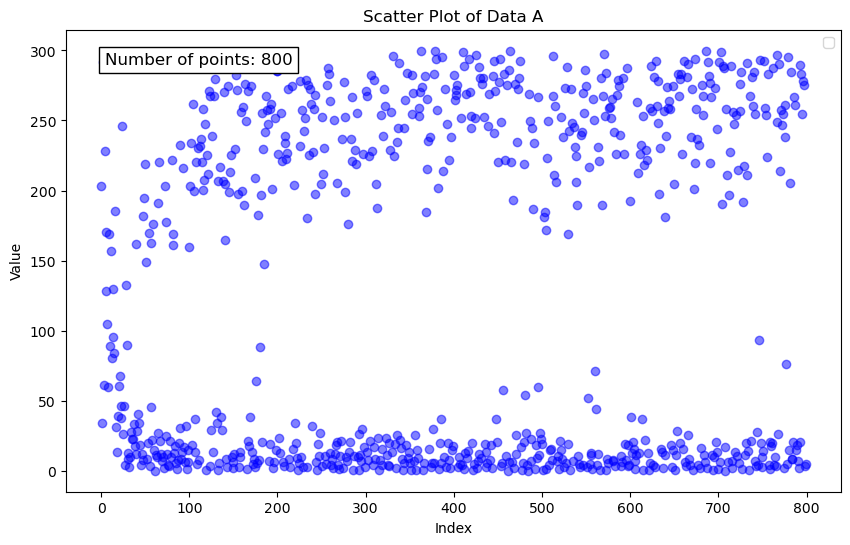

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


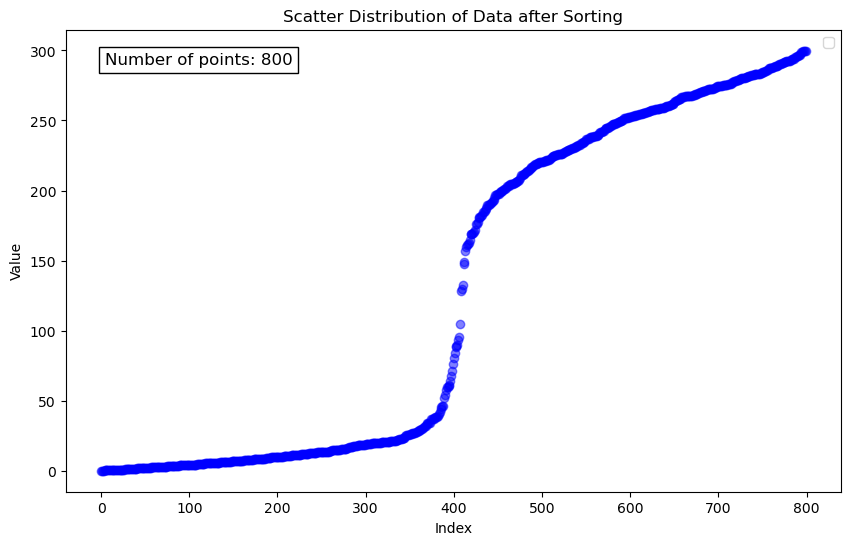

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.00044215659750926724, 0.000447926289821005, 0.00046528507856529534, 0.000449493260910419, 0.00045416803932472264, 0.000451025147539632, 0.000464304224309209, 0.00035500361825755583, 0.0004551666946064595, 0.0004347919163232602]
Error u of fuhe active learning(LHS sampling): 4.419321e-04
[0.0001354897882467913, 0.0001370787663337444, 0.0001407130521765692, 0.00013691932434436213, 0.0001372770821028512, 0.00013788236129096907, 0.00014017916027205522, 0.00014833643785631536, 0.00013649811567977309, 0.00013381636038874874]
MAE of fuhe active learning(LHS sampling): 1.384190e-04
[4.1017535491147916e-08, 4.2834157310979e-08, 4.506602001435658e-08, 4.228711417329605e-08, 4.2994931940511745e-08, 4.263690205754842e-08, 4.529020330567326e-08, 4.40275683575135e-08, 4.310545957886228e-08, 4.008897212046249e-08]
MSE of fuhe active learning(LHS sampling): 4.293489e-08
[0.00091737433, 0.0033293315, 8.174986e-05, 0.00011515436, 0.013141364, 0.0001325212, 8.9137306e-05, 0.0031633228, 0.00011795256, 

[0.00044215659750926724, 0.000447926289821005, 0.00046528507856529534, 0.000449493260910419, 0.00045416803932472264, 0.000451025147539632, 0.000464304224309209, 0.00035500361825755583, 0.0004551666946064595, 0.0004347919163232602]
mean Error u: 4.419321e-04
Variance Error u: 9.154125e-10


/tmp/ipykernel_1420159/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


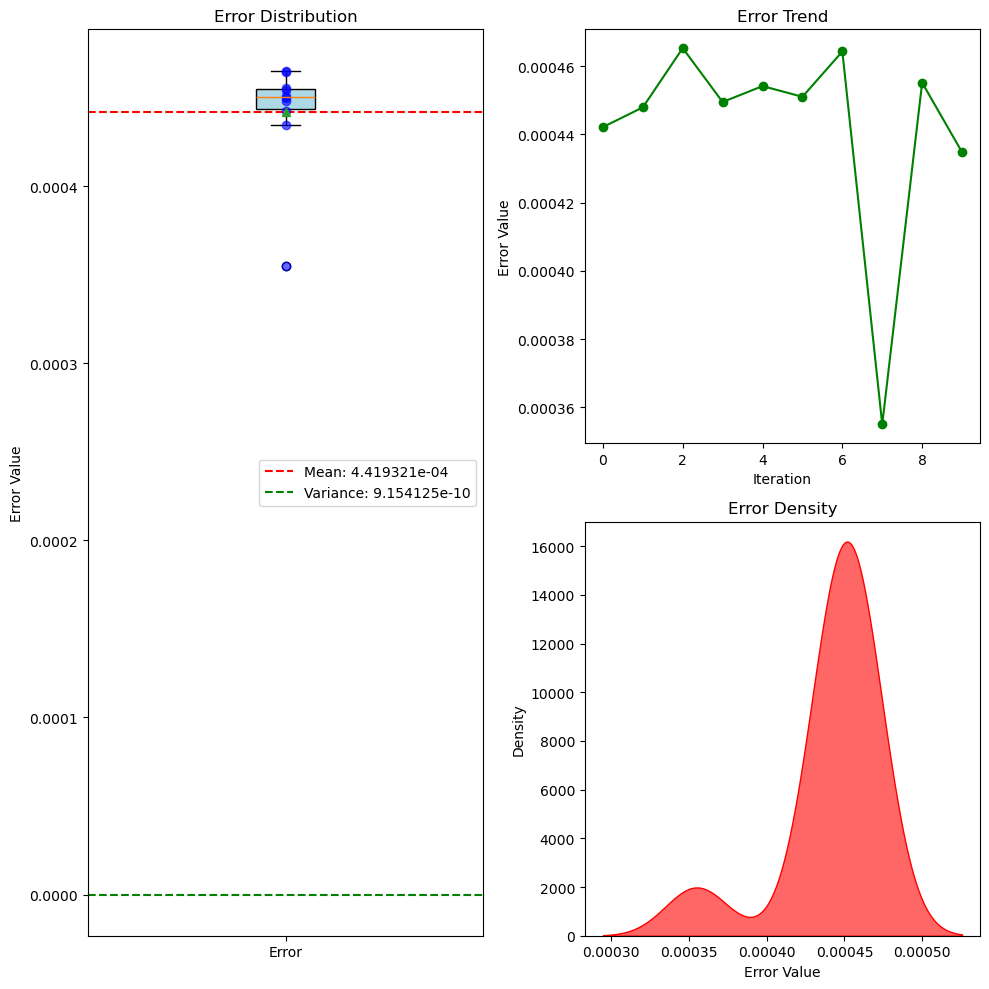

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0001354897882467913, 0.0001370787663337444, 0.0001407130521765692, 0.00013691932434436213, 0.0001372770821028512, 0.00013788236129096907, 0.00014017916027205522, 0.00014833643785631536, 0.00013649811567977309, 0.00013381636038874874]
mean MAE: 1.384190e-04
Variance MAE: 1.458080e-11


/tmp/ipykernel_1420159/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


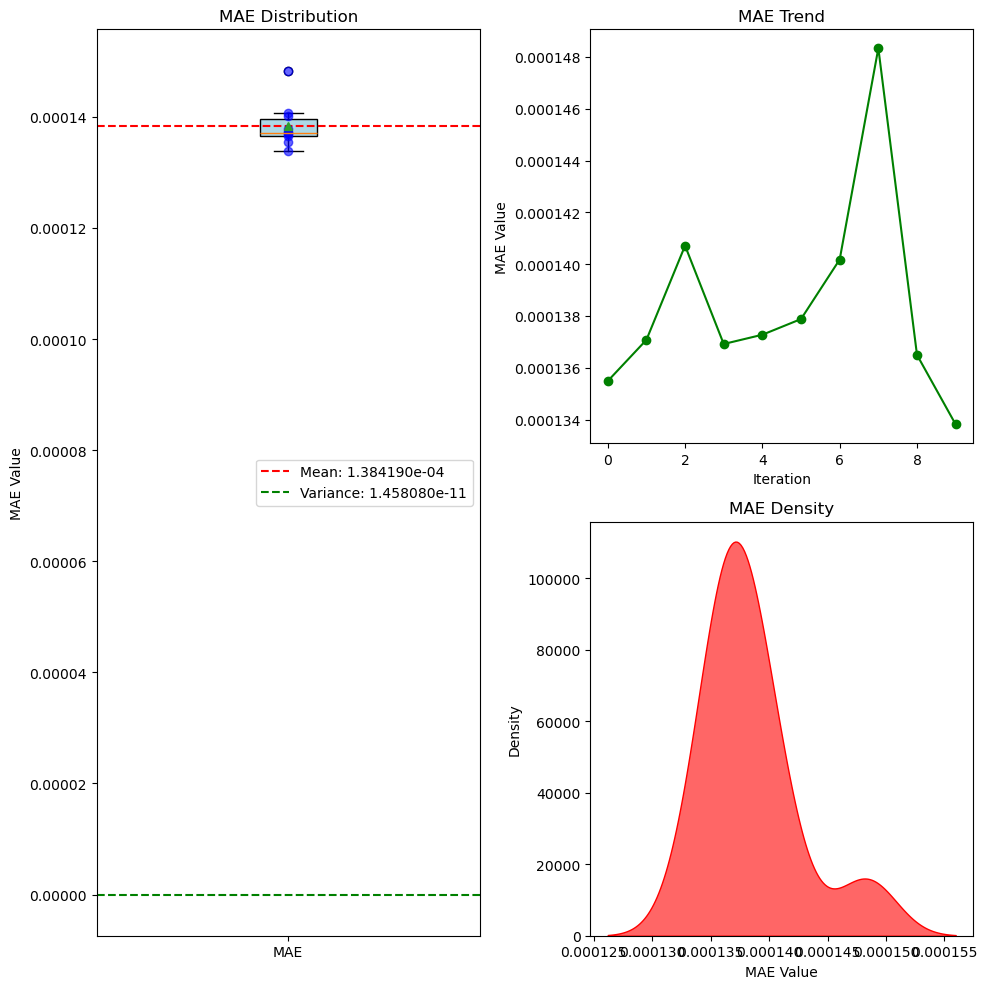

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.1017535491147916e-08, 4.2834157310979e-08, 4.506602001435658e-08, 4.228711417329605e-08, 4.2994931940511745e-08, 4.263690205754842e-08, 4.529020330567326e-08, 4.40275683575135e-08, 4.310545957886228e-08, 4.008897212046249e-08]
mean MSE: 4.293489e-08
Variance MSE: 2.360992e-18


/tmp/ipykernel_1420159/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


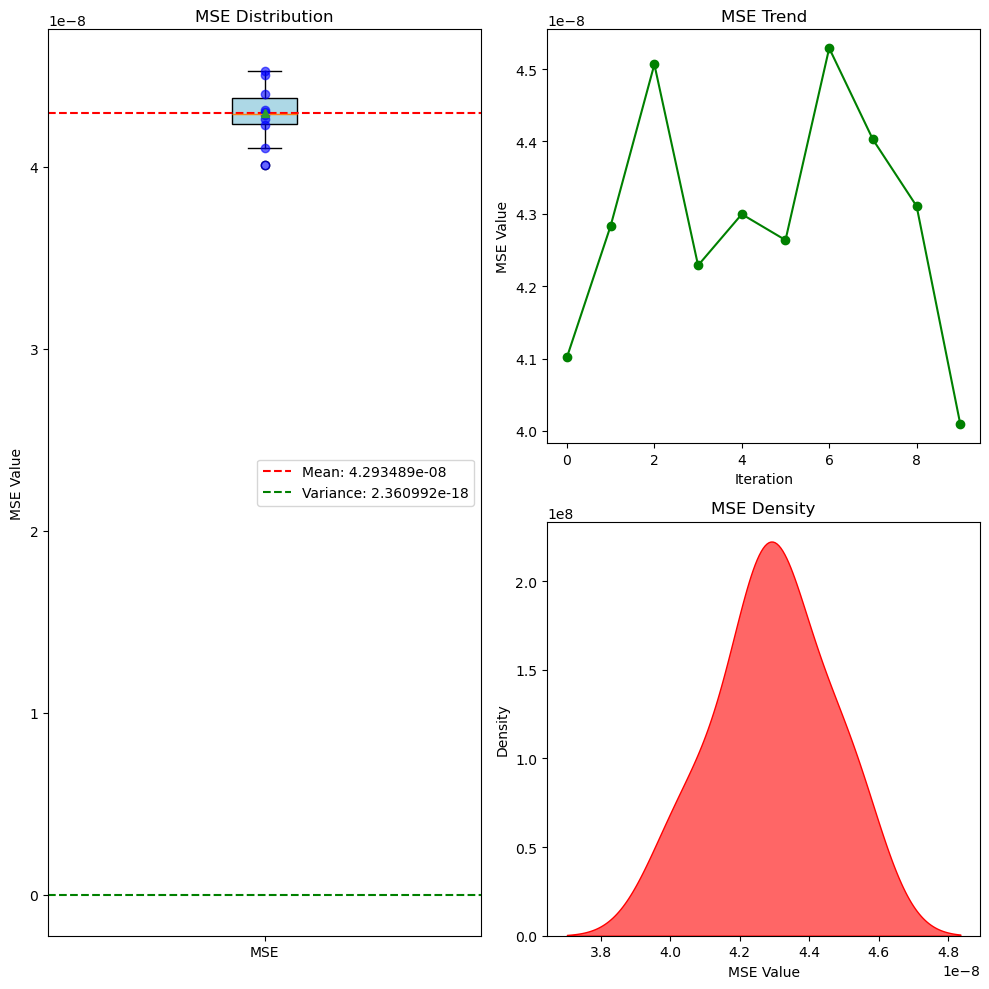

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00091737433, 0.0033293315, 8.174986e-05, 0.00011515436, 0.013141364, 0.0001325212, 8.9137306e-05, 0.0031633228, 0.00011795256, 0.00027504406]


mean CHAOS: 2.136295e-03
Variance CHAOS: 1.491255e-05


/tmp/ipykernel_1420159/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


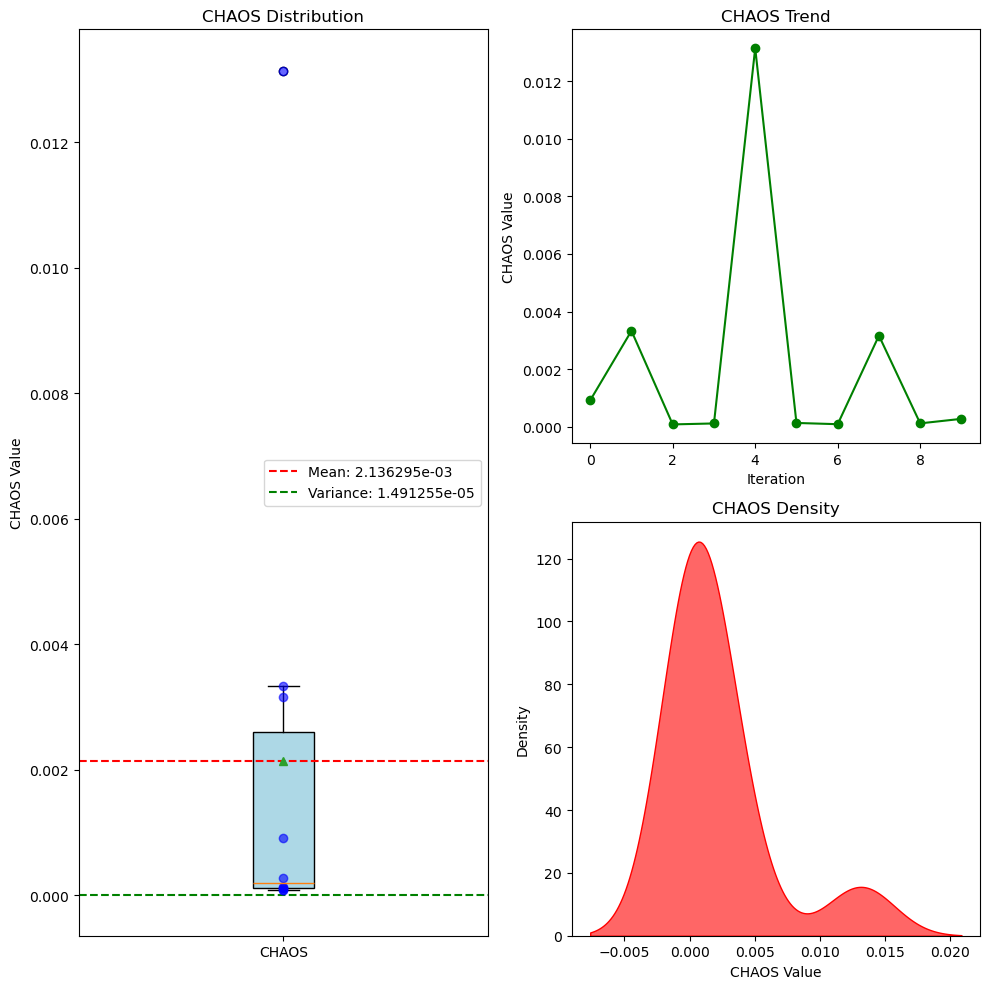

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1420159/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[4.545284e-07, 4.900289e-07, 4.9603216e-07, 4.9779806e-07, 4.7580443e-07, 4.2070178e-07, 4.413498e-07, 4.7953745e-07, 4.4133049e-07, 4.2756392e-07]
mean RESIDUAL: 4.624675e-07
Variance RESIDUAL: 7.522118e-16


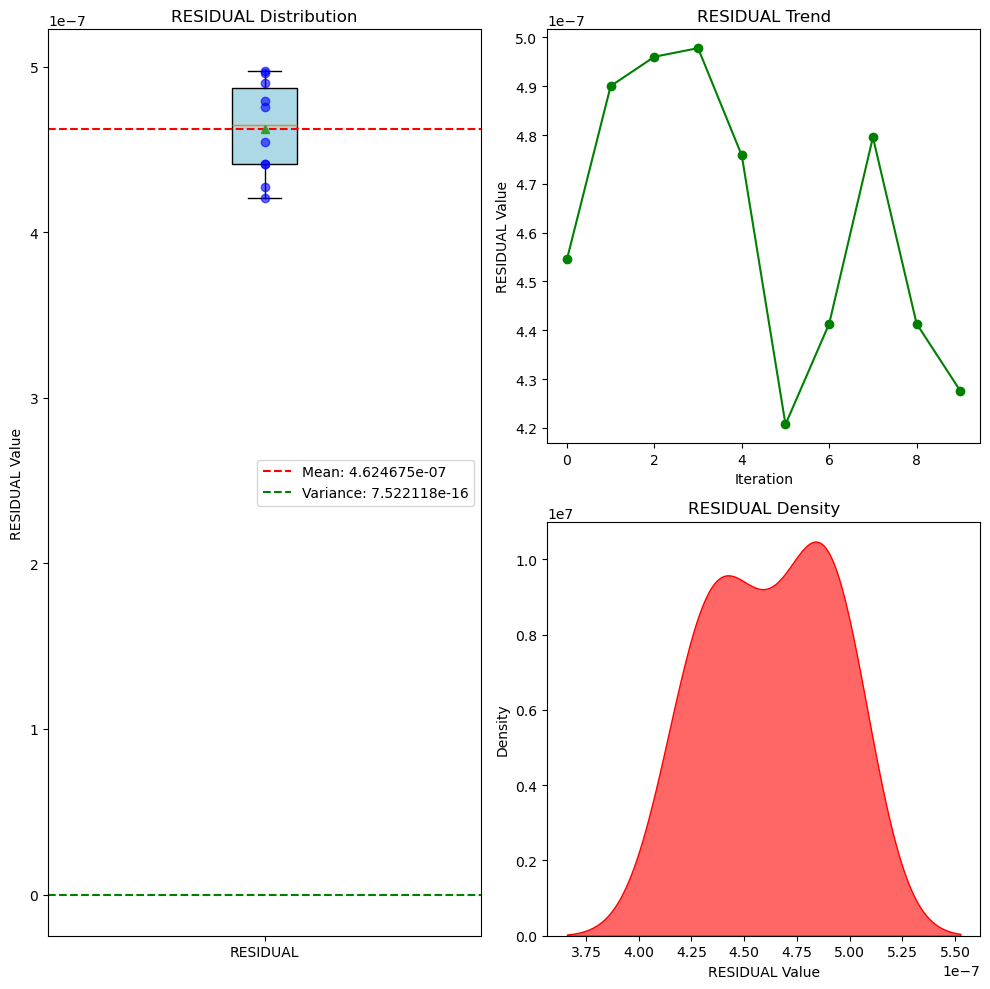

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9635290e-01 1.6684613e-01 1.3925157e-01 ... 3.5774161e-10 3.5395120e-10
 3.5121217e-10]


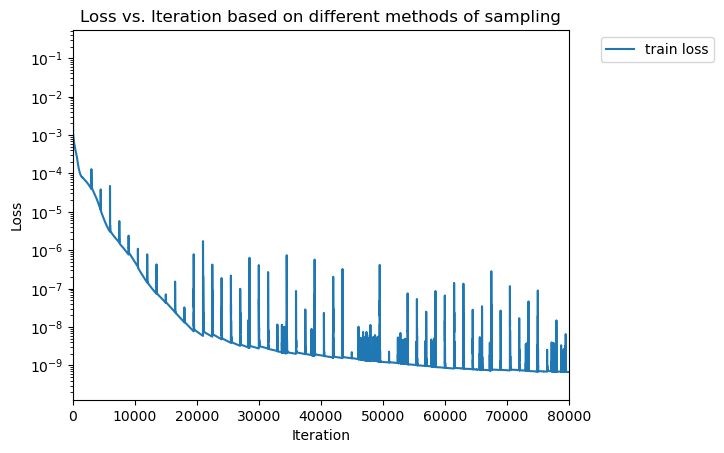

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

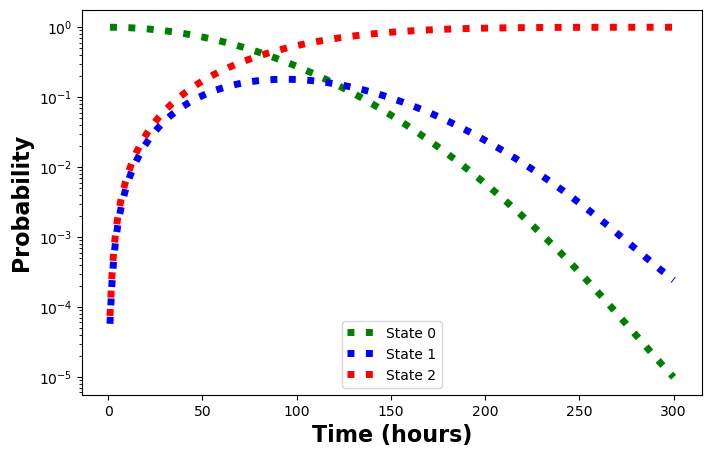

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

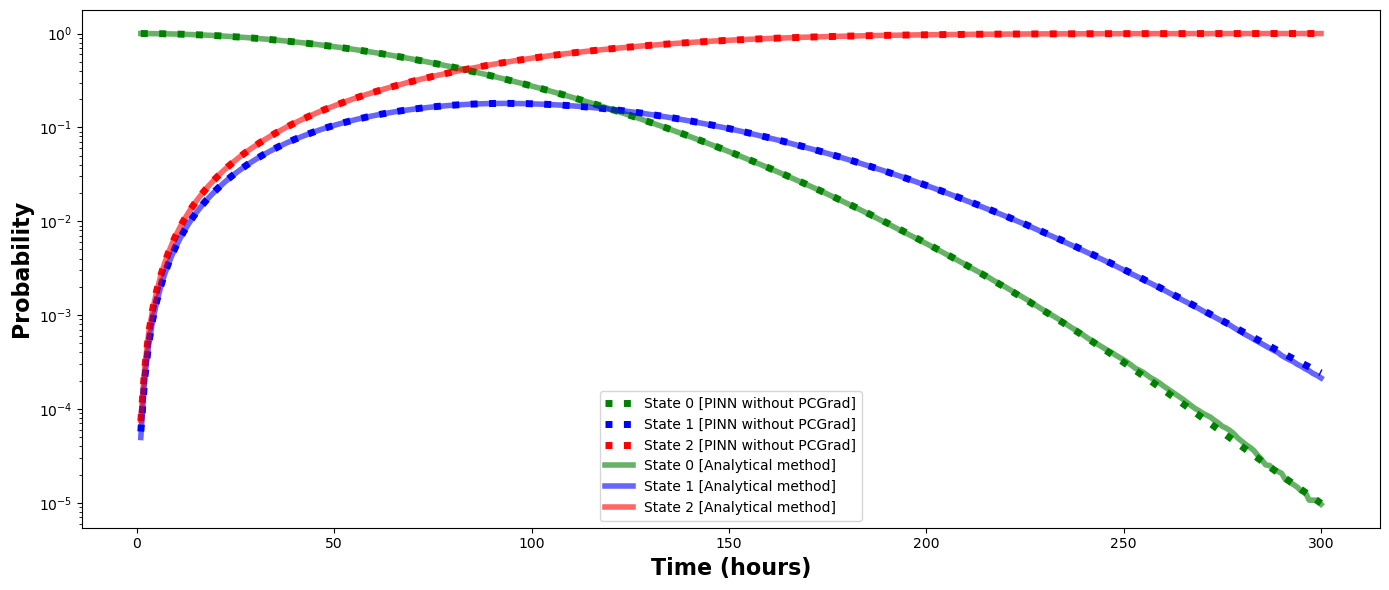

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999868  0.000057  0.000074
1  0.999516  0.000211  0.000272
2  0.998866  0.000495  0.000639
3  0.997953  0.000892  0.001155
4  0.996798  0.001394  0.001808
      state_0   state_1   state_2
295  0.000013  0.000294  0.999693
296  0.000012  0.000280  0.999708
297  0.000011  0.000267  0.999722
298  0.000011  0.000254  0.999735
299  0.000010  0.000242  0.999748


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0002532319486268973
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0002532319486268973
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[0.00916955 0.00892576 0.00872512 0.00855903 0.00842383 0.00832175
 0.00824277 0.00817959 0.0081332  0.00809774 0.00807127 0.00805336
 0.00804136 0.00803573 0.0080379  0.00804561 0.00805728 0.00807567
 0.0080971  0.00812252 0.00815502 0.00819029 0.00822564 0.00826392
 0.00830673 0.00834988 0.00839393 0.0084393  0.00848556 0.00853016
 0.0085744  0.0086206  0.00866473 0.00870709 0.00875097 0.00879349
 0.00883317 0.0088727  0.00891142 0.008948   0.00898529 0.00902097
 0.00905703 0.00909023 0.00912294 0.00915359 0.00918564 0.00921744
 0.00924682 0.0092762  0.00930562 0.0093348  0.00936138 0.00939102
 0.0094162  0.00944491 0.00947102 0.00949605 0.00952211 0.0095473
 0.00957233 0.00959721 0.00962005 0.00964482 0.00966756 0.00969109
 0.00971386 0.00973523 0.00975799 0.00977949 0.00980102 0.00982002
 0.00983957 0.00986059 0.00987943 0.00989755 0.009917   0.0099342
 0.00994963 0.00996745 0.00998261 0.00999695 0.01001109 0.01002446
 0.01003859 0.01005073 0.01006277 0.01007355 0.01008508 0.010093

Text(0.5, 1.0, 'Chaos of x_star')

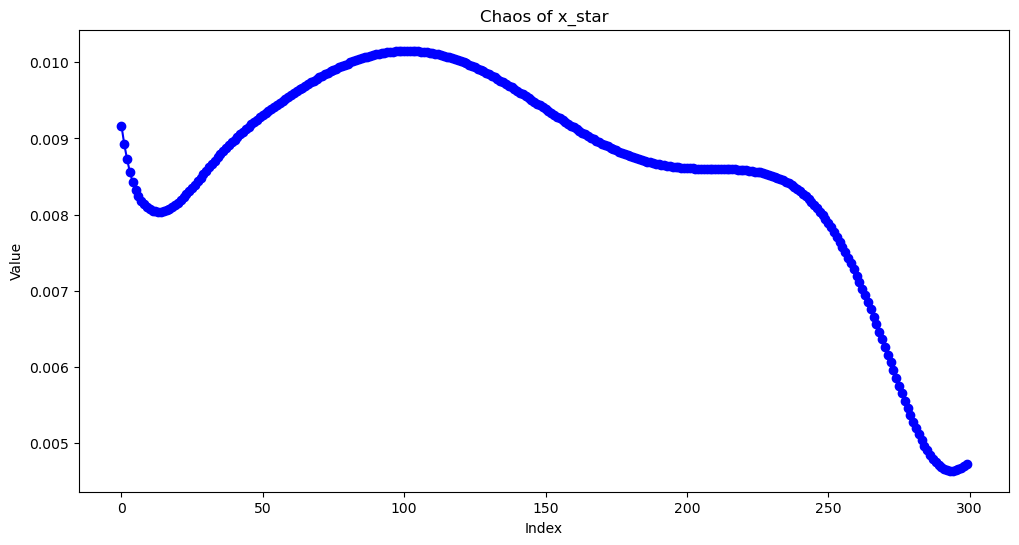

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Chaos of x_star')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 3.9028237e-08 -1.9499566e-09  1.2456439e-08 -4.6275090e-09
  6.1118044e-09  5.5297278e-09  4.9476512e-09  2.6775524e-09
  1.1874363e-08 -4.1909516e-09  7.3341653e-09 -2.9103830e-09
 -8.1490725e-10  1.7462298e-09 -7.7998266e-09 -2.6775524e-09
  6.9849193e-10  1.7462298e-09  3.2596290e-09  1.6298145e-09
  2.0954758e-09  0.0000000e+00  9.3132257e-10 -2.3283064e-10
  1.3969839e-09 -6.9849193e-10 -1.6298145e-09  3.2596290e-09
  3.9581209e-09  9.3132257e-10 -1.3969839e-09 -1.1641532e-09
  6.9849193e-10  0.0000000e+00  1.3969839e-09 -6.9849193e-10
 -6.9849193e-10 -2.3283064e-10 -1.3969839e-09 -2.3283064e-10
  4.6566129e-10  0.0000000e+00 -2.3283064e-10  9.3132257e-10
  1.8626451e-09  1.1641532e-09  2.3283064e-10  4.6566129e-10
  1.3969839e-09 -9.3132257e-10  2.3283064e-10  1.1641532e-09
  4.6566129e-10  0.0000000e+00  6.9849193e-10  4.6566129e-10
  4.6566129e-10  1.3969839e-09  1.8626451e-09 -4.6566129e-10
  4.6566129e-10  9.3132257e-10  6.9849193e-10  2.3283064e-10
  1.3969839e-09 -2.32830

Text(0.5, 1.0, 'Residual of x_star')

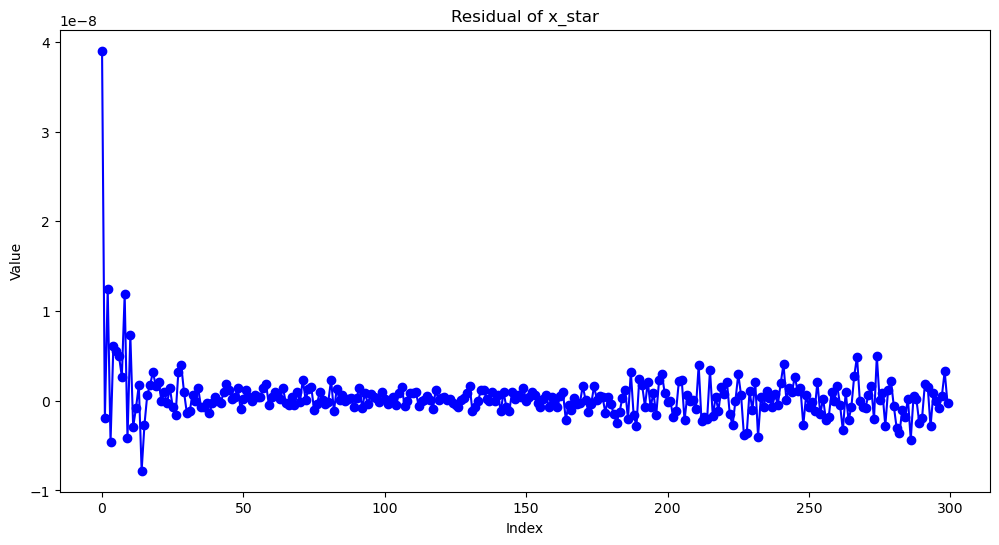

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Residual of x_star')
